In [9]:
import tensorflow as tf
import os
import numpy as np

# Parsing function
def _parse_function(proto):
    keys_to_features = {
        'spectrogram': tf.io.FixedLenFeature([512], tf.float32),
        'notes': tf.io.FixedLenFeature([49], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    return parsed_features['spectrogram'], parsed_features['notes']

# Augmentation functions
def add_noise(spectrogram, noise_factor=0.005):
    noise = np.random.randn(*spectrogram.shape) * noise_factor
    return spectrogram + noise

def amplitude_scaling(spectrogram, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return spectrogram * scale

def augment_data(spectrogram, notes):
    spectrogram = add_noise(spectrogram).astype(np.float32)
    spectrogram = amplitude_scaling(spectrogram).astype(np.float32)
    return spectrogram, notes

def tf_augment_data(spectrogram, notes):
    spectrogram, notes = tf.numpy_function(augment_data, [spectrogram, notes], [tf.float32, tf.int64])
    spectrogram.set_shape([512])  # Explicitly set the shape
    notes.set_shape([49])          # Explicitly set the shape
    return spectrogram, notes

# Directory containing TFRecord files
tfrecord_dir = 'GeneratedData'

# Get list of all TFRecord files
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrecord')]

# Create a dataset from the TFRecord files
raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

# Parse the dataset
parsed_dataset = raw_dataset.map(_parse_function)

# Augment the dataset
augmented_dataset = parsed_dataset.map(tf_augment_data)

# Shuffle, batch, and prefetch the dataset
batch_size = 32
dataset = augmented_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512, 1)),

    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(49, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 512, 32)           128       
                                                                 
 batch_normalization_3 (Batc  (None, 512, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 256, 32)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 256, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 256, 64)           6208      
                                                                 
 batch_normalization_4 (Batc  (None, 256, 64)         

In [12]:
# Train the model
history = model.fit(dataset, epochs=80, validation_data=dataset, validation_steps=80, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

model_save_path = '*saved_tf_models/BasicConvGuitarNotePredictor(512_input).keras'

# Save the model
model.save(model_save_path)

Epoch 1/80
1200/1200 [==============================] - 29s 22ms/step - loss: 0.1295 - accuracy: 0.3777 - val_loss: 0.0864 - val_accuracy: 0.4266
Epoch 2/80
1200/1200 [==============================] - 29s 22ms/step - loss: 0.1100 - accuracy: 0.3972 - val_loss: 0.0743 - val_accuracy: 0.4148
Epoch 3/80
1200/1200 [==============================] - 29s 22ms/step - loss: 0.0958 - accuracy: 0.3944 - val_loss: 0.0614 - val_accuracy: 0.3965
Epoch 4/80
1200/1200 [==============================] - 29s 22ms/step - loss: 0.0850 - accuracy: 0.3942 - val_loss: 0.0514 - val_accuracy: 0.4297
Epoch 5/80
1200/1200 [==============================] - 29s 22ms/step - loss: 0.0771 - accuracy: 0.3954 - val_loss: 0.0428 - val_accuracy: 0.4035
Epoch 6/80
1200/1200 [==============================] - 29s 23ms/step - loss: 0.0708 - accuracy: 0.3964 - val_loss: 0.0368 - val_accuracy: 0.4098
Epoch 7/80
1200/1200 [==============================] - 29s 22ms/step - loss: 0.0654 - accuracy: 0.3909 - val_loss: 0.0319 -

In [7]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
# Function to parse the TFRecord file
def _parse_function(proto):
    # Define your features
    keys_to_features = {
        'spectrogram': tf.io.FixedLenFeature([512], tf.float32),
        'notes': tf.io.FixedLenFeature([49], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    return parsed_features['spectrogram'], parsed_features['notes']

def create_images_from_tfrecord(tfrecord_file):
    # Create a dataset from the TFRecord file
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    parsed_dataset = raw_dataset.map(_parse_function)

    amplitude_arrays = []
    notes_arrays = []

    for spectrogram, notes in parsed_dataset:
        amplitude_arrays.append(spectrogram.numpy())
        notes_arrays.append(notes.numpy())

    amplitude_arrays = np.array(amplitude_arrays)
    notes_arrays = np.array(notes_arrays)

    # Normalize the amplitude arrays to the range 0-255 for image representation
    amplitude_normalized = (amplitude_arrays - np.min(amplitude_arrays)) / np.ptp(amplitude_arrays) * 255
    amplitude_normalized = amplitude_normalized.astype(np.uint8)

    # Convert notes arrays to uint8
    notes_arrays = notes_arrays.astype(np.uint8)

    # Create images from the arrays
    amplitude_image = Image.fromarray(amplitude_normalized.T[::-1])  # Transpose to match desired format
    notes_image = Image.fromarray(notes_arrays.T[::-1])  # Transpose to match desired format
    print(notes_image)

    # Display the images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Amplitude Arrays')
    plt.imshow(amplitude_image, aspect='auto', cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Notes Arrays')
    plt.imshow(notes_image, aspect=1, cmap='gray')
    plt.axis('off')

    plt.show()
    return notes_image

<PIL.Image.Image image mode=L size=128x49 at 0x7F60E1D5EFA0>


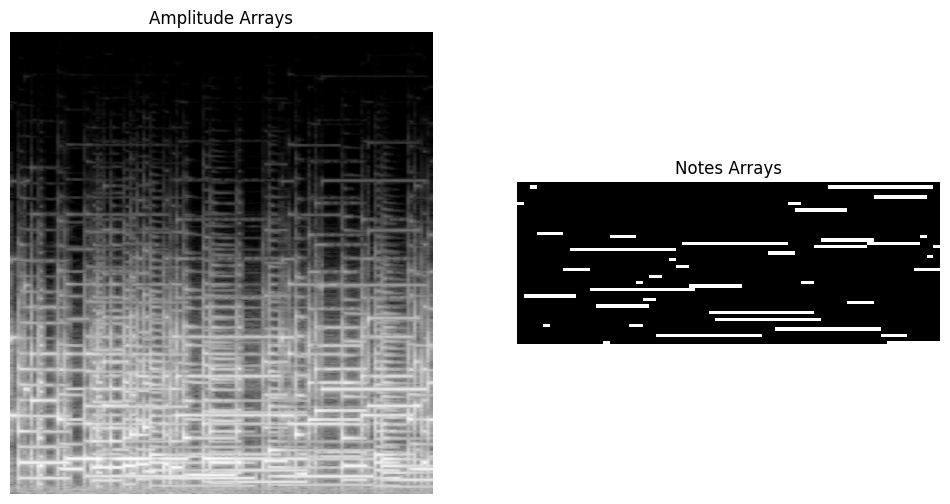

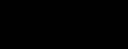

In [8]:

# Specify the path to the TFRecord file
tfrecord_file = 'GeneratedData/aavBuDcvHLUfUHTanMUQ.tfrecord'

# Create and display the images
test = create_images_from_tfrecord(tfrecord_file)
test

In [15]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from PIL import Image
import tensorflow as tf
import mido
from scipy.signal import spectrogram, butter, filtfilt

# ---WAV PROCESSING---

def normalize_array(array):
    if np.ptp(array) == 0:  # Check if the array has zero range
        return np.zeros(array.shape, dtype=np.uint8)
    normalized_array = 255 * (array - np.min(array)) / np.ptp(array)
    return normalized_array.astype(np.uint8)

def bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def create_amplitude_tensors(filename, bpm):
    wav_file = 'WAVs/' + filename + '.wav'
    output_file = 'Spectrograms/' + filename + '.png'

    # Load the WAV file
    sample_rate, data = wavfile.read(wav_file)

    # If stereo, convert to mono by averaging the channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)

    # Apply the band-pass filter
    lowcut = 70  # E2 frequency in Hz
    highcut = 1700  # E6 frequency in Hz
    data = bandpass_filter(data, lowcut, highcut, sample_rate)

    # Calculate the spectrogram with a larger FFT window size
    nperseg = 4094  # Larger window size for better frequency resolution
    noverlap = nperseg // 1.5 #Strange grey bars appear for values greater than 1.5

    frequencies, times, Sxx = spectrogram(data, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap)

    # Convert the spectrogram (power spectral density) to decibels
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Adding a small number to avoid log(0)

    Sxx_dB = Sxx_dB[:][:512]

    # Normalize the values between 0 and 255
    img_array = np.uint8(255 * (Sxx_dB - np.min(Sxx_dB)) / np.ptp(Sxx_dB))
    
    # Convert to Image and save as PNG
    image = Image.fromarray(img_array)
    image.save(output_file)

    # Calculate the duration of a 32nd note in seconds
    beats_per_second = bpm / 60
    seconds_per_beat = 1 / beats_per_second
    seconds_per_32nd_note = seconds_per_beat / 8  # 32nd note duration

    # Determine the number of time slices for each 32nd note duration
    num_slices = int(np.ceil(times[-1] / seconds_per_32nd_note))

    # List to store the average values of each vertical slice
    avg_slices = []

    # Iterate over each 32nd note slice
    for i in range(num_slices):
        # Determine the start and end time for this slice
        start_time = i * seconds_per_32nd_note
        end_time = (i + 1) * seconds_per_32nd_note

        # Find the indices in the time array that correspond to this slice
        start_idx = np.searchsorted(times, start_time)
        end_idx = np.searchsorted(times, end_time)

        # Get the slice of the spectrogram for this time period
        slice_Sxx_dB = Sxx_dB[:, start_idx:end_idx]

        # Calculate the average value of each vertical pixel in this slice
        avg_values = np.mean(slice_Sxx_dB, axis=1)
        avg_slices.append(avg_values)

    # Convert the list of average slices to a numpy array for further processing
    avg_slices_array = np.array(avg_slices)
    
    return avg_slices_array


def process_wav_file_for_prediction(model, filename, bpm, trim_length):
    # Generate spectrogram slices
    spectrogram_slices = create_amplitude_tensors(filename, bpm)

    # Reshape the slices for the model (add channel dimension)
    spectrogram_slices = spectrogram_slices.reshape((spectrogram_slices.shape[0], spectrogram_slices.shape[1], 1))

    # Predict using the model
    predictions = model.predict(spectrogram_slices)

    # Normalize predictions to the range 0-255 for image representation
    predictions_normalized = (predictions - np.min(predictions)) / np.ptp(predictions) * 255
    predictions_normalized = predictions_normalized.astype(np.uint8)

    predictions_trimmed = predictions_normalized[:trim_length]

    # threshold = 220

    # for i in range(len(predictions)):
    #     for j in range(len(predictions[0])):
    #         if predictions[i][j] <= threshold: predictions[i][j] = 0

    # # Create and save the image
    # image = Image.fromarray(predictions_trimmed.T)  # Transpose to match desired format
    # image.save('OutputImages/' + filename + '_output.png')

    return predictions




# ----------------------------------------------------------------------------------------------------------

# ---MIDI PROCESSING---

def load_midi(file_path):
    """Load the MIDI file and return the messages with their cumulative times."""
    midi_file = mido.MidiFile(file_path)
    messages_with_time = []

    # Initialize the current time
    current_time = 0

    for message in midi_file:
        # Increment the current time by the time of the current message
        current_time += message.time
        # Append the message with the cumulative time to the list
        messages_with_time.append((current_time, message))

    return messages_with_time

def get_note_periods(messages_with_time):
    """Get the time periods for each note."""
    note_periods = []
    notes_on = {}

    for time, message in messages_with_time:
        if message.type == 'note_on' and message.velocity > 0:
            if message.note not in notes_on:
                notes_on[message.note] = []
            notes_on[message.note].append(time)
        elif message.type == 'note_off' or (message.type == 'note_on' and message.velocity == 0):
            if message.note in notes_on and notes_on[message.note]:
                start_time = notes_on[message.note].pop()
                note_periods.append((message.note, start_time, time))

    # If there are notes that were not turned off, handle them appropriately
    for note, times in notes_on.items():
        for start_time in times:
            note_periods.append((note, start_time, messages_with_time[-1][0]))

    return note_periods

def create_note_dict(note_periods):
    """Create a dictionary of note periods."""
    note_dict = {}
    note_id = 0

    for note, start_time, end_time in note_periods:
        note_dict[note_id] = [note, (start_time, end_time)]
        note_id += 1

    return note_dict

def get_notes_in_32nd_period(note_dict, start_time, end_time):
    """Get one-hot encoded notes for a specific 32nd-note period."""
    notes_playing = set()
    period_duration = end_time - start_time
    threshold = period_duration / 2

    for note_info in note_dict.values():
        note, (note_start, note_end) = note_info
        overlap_start = max(note_start, start_time)
        overlap_end = min(note_end, end_time)
        overlap_duration = overlap_end - overlap_start

        if overlap_duration > threshold:
            notes_playing.add(note)

    # Create a one-hot encoded array for notes 40 to 88
    one_hot_array = [0] * (88 - 40 + 1)
    for note in notes_playing:
        if 40 <= note <= 88:
            one_hot_array[note - 40] = 1

    return one_hot_array

def get_all_32nd_note_periods(note_dict, start_time, end_time, period_duration):
    """Generate one-hot encoded arrays for all 32nd-note periods."""
    current_time = start_time
    periods = []

    while current_time < end_time:
        next_time = current_time + period_duration
        one_hot_array = get_notes_in_32nd_period(note_dict, current_time, next_time)
        periods.append(one_hot_array)
        current_time = next_time

    return periods

def create_midi_tensors(filename):
    """Main function to load the MIDI file and get one-hot encoded note periods."""

    file_path="MIDIs/"+filename+".mid"
    messages_with_time = load_midi(file_path)
    note_periods = get_note_periods(messages_with_time)
    note_dict = create_note_dict(note_periods)

    one_hot_encoded_periods = get_all_32nd_note_periods(note_dict, 0, 8, 0.0625)

    one_hot_encoded_periods = np.array(one_hot_encoded_periods).astype(np.uint8)
    # print(one_hot_encoded_periods[0])

    image = Image.fromarray(one_hot_encoded_periods.T[::-1] * 255)  # Transpose to match desired format
    image.save('OutputImages/' + filename + '_midi.png')

    return one_hot_encoded_periods

# Load the trained model
model = tf.keras.models.load_model('*saved_tf_models/BasicConvGuitarNotePredictor(512_input).keras')

# Process the WAV file and generate the output image
filename = 'aavBuDcvHLUfUHTanMUQ'
bpm = 120
midi = create_midi_tensors(filename)
# print(midi[0])
len_midi_array = len(midi[0])
# predictions = process_wav_file_for_prediction(model, filename, bpm, len_midi_array)

In [16]:
def process_wav_file_for_prediction(model, filename, bpm, trim_length):
    # Generate spectrogram slices
    spectrogram_slices = create_amplitude_tensors(filename, bpm)
    print(spectrogram_slices)

    # Normalize the inputs
    # spectrogram_slices = (spectrogram_slices - np.min(spectrogram_slices)) / np.ptp(spectrogram_slices)

    # Reshape the slices for the model (add channel dimension)
    spectrogram_slices = spectrogram_slices.reshape((spectrogram_slices.shape[0], spectrogram_slices.shape[1], 1))

    # Predict using the model
    predictions = model.predict(spectrogram_slices)


    # # Normalize predictions to the range 0-255 for image representation
    # predictions_normalized = (predictions - np.min(predictions)) / np.ptp(predictions) * 255
    # predictions_normalized = predictions_normalized.astype(np.uint8)

    # predictions_trimmed = predictions_normalized[:trim_length]

    # threshold = 220

    # for i in range(len(predictions)):
    #     for j in range(len(predictions[0])):
    #         if predictions[i][j] <= threshold: predictions[i][j] = 0

    # # Create and save the image
    # image = Image.fromarray(predictions_trimmed.T)  # Transpose to match desired format
    # image.save('OutputImages/' + filename + '_output.png')

    return predictions

In [17]:
predictions = process_wav_file_for_prediction(model, filename, bpm, len_midi_array)
predictions

[[ -26.38620432  -15.38968873   -8.9058301  ...  -99.99984912
   -99.99432218  -99.97205175]
 [ -20.46067461  -19.40191656  -15.90282555 ...  -99.9993528
   -99.99948346  -99.99908879]
 [ -20.31895447  -10.47735685   -2.59175022 ...  -99.98393978
   -99.99617511  -99.99218404]
 ...
 [-100.         -100.         -100.         ... -100.
  -100.         -100.        ]
 [-100.         -100.         -100.         ... -100.
  -100.         -100.        ]
 [-100.         -100.         -100.         ... -100.
  -100.         -100.        ]]
1/6 [====>.........................] - ETA: 1s

2024-06-13 18:09:33.425716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 145ms/step


2024-06-13 18:09:34.282003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:09:34.282078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13855 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-13 18:09:34.289438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:09:34.289518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13855 MB memory) -> physical PluggableDevice (device: 0, name: 

array([[1.7573403e-16, 5.7256966e-13, 2.5127849e-11, ..., 6.8904029e-09,
        1.0462642e-09, 2.8727361e-11],
       [7.4948328e-14, 6.7102811e-14, 8.8620769e-12, ..., 1.7168622e-08,
        1.5185379e-11, 4.7434359e-11],
       [3.1390070e-06, 2.4186613e-06, 3.8961749e-05, ..., 6.4994529e-05,
        2.5243924e-06, 2.5857025e-06],
       ...,
       [6.6406485e-12, 6.4076311e-10, 1.2048316e-07, ..., 1.3783227e-07,
        6.2813400e-11, 6.5649295e-09],
       [6.6406485e-12, 6.4076311e-10, 1.2048316e-07, ..., 1.3783227e-07,
        6.2813400e-11, 6.5649295e-09],
       [6.6406485e-12, 6.4076311e-10, 1.2048316e-07, ..., 1.3783227e-07,
        6.2813400e-11, 6.5649295e-09]], dtype=float32)

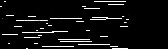

In [18]:
predictions = (predictions* 255).astype(np.uint8)

predictions
# threshold = 0

# for i in range(len(predictions)):
#     for j in range(len(predictions[0])):
#         if predictions[i][j] <= threshold: predictions[i][j] = 0

# Create and save the image
image = Image.fromarray(predictions.T[::-1])  # Transpose to match desired format
# image = image.convert('L')
# image.save('OutputImages/' + filename + '_output.png')
image

In [48]:
for item in predictions.tolist(): print("\t".join([str(x) for x in item]))


0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	255	0	0	0	0	0	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	255	0	0	0	0	0	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	0	0	254	0	0	0	0	0	0	0	0	252	0	0	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	0	0	254	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	254	0	0	0	0	0	0	0	

In [20]:
print(midi)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


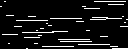

In [3]:
notes_image = Image.fromarray((midi*255).T[::-1])  # Transpose to match desired format

notes_image


In [28]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from PIL import Image
import tensorflow as tf
import mido

# ---WAV PROCESSING---

def create_amplitude_tensors(filename, bpm):
    wav_file = 'WAVs/' + filename + '.wav'

    # Load the WAV file
    sample_rate, data = wavfile.read(wav_file)

    # If stereo, convert to mono by averaging the channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)

    # Calculate the spectrogram with a larger FFT window size
    nperseg = 4094  # Larger window size for better frequency resolution
    noverlap = nperseg // 1.5 #Strange grey bars appear for values greater than 1.5

    frequencies, times, Sxx = spectrogram(data, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap)

    # Convert the spectrogram (power spectral density) to decibels
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Adding a small number to avoid log(0)

    # Calculate the duration of a 32nd note in seconds
    beats_per_second = bpm / 60
    seconds_per_beat = 1 / beats_per_second
    seconds_per_32nd_note = seconds_per_beat / 8  # 32nd note duration

    # Determine the number of time slices for each 32nd note duration
    num_slices = int(np.ceil(times[-1] / seconds_per_32nd_note))

    # List to store the average values of each vertical slice
    avg_slices = []

    # Iterate over each 32nd note slice
    for I in range(num_slices):
        # Determine the start and end time for this slice
        start_time = I * seconds_per_32nd_note
        end_time = (I + 1) * seconds_per_32nd_note

        # Find the indices in the time array that correspond to this slice
        start_idx = np.searchsorted(times, start_time)
        end_idx = np.searchsorted(times, end_time)

        # Get the slice of the spectrogram for this time period
        slice_Sxx_dB = Sxx_dB[:, start_idx:end_idx]

        # Calculate the average value of each vertical pixel in this slice
        avg_values = np.mean(slice_Sxx_dB, axis=1)
        avg_slices.append(avg_values)

    # Convert the list of average slices to a numpy array for further processing
    avg_slices_array = np.array(avg_slices)

    return avg_slices_array

def process_wav_file_for_prediction(model, filename, bpm, trim_length):
    # Generate spectrogram slices
    spectrogram_slices = create_amplitude_tensors(filename, bpm)

    # Reshape the slices for the model (add channel dimension)
    spectrogram_slices = spectrogram_slices.reshape((spectrogram_slices.shape[0], spectrogram_slices.shape[1], 1))

    # Predict using the model
    predictions = model.predict(spectrogram_slices)

    # Normalize predictions to the range 0-255 for image representation
    predictions_normalized = (predictions - np.min(predictions)) / np.ptp(predictions) * 255
    predictions_normalized = predictions_normalized.astype(np.uint8)

    predictions_trimmed = predictions_normalized[:trim_length]

    # threshold = 220

    # for i in range(len(predictions)):
    #     for j in range(len(predictions[0])):
    #         if predictions[i][j] <= threshold: predictions[i][j] = 0

    # # Create and save the image
    # image = Image.fromarray(predictions_trimmed.T)  # Transpose to match desired format
    # image.save('OutputImages/' + filename + '_output.png')

    return predictions




# ----------------------------------------------------------------------------------------------------------

# ---MIDI PROCESSING---

def load_midi(file_path):
    """Load the MIDI file and return the messages with their cumulative times."""
    midi_file = mido.MidiFile(file_path)
    messages_with_time = []

    # Initialize the current time
    current_time = 0

    for message in midi_file:
        # Increment the current time by the time of the current message
        current_time += message.time
        # Append the message with the cumulative time to the list
        messages_with_time.append((current_time, message))

    return messages_with_time

def get_note_periods(messages_with_time):
    """Get the time periods for each note."""
    note_periods = []
    notes_on = {}

    for time, message in messages_with_time:
        if message.type == 'note_on' and message.velocity > 0:
            if message.note not in notes_on:
                notes_on[message.note] = []
            notes_on[message.note].append(time)
        elif message.type == 'note_off' or (message.type == 'note_on' and message.velocity == 0):
            if message.note in notes_on and notes_on[message.note]:
                start_time = notes_on[message.note].pop()
                note_periods.append((message.note, start_time, time))

    # If there are notes that were not turned off, handle them appropriately
    for note, times in notes_on.items():
        for start_time in times:
            note_periods.append((note, start_time, messages_with_time[-1][0]))

    return note_periods

def create_note_dict(note_periods):
    """Create a dictionary of note periods."""
    note_dict = {}
    note_id = 0

    for note, start_time, end_time in note_periods:
        note_dict[note_id] = [note, (start_time, end_time)]
        note_id += 1

    return note_dict

def get_notes_in_32nd_period(note_dict, start_time, end_time):
    """Get one-hot encoded notes for a specific 32nd-note period."""
    notes_playing = set()
    period_duration = end_time - start_time
    threshold = period_duration / 2

    for note_info in note_dict.values():
        note, (note_start, note_end) = note_info
        overlap_start = max(note_start, start_time)
        overlap_end = min(note_end, end_time)
        overlap_duration = overlap_end - overlap_start

        if overlap_duration > threshold:
            notes_playing.add(note)

    # Create a one-hot encoded array for notes 40 to 88
    one_hot_array = [0] * (88 - 40 + 1)
    for note in notes_playing:
        if 40 <= note <= 88:
            one_hot_array[note - 40] = 1

    return one_hot_array

def get_all_32nd_note_periods(note_dict, start_time, end_time, period_duration):
    """Generate one-hot encoded arrays for all 32nd-note periods."""
    current_time = start_time
    periods = []

    while current_time < end_time:
        next_time = current_time + period_duration
        one_hot_array = get_notes_in_32nd_period(note_dict, current_time, next_time)
        periods.append(one_hot_array)
        current_time = next_time

    return periods

def create_midi_tensors(filename):
    """Main function to load the MIDI file and get one-hot encoded note periods."""

    file_path="MIDIs/"+filename+".mid"
    messages_with_time = load_midi(file_path)
    note_periods = get_note_periods(messages_with_time)
    note_dict = create_note_dict(note_periods)

    one_hot_encoded_periods = get_all_32nd_note_periods(note_dict, 0, 8, 0.0625)

    one_hot_encoded_periods = np.array(one_hot_encoded_periods).astype(np.uint8)
    # print(one_hot_encoded_periods[0])

    image = Image.fromarray(one_hot_encoded_periods.T[::-1] * 255)  # Transpose to match desired format
    image.save('OutputImages/' + filename + '_midi.png')

    return one_hot_encoded_periods

def process_wav_file_for_prediction(model, filename, bpm, trim_length):
    # Generate spectrogram slices
    spectrogram_slices = create_amplitude_tensors(filename, bpm)
    # print(spectrogram_slices)

    # Reshape the slices for the model (add channel dimension)
    spectrogram_slices = spectrogram_slices.reshape((spectrogram_slices.shape[0], spectrogram_slices.shape[1], 1))

    # Predict using the model
    predictions = model.predict(spectrogram_slices, verbose=0)

    predictions = (predictions* 255).astype(np.uint8)

    # predictions = predictions[:len_midi_array+1]

    return predictions

In [34]:
import os
import random
import numpy as np

def get_random_filename(folder_path):
    """Return a random filename from the given folder."""
    filenames = os.listdir(folder_path)
    return os.path.join(folder_path, random.choice(filenames))

def generate_arrays_from_file(model, filename):
    bpm = 120
    midi = create_midi_tensors(filename) * 255
    predictions = process_wav_file_for_prediction(model, filename, bpm, len(midi))
    return midi, predictions

def compare_notes(model, folder_path):
    # Get a random filename
    filename = get_random_filename(folder_path)[6:26]
    
    # Generate the notes and predicted notes arrays
    notes, predicted_notes = generate_arrays_from_file(model, filename)
    
    # Initialize variables to keep track of the largest non-present and lowest present values
    non_presents = []
    presents = []
    
    # Iterate over the arrays and apply the comparison logic
    for i in range(len(notes)):
        for j in range(len(notes[i])):
            prediction = predicted_notes[i][j]
            actual = notes[i][j]
            if actual == 0:
                non_presents.append(prediction)
            elif actual == 255:
                presents.append(prediction)

    
    largest_non_present_value = (sorted(non_presents)[::-1])[:5]
    lowest_present_value = sorted(presents)[:5]

    return filename, largest_non_present_value, lowest_present_value


In [7]:
model = tf.keras.models.load_model('*saved_tf_models/BasicDenseGuitarNotePredictor.keras')

In [50]:
# Example usage:
folder_path = "MIDIs"
for index in range(10):
    filename, largest_non_present_value, lowest_present_value = compare_notes(model, folder_path)
    print(f"{index}: {filename}")
    print(f"Largest non-present value: {largest_non_present_value}")
    print(f"Lowest present value: {lowest_present_value}")

Sample Rate of .WAV file: 44100
6/6 [==============================] - 0s 7ms/step
0: bURNWDqWNaEcDIbJgkEi
Largest non-present value: [0.116022244, 0.11411286, 0.09334931, 0.083459646, 0.057346955]
Lowest present value: [0.6713305, 0.8855545, 0.90867543, 0.93262017, 0.93928534]
Sample Rate of .WAV file: 44100
6/6 [==============================] - 0s 7ms/step
1: ZYuqBWNxuvFoVyiOWcPq
Largest non-present value: [0.18444312, 0.09205274, 0.07639122, 0.07296929, 0.06929941]
Lowest present value: [0.35175464, 0.4132048, 0.6054198, 0.87772965, 0.8866623]
Sample Rate of .WAV file: 44100
6/6 [==============================] - 0s 9ms/step
2: sXoEHirzUYBaAXrgoyeQ
Largest non-present value: [0.0940753, 0.07939255, 0.07164279, 0.06828913, 0.059687655]
Lowest present value: [0.85509694, 0.8752327, 0.9117035, 0.9117103, 0.9212193]
Sample Rate of .WAV file: 44100
6/6 [==============================] - 0s 7ms/step
3: KxLmEFUSssHtGARSFQjw
Largest non-present value: [0.115380354, 0.07816214, 0.037956107,

In [28]:
def generate_image_from_wav(model, filename, bpm):
    predictions = process_wav_file_for_prediction(model, filename, bpm, 10)
    predictions = (predictions* 255).astype(np.uint8)

    # for item in predictions.tolist(): print("\t".join([str(x) for x in item]))
    # threshold = 150

    # for i in range(len(predictions)):
    #     for j in range(len(predictions[0])):
    #         if predictions[i][j] <= threshold: predictions[i][j] = 0
    #         else: predictions[i][j] = 255

    # Create and save the image
    image = Image.fromarray(predictions.T[::-1])  # Transpose to match desired format
    # image = image.convert('L')
    # image.save('OutputImages/' + filename + '_output.png')
    return image

In [20]:
from pydub import AudioSegment

def change_sample_rate(filename):
    file_path="WAVs/"+filename+".wav"
    sound = AudioSegment.from_file(file_path)
    sound = sound.set_frame_rate(44100)
    sound.export("WAVs/"+filename+"_resampled.wav", format="wav")

    return filename+"_resampled"


/root/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [29]:
# filename = "Test_audio"
filename = "Test_audio4"
# filename = "Test_audio3(UkLLCkhhyPJfxIQtgvLi)"

new_filename = change_sample_rate(filename)

new_filename = new_filename
image = generate_image_from_wav(model, new_filename, 110)

image.save(filename+"(threshold0).png")

[[-100. -100. -100. ... -100. -100. -100.]
 [-100. -100. -100. ... -100. -100. -100.]
 [-100. -100. -100. ... -100. -100. -100.]
 ...
 [-100. -100. -100. ... -100. -100. -100.]
 [-100. -100. -100. ... -100. -100. -100.]
 [-100. -100. -100. ... -100. -100. -100.]]
5/5 [==============================] - 0s 5ms/step


Sample Rate of .WAV file: 44100


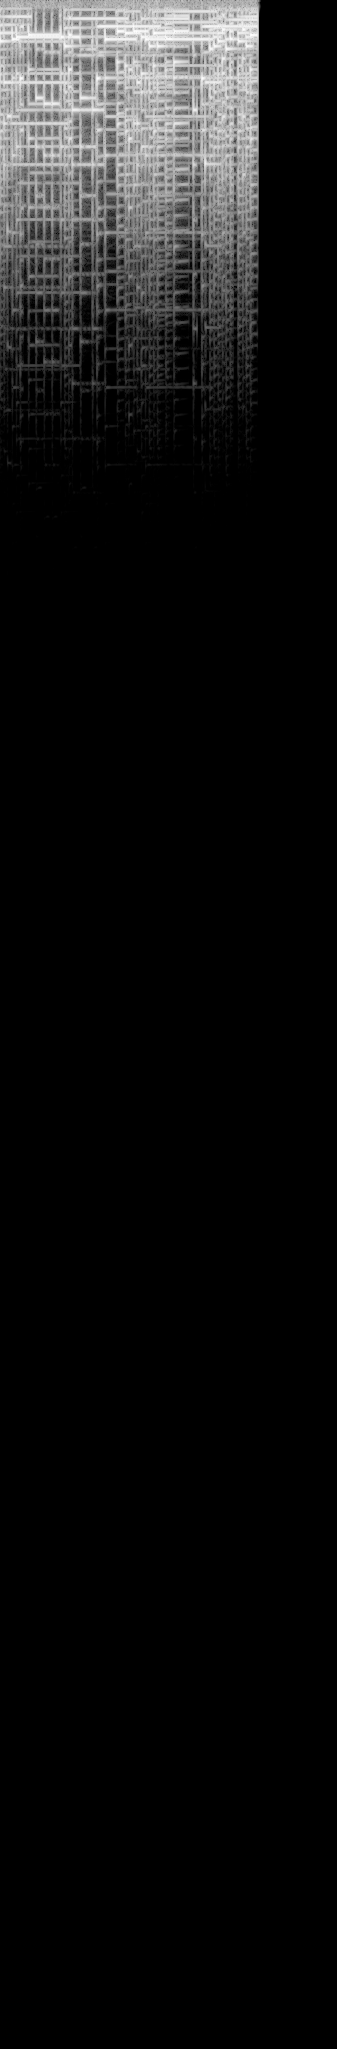

In [94]:
import numpy as np
from scipy.signal import spectrogram, butter, filtfilt
import matplotlib.pyplot as plt

# Sample rate and data (assuming these are already defined)
sample_rate = 44100  # Example sample rate, replace with your actual sample rate

wav_file = 'WAVs/aJeuxrCbHezLmfZGzAih.wav'

# Load the WAV file
sample_rate, data = wavfile.read(wav_file)
print("Sample Rate of .WAV file:", sample_rate)

# If stereo, convert to mono by averaging the channels
if len(data.shape) == 2:
    data = data.mean(axis=1)

# Define the band-pass filter
def bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply the band-pass filter
lowcut = 70  # E2 frequency in Hz
highcut = 1700  # E6 frequency in Hz
data = bandpass_filter(data, lowcut, highcut, sample_rate)

# Calculate the spectrogram with a larger FFT window size
nperseg = 4096  # Larger window size for better frequency resolution
noverlap = int(nperseg // 1.5)

frequencies, times, Sxx = spectrogram(data, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap)

# Convert the spectrogram (power spectral density) to decibels
Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Adding a small number to avoid log(0)

img_array = np.uint8(255 * (Sxx_dB - np.min(Sxx_dB)) / np.ptp(Sxx_dB))
    
# Convert to Image and save as PNG
image = Image.fromarray(img_array)

image


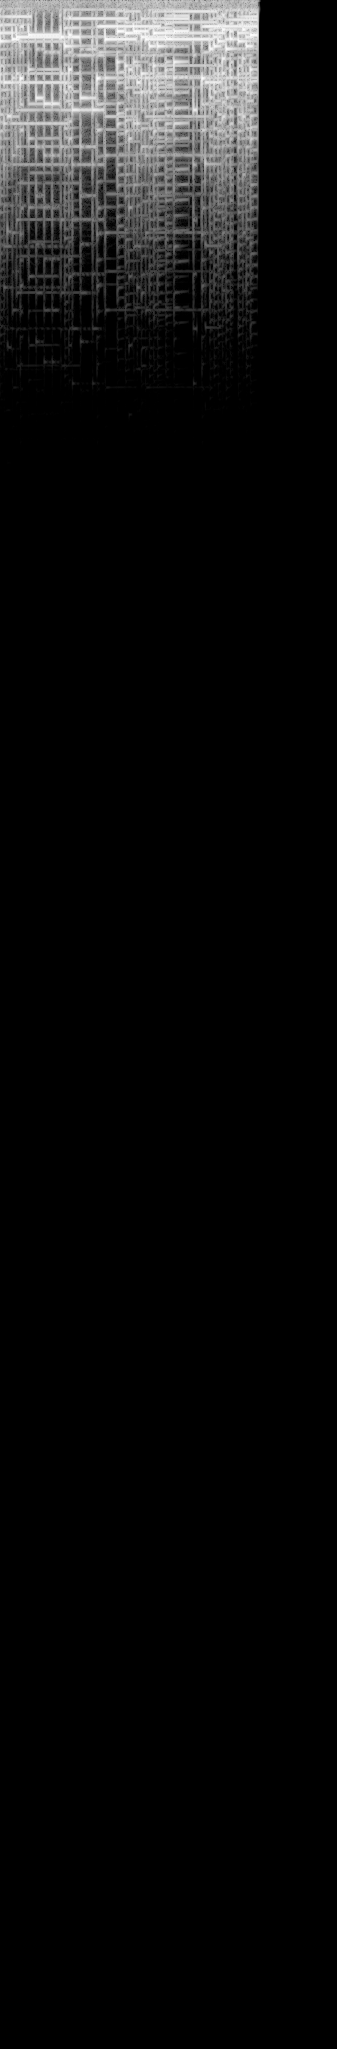

In [75]:
image

In [92]:
for item in img_array.T.tolist(): print("\t".join([str(x) for x in item]))

174	172	188	197	190	175	186	180	209	217	213	207	198	179	203	215	221	210	187	177	198	205	203	205	224	231	221	203	195	204	214	220	239	241	228	220	222	228	234	241	248	246	237	219	209	196	185	179	192	202	198	182	173	165	166	176	196	205	200	189	194	199	202	204	206	207	215	212	211	212	213	211	210	222	227	222	216	213	214	216	220	223	218	209	196	195	197	199	202	196	199	199	194	192	191	192	194	195	194	189	179	169	161	151	145	167	184	186	186	190	194	198	203	212	214	205	177	163	183	189	196	202	203	197	184	171	173	170	172	185	207	212	204	192	181	188	198	204	205	197	182	184	183	178	173	186	197	199	192	179	178	177	173	169	163	146	155	147	144	145	146	154	152	148	162	163	161	162	162	164	170	174	174	167	157	156	159	165	166	156	154	162	158	151	146	141	154	163	159	143	151	151	151	153	154	147	144	148	144	145	146	148	150	152	151	141	122	113	83	121	137	147	149	143	128	114	99	90	96	106	107	100	85	92	98	103	109	110	107	115	113	107	107	108	109	115	123	122	112	109	106	105	110	117	119	116	111	112	113	111	111	114

In [90]:
string = '''2	183	142	176	179	175	179	180	171	175	166	192	159	189	165	175	166	175	175	142	183	184	171	184	172	181	182	179	161	160	176	191	152	128	126	174	160	155	159	171	179	180	169	176	181	186	196	185	182	161	185	185	179	189	154	184	178	172	184	177	174	164	196	165	173	178	175	185	190	162	182	152	176	195	186	148	172	188	155	179	133	147	160	169	164	161	168	165	163	175	139	176	177	171	165	147	171	167	153	176	176	178	156	183	183	183	187	190	172	182	180	180	183	181	131	165	159	172	201	197	168	189	163	174	192	179	194	191	166	192	169	170	186	186	180	173	171	186	197	196	194	162	160	170	187	198	152	172	187	187	188	153	197	167	185	192	202	193	174	193	186	151	175	172	185	136	160	159	171	185	190	189	178	181	130	178	169	175	183	164	158	171	196	166	158	188	164	188	189	177	115	155	145	186	162	166	193	189	195	148	189	184	124	177	165	187	163	184	166	142	180	160	170	180	166	185	171	84	176	181	152	184	171	187	189	198	149	175	182	188	173	189	195	178	176	160	173	187	190	186	148	186	199	193	184	189	184	172	170	185	161	190	193	195	186	168	176	173	164	97	48	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
202	186	180	190	191	176	187	186	165	182	181	197	196	197	183	178	177	203	195	199	192	194	194	183	181	188	191	184	189	188	194	189	177	188	180	172	185	182	192	181	175	179	194	179	198	203	198	201	159	164	185	195	196	197	191	188	185	194	192	184	188	196	199	192	187	178	184	195	200	191	192	169	191	198	198	193	188	193	192	190	181	167	171	182	175	170	180	182	168	181	164	187	187	187	181	173	177	174	187	193	190	188	190	195	195	188	193	190	170	180	178	184	198	202	184	186	191	211	208	202	174	193	186	188	206	210	196	185	192	197	197	192	193	194	187	180	176	198	204	205	205	193	172	182	196	205	190	183	203	200	200	177	195	163	195	208	198	199	201	193	186	202	187	193	188	174	182	188	182	191	199	188	192	162	177	202	200	189	193	183	187	187	196	190	184	199	198	191	190	170	176	180	187	195	185	189	202	199	202	190	180	185	185	180	178	199	199	189	196	172	184	187	188	162	203	201	180	187	200	170	191	197	196	194	197	202	201	187	188	194	194	202	198	173	189	169	196	192	192	191	197	191	201	201	195	189	194	182	178	179	201	204	205	200	180	178	187	174	159	90	42	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
205	180	188	176	192	191	177	179	185	186	166	198	175	196	177	194	199	208	206	206	183	186	192	183	171	180	180	179	172	198	199	189	188	159	192	174	185	188	193	181	183	169	193	195	198	206	193	206	193	185	194	193	198	196	186	190	202	198	161	186	187	192	191	200	196	184	176	188	193	192	191	182	187	186	191	196	190	178	199	184	181	186	189	189	176	170	180	182	183	177	170	186	177	184	186	188	148	187	193	199	183	185	195	192	196	193	192	177	180	174	170	156	200	202	184	197	185	209	195	198	199	197	188	194	207	208	190	184	192	194	193	186	191	192	188	183	192	196	196	204	196	191	190	188	178	204	195	177	194	197	191	168	187	177	195	208	191	175	182	187	162	203	192	183	181	183	186	202	183	194	188	179	198	198	188	193	197	200	201	181	192	188	190	190	194	189	191	181	182	183	184	192	200	188	192	197	201	188	192	192	182	188	198	201	197	200	189	171	197	194	187	196	196	188	206	203	187	187	202	190	187	181	185	186	201	206	205	188	194	201	205	201	185	188	197	183	191	194	195	198	185	188	187	196	200	182	197	180	194	189	202	197	208	206	187	188	187	168	93	60	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
202	189	192	185	161	192	163	182	189	179	176	196	200	196	186	191	194	201	200	200	201	187	186	184	168	167	170	181	187	197	191	180	194	193	192	189	187	183	183	166	185	182	175	195	182	190	204	206	195	165	198	184	188	192	193	199	196	187	181	179	177	181	192	187	194	187	177	181	193	201	197	186	174	179	183	189	183	190	196	183	174	187	175	182	178	152	165	170	179	153	179	174	173	167	179	178	193	195	185	195	175	148	191	189	199	197	176	188	185	181	174	178	192	196	194	202	190	200	182	183	199	202	198	191	187	195	181	193	195	179	199	196	175	151	198	197	194	180	184	199	174	180	191	187	187	200	185	190	192	192	174	184	193	157	196	199	193	194	191	188	199	198	188	186	169	189	194	207	201	188	171	190	185	201	178	162	182	193	196	198	197	178	177	167	185	176	188	186	189	184	178	189	193	195	190	190	183	179	174	177	182	193	184	200	181	191	170	182	185	197	200	200	186	182	202	201	187	187	199	184	182	182	194	189	203	194	206	195	199	202	200	175	193	195	197	175	171	176	198	197	191	181	175	194	198	187	196	201	196	190	194	169	200	203	192	190	182	168	106	65	11	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
189	197	193	176	189	184	178	177	188	183	178	191	188	190	183	159	189	199	182	193	197	184	164	170	174	161	181	186	196	199	186	173	186	187	177	191	175	169	179	178	169	171	182	181	192	192	182	201	181	191	194	186	176	181	191	183	180	177	163	140	187	181	182	187	179	190	192	187	202	204	190	157	174	182	181	189	184	192	180	184	180	188	181	157	172	163	169	170	176	169	173	179	183	176	173	181	197	201	182	174	179	175	184	175	196	182	185	189	176	180	186	188	190	188	193	200	169	193	188	189	182	191	192	165	184	172	193	182	182	186	201	192	171	182	200	193	184	187	192	199	190	178	188	183	181	198	187	195	187	187	167	182	193	194	197	189	189	202	195	197	205	194	187	187	174	190	182	204	187	193	191	178	180	199	159	182	180	185	172	191	188	176	179	180	183	183	172	195	192	165	175	187	172	186	176	170	163	176	176	178	179	186	194	200	166	190	176	170	184	195	183	194	187	173	199	190	168	205	204	184	183	155	198	195	198	182	196	202	190	183	192	182	193	181	185	184	189	191	191	187	187	161	183	193	183	184	189	200	194	192	188	180	197	184	197	198	187	172	126	72	19	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
177	186	189	185	191	173	179	190	191	193	184	184	178	184	167	156	180	191	192	202	195	186	182	156	176	182	173	198	197	198	191	181	187	180	190	187	169	111	183	176	172	171	187	180	196	197	192	199	186	181	194	184	196	193	185	174	161	186	176	178	191	190	170	183	187	179	187	190	201	194	185	193	185	179	184	182	173	184	176	180	171	181	186	162	179	178	178	162	180	175	174	155	188	165	149	181	195	204	182	184	188	179	179	169	172	188	171	196	192	195	170	193	197	185	182	191	189	194	197	199	185	194	184	175	190	198	193	181	182	191	189	194	193	177	191	185	161	145	168	196	188	189	184	184	174	200	187	193	177	151	179	165	194	198	204	184	195	204	145	200	180	200	198	187	176	186	177	204	201	202	189	167	171	201	192	179	167	170	176	180	183	188	191	176	195	190	186	193	189	152	182	187	191	179	156	175	164	185	188	174	191	162	187	204	192	188	178	185	185	193	167	189	196	196	192	172	181	207	207	177	181	174	196	194	198	182	176	188	192	186	197	183	182	180	138	133	187	200	194	189	188	176	170	190	193	180	188	192	192	189	184	186	189	193	193	198	145	178	143	86	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
197	173	164	179	191	160	186	192	182	186	179	183	177	190	187	173	184	187	174	199	189	185	184	160	174	186	187	186	205	196	182	191	179	187	177	178	185	184	174	162	150	185	183	186	185	186	175	193	180	187	191	164	195	189	180	191	177	190	188	189	166	190	142	187	192	173	172	172	196	186	190	196	158	184	185	178	188	179	190	181	164	181	187	162	173	182	175	174	184	168	175	157	188	181	171	169	197	201	189	189	187	148	172	159	187	199	195	190	200	192	192	182	190	168	182	191	192	189	199	203	179	195	180	186	167	201	188	194	192	194	193	204	201	188	167	188	187	182	153	198	197	197	188	182	182	204	199	187	191	184	187	198	198	203	193	192	182	201	192	189	198	203	198	191	192	184	184	201	195	196	195	182	187	198	183	175	151	159	184	154	186	195	189	188	200	166	187	185	185	154	181	198	199	192	180	165	178	174	192	174	192	190	195	202	155	179	187	178	179	174	189	184	192	205	186	176	199	191	208	176	194	183	195	180	199	197	185	151	191	186	194	181	161	172	174	175	186	180	205	176	187	176	169	176	194	197	201	194	192	175	189	194	189	197	186	192	191	172	158	97	36	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
188	203	194	160	197	143	192	194	191	203	200	194	197	193	202	195	179	201	190	191	201	198	199	190	190	195	198	200	195	198	198	199	167	185	185	179	183	186	169	181	179	182	178	181	171	177	189	177	187	179	191	168	189	167	189	193	176	193	176	189	188	184	181	199	200	171	180	177	197	195	162	190	188	176	182	182	191	185	194	179	166	176	184	181	175	182	175	180	187	184	176	159	186	174	168	170	192	181	196	191	175	165	176	190	202	205	189	177	197	183	190	185	179	192	195	189	191	193	193	182	199	185	189	190	169	200	203	196	182	181	194	197	196	188	169	182	199	191	176	199	204	185	185	177	190	200	193	172	189	197	184	200	190	202	188	176	185	199	173	175	195	188	186	177	188	193	203	208	204	182	205	180	197	177	186	188	179	183	185	174	165	191	162	188	196	198	192	165	182	176	188	190	192	189	182	156	182	189	193	173	186	179	196	191	187	194	192	182	198	198	189	173	196	206	172	193	191	207	196	201	197	195	195	190	201	200	184	186	184	202	204	199	196	177	177	179	194	203	198	206	196	174	155	187	199	202	192	208	190	187	172	204	200	200	199	190	201	181	166	100	40	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
212	216	206	201	203	196	203	207	209	211	211	209	204	206	210	208	205	206	205	204	207	208	208	204	205	205	208	206	185	201	206	201	177	174	187	188	175	181	178	181	181	162	177	177	181	182	184	168	181	183	191	182	176	177	181	188	179	186	185	183	187	188	177	197	193	196	201	177	202	189	182	198	200	203	198	197	206	195	201	198	194	194	197	190	199	188	202	194	199	190	194	193	200	196	198	193	200	169	203	195	196	193	199	175	209	186	195	198	200	198	195	194	197	193	201	186	189	195	195	192	206	147	201	196	208	203	204	192	186	161	179	179	186	187	182	177	197	196	188	186	194	191	189	179	190	155	190	173	199	179	197	190	206	193	197	194	206	189	197	184	192	191	180	195	204	202	213	216	184	212	203	204	208	198	199	185	197	195	199	197	191	200	193	195	197	203	187	200	197	185	178	153	162	181	176	172	185	190	186	144	180	194	187	176	180	191	181	186	201	205	194	184	185	203	197	205	196	212	213	214	199	203	202	204	209	209	204	188	195	208	217	214	200	193	187	183	194	208	208	216	204	192	180	201	202	212	200	208	210	200	188	209	207	212	205	210	204	198	168	95	37	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
218	213	197	200	189	195	198	203	201	200	201	203	189	199	198	205	196	196	191	202	198	195	199	188	199	195	200	201	182	194	194	196	176	165	172	182	190	187	177	167	159	168	177	186	178	174	171	168	180	189	183	157	168	173	172	167	178	176	185	166	198	192	175	193	208	213	211	207	208	204	206	210	213	213	210	210	213	212	211	208	207	207	207	206	208	207	210	208	208	207	207	208	210	209	209	207	205	204	209	208	208	207	208	206	208	208	208	206	208	208	206	207	208	206	207	197	202	209	215	210	208	211	195	217	220	207	209	205	190	175	187	187	187	181	191	155	192	193	183	183	178	193	181	174	194	196	187	176	204	210	214	208	213	204	202	209	211	211	212	207	204	205	203	208	215	202	210	215	213	215	207	211	216	213	207	203	209	205	210	209	208	210	205	211	207	210	210	208	207	177	179	182	173	190	187	182	186	183	185	180	189	194	187	185	188	184	178	183	191	206	202	208	197	208	209	214	185	197	222	215	192	207	189	200	197	211	197	208	202	192	217	205	205	208	210	210	211	191	220	219	192	206	194	205	193	216	214	212	205	202	200	213	210	219	185	212	191	203	166	86	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
213	193	175	199	193	173	174	180	165	163	180	197	197	153	179	197	191	172	169	186	187	174	178	182	176	159	167	194	187	188	165	184	152	165	163	163	186	179	168	175	171	150	171	185	181	149	163	151	179	174	164	171	176	170	165	161	175	169	161	194	200	190	170	196	211	216	201	199	203	199	200	204	206	202	200	197	203	202	203	196	198	199	198	196	199	199	199	199	199	197	197	200	200	198	198	195	191	202	201	198	197	197	199	202	177	207	198	196	197	199	199	197	196	197	199	205	213	199	222	218	215	220	211	220	218	200	211	203	210	209	209	207	209	211	213	208	214	214	209	211	201	183	158	175	198	195	180	173	201	216	214	191	214	204	202	217	200	221	196	214	205	213	208	212	218	220	210	202	218	215	207	220	207	222	219	215	222	214	222	221	220	224	218	225	221	223	225	219	225	222	222	222	222	223	223	223	223	223	223	222	222	221	223	222	222	222	222	223	224	224	205	225	224	224	202	226	219	210	217	205	202	203	203	186	186	210	215	212	200	195	214	203	210	210	211	211	208	209	220	212	206	209	206	199	202	207	216	214	196	185	208	210	217	212	208	209	204	205	167	78	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
206	169	178	202	194	164	161	174	158	160	173	197	192	173	176	193	176	173	175	187	187	168	173	174	157	142	166	189	185	187	175	185	167	147	151	181	184	162	161	162	165	147	144	172	176	161	166	149	171	167	150	167	176	165	159	152	172	158	175	197	184	181	162	193	206	205	179	158	194	186	170	178	182	161	156	169	169	163	163	182	179	172	162	154	153	151	146	143	156	147	150	165	170	170	152	177	180	189	129	157	153	146	159	179	197	192	163	158	158	147	165	157	150	126	164	199	221	220	218	213	212	211	210	205	216	214	219	218	217	215	215	214	215	223	217	217	221	220	218	217	208	177	169	166	197	191	184	145	190	211	199	179	215	213	219	219	217	219	214	216	216	216	216	216	220	223	219	218	219	220	221	221	221	226	226	225	225	226	226	227	228	229	229	230	230	230	230	229	230	230	229	229	229	230	230	230	230	230	229	229	229	230	230	229	229	229	230	230	230	227	223	228	231	228	224	229	226	197	206	157	182	177	203	191	192	201	214	195	192	204	209	194	195	188	187	185	193	205	211	172	194	206	214	197	176	195	210	201	199	208	150	215	219	207	213	214	207	209	169	68	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
198	170	181	198	181	157	166	174	165	155	170	189	178	169	175	188	192	184	184	190	190	171	150	176	153	159	174	173	202	185	168	192	168	148	155	192	192	162	153	154	158	149	159	184	185	162	160	142	153	161	159	181	188	161	150	159	168	163	150	188	191	188	166	195	210	195	152	175	199	190	157	181	173	167	146	157	150	147	142	188	195	174	140	137	148	134	152	141	102	133	139	170	175	167	153	179	184	186	159	145	149	142	141	178	188	180	152	155	160	145	154	162	157	142	143	198	219	205	197	176	179	175	173	194	216	218	211	206	206	196	201	203	199	221	191	200	210	204	203	205	199	193	172	165	191	164	173	181	203	209	185	181	216	220	214	204	205	207	208	201	202	200	200	201	200	210	209	204	203	206	206	207	200	213	214	210	210	211	212	213	213	214	214	215	214	215	215	214	216	213	214	214	215	214	215	215	215	214	214	214	212	216	215	214	214	215	215	215	213	215	212	213	214	216	212	214	219	215	196	151	185	191	205	192	195	203	207	171	176	203	183	186	172	177	146	162	168	204	200	174	185	215	217	187	169	202	207	177	188	217	218	218	215	214	213	213	216	213	171	57	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
174	167	178	192	162	118	161	176	138	159	168	184	193	168	171	190	204	174	179	188	188	152	175	181	160	137	175	204	212	187	177	196	170	134	159	196	193	149	145	160	144	146	157	193	193	165	149	147	140	149	154	192	193	160	129	132	158	133	166	191	201	193	158	195	206	187	153	181	197	194	147	186	184	166	143	149	142	133	145	192	198	171	126	143	145	116	136	142	132	129	146	179	191	175	137	184	178	185	117	129	151	149	146	175	189	191	161	159	155	143	134	157	161	133	151	197	210	202	193	161	159	122	152	191	215	184	193	184	174	186	136	184	215	215	186	166	190	170	159	176	195	199	181	171	183	194	175	174	208	205	173	178	214	202	198	144	196	205	184	162	176	155	165	152	195	206	195	174	154	173	162	182	207	204	203	182	167	178	164	177	165	178	171	179	175	178	169	180	184	190	170	167	178	192	180	164	169	169	170	168	190	184	190	166	177	178	156	170	191	207	197	170	193	208	197	169	196	209	183	168	188	211	221	203	211	215	202	163	174	205	202	178	180	187	154	136	168	198	174	177	184	213	211	181	167	200	202	173	187	218	215	203	195	192	190	187	196	213	173	47	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
203	170	185	194	179	155	174	169	166	171	181	192	204	181	186	206	211	185	180	199	197	171	175	167	173	174	183	213	213	183	184	207	175	137	164	196	188	148	139	148	141	139	155	196	192	128	131	134	134	127	155	195	193	141	113	137	148	145	156	204	213	194	134	192	194	184	141	187	173	197	157	196	198	167	142	152	145	137	140	192	195	164	140	131	141	135	147	125	144	117	143	184	197	177	135	190	199	186	148	150	125	132	148	182	198	201	151	142	148	138	139	143	151	148	128	196	188	206	188	158	152	146	151	190	206	204	189	184	197	187	148	178	210	208	181	173	194	175	157	173	197	199	183	174	190	204	178	178	205	187	176	178	206	206	195	164	203	194	179	158	177	153	136	147	204	219	202	198	200	202	204	207	216	220	218	207	203	198	197	201	204	206	207	207	207	207	207	208	210	194	145	147	187	196	172	156	154	150	146	149	191	199	184	148	171	183	165	148	185	204	192	136	184	201	188	152	192	203	203	159	192	210	229	230	224	201	195	144	180	214	216	195	202	193	144	142	175	205	204	176	183	201	205	182	171	193	188	181	183	213	192	187	165	194	179	166	196	216	175	41	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
215	199	203	210	202	210	211	214	214	215	218	216	213	219	220	224	211	220	218	223	219	220	219	221	219	219	220	208	226	219	221	218	171	128	163	192	172	148	150	136	141	144	163	195	186	149	113	137	128	121	150	194	187	152	123	144	144	135	156	208	216	192	145	187	196	187	138	191	210	202	171	198	201	149	152	140	141	154	154	193	187	155	150	147	151	157	154	151	149	157	156	186	197	168	159	190	201	183	147	145	157	155	154	189	211	205	153	139	139	156	156	158	159	157	153	193	205	204	180	143	152	153	146	188	188	204	183	189	206	186	137	177	194	204	174	168	198	190	164	178	199	196	184	173	207	211	177	180	198	192	180	179	198	201	194	167	206	198	185	129	176	154	133	157	207	222	218	215	218	220	222	223	214	218	232	229	224	221	221	222	224	225	226	226	226	226	227	227	223	198	138	128	190	195	160	118	128	137	136	142	193	201	181	148	167	180	165	131	175	192	183	144	174	200	188	156	193	214	215	200	210	198	223	235	217	196	181	138	185	217	222	215	214	196	141	143	179	214	217	198	199	208	216	207	212	218	216	214	214	222	211	219	219	217	220	219	222	222	177	38	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
221	215	219	222	222	224	226	228	230	231	232	229	230	234	234	233	231	234	234	235	234	234	234	234	234	234	234	232	234	234	234	222	174	100	164	191	161	129	145	141	138	141	160	191	173	140	122	136	135	125	158	191	175	143	134	146	136	126	160	206	212	185	141	195	209	191	164	194	220	220	210	215	196	169	173	171	173	168	173	192	177	164	170	170	170	164	171	172	171	170	167	191	190	168	171	188	198	173	170	171	165	169	173	196	216	202	165	173	170	171	170	168	169	167	172	187	201	196	184	174	170	168	173	181	204	204	171	194	214	180	137	178	195	206	178	164	200	190	149	170	207	210	187	163	212	213	182	183	166	205	177	177	201	206	193	173	208	208	183	164	185	144	166	161	205	214	209	211	215	217	217	218	214	215	232	227	220	218	219	220	221	223	224	224	223	223	223	223	225	202	134	136	189	190	155	128	132	132	129	143	195	194	174	146	161	167	157	152	177	197	187	137	147	207	200	155	196	220	221	214	219	219	216	229	216	207	189	152	188	210	213	206	212	197	151	157	181	216	221	216	219	225	227	224	226	231	233	231	232	232	231	233	234	232	234	234	233	224	178	34	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
210	205	212	216	217	216	218	221	224	225	225	218	226	227	226	223	227	226	227	227	226	226	227	227	226	227	226	227	223	227	227	220	173	114	165	194	180	155	122	126	106	131	160	189	164	119	137	140	126	137	152	190	170	118	144	143	112	95	157	195	205	163	141	203	219	203	202	207	209	234	232	208	218	216	217	218	219	220	220	218	220	220	220	220	220	220	220	220	220	220	220	219	222	220	220	222	217	220	220	220	220	220	220	222	218	222	220	220	220	220	220	220	220	220	220	220	219	221	221	220	220	220	220	220	218	220	220	223	218	162	149	174	203	206	179	151	201	193	157	173	204	223	212	207	216	196	207	210	218	218	199	201	214	208	210	213	201	217	200	203	200	209	210	213	217	216	215	218	218	218	218	218	218	221	228	224	222	222	222	220	219	218	217	218	219	220	220	221	227	203	104	135	187	182	145	129	139	136	126	137	193	194	165	148	165	154	161	125	188	209	197	163	180	215	211	201	210	211	212	219	216	221	208	213	220	217	200	168	190	174	193	190	200	197	174	174	175	207	210	201	212	218	218	216	215	225	229	225	222	228	225	221	232	217	226	226	225	219	178	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
187	187	183	202	192	171	170	173	185	185	193	201	201	187	187	185	203	183	182	191	159	176	176	187	183	183	189	200	201	183	190	212	171	116	162	196	189	160	150	140	135	129	156	192	180	150	126	136	133	131	153	192	182	154	127	141	118	126	152	178	203	174	144	204	220	217	217	221	223	236	236	227	229	232	233	233	234	234	234	233	233	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	234	235	233	233	234	234	234	234	234	234	234	234	234	233	235	235	234	234	234	234	234	233	232	233	234	233	218	161	139	176	198	196	177	138	201	199	162	174	187	228	231	225	226	223	224	226	225	221	216	219	223	224	225	226	224	222	216	217	218	222	224	227	230	230	231	233	233	234	234	234	233	235	236	234	234	234	234	234	234	234	234	234	234	234	234	234	230	203	140	145	187	180	144	153	146	147	143	147	195	181	178	130	164	178	166	149	193	217	206	199	205	221	219	216	216	219	224	224	225	203	207	188	199	217	211	198	200	213	209	209	210	216	214	215	216	217	218	217	218	219	218	217	219	214	228	223	208	231	225	221	234	210	219	219	220	217	178	22	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
177	171	179	205	195	151	158	177	168	158	177	196	196	169	168	197	201	162	185	201	196	173	180	192	167	150	173	203	205	177	185	200	172	102	156	196	188	143	141	136	117	132	158	195	189	161	150	124	131	126	154	195	191	162	149	129	115	131	157	192	205	182	129	201	210	202	211	214	226	220	220	222	224	225	226	226	226	226	226	226	223	226	226	226	226	226	226	226	226	226	226	227	225	226	226	224	229	225	227	226	226	226	226	226	224	228	226	226	226	226	226	226	226	226	226	225	228	231	226	226	225	226	226	227	225	224	227	226	213	176	142	175	175	170	180	162	202	198	160	176	191	226	228	221	219	222	219	220	210	209	203	212	215	222	211	218	221	210	202	212	210	215	216	218	225	219	226	226	226	226	226	226	225	229	226	226	226	226	226	226	226	226	226	226	226	226	226	226	225	202	160	158	187	188	168	158	155	160	160	161	195	197	193	156	162	179	162	163	192	218	218	216	219	212	207	208	206	218	214	217	219	214	206	172	192	210	219	216	220	227	227	226	229	231	231	232	232	232	233	234	233	233	231	233	234	231	235	233	230	237	232	232	239	234	234	234	233	222	178	23	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
198	146	186	204	186	143	162	173	162	145	170	197	199	154	175	204	201	150	184	205	203	182	181	193	163	151	167	198	197	172	178	195	168	122	150	195	189	152	126	124	126	130	155	195	188	148	147	134	128	133	150	194	190	145	145	113	114	127	151	192	204	183	149	191	183	189	182	167	212	204	165	180	193	179	183	182	181	179	177	189	190	173	176	176	176	176	177	178	178	178	178	190	190	184	180	192	210	194	179	179	175	177	180	153	196	199	178	177	176	178	177	178	177	178	177	193	211	228	225	217	212	205	204	208	209	219	192	198	204	180	149	172	195	194	192	155	205	185	177	185	197	221	202	177	185	206	184	187	201	191	188	171	202	220	207	182	207	179	188	182	193	164	181	182	206	212	191	182	192	193	190	183	193	211	174	191	186	176	186	193	194	191	181	179	189	193	193	188	203	203	187	187	199	181	190	187	189	187	187	187	197	210	191	190	192	186	188	188	193	214	208	211	209	199	159	194	207	214	195	162	197	197	203	162	192	213	208	210	214	224	221	219	225	226	226	227	228	224	229	227	228	229	218	230	228	227	227	227	228	229	224	229	228	230	228	228	228	221	177	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
205	164	190	202	153	151	163	179	160	145	175	203	199	134	177	200	196	152	183	198	200	170	185	198	162	155	172	184	169	176	173	190	166	115	145	196	194	154	124	125	125	98	146	194	188	148	129	106	114	120	144	193	190	148	136	112	108	110	150	182	198	180	140	189	181	180	155	177	202	199	157	172	182	162	153	155	158	156	152	185	199	170	151	153	151	153	160	164	163	161	159	188	196	163	160	193	200	196	174	162	151	155	157	184	206	195	161	145	161	159	167	165	160	163	149	186	199	220	225	222	217	211	208	204	208	227	221	210	209	205	201	205	205	199	200	212	218	213	214	215	215	212	185	173	201	202	160	144	194	180	177	173	205	225	224	214	212	197	200	204	212	210	209	210	200	219	216	214	214	216	216	217	214	222	220	219	219	220	220	220	220	220	220	220	220	219	219	219	216	221	220	220	221	217	220	220	220	219	219	219	216	222	221	220	220	219	220	220	218	221	217	220	218	223	220	220	219	205	203	162	187	204	201	96	195	206	190	187	178	210	206	186	198	191	191	190	191	208	211	185	190	212	225	203	187	182	186	179	193	199	214	199	163	201	188	187	195	214	176	10	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
203	177	189	207	179	170	163	144	166	169	183	202	196	160	177	186	181	169	182	190	197	170	192	202	158	150	169	181	184	181	166	188	165	133	158	199	197	146	131	113	109	105	141	194	193	152	131	128	99	127	145	193	194	152	130	117	115	118	150	179	186	178	145	197	198	181	151	178	203	194	143	180	188	146	145	138	131	139	144	193	203	175	145	138	143	144	150	142	129	131	138	184	194	154	152	196	186	195	158	149	153	158	150	187	202	192	162	153	158	154	152	157	148	158	149	188	207	199	204	204	199	191	184	192	206	223	227	222	218	211	209	211	207	216	218	217	222	217	218	219	205	206	178	177	200	198	159	159	196	197	171	175	190	220	227	223	213	212	210	211	217	212	214	215	217	208	227	197	228	209	227	216	223	227	223	223	223	223	223	224	224	224	224	224	223	223	223	223	222	222	223	223	222	223	224	223	223	223	223	223	220	224	225	223	223	223	223	223	222	222	222	222	223	226	223	224	221	209	202	177	186	210	200	183	198	201	169	168	162	211	205	218	220	204	170	169	170	208	206	172	172	221	233	208	185	200	186	169	187	212	226	215	203	200	194	192	200	206	174	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
205	207	212	205	205	200	203	206	206	207	207	200	207	201	196	197	191	195	197	201	204	185	201	207	176	184	178	201	208	191	179	192	162	126	164	201	195	144	126	117	120	126	149	197	197	151	103	101	114	99	150	195	198	156	125	123	118	112	152	184	185	178	128	199	208	181	125	180	205	186	115	191	193	156	129	97	120	95	144	198	203	173	137	132	132	132	130	141	144	139	129	180	196	166	150	196	207	194	150	170	164	173	169	185	194	185	173	168	169	172	168	170	168	170	167	193	215	213	175	148	170	175	162	185	197	199	212	213	205	195	195	184	220	229	210	188	216	194	200	198	208	203	174	177	193	189	169	178	193	202	174	179	194	194	213	212	194	211	196	181	212	190	194	195	211	221	233	229	230	221	227	221	221	215	201	204	204	204	204	204	204	205	204	204	203	203	202	202	207	199	204	204	202	208	203	203	203	203	203	203	207	212	204	204	202	207	204	201	208	201	197	204	197	216	191	202	210	215	206	208	207	185	212	200	208	210	184	168	165	215	228	232	227	205	172	170	154	207	201	206	209	221	236	213	204	189	212	208	208	193	227	225	224	209	208	214	210	205	173	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
224	229	224	212	220	222	224	225	226	226	225	223	221	220	218	215	209	211	209	179	199	205	209	218	199	196	196	212	221	208	202	196	159	117	172	201	187	141	107	130	111	107	159	199	197	139	122	125	113	115	156	198	198	152	124	121	129	115	155	163	198	188	136	199	210	186	153	183	205	179	149	198	201	166	140	136	139	137	145	201	199	167	136	141	139	124	147	156	154	148	146	182	199	174	152	197	213	177	164	195	200	192	189	189	189	196	194	195	194	193	195	193	194	193	193	199	210	219	189	190	192	191	191	193	210	202	195	195	184	195	190	190	216	235	209	195	218	196	194	188	193	208	193	190	188	193	186	195	206	204	191	185	212	207	201	193	195	202	197	195	219	188	144	142	200	226	227	222	217	216	213	214	205	206	181	152	167	164	169	165	164	158	166	167	168	164	164	167	186	184	168	168	182	197	173	169	167	167	167	169	196	212	187	171	198	196	196	186	181	211	183	196	198	205	208	192	198	214	226	228	228	223	227	223	225	221	185	191	194	217	228	223	219	206	191	190	187	217	222	230	227	230	238	218	223	211	226	224	227	224	224	212	229	213	218	216	210	214	174	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
231	229	225	211	217	220	221	222	223	222	221	220	216	215	214	218	184	211	206	204	215	228	227	226	193	185	193	210	226	182	198	194	152	130	175	201	173	144	120	130	135	132	166	200	192	146	129	132	127	136	156	199	193	153	116	128	122	117	158	194	209	198	137	198	209	187	173	192	207	184	168	202	202	162	166	164	162	161	157	201	196	151	152	150	146	152	152	151	150	148	147	186	201	173	151	194	208	222	226	231	236	237	237	237	237	237	237	237	236	236	236	236	236	235	235	236	238	239	234	234	234	234	234	235	236	231	233	234	232	233	234	234	236	246	233	233	238	235	234	234	234	236	234	234	235	235	234	234	234	230	234	234	233	228	234	234	234	233	234	235	228	190	168	162	184	217	201	187	164	171	157	171	196	205	194	139	155	151	120	143	153	157	156	155	149	147	136	153	193	188	147	140	192	201	170	146	151	147	149	145	197	211	222	226	232	236	237	237	237	240	237	237	237	233	236	236	236	235	244	230	239	231	233	236	235	240	233	234	234	234	232	234	233	234	234	234	234	237	225	238	238	235	236	229	240	230	239	226	239	227	238	229	238	228	236	231	236	223	175	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
221	206	205	213	202	190	192	185	194	191	185	206	202	169	182	211	217	186	186	199	227	235	237	226	126	155	173	218	229	200	161	186	149	114	178	203	184	148	131	129	134	130	170	200	180	146	134	118	123	117	165	199	184	143	132	135	137	131	162	206	220	204	138	199	179	207	208	206	196	203	205	184	215	206	206	204	202	200	197	210	197	189	187	184	181	180	183	184	184	184	185	198	195	189	184	199	212	231	237	239	243	244	245	245	244	243	243	244	243	243	242	243	242	242	242	241	244	246	241	240	241	240	241	240	240	240	241	241	239	240	241	241	243	250	244	241	244	241	241	241	242	241	241	241	241	242	241	240	239	240	240	241	240	236	240	240	241	240	242	239	232	193	201	205	210	208	210	206	204	202	199	199	184	205	202	184	186	182	182	183	183	184	185	186	185	181	181	182	191	190	143	141	194	199	168	134	147	127	140	151	195	215	232	236	240	243	244	245	245	246	244	243	243	242	242	243	242	245	245	242	240	237	235	241	242	244	241	241	241	239	239	241	240	240	241	241	241	240	237	240	242	237	232	238	241	242	240	240	242	241	239	241	239	239	241	240	240	227	176	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
203	174	195	214	200	166	172	182	166	165	168	207	212	166	175	218	224	185	175	209	225	224	228	223	164	158	170	220	232	203	160	179	135	120	179	208	193	136	140	128	133	136	172	200	179	134	138	140	132	132	167	200	183	127	107	130	137	117	164	204	226	209	139	201	220	228	228	225	219	221	224	223	226	226	224	222	220	218	216	220	217	210	206	204	201	200	197	196	198	200	201	203	195	199	197	196	213	222	228	225	230	229	230	231	232	226	225	230	225	229	225	228	226	227	226	224	221	238	224	222	228	221	229	219	226	231	226	226	223	225	226	225	214	244	223	226	231	222	225	223	230	223	225	225	222	231	225	226	217	234	230	233	234	228	235	225	230	230	236	222	231	224	223	225	227	227	226	224	222	219	217	214	206	207	188	207	202	200	198	197	198	199	200	200	200	199	199	198	204	196	133	128	195	195	163	129	133	125	139	132	194	219	225	225	228	228	230	230	229	231	228	228	228	224	232	235	226	237	222	235	211	235	231	226	226	226	227	226	225	223	227	225	226	223	225	225	225	222	225	225	225	228	236	235	221	232	232	233	230	234	224	235	220	229	225	226	227	226	178	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
195	164	183	209	206	150	165	175	131	157	172	214	219	168	172	223	229	188	173	203	209	173	200	215	167	141	163	218	234	206	162	174	145	141	181	212	200	142	143	135	146	144	174	204	189	140	134	142	132	144	171	204	191	147	136	134	146	139	167	200	230	213	134	200	226	231	226	222	216	221	221	221	220	221	219	217	215	213	211	212	219	204	203	200	198	197	190	185	190	194	196	179	202	193	185	160	200	191	195	196	192	195	186	177	216	213	202	189	201	173	194	190	197	196	198	191	221	232	207	202	187	196	187	204	223	225	205	194	192	187	184	169	214	239	223	199	206	213	187	169	206	198	190	190	210	218	180	197	213	228	230	225	227	234	213	221	199	228	230	226	222	220	220	221	217	228	222	218	217	215	214	213	210	224	218	201	202	203	200	193	170	190	198	201	202	200	194	168	211	202	146	145	196	190	156	142	150	140	144	155	188	209	196	170	180	191	168	181	191	203	217	220	214	222	231	227	224	224	223	219	222	224	244	240	239	223	212	218	213	225	217	216	213	219	219	217	215	211	205	208	208	203	241	245	241	234	230	230	222	227	229	220	220	212	192	192	205	219	179	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
204	149	189	215	211	174	160	167	160	163	167	221	224	171	172	223	231	191	174	179	207	178	192	206	167	158	166	219	235	207	169	179	148	142	184	214	204	125	156	143	147	149	174	208	197	138	153	152	133	145	176	208	198	150	149	146	146	145	171	214	233	216	150	193	221	213	197	190	199	201	185	208	202	188	185	181	179	178	179	205	212	169	169	167	166	168	165	144	153	158	161	195	198	171	162	182	203	205	146	153	170	146	151	179	224	221	137	174	158	166	165	166	166	167	167	201	217	239	212	206	207	207	208	214	223	230	204	184	200	195	180	170	214	241	226	199	218	215	206	199	214	212	204	206	211	229	200	212	222	223	208	186	202	230	214	197	210	222	210	197	205	183	190	192	210	228	178	203	202	201	195	200	218	237	229	204	208	204	205	208	208	209	209	208	209	208	209	209	224	205	152	145	198	192	157	155	154	154	156	149	184	205	202	146	164	175	155	160	189	221	230	230	223	219	219	203	196	208	198	191	201	200	245	251	246	232	230	231	227	233	233	225	228	219	226	224	222	207	213	216	211	214	239	253	249	234	222	213	177	213	225	211	184	208	197	197	179	211	181	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
214	171	200	223	214	181	181	185	178	176	179	225	228	170	177	223	233	193	172	199	207	182	190	200	162	146	169	219	237	210	175	182	162	156	185	214	204	166	160	152	160	158	174	212	202	148	160	160	152	159	177	211	204	165	140	155	161	154	175	214	234	218	147	178	210	191	178	193	215	200	171	208	201	164	162	161	159	156	161	205	208	161	151	146	139	137	121	151	146	140	130	199	202	159	151	180	202	203	157	165	160	140	162	184	228	224	150	154	154	148	161	145	158	141	156	201	216	246	249	246	244	244	243	242	232	233	212	191	206	204	188	189	210	240	249	246	247	245	242	241	242	241	240	240	237	245	240	240	231	208	181	172	210	234	222	196	199	210	186	198	206	193	188	190	209	237	234	233	233	232	233	232	225	235	247	244	242	241	241	240	241	241	240	241	240	240	240	239	235	208	173	173	204	200	170	173	172	173	173	175	182	203	201	172	179	182	175	169	196	223	227	220	218	200	202	175	197	221	213	178	197	215	243	241	237	218	228	221	216	223	240	231	234	218	214	211	209	214	219	203	205	215	240	245	240	231	207	181	187	210	228	201	197	188	176	183	200	214	182	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
220	207	216	220	222	208	211	211	211	210	210	226	230	198	196	227	233	203	186	204	199	192	196	192	190	191	192	220	237	217	193	188	171	168	186	214	201	174	170	166	173	172	177	212	203	165	168	171	165	170	179	213	207	172	169	168	172	167	183	195	233	219	154	187	204	169	148	194	222	209	178	212	204	156	154	156	155	154	159	198	206	155	139	118	123	121	141	145	139	139	132	202	207	165	145	179	195	200	179	168	147	145	139	179	229	227	149	153	140	155	147	156	129	147	125	200	222	250	255	251	250	249	248	246	234	240	223	218	219	220	217	218	221	243	253	249	253	247	247	247	248	245	244	244	247	247	243	243	228	197	176	184	215	237	232	218	221	216	217	218	212	217	216	216	223	236	242	238	234	239	232	235	226	224	251	247	247	245	244	245	242	244	244	242	244	242	242	243	234	216	204	203	205	214	202	201	203	202	203	203	202	200	211	200	205	203	201	202	193	217	215	207	198	219	197	202	212	229	219	207	212	213	241	212	223	212	211	187	146	227	241	239	235	219	161	163	174	224	223	206	210	217	227	213	216	220	217	212	211	212	227	214	200	186	197	191	206	218	183	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
239	236	236	231	235	234	234	234	233	232	231	238	238	224	222	229	232	211	216	213	206	213	208	205	208	206	207	213	236	205	213	205	190	186	187	206	197	191	189	185	187	188	190	216	206	187	188	188	185	186	187	209	200	185	183	185	188	185	193	219	237	221	161	195	208	174	143	198	231	219	195	212	198	147	163	161	160	160	164	190	207	174	142	118	121	111	135	141	133	137	135	204	211	173	143	180	202	195	175	159	142	144	141	161	229	228	124	144	136	144	148	151	134	134	130	200	206	245	239	234	232	231	230	231	232	247	251	248	248	247	245	244	245	237	248	239	250	234	244	243	227	223	227	226	232	234	225	228	228	201	170	185	215	241	252	249	247	245	245	244	243	243	243	243	241	243	245	242	238	243	237	239	237	240	250	218	241	235	230	239	220	235	234	216	236	224	229	235	216	229	229	229	231	232	227	227	227	227	228	228	228	225	228	228	229	229	227	227	227	225	227	228	227	232	230	228	226	226	238	235	236	235	243	232	230	212	200	144	152	223	233	220	221	218	152	144	161	227	239	236	235	236	236	235	235	230	234	232	230	217	225	221	224	219	215	219	218	220	184	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
241	237	233	234	234	233	233	233	232	230	229	232	240	223	221	205	235	221	215	213	200	210	209	202	200	202	200	192	239	232	217	222	221	220	219	220	220	219	219	218	219	219	219	212	223	218	219	219	218	218	218	223	216	219	218	219	220	219	219	232	236	223	178	200	213	184	158	202	237	233	221	226	192	162	168	171	172	172	174	204	214	181	140	144	137	129	150	157	156	155	148	205	212	174	135	179	201	200	153	141	132	147	157	168	230	229	164	148	146	135	147	152	157	149	141	199	225	233	208	195	192	194	191	198	198	249	253	250	250	247	246	245	244	239	241	244	245	243	241	240	234	224	201	192	223	234	199	204	214	212	169	185	211	244	254	251	248	246	247	245	244	244	244	243	243	244	241	241	241	240	240	239	238	245	240	237	234	234	233	231	231	229	228	228	225	228	227	226	222	226	229	229	232	231	227	226	227	227	227	228	228	226	227	228	229	229	227	227	228	223	227	228	228	232	229	228	226	233	241	237	236	238	238	234	231	218	187	155	172	216	222	184	202	212	154	138	141	226	240	237	235	235	235	234	231	233	229	231	229	223	237	230	202	225	230	214	223	227	184	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
228	213	212	220	207	205	205	207	203	202	201	223	235	191	190	224	237	204	201	210	208	197	191	190	192	186	192	204	242	251	248	246	245	245	243	242	242	243	243	243	242	242	243	242	243	243	242	242	242	242	241	242	240	241	241	241	241	242	242	236	237	225	193	207	222	194	177	204	235	249	246	238	214	188	189	189	189	189	190	212	219	186	163	153	158	157	156	148	150	144	152	205	210	160	158	185	201	201	158	156	156	144	128	171	230	231	170	160	145	160	165	166	160	148	147	196	217	222	194	180	180	177	161	183	218	243	234	226	230	222	223	222	220	219	218	213	230	210	217	221	223	229	202	189	218	234	207	203	214	219	168	182	200	240	238	228	231	222	222	223	220	220	221	220	213	231	221	216	215	217	215	214	209	232	213	206	211	208	205	208	204	204	203	199	203	200	202	204	195	209	204	204	213	210	201	199	200	201	201	202	199	206	210	204	203	205	200	202	213	203	205	203	210	223	193	205	211	222	227	213	210	201	218	206	217	205	194	162	180	217	225	187	196	207	116	157	159	222	230	213	209	210	206	207	208	224	206	201	210	215	247	252	248	247	247	245	244	233	185	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
220	183	192	219	208	177	168	174	179	174	151	226	234	188	184	211	241	222	221	221	215	218	217	215	216	216	217	212	246	250	246	248	244	241	245	243	236	244	244	239	244	243	238	244	242	238	243	243	237	242	243	236	239	243	237	238	243	238	238	240	238	234	220	225	219	213	200	201	231	248	247	240	225	219	220	220	220	220	220	227	216	201	193	194	191	191	191	192	192	193	193	190	213	191	191	196	207	208	192	193	192	191	191	189	231	233	194	191	187	189	194	195	194	191	190	180	182	214	192	192	193	197	193	192	218	232	212	208	175	203	194	189	198	201	184	198	212	211	186	202	218	239	219	219	222	238	220	223	232	225	205	209	224	230	222	214	227	227	201	214	209	209	214	213	215	236	202	208	199	207	203	172	215	215	209	188	197	194	189	194	193	188	189	197	197	188	191	197	206	179	178	177	208	208	174	170	162	159	157	164	198	213	197	177	191	191	182	177	205	218	200	174	201	229	212	210	213	223	220	212	220	213	207	173	204	210	203	161	173	226	231	195	196	209	168	148	161	215	221	185	186	199	203	192	181	226	223	208	216	207	249	253	248	248	246	245	244	234	184	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
222	188	191	215	209	175	169	175	161	158	175	226	235	189	187	198	245	250	247	246	245	243	243	242	242	242	242	244	246	239	239	245	242	238	244	241	239	243	243	237	242	242	237	243	241	238	243	243	238	242	243	238	239	243	239	240	243	240	239	240	237	251	247	245	230	229	228	231	243	238	239	231	244	243	244	244	245	244	244	238	223	219	214	213	212	210	207	207	209	211	212	212	219	210	207	197	206	207	212	212	210	208	207	210	234	236	210	212	212	209	207	207	210	213	213	208	213	214	206	212	211	210	210	211	221	227	206	199	188	198	188	187	182	186	195	203	179	213	181	193	220	244	247	244	240	245	244	243	218	238	236	235	236	229	236	234	216	237	236	235	235	234	234	234	238	246	236	229	228	222	219	222	224	220	220	216	214	210	208	207	210	211	210	209	212	213	209	204	185	184	184	181	202	206	174	178	179	177	177	178	200	216	191	179	161	184	184	184	200	214	203	179	203	232	238	235	236	228	226	234	231	209	206	163	201	221	209	176	183	231	237	205	203	214	174	171	176	216	223	190	175	194	197	186	184	225	238	236	235	236	243	234	231	232	221	219	222	228	183	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
228	188	185	204	207	165	167	170	155	153	176	218	240	209	207	207	248	250	246	248	246	244	243	243	243	243	243	243	241	241	243	242	242	242	242	241	240	241	240	241	240	239	241	237	241	241	241	241	242	241	241	239	240	240	240	240	240	241	241	236	239	251	248	245	235	225	230	230	242	241	235	238	240	242	243	244	244	244	244	242	227	209	212	210	209	206	200	200	203	206	208	211	216	201	199	206	209	204	208	208	207	202	199	207	230	239	217	210	180	207	212	216	215	203	196	216	219	204	210	162	210	218	216	204	185	214	218	218	211	199	209	210	203	212	208	215	223	211	171	186	206	243	248	245	244	246	240	240	238	239	235	237	236	228	230	234	229	239	239	233	232	235	234	230	226	245	244	230	208	233	230	204	227	226	216	201	207	217	216	207	195	203	216	218	210	185	212	214	208	208	206	208	199	218	207	208	208	208	207	207	200	223	198	208	210	207	208	209	220	223	197	201	215	230	240	236	235	229	229	233	231	214	204	174	192	226	209	199	204	228	246	220	223	219	203	200	199	222	230	198	175	201	197	177	194	223	239	237	235	228	235	233	232	220	198	190	192	217	182	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
234	193	152	202	207	180	168	181	171	162	167	205	246	247	244	242	251	234	239	237	223	220	220	217	219	218	218	217	210	221	216	219	217	216	217	224	208	217	215	213	214	213	212	209	226	213	215	216	215	216	216	219	225	213	212	213	214	214	215	230	236	235	223	225	228	209	209	195	228	223	214	212	211	217	217	217	218	218	218	232	219	187	182	180	177	176	168	159	169	173	174	163	210	185	158	196	211	202	177	176	176	172	160	185	220	248	246	243	242	242	241	241	240	240	240	240	239	237	240	239	239	240	240	239	240	240	239	240	240	238	239	239	238	240	240	239	227	205	174	185	217	241	226	218	217	246	248	241	246	241	240	242	243	239	239	241	241	242	241	238	239	241	240	238	241	216	250	249	249	250	249	247	241	241	239	239	239	239	239	239	239	239	239	239	239	239	239	239	239	239	239	239	239	241	239	239	239	239	239	239	238	242	239	239	239	238	239	239	238	237	234	233	232	233	223	209	204	235	234	201	216	209	203	184	187	230	235	233	233	236	251	247	239	217	230	227	224	229	238	218	216	216	211	210	211	219	227	216	219	217	220	218	196	222	205	208	211	214	180	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
241	203	205	208	190	200	201	190	191	191	189	220	248	251	248	248	249	246	244	227	209	197	190	189	191	191	175	172	206	182	177	180	182	185	196	212	183	181	184	182	185	185	191	219	214	180	186	185	185	185	186	217	215	188	185	181	183	185	191	220	223	218	191	203	223	196	174	192	218	208	189	210	212	190	187	188	187	188	188	219	215	181	158	150	149	142	146	140	78	143	151	198	214	191	161	190	199	203	164	147	150	137	157	175	228	250	250	248	246	245	245	245	244	244	244	244	243	241	243	243	243	243	243	243	243	244	242	241	242	243	242	242	242	243	243	242	227	200	173	187	216	234	212	195	209	245	252	249	248	243	245	245	245	245	245	243	243	245	244	244	243	243	243	243	244	243	247	248	249	250	250	249	246	243	243	243	243	243	242	242	241	241	242	242	242	242	243	243	243	243	243	242	242	244	242	242	242	242	242	243	243	244	244	242	242	241	241	242	238	231	240	237	234	210	215	184	190	234	241	200	213	198	205	202	212	232	241	237	236	234	246	247	241	235	231	229	226	238	243	214	209	218	218	213	205	211	212	195	206	212	208	201	213	216	202	202	212	208	178	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
248	243	239	237	233	231	229	225	223	219	215	227	239	237	227	224	233	227	231	218	219	212	201	192	205	208	209	196	194	207	211	199	208	204	209	213	200	203	208	204	204	199	205	209	216	202	204	198	203	204	209	206	216	194	203	205	207	202	205	208	214	213	208	195	222	210	205	202	211	198	180	216	218	182	168	170	171	171	172	216	217	175	136	131	140	133	129	140	135	133	136	206	220	195	157	189	204	206	153	138	122	141	155	174	228	242	231	229	227	226	226	226	225	225	225	225	225	214	227	226	224	222	224	224	221	229	220	220	220	224	221	222	221	223	222	226	225	201	201	197	216	228	203	172	213	241	235	229	234	207	226	226	227	226	226	226	220	232	224	224	224	224	224	223	222	238	223	222	224	225	226	226	230	222	224	223	223	223	223	221	221	220	221	221	222	222	223	223	223	223	223	222	212	230	218	221	222	222	222	223	225	222	225	222	221	221	220	221	228	232	225	216	219	223	214	161	183	229	248	242	240	237	235	233	229	223	228	217	217	217	232	223	220	226	208	206	201	226	247	244	238	237	235	232	230	232	228	222	216	221	219	206	204	211	208	203	204	199	176	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
246	247	243	241	236	233	232	229	226	222	216	212	217	215	224	223	209	184	215	225	220	217	210	208	213	218	215	211	212	216	217	217	215	215	211	208	206	216	215	214	212	213	212	202	213	215	212	213	214	216	214	200	209	214	214	216	215	214	211	208	218	219	214	220	229	214	214	210	203	194	174	218	221	185	160	158	158	157	160	212	216	172	126	130	121	123	136	136	129	132	130	208	221	197	154	184	214	208	147	137	123	126	141	174	220	224	202	194	190	191	189	189	188	187	188	181	192	214	212	203	205	204	193	156	184	209	193	176	210	204	186	187	189	193	195	202	218	206	210	202	213	219	189	140	210	227	212	201	209	227	200	189	175	213	207	190	204	225	196	187	188	189	186	186	205	218	210	191	192	193	194	194	190	208	197	187	187	187	187	187	185	187	187	186	186	186	187	189	182	184	184	188	214	218	187	187	186	187	187	187	194	217	209	186	188	177	187	186	211	227	210	188	180	226	219	157	184	215	247	247	243	241	239	236	231	228	215	188	188	214	216	196	206	209	176	173	173	200	245	248	244	241	238	236	233	229	235	223	221	221	221	211	210	205	207	206	206	203	173	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
237	228	224	223	214	213	212	209	207	202	196	193	213	213	207	199	201	200	201	224	207	203	202	198	203	205	206	189	210	198	206	207	205	202	201	206	216	204	205	201	201	202	205	201	213	201	201	202	205	205	206	209	209	203	205	205	204	200	203	203	205	207	203	212	233	210	207	205	205	194	172	217	216	186	137	142	146	147	153	205	215	184	129	118	114	116	142	151	148	143	141	209	217	194	149	177	216	209	145	129	125	141	152	179	201	214	190	174	172	169	165	171	173	170	167	179	182	206	204	202	194	177	177	189	198	214	193	184	202	188	176	172	175	194	191	195	207	202	200	198	201	211	169	158	195	212	200	191	220	231	201	180	186	209	201	178	218	232	208	158	175	181	167	180	184	207	195	187	179	174	187	161	196	198	174	176	165	178	139	178	166	165	173	165	173	165	172	166	181	177	165	175	212	216	190	168	173	166	173	163	178	217	205	161	182	179	158	174	206	212	209	152	187	228	225	144	187	221	237	228	222	224	217	216	220	213	213	164	175	200	206	177	194	200	164	154	179	216	237	229	224	222	217	217	215	219	233	198	194	195	214	171	197	192	185	179	189	202	171	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
219	196	191	186	196	176	171	174	171	164	155	190	204	182	139	175	183	165	192	217	216	172	164	174	151	157	155	196	197	183	149	166	146	146	170	209	210	167	155	149	157	148	181	215	206	161	153	155	142	151	171	214	207	141	146	146	160	148	174	199	176	180	164	212	237	222	176	194	204	198	177	215	205	186	163	160	152	149	144	187	210	188	148	152	128	153	146	129	143	135	142	207	207	187	155	168	215	209	155	143	148	129	142	174	196	201	180	162	154	159	164	161	155	147	155	176	183	196	175	156	155	160	155	174	174	212	211	204	204	181	190	191	184	197	197	174	196	182	199	193	191	205	165	163	183	203	189	179	228	236	206	178	185	211	213	202	222	237	212	194	199	192	188	193	199	203	188	195	198	198	193	199	201	204	190	192	191	185	189	180	180	182	169	179	171	174	171	175	170	165	177	171	207	204	189	174	171	174	164	176	187	218	207	180	172	148	178	168	206	222	212	176	190	234	231	192	186	221	218	192	202	191	210	213	197	219	216	171	153	185	190	162	189	196	150	149	178	217	221	198	191	186	196	175	171	229	235	196	167	192	210	192	192	202	154	148	179	197	168	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
209	179	170	181	185	169	168	174	154	149	166	189	191	165	167	188	192	170	190	196	214	173	160	178	126	120	162	191	181	178	114	143	147	125	169	197	207	147	118	113	134	133	178	215	209	160	141	140	123	138	170	214	210	165	114	133	142	107	167	203	198	184	149	211	242	228	204	203	209	200	203	206	211	192	186	182	180	181	182	188	209	189	180	179	179	171	176	176	177	176	180	204	208	188	175	168	214	207	177	178	176	172	177	175	195	181	179	179	171	171	177	179	178	176	177	169	180	191	173	179	179	178	176	182	181	208	211	201	199	188	185	183	188	195	186	194	195	184	194	191	193	204	162	163	188	192	177	176	225	242	212	206	202	201	213	215	218	242	218	204	198	205	208	203	166	196	204	194	182	193	200	192	186	199	202	178	191	191	172	188	184	166	188	174	176	182	176	171	177	172	170	175	208	201	185	170	170	161	167	161	183	214	209	173	165	166	169	172	201	229	217	155	200	238	238	197	208	216	202	199	211	207	211	213	211	229	222	171	142	174	185	150	184	188	157	128	173	206	210	180	172	166	178	153	174	229	242	205	203	210	214	202	204	209	162	149	172	194	166	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
196	161	153	188	183	144	170	180	167	140	165	175	172	164	170	197	199	172	185	204	212	168	167	176	139	137	161	184	188	177	131	146	126	114	166	194	204	161	142	117	136	125	176	212	210	165	129	134	94	117	167	211	211	170	132	127	126	120	164	200	203	186	145	207	241	246	240	237	236	234	230	223	227	219	215	212	209	208	208	211	213	199	203	201	198	194	192	193	196	198	199	207	214	195	192	196	211	201	198	198	195	192	193	194	201	194	197	197	194	192	193	196	198	199	198	196	197	196	194	197	198	198	198	192	185	197	196	195	189	132	136	150	166	189	170	184	193	188	168	179	195	203	169	159	172	165	174	173	215	245	244	239	237	235	233	230	223	244	245	239	237	235	233	230	225	222	221	214	206	207	210	211	209	212	214	203	178	200	202	194	183	204	207	201	179	196	202	201	189	169	148	145	209	210	160	148	125	143	133	142	152	211	205	140	156	154	155	124	188	233	223	179	205	233	248	241	238	236	232	231	227	202	206	195	197	231	228	178	168	184	182	182	175	185	155	146	165	188	197	163	157	164	183	144	179	223	247	243	239	237	236	234	228	211	189	182	185	195	164	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
185	156	140	184	178	134	168	185	165	131	164	177	184	167	170	193	192	173	181	209	212	178	159	178	139	128	163	166	193	178	135	142	122	121	164	196	199	169	144	141	137	131	175	202	208	166	144	125	105	127	165	203	209	170	136	127	129	121	160	193	189	185	142	200	236	248	244	241	239	236	233	231	224	221	217	214	211	209	207	206	210	206	202	199	196	192	185	189	193	195	195	211	214	184	186	193	201	209	197	194	192	186	187	190	200	185	196	194	190	184	189	194	195	195	195	195	194	186	191	194	196	196	194	190	165	189	193	191	179	174	129	125	166	184	163	177	176	175	150	169	178	201	169	156	175	185	173	171	199	243	247	243	240	238	235	231	220	241	248	243	240	238	235	232	227	224	224	218	204	205	213	214	208	210	220	212	201	209	211	204	201	210	211	205	191	200	206	204	195	169	126	138	209	212	160	130	132	135	131	136	172	210	204	164	151	122	97	132	191	237	229	190	207	225	247	246	242	239	236	234	228	208	190	173	190	234	233	195	187	175	202	204	192	191	169	164	164	177	185	143	156	158	178	158	177	201	244	247	243	240	240	237	229	208	194	190	192	192	162	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
179	159	163	179	172	158	157	186	153	157	174	192	196	167	165	188	183	165	180	198	206	179	174	180	150	156	163	179	192	180	157	152	126	128	160	188	196	181	179	173	161	160	177	182	205	154	130	130	107	122	163	185	204	161	135	122	125	117	157	181	179	182	137	198	234	232	224	220	222	214	212	217	206	202	195	192	188	184	182	167	188	181	181	178	173	166	166	172	180	186	183	204	214	181	182	187	208	204	168	158	167	154	156	168	197	190	168	165	164	141	159	162	165	167	166	166	156	170	162	165	164	165	166	178	174	180	175	178	185	178	120	143	168	181	149	173	184	167	135	163	192	200	170	162	191	197	171	171	205	236	229	223	220	218	215	212	216	236	230	224	220	218	215	211	206	198	209	203	187	187	196	197	191	202	213	203	198	199	199	197	196	197	196	193	189	189	189	187	188	167	128	133	207	213	177	134	126	121	126	128	177	207	201	144	158	152	134	121	201	239	238	220	226	228	236	226	222	218	216	213	214	200	184	161	195	236	241	220	220	218	217	211	216	199	203	198	195	193	198	192	192	192	189	192	184	216	237	228	221	220	224	220	210	208	186	173	188	191	161	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
192	190	194	194	195	193	191	187	179	185	183	189	197	180	167	187	193	181	178	191	196	183	186	189	177	176	179	180	186	183	177	166	132	111	155	185	201	205	199	186	180	189	199	205	203	166	144	133	125	130	162	191	203	170	138	126	96	123	150	166	185	182	135	200	225	209	193	188	189	190	177	197	211	183	164	160	158	155	152	177	196	206	203	192	178	185	195	202	208	211	210	197	218	211	211	209	200	194	155	157	117	134	128	174	198	193	151	129	120	146	148	144	142	145	141	154	173	173	136	120	126	137	142	168	183	169	152	168	189	178	96	144	157	179	148	172	188	165	117	162	185	197	164	162	195	198	172	173	215	223	200	191	187	167	181	183	197	224	203	192	189	182	180	176	171	193	172	162	168	160	141	155	174	197	194	167	158	148	147	152	152	140	147	143	138	127	138	145	167	164	117	134	202	212	183	132	128	125	116	121	168	200	192	148	162	155	110	126	202	234	248	244	238	222	217	194	186	192	198	194	200	190	197	192	205	228	248	244	241	238	236	233	229	223	221	217	214	209	211	213	208	195	205	210	205	221	223	195	203	207	201	193	201	202	187	194	200	195	159	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
202	202	202	202	201	198	191	177	181	188	186	184	190	170	172	166	195	179	164	193	196	171	176	193	177	175	174	175	181	163	179	170	129	97	152	189	207	207	199	182	173	192	202	199	196	169	142	144	137	138	162	197	199	172	145	143	137	137	153	170	191	183	132	196	213	196	171	179	190	189	162	185	208	177	129	143	141	139	132	143	201	209	201	191	143	187	199	208	213	215	214	212	218	216	215	211	194	185	166	147	158	149	153	172	190	187	150	124	136	138	115	127	138	140	130	155	171	172	147	152	144	128	120	164	184	171	135	163	179	178	121	138	168	177	149	170	186	167	128	163	183	195	145	161	190	187	174	175	210	213	185	173	176	179	159	168	205	213	189	172	161	159	163	159	137	176	153	148	145	144	120	147	170	188	179	149	132	124	119	136	138	131	127	127	123	114	116	133	168	160	111	124	191	208	183	140	115	120	121	116	153	196	181	164	157	138	147	148	200	229	245	242	237	225	207	178	177	186	202	202	205	205	201	199	199	223	245	243	239	236	233	230	224	221	217	213	210	203	206	213	206	174	204	208	199	209	215	186	186	199	199	196	183	190	174	183	195	195	158	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
198	190	190	186	188	184	172	178	171	169	180	181	185	153	158	182	193	162	170	189	195	183	186	195	132	146	143	173	186	172	158	165	126	88	149	181	201	189	176	175	163	177	189	182	195	185	183	174	165	167	174	199	194	184	183	175	165	167	173	186	194	183	114	182	201	186	164	166	173	187	165	198	207	176	142	130	131	133	129	169	199	196	175	178	164	173	185	195	198	197	194	195	209	188	199	200	200	192	184	181	172	177	173	178	186	187	165	163	161	163	161	158	157	156	155	136	179	184	178	176	174	170	166	156	179	172	154	161	165	174	142	141	164	175	109	171	180	160	155	167	192	196	133	152	187	178	173	171	178	200	172	152	165	174	158	152	199	202	172	165	176	145	151	142	161	175	144	138	131	131	92	144	166	176	166	134	132	114	110	117	116	101	91	117	120	112	120	134	164	157	108	126	170	204	182	138	124	115	109	114	169	193	191	183	179	175	176	173	191	230	228	212	221	208	197	171	144	192	198	189	187	196	181	184	187	226	231	212	209	207	200	199	195	190	182	179	177	189	196	193	191	186	189	186	181	195	201	175	166	182	167	166	164	182	147	151	174	189	156	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
182	148	147	168	154	144	169	180	155	131	165	184	189	160	156	181	191	163	164	173	179	175	202	199	142	103	138	168	185	163	142	158	125	85	143	172	186	170	149	153	142	146	164	165	202	206	199	183	182	193	202	204	202	207	200	184	182	193	200	199	185	181	129	166	190	179	149	169	198	208	206	204	200	180	133	127	132	132	121	173	191	167	159	147	149	140	157	152	148	156	163	178	199	188	145	174	186	187	181	206	210	210	207	201	205	205	196	194	192	190	189	187	186	184	184	183	197	207	206	200	195	188	176	177	177	171	180	182	189	183	177	176	174	180	179	179	171	183	180	181	179	199	185	181	189	184	168	186	197	196	171	176	182	187	177	177	187	191	185	179	173	147	142	132	157	166	153	132	121	125	113	142	166	173	150	118	130	113	103	133	134	129	116	117	118	96	101	113	161	153	105	123	183	202	183	140	138	128	110	101	170	184	188	186	205	209	210	207	207	221	208	186	205	202	185	188	184	188	178	185	189	182	155	176	190	217	215	181	143	166	174	180	180	172	181	178	176	186	172	180	178	177	185	177	181	189	192	178	181	184	168	180	177	188	179	176	177	179	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
173	129	152	175	167	143	166	178	156	104	162	164	191	162	152	149	187	161	163	181	192	198	207	200	145	108	138	165	181	152	137	153	121	105	132	179	184	152	121	128	118	131	150	186	206	206	196	176	179	195	206	199	206	206	197	178	178	195	205	203	191	179	108	170	183	169	149	162	204	214	211	200	195	178	148	143	143	140	136	159	181	160	143	139	154	158	152	148	153	139	156	169	196	184	162	171	177	196	199	212	216	215	211	209	206	207	199	196	194	193	190	189	188	187	186	187	192	213	206	200	193	185	165	175	174	172	182	183	192	189	181	182	182	176	182	177	181	185	180	178	181	195	185	185	181	185	184	186	198	192	181	182	184	187	181	185	193	189	183	183	173	151	145	138	155	180	172	150	115	134	142	150	172	171	137	125	137	130	131	135	129	114	124	120	121	89	117	137	158	151	116	116	186	198	180	151	147	138	112	111	161	188	196	201	212	216	215	211	208	202	194	200	182	195	186	191	190	178	180	185	186	187	171	182	191	207	201	189	187	188	176	185	174	145	180	181	180	180	184	181	180	171	190	190	181	190	191	181	184	180	182	182	185	187	182	181	175	177	152	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
165	123	146	178	174	139	163	172	144	109	160	185	191	160	147	174	186	159	162	186	201	196	200	197	144	106	134	170	178	132	138	151	117	101	109	180	186	152	114	104	118	118	145	186	200	185	173	172	165	178	191	194	199	187	172	173	164	178	192	200	178	176	120	164	157	171	158	156	201	207	194	198	195	178	181	175	165	160	162	184	191	176	168	169	182	185	178	163	165	181	173	171	195	187	186	177	195	199	197	204	206	198	191	194	179	196	179	180	177	174	170	166	162	156	148	156	200	211	176	178	171	169	168	174	164	185	177	176	182	172	165	172	177	156	176	154	182	181	163	177	182	189	152	175	184	190	179	161	194	175	167	171	169	187	181	183	188	160	178	166	175	176	176	177	181	196	197	190	186	185	185	186	179	180	164	169	170	170	168	167	164	160	156	150	138	144	152	159	154	153	155	154	185	191	184	184	177	159	153	153	149	189	202	195	200	204	197	191	187	193	196	172	191	194	168	175	181	163	178	174	171	191	192	155	188	204	195	144	147	183	198	197	192	182	166	162	162	157	174	162	163	168	195	185	153	177	179	163	165	171	181	170	177	168	160	163	175	180	150	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
166	136	139	176	175	119	164	170	134	104	157	183	190	155	141	172	183	153	161	170	198	162	176	189	143	92	130	163	176	139	130	149	124	95	131	181	182	146	114	96	105	129	139	172	184	169	150	152	139	150	160	188	188	168	153	151	142	149	165	194	187	171	127	165	187	193	191	196	188	201	180	188	184	201	194	185	188	194	200	209	212	208	207	209	212	212	209	206	206	209	207	204	190	208	204	195	199	194	203	209	211	209	205	203	193	192	178	178	177	176	177	178	179	180	180	184	202	208	167	178	178	179	179	184	196	205	204	198	197	193	188	185	184	170	177	183	192	191	181	181	189	204	205	204	204	185	198	200	192	190	191	192	198	208	208	200	197	199	195	178	198	202	199	191	191	199	199	199	197	192	191	192	182	189	190	189	189	189	187	185	183	181	178	174	170	171	174	177	178	173	170	170	186	198	207	200	182	165	167	168	169	192	195	171	182	183	169	173	165	188	186	168	186	181	193	184	196	196	196	189	167	193	199	167	192	191	186	147	153	185	204	204	199	185	140	129	121	150	165	129	137	169	202	192	157	170	191	191	193	198	198	190	175	158	131	123	165	180	148	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
176	154	158	178	176	116	163	171	147	130	153	158	186	153	122	170	180	145	160	186	195	161	166	180	142	104	128	162	175	143	129	146	123	86	136	180	175	136	108	79	97	125	144	171	181	151	127	129	118	132	150	162	183	151	121	129	109	132	160	189	186	163	117	171	198	203	202	202	201	199	187	184	201	202	188	159	187	198	207	214	216	212	212	214	216	215	213	212	213	213	211	209	208	209	201	188	189	205	208	214	215	213	210	209	189	185	177	178	177	174	174	175	177	177	177	182	192	209	184	175	178	178	177	178	192	212	204	195	195	187	182	183	183	182	181	180	186	185	174	171	181	211	213	210	207	200	204	205	200	201	203	202	204	216	212	201	187	204	202	197	203	204	200	182	184	183	175	189	187	175	175	178	177	191	188	184	186	185	183	181	179	178	177	174	172	172	173	175	179	166	163	163	178	205	208	198	179	156	159	160	163	195	187	165	185	181	157	154	139	180	168	162	185	194	203	201	202	203	202	190	172	199	208	179	197	200	177	148	146	179	199	190	191	182	132	120	105	166	177	154	132	181	208	197	169	182	202	202	203	204	203	194	179	149	126	133	163	178	147	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
196	190	183	193	173	180	182	153	170	162	160	175	185	158	152	176	177	138	159	188	192	161	158	174	143	129	140	167	173	138	135	146	106	115	142	177	166	134	117	115	122	126	142	182	185	152	127	111	122	121	141	175	183	156	121	129	116	118	156	182	167	157	126	170	196	193	190	188	190	177	178	185	198	188	162	169	166	182	193	197	200	192	192	198	199	195	191	196	198	196	190	198	196	196	172	165	192	194	193	198	197	192	190	199	195	181	148	148	146	139	142	146	148	150	150	169	203	208	176	154	147	148	150	164	192	211	175	171	180	164	146	159	170	194	182	152	173	180	141	153	181	208	200	193	196	176	192	187	191	198	191	191	165	213	195	182	177	198	191	190	187	187	182	174	176	191	185	163	156	150	141	124	141	193	176	161	151	152	155	138	148	150	147	148	151	146	144	139	168	144	119	125	169	198	193	174	173	138	106	113	152	191	186	137	182	175	151	130	163	172	171	163	188	197	197	190	189	175	201	192	177	200	216	190	203	210	173	165	139	181	193	145	166	169	145	144	150	180	196	191	185	179	217	201	175	194	200	188	192	184	186	180	177	160	160	159	168	176	145	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
205	203	199	199	195	191	187	177	176	170	157	173	183	162	159	172	177	144	154	175	185	160	154	170	140	129	138	159	168	130	130	146	129	118	138	172	162	77	121	105	115	113	133	183	184	149	94	116	123	122	146	183	184	149	126	119	116	114	154	184	180	156	117	157	186	167	141	158	172	149	134	174	184	171	152	152	145	154	154	172	169	161	162	154	151	163	162	157	149	156	160	179	187	175	158	168	186	180	163	134	154	160	161	178	160	180	134	110	104	122	124	123	121	123	123	176	201	203	175	139	134	121	131	170	201	209	170	145	175	158	119	158	159	200	189	147	182	181	154	144	183	197	178	156	167	185	158	156	161	184	155	144	189	210	190	155	174	186	159	134	154	146	138	138	173	199	186	113	110	129	130	128	169	199	184	154	148	143	146	133	137	137	127	136	134	124	111	120	160	138	101	118	119	187	173	155	152	132	112	99	157	186	179	139	183	180	151	123	170	180	188	181	191	181	178	145	151	188	205	203	198	210	232	228	229	216	188	180	190	201	204	184	180	177	183	181	176	177	203	204	201	202	220	221	208	185	195	160	171	172	193	195	189	183	181	177	169	171	144	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
200	195	192	185	190	182	177	163	164	157	150	174	177	113	142	162	174	119	154	168	177	144	151	168	139	111	130	159	167	117	127	146	116	101	138	165	159	113	106	95	107	114	140	181	177	137	109	105	99	106	140	183	180	142	109	96	110	79	153	182	180	156	123	151	178	157	128	150	169	131	134	172	181	151	131	136	126	128	123	161	147	140	141	138	134	136	140	136	128	136	142	177	189	163	142	162	171	171	145	136	140	138	136	173	184	176	125	90	80	64	92	99	98	107	108	179	193	206	185	157	140	136	137	173	194	209	173	152	170	152	127	159	184	206	194	151	183	178	146	145	177	186	158	142	165	180	143	159	181	178	140	152	175	209	190	147	167	176	145	124	147	128	123	115	178	204	190	131	130	113	124	96	168	205	195	158	161	159	156	152	150	147	137	136	138	135	136	139	161	135	91	106	163	183	153	132	138	129	113	110	152	176	168	133	186	187	146	131	167	194	202	201	194	166	170	108	156	189	200	195	189	212	239	242	236	213	201	201	203	209	211	192	170	188	189	187	180	184	200	194	195	201	216	228	220	206	190	175	172	186	205	203	193	184	180	175	164	169	143	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
189	155	154	190	180	151	158	165	134	115	138	174	174	134	136	168	171	126	146	173	172	128	152	167	138	104	134	164	171	144	130	144	121	99	136	152	156	120	109	101	99	102	134	176	168	128	105	107	106	109	142	180	172	130	106	108	77	97	151	177	165	153	118	161	173	146	124	148	169	145	136	184	189	163	120	108	85	117	91	163	152	135	127	128	129	124	130	125	117	129	125	171	188	171	128	157	174	166	119	113	130	121	123	168	182	171	127	76	81	91	102	102	89	91	105	180	213	217	194	166	163	154	150	177	196	208	178	150	164	155	109	160	187	212	198	172	187	186	146	136	161	177	147	132	172	177	142	163	184	172	128	154	191	209	191	152	159	170	132	133	148	121	110	107	178	206	192	163	160	148	147	140	161	213	205	182	178	175	172	170	166	165	161	160	157	152	151	149	169	149	92	114	168	186	166	129	139	121	107	89	149	172	162	118	189	188	144	127	155	193	199	196	195	178	161	117	160	182	188	153	165	202	238	235	228	214	200	196	195	194	210	180	181	174	176	172	166	177	191	154	168	197	221	218	212	202	172	156	159	193	210	189	178	162	154	151	158	170	143	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
194	152	173	200	192	140	157	169	141	99	140	172	173	123	124	165	167	128	139	166	167	130	151	166	136	95	133	146	175	154	120	144	120	107	137	153	150	120	109	114	112	92	137	169	161	112	112	96	112	93	141	174	165	119	116	79	96	102	150	178	172	147	101	154	168	144	116	144	174	161	145	186	189	159	113	88	102	105	121	168	164	129	122	120	124	128	118	112	108	116	123	150	183	168	121	157	176	159	119	121	114	118	117	162	168	168	123	102	77	78	86	91	85	98	97	180	217	229	201	197	190	186	184	191	207	204	173	153	164	164	102	164	174	217	209	195	205	194	179	175	167	178	165	166	167	181	171	180	179	162	117	155	195	206	183	124	167	169	105	130	149	129	109	92	175	201	204	190	187	188	182	177	177	223	220	212	211	208	205	202	200	198	196	194	192	191	190	188	188	158	85	102	170	185	162	114	132	124	76	94	156	174	155	108	191	190	154	102	141	188	178	155	186	184	157	122	162	192	193	149	144	206	232	208	196	209	183	152	157	191	207	193	193	185	124	131	141	188	195	159	161	197	220	195	168	192	162	136	151	197	209	175	151	142	114	106	155	170	143	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
199	155	176	204	196	135	156	170	145	112	139	165	172	107	137	160	164	127	136	163	162	120	153	166	136	106	136	164	182	163	123	144	114	109	134	165	157	129	120	119	106	103	135	160	156	116	110	97	106	110	141	166	160	107	107	106	115	113	149	180	176	134	109	150	163	151	123	144	179	171	130	184	182	150	110	94	98	110	119	172	171	138	91	95	113	107	115	112	116	118	109	157	180	160	111	155	171	151	99	104	113	115	103	159	170	168	112	113	89	86	87	101	71	69	95	179	214	237	230	221	212	206	204	207	189	202	176	156	177	171	106	167	188	217	226	220	219	212	203	195	190	190	186	187	191	195	193	194	181	165	139	157	173	204	164	145	160	165	140	129	149	131	108	103	176	170	214	214	211	207	200	189	170	229	240	237	233	230	228	225	222	219	216	214	212	210	207	205	196	162	109	113	171	182	154	114	134	124	87	99	158	172	146	74	193	195	159	116	154	181	169	138	179	173	163	131	162	198	198	152	131	213	228	196	194	193	174	136	134	191	200	216	211	192	121	103	131	194	200	163	162	189	218	199	171	184	165	137	158	193	208	174	141	138	111	109	150	169	143	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
202	152	178	203	198	143	152	168	135	106	134	168	170	114	137	165	165	137	140	167	160	129	152	166	135	80	133	172	188	170	130	148	126	96	134	171	170	140	119	115	99	89	130	147	156	106	101	86	104	102	134	150	154	93	105	103	97	109	147	175	170	143	92	156	179	166	150	157	186	175	143	180	158	132	118	114	114	121	130	172	177	153	127	88	116	106	112	87	106	100	105	167	178	150	92	147	163	149	108	93	114	113	98	157	176	167	113	104	107	108	98	99	94	96	96	178	218	238	233	221	209	201	200	200	209	211	189	166	186	176	109	169	197	220	225	217	214	214	202	196	190	186	184	185	189	193	191	192	174	179	158	163	198	212	196	160	171	178	160	144	154	130	115	139	180	206	217	214	210	205	197	184	178	229	242	236	231	229	226	223	219	216	214	211	209	206	203	199	194	164	115	108	171	177	144	112	134	126	97	93	153	167	143	109	194	198	163	104	151	173	160	107	174	184	174	153	165	197	201	145	159	215	225	192	188	192	164	101	134	196	212	216	212	194	116	101	131	195	203	161	165	199	217	199	174	168	179	155	167	193	208	178	132	156	103	117	147	168	144	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
204	162	179	191	197	120	155	172	140	145	135	170	168	128	112	166	171	151	148	161	168	142	155	168	138	143	146	167	193	177	140	157	117	93	135	173	174	140	126	117	97	101	133	155	155	116	101	100	114	101	138	146	151	123	119	100	112	108	148	174	165	157	114	161	193	194	185	177	187	189	179	187	174	155	144	147	151	150	145	169	177	156	131	113	114	111	111	124	123	108	109	168	174	134	112	145	162	156	116	122	121	110	121	155	171	163	114	109	95	120	121	120	108	106	112	175	217	230	213	201	181	163	164	170	213	222	197	172	182	177	113	170	194	221	202	191	172	202	172	158	177	165	154	156	163	174	159	174	178	196	191	186	204	222	208	176	179	195	192	184	180	181	182	178	177	214	205	191	184	177	171	170	174	228	232	208	203	200	200	196	190	184	184	180	175	173	169	158	183	163	106	101	169	171	118	127	134	121	105	119	143	164	152	110	193	196	165	131	135	165	153	129	169	188	196	187	176	192	206	184	165	214	221	184	186	191	158	108	146	203	215	193	194	191	115	92	131	193	205	167	172	195	212	194	155	188	196	189	185	204	203	188	179	164	143	142	139	170	146	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
206	204	196	185	200	185	181	188	188	184	179	176	169	176	178	175	180	179	179	177	182	173	164	174	170	171	170	173	199	188	171	163	127	115	134	169	174	116	118	120	111	103	137	165	155	126	95	116	114	114	134	162	153	130	119	121	105	108	147	176	180	166	115	165	199	205	200	197	197	185	188	194	184	166	158	157	157	154	152	160	172	152	125	127	127	122	111	123	120	117	104	166	171	115	126	153	172	161	115	119	114	85	117	152	158	158	108	120	119	119	124	120	118	111	118	171	208	219	190	175	156	139	137	165	213	232	215	207	203	192	195	197	198	214	208	200	202	209	198	199	195	177	154	116	161	166	128	161	179	203	204	198	194	231	219	213	198	209	208	173	203	205	185	203	208	212	202	199	198	199	197	198	202	229	219	199	191	194	197	197	194	191	191	191	191	189	187	189	182	192	191	191	194	188	191	190	189	188	188	189	190	194	191	191	201	192	192	189	188	189	190	189	186	149	208	207	194	194	211	203	197	203	218	185	185	183	158	119	149	209	213	131	179	185	112	96	127	189	205	205	201	204	203	192	185	196	198	202	203	200	196	184	192	183	178	178	177	178	147	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
207	218	215	210	195	194	179	193	196	192	186	175	177	183	184	188	183	180	182	185	183	174	176	172	169	172	174	187	205	183	172	164	85	111	130	171	175	112	119	116	124	116	134	170	163	130	114	101	107	120	137	170	163	134	129	112	116	112	146	173	180	173	118	160	197	196	193	188	204	190	176	193	184	154	148	145	141	135	116	171	179	154	107	124	107	117	97	116	80	112	114	162	168	134	118	157	174	166	119	116	90	104	111	151	167	155	118	114	108	107	110	111	109	93	110	166	209	218	191	177	156	128	135	166	213	238	234	222	212	205	206	205	195	205	205	212	219	216	209	209	193	180	152	127	159	163	132	159	185	199	195	191	199	235	236	226	215	214	210	200	209	212	209	212	206	209	205	209	208	209	208	208	209	228	221	208	208	207	206	205	205	204	203	201	200	199	199	199	197	200	201	202	202	202	201	200	199	199	199	199	201	204	203	202	208	207	198	198	198	200	200	200	199	200	208	209	196	190	210	217	213	210	216	182	167	172	165	126	149	211	215	164	173	178	111	80	125	191	204	218	215	217	208	180	184	190	177	195	196	193	200	178	191	188	184	183	183	181	148	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
215	211	207	215	198	188	165	180	184	178	171	167	173	166	166	183	186	174	158	170	175	154	165	168	151	150	159	187	209	190	161	152	128	126	138	177	177	121	112	126	111	115	137	171	171	137	128	125	127	123	135	173	173	138	128	133	131	129	139	180	189	178	116	135	191	164	158	158	208	200	150	197	191	121	112	104	102	98	118	177	184	152	121	129	113	109	104	102	112	116	111	153	162	131	95	159	159	170	120	114	98	93	106	152	171	160	120	99	97	111	117	107	108	110	103	157	208	221	200	175	158	133	128	162	216	236	229	216	203	198	193	199	200	208	200	200	215	210	199	200	197	186	145	119	164	167	135	160	153	190	154	158	205	234	232	219	204	204	192	197	198	201	201	201	203	213	210	198	198	197	197	197	182	223	218	195	196	196	196	195	194	192	192	190	188	187	187	187	187	189	191	191	190	192	191	189	187	187	187	188	191	193	193	191	200	204	177	187	188	194	179	189	190	198	183	193	192	203	215	211	207	211	215	181	177	188	179	154	151	211	215	176	169	176	131	102	137	197	214	211	204	212	208	182	164	185	176	179	179	207	213	193	160	176	163	166	159	178	150	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
212	177	162	211	209	174	164	158	150	141	142	163	169	135	140	176	194	169	154	164	176	144	160	172	142	115	139	189	215	192	164	163	154	152	149	179	179	140	130	141	137	135	129	164	175	147	140	147	144	145	142	166	177	149	151	154	153	153	143	187	194	184	113	167	192	175	109	168	218	203	171	209	194	122	105	103	73	87	123	177	184	159	121	134	119	117	121	121	124	125	119	134	154	128	118	162	175	172	133	118	105	115	99	152	166	167	124	107	111	114	117	114	115	109	108	145	203	221	190	164	137	118	123	152	213	226	201	190	204	197	169	193	212	208	191	161	208	212	177	166	192	190	138	125	159	171	142	162	188	193	157	158	200	227	209	194	180	191	166	155	152	146	144	146	192	216	199	153	141	146	152	149	156	221	208	144	139	128	123	134	135	131	112	134	127	130	110	139	168	159	113	112	136	155	134	130	136	133	121	132	166	174	170	135	190	196	170	105	153	192	198	190	178	187	187	137	167	208	211	177	169	191	212	183	174	190	199	192	186	212	211	184	167	181	158	149	158	204	214	173	181	200	197	195	165	185	191	145	168	213	223	197	170	155	146	151	153	184	151	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
211	152	110	208	206	160	159	161	110	128	140	160	176	145	132	181	198	175	160	177	177	147	161	174	140	112	139	178	218	217	209	204	197	190	182	188	154	182	182	184	187	189	191	191	197	196	197	198	198	199	199	199	201	197	197	197	196	197	197	197	195	190	114	174	198	182	129	174	227	231	228	224	195	130	107	111	101	95	119	169	179	159	140	134	120	108	110	124	120	107	116	144	156	118	114	164	180	173	133	123	121	109	83	150	167	174	131	108	95	105	105	104	96	86	98	157	205	220	193	160	140	135	139	147	206	217	184	174	214	223	219	221	212	192	187	149	205	208	172	161	175	196	160	134	151	177	154	165	191	197	166	152	183	219	193	172	188	198	173	135	158	141	126	131	177	216	192	194	182	190	196	200	203	218	204	147	137	126	134	123	130	114	113	117	123	110	99	127	170	161	122	119	154	157	124	119	134	126	105	111	169	180	171	126	187	183	164	121	149	195	205	200	194	198	192	134	168	211	210	151	175	189	207	180	178	183	204	201	198	198	214	196	187	180	165	156	150	209	213	108	170	199	209	198	155	187	196	158	169	210	233	219	211	202	199	198	199	194	152	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
212	157	144	204	198	168	144	164	138	127	141	175	182	150	139	187	204	179	161	174	172	152	163	177	144	109	144	177	219	226	219	213	207	200	193	187	188	188	191	193	196	198	200	203	203	205	206	207	207	208	208	209	209	205	204	203	203	203	204	198	204	195	134	176	201	186	124	170	230	242	238	228	194	135	121	115	116	108	123	162	174	137	141	122	107	90	109	115	112	114	111	157	166	145	114	167	165	171	141	117	96	114	116	149	180	180	136	96	107	112	103	84	109	102	107	165	210	218	183	156	156	148	147	169	204	218	193	175	219	232	231	230	215	192	187	155	202	201	173	166	195	202	172	153	171	183	159	166	175	200	169	152	195	219	200	176	187	201	177	137	159	138	120	128	186	221	221	208	183	204	210	212	201	215	205	169	152	132	131	141	132	123	112	111	117	104	110	135	171	161	120	111	161	167	139	111	137	128	95	118	167	165	169	141	183	174	159	130	144	192	194	189	188	200	195	142	167	213	211	155	170	192	206	174	179	197	196	190	177	206	224	216	200	155	149	132	150	210	214	164	173	182	213	199	150	194	200	159	168	210	237	234	221	210	206	206	207	198	152	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
213	163	125	200	194	161	155	163	126	124	140	179	188	156	147	195	209	181	158	167	167	156	168	179	147	118	151	195	221	215	208	202	195	189	181	169	188	176	179	180	183	185	187	195	182	192	193	193	194	195	195	197	196	192	189	187	187	188	189	191	206	198	150	175	203	186	150	163	229	238	226	223	194	149	100	125	123	114	116	183	186	157	125	118	120	116	120	115	119	125	121	161	174	155	133	171	166	169	154	119	119	122	86	142	182	185	140	115	126	126	117	126	124	112	124	169	209	215	182	184	171	174	178	187	211	221	200	176	218	228	219	221	219	203	192	140	197	197	159	167	200	209	177	155	176	189	168	166	193	203	167	131	193	220	209	180	182	202	175	139	158	129	136	141	195	225	223	209	199	199	203	205	205	213	207	171	148	124	133	119	125	117	125	128	114	120	124	127	172	163	116	109	163	173	151	123	132	130	96	122	173	166	169	149	180	180	153	133	153	188	177	142	171	197	197	142	169	213	212	164	169	203	206	159	188	192	182	138	169	213	227	216	201	161	108	119	147	210	214	172	171	193	213	197	139	194	201	152	168	215	235	227	213	193	189	191	197	196	153	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
211	149	161	197	192	165	164	172	156	141	141	180	191	164	127	196	213	183	164	182	180	166	172	183	147	127	153	200	218	188	157	159	150	147	163	193	190	141	136	142	128	149	123	176	181	133	146	145	135	142	132	178	182	146	155	155	126	152	148	190	213	201	166	176	204	189	159	173	227	224	184	204	196	158	150	143	146	149	145	195	197	170	148	148	145	144	143	147	146	145	148	161	176	160	145	169	171	181	166	148	142	144	147	148	184	191	158	140	146	145	144	149	146	147	148	169	199	217	195	198	209	211	211	211	177	220	191	160	214	212	176	195	214	194	195	159	194	196	161	161	201	216	182	170	179	189	174	162	203	204	174	154	186	219	205	166	181	205	181	154	164	156	151	160	194	223	211	190	186	156	162	164	188	206	203	138	139	142	142	143	148	148	144	150	144	143	145	143	177	165	111	116	161	175	150	125	133	128	112	93	177	164	179	157	177	174	155	121	160	190	182	135	176	200	200	160	165	210	210	142	183	202	213	194	197	196	187	144	163	212	223	187	194	176	105	106	155	208	212	154	141	193	209	193	155	188	204	164	164	210	225	199	185	182	153	149	166	187	153	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
210	193	187	198	191	196	195	192	167	178	184	189	188	178	182	179	220	214	208	205	196	155	185	187	174	180	184	200	216	178	192	193	194	195	197	200	187	197	197	196	195	195	195	191	199	195	196	196	197	197	197	195	200	194	195	195	195	195	195	198	213	218	208	204	180	209	203	198	226	221	196	204	179	176	181	188	193	197	200	207	201	161	176	174	172	170	170	172	173	173	173	175	174	163	171	178	200	199	178	173	172	169	171	173	185	195	171	172	170	170	173	173	173	173	172	164	199	220	210	208	216	217	215	214	212	220	190	150	207	204	157	188	202	209	197	164	196	186	169	154	208	231	226	223	219	219	215	211	201	202	205	201	197	221	207	185	194	200	206	201	198	192	185	186	200	212	209	178	181	179	180	178	183	207	201	173	173	172	170	170	171	173	174	172	172	171	170	172	182	168	110	94	155	175	145	109	142	129	115	120	176	198	197	172	180	163	157	119	165	196	187	135	174	189	208	203	200	214	210	199	192	205	228	227	221	208	191	138	152	203	216	184	173	180	118	111	161	202	212	191	190	187	199	202	197	192	203	205	202	210	218	184	192	191	179	174	167	179	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
222	213	187	209	212	213	211	205	194	193	195	178	194	190	189	187	223	226	218	205	203	198	193	197	190	191	192	203	217	203	203	204	205	206	206	198	199	208	208	206	205	204	203	205	205	205	206	207	207	208	208	209	208	205	204	203	203	204	205	193	214	226	220	213	212	220	217	215	228	219	196	204	196	193	196	200	204	207	209	200	201	187	177	175	172	171	170	172	174	174	174	169	173	174	170	185	206	209	156	169	169	171	171	171	196	199	173	169	172	171	171	175	174	173	173	177	198	217	208	205	205	200	194	201	199	219	191	181	200	191	136	182	179	212	197	167	203	194	169	159	207	238	241	235	233	231	225	221	208	201	217	214	215	223	205	188	173	199	217	214	209	201	185	186	201	209	203	181	181	183	183	184	189	204	201	178	171	172	169	168	172	175	173	176	172	170	171	168	181	172	132	124	157	176	145	124	137	132	130	125	178	207	208	169	178	182	158	132	155	199	191	138	172	184	212	217	211	210	223	212	188	206	232	233	224	189	195	145	164	186	214	182	176	178	126	124	165	204	222	214	187	203	207	209	211	209	204	217	213	212	219	188	196	192	184	182	177	181	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
227	215	201	212	214	207	206	201	189	186	183	200	205	181	172	195	222	215	208	211	214	200	143	196	176	181	183	193	215	201	193	193	195	195	196	178	201	198	197	195	193	190	189	197	184	192	194	195	196	197	198	200	195	195	190	190	190	191	192	198	217	220	211	204	211	217	209	202	224	211	176	195	186	188	189	191	194	196	198	197	200	182	152	152	147	147	139	148	152	151	151	167	178	161	134	176	210	215	159	169	162	116	150	155	202	204	159	160	144	143	157	146	153	156	130	170	181	209	189	171	164	163	165	181	210	215	183	190	199	188	135	178	200	212	196	171	207	206	162	176	206	237	234	225	222	225	213	211	207	213	211	205	195	219	197	186	193	211	212	206	197	192	173	179	192	218	204	166	162	167	166	156	189	206	191	144	162	166	160	158	153	138	157	150	165	159	115	166	177	178	149	143	168	178	142	146	156	131	151	135	179	211	213	175	181	182	150	144	147	201	192	148	179	201	215	208	205	212	227	214	203	214	227	219	212	205	197	144	173	208	217	179	173	181	136	135	166	212	227	216	203	203	203	204	206	205	216	209	203	192	219	201	192	177	169	165	173	184	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
222	193	192	211	203	168	160	183	152	141	150	199	210	177	168	204	217	174	182	212	223	194	192	200	156	134	159	193	208	185	131	116	140	107	163	183	195	140	138	111	148	145	145	191	188	158	126	129	135	125	152	188	189	158	148	121	144	131	143	193	218	200	163	184	212	195	169	188	219	206	154	184	180	146	143	132	134	129	125	188	197	180	128	123	127	123	130	113	108	103	100	165	181	158	125	171	220	221	178	171	169	163	144	166	206	207	172	170	167	163	164	158	159	158	155	171	170	204	189	152	149	151	121	178	199	215	192	185	204	211	207	204	211	191	211	206	170	214	206	203	205	231	208	182	190	212	186	170	185	213	181	147	185	215	195	197	209	217	205	207	206	204	205	205	203	226	212	203	204	206	205	201	194	218	206	196	199	200	195	193	189	193	196	188	176	195	196	186	185	186	189	190	184	190	188	188	187	189	188	190	192	223	220	196	192	184	190	188	192	206	189	188	197	210	202	184	189	217	221	194	192	197	211	182	162	200	197	169	172	213	219	175	179	188	151	154	167	213	223	195	194	174	188	187	162	199	212	175	155	201	219	194	173	171	158	154	163	186	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
216	169	175	212	205	166	168	176	136	121	139	195	217	199	191	202	215	176	179	214	233	197	211	214	157	113	163	191	197	182	130	121	118	84	161	181	194	148	119	126	130	127	154	197	195	143	115	125	105	122	151	195	196	151	123	133	123	122	133	177	214	199	153	191	213	192	155	189	217	202	142	181	185	156	139	132	125	126	135	176	193	177	130	89	104	111	105	116	124	127	112	162	181	163	140	179	227	229	203	209	203	188	184	188	199	219	204	201	198	195	192	192	191	191	190	188	202	204	198	187	186	182	178	161	198	219	205	205	210	217	213	219	209	212	209	217	214	211	211	215	202	226	202	185	189	217	207	200	211	210	188	185	191	218	209	197	220	222	220	214	217	217	213	216	216	228	226	206	214	220	210	210	201	226	224	211	220	209	195	213	205	215	219	211	206	217	219	208	195	197	202	194	201	185	200	185	200	187	202	187	206	230	230	203	212	207	205	190	202	205	202	205	184	202	200	205	175	207	218	184	192	197	202	174	188	179	208	198	195	212	222	216	211	197	189	189	190	200	218	187	184	186	201	174	181	209	206	189	186	203	217	203	189	182	178	182	188	196	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
213	169	167	209	209	171	167	177	136	129	144	184	222	222	215	206	216	198	192	223	246	243	237	220	156	94	166	197	173	179	142	115	122	116	160	198	197	160	124	129	116	111	155	199	198	146	118	109	110	109	150	198	199	149	127	121	127	115	137	180	214	201	148	193	214	193	138	179	214	201	162	174	181	137	137	111	103	103	124	190	200	168	139	124	105	111	101	100	98	115	88	153	178	149	141	184	234	246	241	234	221	192	201	209	217	230	228	224	221	218	216	215	214	213	213	213	210	201	204	209	207	204	200	197	202	217	214	214	210	217	202	222	214	220	214	221	212	197	192	218	222	226	203	208	208	225	228	223	224	220	212	212	215	218	190	214	216	210	218	201	212	212	201	214	202	216	224	215	214	218	197	207	197	228	234	227	223	206	202	217	220	222	221	211	208	220	222	213	178	205	209	204	207	200	205	201	205	201	207	202	212	238	248	241	234	221	204	211	213	213	199	210	206	192	204	215	211	210	220	212	210	202	204	208	207	207	220	222	220	215	225	230	219	194	209	211	210	212	220	203	208	210	214	209	207	215	211	210	209	209	208	207	209	207	205	207	210	202	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
214	166	165	209	213	164	169	177	146	139	152	194	223	220	213	215	215	186	178	225	250	249	240	221	157	127	167	199	200	185	147	123	135	127	157	204	204	172	145	135	118	124	154	197	198	153	111	110	117	123	154	197	199	158	119	130	121	125	138	190	214	200	146	194	215	196	136	174	213	205	165	170	179	143	133	115	113	101	115	195	208	185	149	139	118	112	101	110	92	109	96	163	179	126	134	184	237	252	247	237	224	202	204	210	213	230	227	223	220	218	215	214	213	212	211	211	207	204	209	207	205	202	198	195	175	209	193	200	218	213	211	213	215	216	214	215	202	210	209	204	219	226	211	208	206	227	226	221	214	223	213	211	211	204	209	211	211	197	207	206	191	200	203	203	205	196	211	209	192	201	200	197	197	223	228	217	210	192	195	206	211	210	206	194	187	205	208	202	188	201	204	203	199	200	197	198	197	199	200	202	199	241	253	246	235	220	200	212	214	218	213	201	202	202	206	213	210	219	217	209	206	207	193	209	207	200	222	222	219	216	221	224	216	207	207	208	209	201	221	208	206	206	212	210	206	202	218	209	208	179	210	207	208	207	207	207	209	204	154	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
216	161	171	213	217	164	167	174	149	153	149	205	218	188	185	201	209	172	176	223	246	234	225	216	158	132	169	197	200	188	141	146	140	140	157	206	209	170	141	143	133	129	154	187	195	150	139	127	132	142	149	188	196	156	138	141	138	141	143	187	210	195	139	193	215	195	145	190	210	203	160	180	186	157	110	92	126	125	132	196	212	192	132	140	134	107	107	114	107	87	106	176	187	163	115	183	235	245	231	220	210	198	190	190	207	218	198	196	192	191	188	185	185	184	181	180	204	211	191	180	176	175	172	141	188	203	193	191	215	185	181	182	185	199	180	189	213	218	167	190	178	220	183	181	195	220	194	193	201	215	182	182	184	193	204	182	206	212	193	174	186	177	170	173	183	192	195	180	177	161	160	165	172	214	209	182	174	179	175	168	161	154	161	170	172	166	152	172	170	184	174	171	183	188	165	159	154	165	166	168	172	238	244	230	218	206	202	194	192	211	204	169	177	210	209	186	189	216	213	186	185	208	205	185	183	199	212	196	193	186	200	195	190	192	179	180	184	210	218	161	183	162	192	189	180	206	214	177	185	202	213	180	176	173	179	180	181	205	153	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
220	194	194	219	219	188	191	189	190	195	195	205	216	190	190	201	200	180	188	224	235	206	186	205	155	168	184	195	196	191	167	158	169	166	166	204	209	169	170	165	165	161	149	153	195	161	163	161	159	164	170	164	194	154	158	166	169	164	161	172	203	192	169	186	212	193	172	197	202	200	150	188	194	158	147	153	152	151	147	194	211	192	148	124	121	127	122	93	115	115	111	183	195	172	132	186	233	231	197	191	166	171	142	172	212	210	174	169	164	159	159	160	156	149	156	168	189	208	180	173	134	155	138	174	191	205	189	190	212	190	152	165	178	188	177	173	212	224	179	187	219	216	173	162	201	214	177	164	201	210	171	148	182	201	198	157	199	212	183	170	180	166	138	146	184	198	184	134	162	154	146	156	165	204	197	149	152	151	149	144	121	138	140	151	147	146	131	152	178	169	143	144	185	194	163	129	150	141	141	141	190	235	228	195	191	207	206	194	196	208	205	189	195	211	200	187	178	217	218	199	210	198	210	173	192	210	204	170	171	191	197	163	162	168	149	151	174	211	221	192	195	184	187	195	192	199	213	190	193	197	219	197	206	215	216	215	214	204	152	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
223	222	215	217	235	231	229	224	227	229	223	211	228	214	210	218	214	217	215	228	227	218	217	218	215	214	211	214	208	218	215	212	212	216	217	220	218	212	213	216	217	216	214	212	208	216	217	216	214	212	214	214	218	216	213	212	215	217	217	217	209	213	215	217	219	213	213	212	212	188	197	197	199	187	186	186	185	183	180	189	206	190	159	125	146	149	141	142	145	137	113	187	200	171	137	189	228	222	180	171	150	152	149	167	208	209	159	122	159	144	154	139	144	143	149	150	171	211	197	191	192	189	186	191	185	210	191	189	210	194	143	163	178	189	182	163	217	236	230	229	223	213	164	154	197	214	181	159	196	212	189	187	193	214	192	194	185	212	184	188	192	193	198	196	195	204	194	186	185	185	184	180	176	198	163	149	135	154	150	141	136	143	140	131	153	147	146	145	169	163	128	119	191	199	165	120	146	133	125	130	194	229	220	171	199	227	233	232	230	224	227	228	228	231	230	228	227	228	222	230	229	217	210	197	201	212	205	152	168	201	200	158	169	176	132	135	168	201	222	222	216	209	204	191	201	209	215	201	209	213	220	220	217	217	217	215	212	201	151	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
218	225	215	225	240	241	238	236	236	236	233	232	233	226	223	224	226	226	226	230	232	224	226	228	226	225	224	223	220	225	226	224	224	225	226	229	228	224	224	225	226	226	225	221	222	225	226	226	225	224	224	226	225	226	225	224	224	226	226	225	225	225	224	225	222	229	227	212	214	215	209	187	196	193	193	190	188	187	185	181	200	177	165	147	150	151	153	153	153	146	141	186	202	179	153	190	222	217	195	178	141	155	153	173	209	210	163	159	150	156	150	155	139	146	150	134	184	216	218	212	208	203	200	196	196	213	193	186	206	192	121	155	184	195	181	158	218	239	241	237	221	212	175	163	200	213	186	151	198	221	213	181	203	220	216	207	203	220	215	187	202	210	212	208	178	204	191	193	189	186	185	183	185	203	191	154	148	151	154	153	154	153	146	138	148	154	154	152	168	161	120	112	191	201	170	114	145	141	112	120	190	223	213	190	204	231	238	237	235	231	233	234	233	237	239	232	234	234	233	233	230	216	204	183	196	208	207	142	165	204	202	140	167	180	122	125	159	165	216	225	216	202	205	188	195	211	221	212	193	208	209	220	211	196	196	190	186	191	149	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
209	209	197	220	232	228	226	226	223	223	222	226	220	216	214	208	219	212	217	198	231	209	212	217	215	215	212	216	199	215	215	215	213	212	213	217	218	214	212	212	214	215	215	208	217	212	214	215	215	214	212	219	200	216	215	214	212	213	214	210	218	215	212	216	211	228	221	211	214	210	204	197	193	182	180	171	168	168	167	188	198	170	159	135	138	133	144	141	143	134	142	183	200	181	144	190	222	223	199	180	162	152	144	170	209	207	155	115	139	142	147	138	143	131	142	162	191	214	216	210	202	196	191	191	193	213	191	179	196	188	130	153	179	195	181	158	214	231	229	228	223	213	187	153	201	212	184	151	207	225	217	201	193	218	215	202	196	225	219	203	201	204	206	202	199	203	190	184	186	187	191	192	193	205	197	142	144	135	132	145	142	141	135	141	141	122	143	144	169	159	109	113	188	199	174	122	150	142	113	117	191	224	221	198	200	223	224	220	220	204	222	217	217	221	231	202	221	222	224	211	215	208	200	173	183	213	207	148	167	199	203	186	187	186	125	124	121	178	208	209	199	182	201	191	174	210	226	215	201	201	205	198	201	179	164	161	165	173	147	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
196	162	177	213	205	184	180	186	169	164	164	199	205	168	177	195	196	182	182	219	225	198	174	182	146	155	170	196	209	186	156	146	163	156	158	193	194	163	159	156	156	147	147	205	208	176	159	145	150	159	166	202	210	172	159	157	159	157	158	193	192	195	160	195	222	210	196	191	210	185	183	171	199	170	135	146	133	130	128	182	198	174	143	128	126	130	68	112	130	131	126	175	193	180	118	193	224	221	186	172	151	112	110	166	203	202	144	123	122	122	100	121	113	112	108	161	174	204	191	180	170	155	133	169	199	210	184	177	169	180	120	152	176	182	181	149	208	210	181	191	206	208	182	158	195	207	178	147	209	223	198	194	184	211	197	174	205	223	202	194	177	173	173	174	173	199	179	202	205	207	209	209	199	205	198	138	130	137	131	121	135	127	110	116	95	100	112	126	163	154	121	109	178	194	173	121	148	139	113	122	198	225	219	184	190	201	194	180	186	213	199	179	171	219	218	199	183	150	194	187	199	200	199	174	181	213	206	157	155	186	199	190	202	190	124	131	155	175	196	164	177	178	201	191	160	210	222	195	190	181	200	191	174	174	151	144	150	165	144	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
195	134	136	201	202	164	177	186	138	142	162	194	197	163	174	197	201	181	181	214	219	181	171	179	144	112	156	184	203	185	127	138	136	134	150	191	190	153	139	133	139	121	132	204	208	168	125	110	120	138	142	200	208	172	135	140	132	131	147	193	198	195	145	190	217	204	130	189	215	208	202	205	194	167	128	121	121	111	98	182	195	170	139	132	134	120	115	122	121	124	103	168	189	179	125	193	219	214	162	140	121	110	113	161	197	194	134	111	123	93	122	116	84	112	99	159	183	190	169	152	152	142	116	163	182	207	175	138	179	177	138	129	184	178	181	165	199	205	169	190	204	205	178	157	190	199	175	149	204	216	189	151	166	206	192	167	200	217	196	143	164	156	152	163	154	191	201	201	205	208	208	207	202	206	196	158	154	142	149	151	138	144	146	138	135	140	137	140	164	153	141	141	167	190	173	139	154	145	141	139	198	220	212	152	181	184	177	165	175	210	198	159	170	214	212	164	159	195	195	163	190	195	201	183	182	207	203	158	151	167	199	199	203	188	156	160	164	194	195	162	146	176	195	188	164	209	216	179	171	185	205	189	148	138	137	144	120	156	141	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
197	149	148	189	194	162	178	190	156	134	169	194	175	162	170	200	208	181	180	198	214	168	159	175	143	126	147	174	193	182	123	117	135	128	150	193	182	161	135	138	135	115	141	201	203	164	130	123	130	127	139	199	204	168	140	132	125	126	141	189	208	197	123	182	210	202	157	188	222	228	223	212	185	158	113	114	87	101	119	185	192	165	132	129	135	120	127	127	123	116	112	181	196	174	125	191	208	209	156	135	133	119	118	174	193	178	134	122	113	116	117	111	103	113	109	155	183	193	172	128	132	140	143	162	174	210	200	194	192	195	190	193	199	194	189	197	191	206	193	196	187	203	174	164	193	180	173	151	185	212	187	141	167	207	205	196	184	215	183	192	195	195	196	196	195	189	207	186	195	200	193	182	200	206	194	185	181	178	176	174	173	172	172	172	173	173	173	173	174	168	172	172	186	195	156	172	173	170	173	173	195	211	208	173	179	191	168	172	179	211	202	194	193	201	208	172	184	204	197	158	186	188	204	194	200	206	205	195	187	192	209	197	197	189	187	189	191	205	199	181	179	170	187	205	203	198	212	180	166	190	210	192	140	153	155	151	139	151	138	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
199	148	158	178	184	154	182	193	162	137	174	198	189	166	168	193	210	181	177	205	211	163	163	173	138	104	147	178	174	178	121	133	131	97	154	199	194	163	136	132	138	115	146	196	196	167	142	125	120	127	113	196	198	168	143	127	122	113	139	168	209	198	119	181	209	201	123	173	221	228	219	217	202	165	138	123	105	97	118	190	199	177	134	138	138	115	117	110	118	115	106	187	203	177	145	188	210	206	144	145	145	139	137	182	198	187	156	133	130	124	129	127	129	129	124	154	179	192	169	135	137	133	130	156	179	215	218	212	207	204	200	201	200	198	203	202	203	206	201	196	172	201	169	160	197	191	176	148	190	211	185	151	172	211	219	214	208	218	207	200	202	202	202	202	202	204	199	200	199	198	197	197	199	207	200	188	184	181	178	175	174	174	174	176	177	178	178	177	173	175	174	173	187	202	183	175	176	178	177	176	191	213	204	170	183	183	182	177	164	217	220	197	198	204	207	175	180	205	198	143	182	182	205	211	202	214	221	206	192	209	216	210	198	189	194	192	185	202	205	183	183	185	197	210	210	204	210	170	149	188	212	195	154	159	153	156	141	142	136	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
202	185	181	186	176	187	189	198	178	180	157	202	199	169	156	198	210	175	170	207	210	132	157	169	135	121	148	174	183	176	137	135	118	121	153	204	203	164	120	134	122	127	153	189	193	148	147	132	104	129	142	193	195	145	146	123	119	118	136	180	209	198	119	192	214	200	160	176	218	214	176	207	210	181	146	141	131	123	124	195	207	184	128	135	113	126	120	123	136	133	128	189	208	189	149	188	211	204	150	136	142	140	135	185	202	196	164	106	130	111	133	123	118	124	116	150	182	186	144	141	117	110	117	155	189	213	214	208	200	191	188	187	192	195	197	184	187	189	183	190	202	203	142	170	198	200	180	142	200	214	184	137	180	210	215	209	182	217	196	185	188	185	186	185	186	198	167	182	181	181	179	175	178	197	189	168	166	162	155	151	152	150	152	156	160	159	160	158	136	164	152	152	195	208	182	159	146	165	159	156	188	212	200	146	174	133	165	157	181	220	223	206	192	211	209	161	166	199	201	184	177	187	206	199	202	216	224	209	200	204	208	200	194	176	180	175	166	196	204	182	177	176	198	205	196	195	216	172	182	195	212	192	155	166	164	156	160	147	135	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
196	195	204	207	208	209	209	207	197	194	193	200	199	180	181	202	209	183	174	198	208	174	166	168	124	141	147	170	189	171	149	137	119	114	154	206	205	156	121	114	125	125	155	190	194	153	144	122	125	128	141	188	194	153	142	95	125	119	133	187	208	195	148	197	218	201	165	180	209	202	173	195	210	183	127	124	141	141	137	197	209	182	132	138	126	140	123	138	137	106	120	190	210	192	138	187	203	203	143	133	120	129	129	184	190	197	154	125	128	139	121	126	137	125	132	148	172	183	129	132	125	127	130	151	174	202	187	176	157	159	145	147	176	200	189	140	160	169	135	173	202	204	123	183	195	198	182	169	205	217	185	174	171	200	192	172	205	217	193	172	119	144	142	151	157	191	184	119	151	148	136	143	163	196	192	161	146	141	120	142	125	130	130	138	120	137	132	114	161	154	120	127	195	210	187	142	158	148	116	120	186	205	200	142	166	169	128	133	180	220	214	193	195	216	211	133	164	191	195	197	201	205	213	207	203	217	217	193	183	179	193	170	168	166	123	138	140	186	197	193	204	207	209	210	208	218	220	199	194	184	209	192	178	176	171	170	171	165	137	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
198	200	204	206	208	208	205	203	194	187	189	197	199	185	173	190	203	179	176	189	206	167	143	166	145	137	122	167	188	172	142	128	125	114	154	206	205	159	132	131	130	118	154	194	191	156	140	134	131	125	145	185	190	158	140	133	127	114	135	181	201	192	128	196	219	204	197	189	188	200	191	199	199	199	193	192	189	186	183	193	209	182	161	159	154	160	164	166	164	160	157	188	209	191	165	180	197	201	153	156	160	163	165	184	197	200	165	157	161	165	165	164	161	155	155	164	174	185	159	164	158	156	154	166	183	191	175	169	177	167	132	131	174	195	186	160	156	165	150	169	197	214	201	194	203	196	197	199	212	220	194	193	193	186	189	192	197	220	196	194	190	187	189	191	192	196	186	192	191	188	186	182	174	198	197	164	155	140	166	162	168	161	162	155	154	160	160	167	175	153	102	113	193	209	185	136	158	150	106	103	179	202	199	138	167	169	126	118	177	214	208	145	183	216	215	198	190	178	204	206	194	207	210	208	205	215	212	154	165	179	195	168	170	166	81	114	140	170	198	200	204	207	209	209	206	216	221	198	181	198	201	191	196	180	170	163	156	178	138	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
199	187	179	180	185	182	166	181	170	151	171	201	206	173	152	178	193	174	168	198	203	172	153	162	117	116	141	158	188	174	105	133	133	131	149	205	207	169	133	133	116	126	158	197	185	159	128	137	134	118	150	190	184	163	130	135	134	113	135	147	191	186	126	189	213	223	217	205	182	197	203	196	150	202	204	202	198	193	189	191	209	173	170	152	152	165	169	170	170	166	157	183	205	183	173	185	204	198	138	150	164	169	170	184	205	204	157	155	167	171	171	169	165	157	153	164	178	181	181	160	173	159	172	154	189	195	181	173	180	165	125	122	173	189	202	196	196	197	196	194	209	228	223	216	215	203	215	212	199	219	222	215	202	184	199	204	205	217	223	216	205	192	197	204	204	197	199	202	200	200	188	194	180	199	202	190	192	188	175	178	169	178	172	184	181	187	177	187	185	153	99	110	190	205	181	139	159	152	86	106	181	204	197	148	163	169	130	116	176	207	206	144	184	203	223	220	211	203	205	207	195	187	186	181	186	199	209	129	144	176	196	173	176	164	107	90	137	173	198	189	178	183	186	183	167	194	221	221	213	201	204	202	205	189	185	187	190	186	138	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
194	153	155	144	126	153	176	183	174	147	167	196	208	172	148	176	180	171	165	192	198	168	153	160	115	105	144	180	193	174	121	132	122	127	149	202	210	175	138	139	139	139	154	200	193	161	134	141	130	122	151	197	193	165	131	136	134	115	134	173	176	181	131	175	205	224	218	204	198	194	197	198	191	193	194	191	186	179	174	190	211	195	145	133	131	149	158	158	150	143	143	182	201	180	164	187	198	193	149	123	150	155	153	171	202	206	151	133	155	156	154	151	148	133	120	151	157	144	181	175	180	181	182	180	160	193	173	149	177	150	125	126	169	198	210	211	210	210	210	210	217	231	225	205	215	212	217	202	189	214	224	214	199	193	198	198	192	211	224	215	200	179	191	197	194	179	199	195	182	199	182	195	179	191	210	207	205	202	195	190	177	186	188	193	193	193	191	191	184	152	113	117	188	200	172	146	161	154	101	112	179	197	192	146	157	169	132	124	179	204	205	137	178	190	221	222	207	190	187	195	197	177	126	150	154	202	208	143	144	173	195	182	180	163	119	104	145	182	195	163	159	148	167	167	158	152	216	224	212	196	214	219	212	201	201	200	200	189	138	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
192	149	126	165	165	114	178	193	177	142	163	199	208	172	145	176	180	168	157	165	192	149	146	158	113	98	141	183	194	174	129	129	98	108	137	202	212	172	150	147	147	145	158	201	200	163	124	136	128	120	151	202	202	166	116	138	120	123	141	178	178	178	132	163	201	211	203	159	204	189	166	192	198	140	151	137	143	140	136	183	213	197	146	153	149	146	140	142	142	138	139	178	197	170	127	186	171	187	153	113	125	84	128	168	203	206	155	139	126	111	117	123	118	110	102	145	158	169	171	168	174	176	175	176	183	186	149	159	181	165	122	129	165	194	203	203	203	202	202	203	192	223	212	188	206	186	206	194	177	207	210	197	173	194	162	161	175	205	210	199	162	177	171	165	157	187	190	168	185	186	187	185	185	191	207	202	196	194	192	187	181	179	181	182	183	181	179	176	174	146	121	115	185	197	155	144	161	156	108	115	170	187	185	150	156	167	134	97	183	210	205	145	164	191	211	207	186	181	190	170	181	176	160	137	171	208	209	147	154	164	192	180	175	165	125	128	150	177	193	160	148	163	169	156	151	175	209	209	193	185	213	217	209	198	194	191	192	186	138	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
191	143	137	171	173	136	176	193	173	126	160	200	206	167	149	176	187	161	157	182	192	161	148	157	114	87	138	178	186	176	136	131	109	108	130	206	215	171	166	162	158	157	167	197	203	157	131	121	91	124	152	204	206	161	131	122	99	121	129	174	188	177	147	167	189	185	177	155	204	195	148	186	196	161	142	128	123	103	112	187	216	199	153	158	156	158	158	153	149	150	151	176	197	175	154	186	197	188	152	131	130	120	125	168	204	204	140	136	124	109	110	104	69	103	83	141	153	174	157	133	144	135	131	140	174	183	134	166	188	175	113	128	150	176	176	147	166	172	158	159	200	211	188	163	198	208	183	174	185	195	171	177	171	184	156	153	162	194	177	178	164	131	143	125	153	185	179	167	164	150	148	145	172	185	193	168	147	153	161	160	155	134	131	127	111	125	125	128	149	142	111	118	182	196	166	145	164	157	103	107	159	190	186	145	161	167	127	113	186	216	206	155	164	177	192	172	171	182	190	147	171	168	162	138	178	214	211	155	161	171	184	169	166	166	148	143	149	176	192	157	145	157	172	152	148	167	195	168	179	176	204	194	185	158	157	127	154	178	136	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
192	148	145	176	177	147	174	189	167	122	155	194	202	169	144	172	188	165	148	181	194	167	146	156	91	99	133	174	167	174	133	133	110	115	121	211	218	182	182	179	178	176	179	195	204	153	136	128	121	115	153	204	205	151	129	113	119	98	140	166	185	179	130	180	193	179	150	174	203	195	147	178	192	165	141	125	126	109	101	190	220	205	182	182	177	175	174	170	168	171	161	177	192	161	171	190	192	190	145	133	110	116	117	162	198	200	152	131	105	109	80	94	73	91	88	138	145	174	160	136	99	127	127	146	162	181	157	164	193	180	131	141	157	169	165	133	174	179	153	160	191	202	182	148	190	203	179	167	191	192	161	138	149	181	167	146	179	193	169	135	141	133	126	127	158	177	159	141	134	131	128	127	164	177	174	158	128	131	134	136	121	114	104	99	92	106	113	112	140	133	95	107	180	194	168	138	165	158	78	111	147	190	189	136	168	171	132	96	186	217	205	180	165	183	189	151	154	183	192	143	167	171	167	141	178	215	211	180	160	175	186	179	181	174	181	181	178	189	188	174	168	128	172	158	162	184	193	136	155	170	192	167	142	164	155	156	164	166	135	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
194	172	158	183	171	144	172	184	141	147	154	185	195	166	143	156	187	167	129	175	193	164	139	161	143	142	148	179	188	170	141	129	113	96	128	215	229	211	210	211	211	208	205	215	207	162	116	127	109	122	154	200	205	162	121	128	110	120	139	164	185	181	131	188	200	179	149	152	201	191	147	181	188	161	130	132	133	122	120	195	229	215	212	210	211	209	205	201	191	189	200	197	207	193	191	207	197	190	144	113	113	105	102	147	190	194	145	122	97	97	113	110	108	104	80	135	154	174	172	147	121	82	98	140	166	178	164	168	195	183	153	145	145	168	169	155	178	178	143	161	185	188	176	155	176	196	175	161	198	199	159	130	161	175	173	148	191	199	168	151	145	147	145	143	146	162	161	132	131	138	135	129	161	158	151	143	125	116	118	114	122	129	115	124	115	113	120	122	128	125	103	113	182	190	161	137	167	159	105	118	149	189	188	142	172	174	129	125	183	212	220	211	203	200	190	140	138	181	194	170	166	164	175	147	167	209	220	212	204	194	195	201	202	201	203	202	199	194	181	178	179	177	177	161	174	197	198	176	170	187	193	168	141	159	172	167	164	153	132	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
194	163	186	195	185	186	182	184	174	165	158	176	184	169	162	178	191	169	154	175	193	152	163	162	150	149	154	177	194	177	154	137	114	106	131	217	238	237	235	234	233	231	229	222	209	170	124	127	128	125	152	198	208	173	124	122	123	121	141	163	187	181	105	191	203	173	135	163	198	188	132	189	190	165	137	141	132	123	121	197	234	239	236	234	233	232	230	226	222	220	222	224	225	221	220	220	202	188	163	139	129	118	126	146	179	185	148	103	120	121	122	119	114	99	97	135	151	173	169	148	116	107	99	130	151	163	176	158	195	190	178	176	173	164	174	168	172	173	166	160	189	188	175	149	176	185	173	154	199	201	133	141	155	155	176	173	192	199	178	175	173	173	171	169	170	164	170	164	162	160	154	149	155	146	144	131	137	134	131	130	138	133	115	134	129	124	134	134	130	125	128	124	186	191	166	132	168	161	127	123	161	186	187	161	175	176	127	130	175	199	224	220	208	207	191	141	151	181	194	163	187	191	193	189	189	186	222	222	209	193	188	201	201	201	201	200	197	190	183	186	171	191	185	183	185	196	196	173	164	174	191	169	148	168	169	147	160	151	129	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
193	181	189	197	191	191	190	176	172	163	145	162	175	156	149	187	193	157	154	176	198	183	164	159	142	132	118	166	196	176	146	134	104	109	135	216	236	237	234	233	232	231	229	212	209	174	141	133	136	135	152	201	211	178	136	132	134	131	144	181	193	181	131	189	204	177	143	166	197	186	154	194	199	172	132	128	136	123	125	196	232	237	235	233	232	231	230	227	224	222	221	224	225	221	221	219	199	197	177	118	126	122	117	150	158	178	145	131	92	109	104	100	104	109	108	134	142	177	166	146	112	117	112	112	138	158	176	178	195	175	181	178	179	175	169	171	169	160	164	159	190	199	177	146	174	172	170	146	195	202	153	145	162	142	177	175	189	199	179	179	179	179	178	175	172	169	170	162	163	159	163	155	164	145	142	138	131	135	133	133	127	129	127	127	126	133	123	130	130	129	127	130	191	200	175	129	169	166	126	127	162	192	196	173	175	175	150	139	164	197	217	212	184	202	193	149	145	177	193	178	190	194	199	191	188	189	216	215	193	185	181	183	174	173	174	172	168	174	192	184	182	187	190	192	188	199	197	167	159	171	189	166	148	175	149	145	154	159	126	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
189	168	177	190	171	171	177	173	155	139	144	171	183	161	149	184	190	167	152	183	203	190	158	166	121	113	140	179	199	181	128	139	123	120	137	211	222	209	208	205	204	205	206	218	212	167	142	146	143	144	154	204	213	174	138	142	140	140	150	188	194	180	131	181	201	193	183	184	198	194	189	192	206	188	176	171	164	162	163	194	222	213	208	207	203	204	205	205	202	197	194	195	209	200	196	205	203	202	180	157	145	137	126	146	176	181	154	147	121	127	126	136	142	144	144	147	162	177	164	142	141	143	143	121	156	171	157	169	195	180	159	161	168	171	157	163	180	172	151	156	188	203	174	140	174	183	167	131	190	201	188	183	183	191	185	186	197	200	192	185	181	186	187	187	185	186	188	188	186	185	181	172	169	165	165	154	150	145	124	125	125	139	143	143	144	139	58	125	123	113	97	85	195	205	178	134	173	167	93	112	161	196	202	176	179	172	151	141	158	191	200	191	170	196	198	185	181	187	194	190	196	177	191	169	181	191	201	191	178	159	161	177	176	167	141	142	148	170	189	172	176	172	182	182	173	195	200	187	182	190	183	189	189	182	128	114	143	158	122	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
178	164	152	183	179	147	161	174	152	90	151	180	186	153	137	175	179	170	150	184	204	183	168	171	130	113	140	180	198	182	142	135	132	135	143	204	204	185	176	176	174	173	181	209	216	179	167	164	159	157	165	199	215	181	165	162	155	153	161	191	165	179	144	166	195	175	203	206	213	212	206	198	206	192	188	185	180	176	174	181	207	185	169	172	179	177	174	173	172	169	155	190	206	175	170	191	190	202	163	161	156	147	149	149	183	184	154	153	140	137	140	145	151	153	152	154	173	173	148	157	156	156	148	149	164	174	161	167	192	182	148	145	155	170	148	155	181	181	155	148	191	203	173	129	171	187	162	142	183	195	192	204	207	209	208	205	187	195	188	204	206	209	208	205	200	195	198	200	198	194	186	171	156	174	166	162	159	152	140	139	140	146	151	153	152	147	136	138	120	125	110	112	196	207	174	133	176	169	102	115	166	197	201	164	178	178	129	130	164	181	184	135	163	192	184	200	205	209	210	207	201	174	192	182	193	181	187	135	160	163	182	191	191	176	126	124	135	173	179	163	173	186	190	168	149	181	193	195	205	207	206	208	203	186	126	102	143	156	118	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
169	117	162	173	183	144	158	161	151	112	156	177	186	158	116	174	177	164	159	192	202	168	168	174	128	104	137	171	194	181	159	150	153	151	152	194	199	154	150	150	150	143	168	206	219	184	184	176	176	178	179	205	219	188	182	175	173	175	174	192	179	176	127	153	191	198	202	206	213	209	203	206	203	180	179	177	173	167	162	187	202	186	172	167	159	153	150	149	148	159	158	191	207	177	148	187	204	199	161	160	149	123	146	164	181	186	153	153	147	145	141	141	144	139	133	142	161	176	182	161	169	172	171	174	167	174	164	163	185	177	149	153	171	176	147	150	168	184	155	145	191	202	173	142	165	186	166	135	157	195	199	203	206	206	206	201	192	195	199	203	206	207	206	201	192	175	192	190	189	181	172	161	156	170	144	149	143	145	137	137	133	134	142	139	139	139	138	135	138	126	104	106	196	207	164	126	178	172	92	101	172	201	196	160	179	182	135	150	174	195	183	153	163	185	197	201	204	208	208	204	197	176	204	211	210	202	189	138	147	151	185	183	188	178	110	121	126	166	170	126	172	194	182	167	135	170	196	200	204	206	204	205	200	185	119	105	144	156	115	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
160	133	159	176	185	137	158	149	152	83	159	163	186	156	131	180	188	164	159	185	204	173	172	181	132	104	135	166	191	193	184	186	186	187	185	193	197	179	183	183	183	183	185	212	231	221	219	220	219	215	212	222	231	219	218	218	217	214	210	209	186	178	130	156	192	194	179	181	198	186	166	191	207	172	126	139	137	130	130	178	194	181	155	144	147	143	145	137	141	110	141	191	209	184	130	185	193	200	178	179	176	181	183	188	185	174	180	177	175	173	171	168	162	159	157	161	178	199	208	203	198	193	191	188	171	169	172	152	175	174	145	157	175	180	165	154	173	185	146	160	186	199	164	156	152	185	165	143	175	196	190	177	183	174	186	166	180	194	192	180	180	181	177	174	172	184	180	158	157	140	137	136	150	171	166	124	101	105	116	117	116	106	105	109	102	109	107	111	141	129	68	107	194	207	175	135	180	175	87	107	175	198	197	178	189	189	183	183	191	195	193	179	175	183	200	186	178	181	179	170	173	181	210	216	210	193	191	155	158	173	188	158	173	177	139	141	143	131	165	145	176	193	174	170	152	174	196	188	178	186	166	183	174	178	126	148	153	158	112	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
151	129	155	187	187	140	161	171	153	117	159	184	189	156	143	180	193	163	164	180	210	207	196	189	135	105	129	171	198	209	208	208	208	208	208	206	206	207	207	207	206	206	205	219	239	240	238	237	235	233	230	210	236	238	236	234	233	231	228	218	198	181	121	163	193	180	156	138	194	207	204	205	209	182	129	129	131	126	129	161	182	171	137	136	128	132	129	131	118	138	126	188	210	192	144	183	197	211	205	192	204	206	205	203	201	196	196	194	192	190	187	184	181	179	177	176	185	209	215	210	200	188	190	187	154	147	160	172	167	174	164	171	170	181	171	166	185	189	164	167	189	198	167	166	174	189	167	169	179	192	143	153	163	155	170	166	176	195	177	133	161	152	147	137	168	193	182	138	135	120	122	123	148	178	174	134	121	121	122	123	87	121	109	111	110	106	105	117	144	137	63	98	189	209	186	141	184	178	97	110	175	198	211	204	184	207	206	205	199	175	192	196	196	202	200	185	184	181	179	178	175	175	210	200	201	202	195	168	170	185	193	168	144	169	164	163	165	166	169	164	182	187	182	166	165	174	189	165	158	170	154	173	162	169	169	170	170	157	110	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
144	142	148	188	186	158	167	175	159	140	156	183	190	155	137	178	195	165	165	189	209	213	207	192	135	100	133	171	198	206	206	206	206	206	206	205	204	205	205	204	204	203	204	220	235	235	233	231	230	229	227	225	234	233	231	229	227	226	224	215	187	184	124	159	190	178	134	160	191	208	204	177	209	186	137	137	139	136	137	151	176	163	122	110	106	124	111	117	132	133	119	178	209	196	143	180	197	212	212	208	209	208	204	198	190	198	191	189	187	185	181	177	177	176	174	166	169	210	203	196	184	148	168	171	173	170	165	169	174	157	161	166	178	183	149	158	184	189	155	154	185	196	170	165	177	192	175	165	160	190	173	164	162	177	161	165	176	191	167	144	156	139	129	130	169	197	186	133	129	125	129	134	157	180	177	135	133	130	130	124	131	126	123	122	120	116	114	96	151	145	70	100	186	210	190	137	187	181	87	104	176	199	213	211	208	208	207	204	199	189	193	190	192	197	196	182	176	175	174	174	174	181	204	185	186	206	193	168	162	187	199	169	171	167	164	160	157	158	161	167	171	194	193	176	167	176	189	166	169	163	173	173	172	169	171	170	167	150	110	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
166	179	181	193	192	178	178	171	164	165	146	176	187	161	144	184	197	173	165	164	199	199	199	190	133	122	135	158	183	184	178	177	176	176	177	181	168	176	177	176	175	175	174	206	218	197	198	194	193	196	197	215	218	195	195	190	188	191	193	205	200	187	134	134	188	178	137	157	189	197	176	199	211	186	146	147	145	145	143	164	172	152	120	125	128	132	127	134	137	137	134	171	210	196	151	181	175	200	198	199	194	184	177	166	180	188	130	149	151	149	147	125	143	145	146	152	181	205	181	152	157	147	126	140	163	176	161	129	170	156	128	163	165	185	168	142	184	184	151	141	178	193	149	149	180	189	168	135	170	190	164	136	156	176	166	159	157	189	168	138	141	130	88	116	162	200	192	157	148	148	145	146	170	187	178	137	159	147	151	147	145	145	144	142	140	140	136	134	157	152	102	113	188	212	190	148	191	185	69	99	178	184	200	197	204	180	182	177	181	197	196	183	190	184	186	142	132	160	171	179	179	168	202	186	163	198	197	185	183	196	196	185	188	166	181	176	170	161	160	173	160	194	198	172	172	180	192	163	153	155	173	163	162	146	154	150	147	138	111	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
183	191	192	198	192	180	163	171	167	165	170	180	176	161	146	184	196	173	167	187	178	170	171	184	136	130	142	161	161	163	143	145	148	150	151	161	171	155	152	151	151	149	160	203	203	181	171	172	169	168	176	186	201	179	168	169	164	164	171	181	195	187	132	153	189	178	141	154	180	179	161	198	215	191	167	165	161	157	155	167	155	139	144	145	154	153	144	145	150	149	142	192	215	199	155	184	195	169	175	159	153	144	129	179	187	177	152	133	127	130	126	121	107	107	117	134	183	203	176	139	136	132	112	147	168	173	155	123	158	151	128	166	186	189	167	140	182	180	151	150	173	195	171	120	171	175	170	134	171	189	161	77	165	171	161	147	171	190	167	135	138	138	132	131	153	203	200	175	183	179	173	174	181	188	175	181	173	180	177	177	178	177	176	178	180	180	180	178	178	155	101	111	192	215	194	165	197	191	107	110	180	192	162	170	189	183	144	147	161	191	162	202	203	193	186	126	140	166	183	191	193	196	201	183	181	180	181	200	205	206	207	207	193	185	190	187	183	181	183	187	188	188	194	188	169	181	193	169	154	153	174	161	139	150	146	144	150	145	111	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
186	180	181	190	178	165	165	164	164	144	168	184	177	155	142	172	192	171	173	190	189	173	156	173	145	149	146	153	166	155	145	149	147	148	149	136	161	152	148	148	149	145	158	196	198	142	158	159	159	157	168	193	198	155	154	153	155	154	163	170	189	185	155	145	189	181	142	161	168	163	162	197	219	196	184	177	177	177	173	165	183	164	162	166	170	161	163	165	166	172	163	197	221	205	182	176	181	171	171	170	171	155	161	185	194	177	134	104	119	104	111	105	99	90	111	131	183	204	178	118	113	109	77	154	168	173	178	157	168	170	164	154	195	177	173	161	180	184	156	160	183	196	176	147	170	174	165	140	172	190	165	140	157	172	180	163	151	193	162	161	162	163	163	162	174	206	215	210	207	202	198	193	183	193	207	210	207	205	205	204	201	198	197	197	197	197	196	194	187	151	143	145	196	219	199	184	200	197	136	135	182	188	184	147	189	188	149	138	144	186	197	201	202	173	186	132	150	156	186	180	184	184	194	149	168	187	196	201	204	203	206	218	205	195	179	177	175	174	187	179	190	191	194	183	152	178	192	150	135	143	174	160	150	139	131	135	148	149	112	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
185	161	161	175	181	153	164	179	168	111	170	188	186	156	133	161	193	182	184	161	166	186	180	178	176	176	176	178	181	176	176	176	176	175	175	177	175	173	175	172	170	173	174	176	197	176	178	177	176	175	178	189	197	177	174	175	175	176	179	164	182	192	174	178	196	165	183	178	178	182	183	201	228	215	213	214	213	209	204	200	188	203	202	197	191	201	203	200	193	197	203	208	226	217	212	210	212	211	204	195	190	201	202	207	199	182	151	148	145	142	143	144	145	147	148	141	188	206	183	153	149	149	148	159	170	195	205	200	196	192	188	188	200	192	190	186	191	193	186	184	160	197	151	175	176	185	169	157	165	191	176	164	170	190	204	200	197	199	184	184	188	185	187	189	182	200	215	215	207	198	199	188	179	193	214	214	210	204	206	206	200	194	195	192	192	193	190	186	185	168	163	165	199	228	215	212	219	201	153	157	182	165	189	168	192	190	159	160	161	185	196	178	190	194	187	151	167	170	186	171	167	177	190	157	161	182	196	181	176	194	209	215	210	192	135	109	141	166	185	163	175	186	193	183	152	166	191	173	164	158	171	170	167	156	101	102	137	150	112	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
189	137	146	141	177	157	170	189	175	131	173	163	189	152	131	171	200	207	205	200	199	206	205	204	204	204	204	204	203	202	203	202	202	201	201	200	199	199	197	194	192	192	194	194	202	198	199	200	200	199	198	200	201	190	191	193	195	197	198	193	193	206	205	206	210	206	208	208	208	208	208	203	235	238	236	235	234	232	228	224	220	222	223	221	219	221	223	222	220	220	222	219	231	237	235	233	232	230	227	222	219	221	223	220	195	185	150	152	151	149	149	149	151	153	154	151	189	208	189	157	155	153	152	148	183	206	214	208	200	190	186	191	195	194	185	185	187	189	187	183	181	201	202	200	192	197	180	173	176	191	172	183	190	205	213	206	199	195	193	172	196	183	191	195	179	191	199	199	188	147	184	172	155	198	208	194	194	164	187	187	176	152	169	166	165	166	148	147	173	166	161	163	198	233	237	234	229	203	146	152	178	193	186	170	189	189	164	154	149	189	183	166	179	167	191	170	183	152	188	186	180	175	189	166	170	180	188	152	152	182	197	193	194	186	119	98	132	181	190	152	176	186	194	186	154	176	192	166	184	186	189	189	181	164	121	112	137	150	114	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
193	147	129	170	175	154	171	193	178	136	176	190	192	155	135	175	200	207	205	199	203	206	206	206	206	205	205	205	203	204	203	203	202	202	201	201	199	199	197	194	190	188	190	196	199	198	199	199	200	199	200	199	196	191	188	190	193	195	198	194	193	206	207	207	208	210	209	210	210	210	209	216	234	236	234	233	232	230	228	225	219	219	220	221	220	219	220	221	220	219	219	220	230	235	232	231	229	228	226	223	220	219	220	219	205	189	140	136	135	131	131	131	135	139	140	144	187	206	184	146	138	145	150	167	166	208	204	196	183	160	154	169	191	191	168	155	173	177	164	154	159	202	207	201	201	202	186	181	167	189	182	185	190	204	208	191	182	183	186	180	191	188	188	185	154	147	155	165	156	163	153	158	161	198	197	167	154	166	148	147	149	141	140	145	146	142	136	131	163	150	133	133	199	231	235	232	228	202	110	125	178	191	176	150	188	186	149	131	159	189	182	137	167	184	190	178	188	192	175	187	176	181	185	150	170	191	186	136	133	176	151	168	163	175	110	100	135	187	194	157	176	188	198	188	158	178	190	180	187	190	194	189	180	165	115	97	140	152	116	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
197	156	137	175	170	143	170	192	178	133	177	195	194	163	136	167	187	187	188	157	183	184	185	181	183	182	181	185	175	181	179	179	178	177	176	179	166	175	173	167	160	148	155	173	173	169	171	172	174	174	176	179	176	162	140	158	163	167	171	186	184	188	184	184	181	192	184	188	189	188	185	198	221	207	206	203	202	204	204	203	187	189	192	195	194	187	190	194	196	189	188	198	217	209	203	202	200	197	201	200	194	187	191	204	180	192	150	113	76	107	98	111	81	106	90	125	179	203	180	162	140	164	167	177	187	204	181	153	159	151	132	174	191	193	174	146	177	174	148	132	173	197	192	178	180	199	147	170	172	186	170	173	177	200	195	158	161	187	175	174	172	171	169	162	157	178	178	139	135	136	87	140	159	195	192	142	142	143	131	123	134	129	113	120	112	106	110	115	157	150	107	108	195	220	206	203	214	199	92	114	174	176	174	119	189	188	144	107	158	183	181	88	164	176	185	157	178	193	193	171	158	176	183	151	170	186	184	108	134	171	178	169	141	162	121	95	135	185	197	164	174	191	204	189	161	162	186	165	175	166	184	168	155	159	113	90	142	155	119	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
201	168	157	184	177	161	172	191	168	144	183	176	194	166	144	160	128	162	164	179	172	157	154	162	148	147	155	135	170	155	149	144	146	145	146	165	173	152	139	137	125	129	103	150	163	134	141	142	138	144	154	173	168	134	132	123	135	136	151	177	170	153	149	157	181	168	164	167	162	136	152	193	204	183	175	177	175	172	173	164	175	166	163	162	160	165	162	163	163	168	162	188	208	186	173	176	174	178	170	167	165	162	163	187	199	192	150	110	101	90	102	106	105	102	102	123	150	208	204	203	199	200	199	198	162	201	177	133	149	144	115	173	185	190	177	144	178	181	156	150	165	185	174	152	182	195	173	144	159	178	165	149	161	201	190	145	160	178	165	152	140	136	130	127	150	187	182	140	135	132	122	138	164	193	188	138	109	128	115	109	117	124	112	113	111	106	94	87	155	147	91	103	190	205	182	172	197	195	90	91	168	165	167	83	189	186	147	105	159	184	181	131	163	174	174	163	126	187	201	166	155	153	186	171	170	163	184	123	117	173	189	164	150	166	113	106	135	179	202	173	171	175	208	195	163	185	178	171	158	169	169	150	140	149	135	120	149	160	121	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
210	202	200	185	189	188	191	191	172	187	184	198	190	170	156	155	165	149	167	181	169	141	129	147	143	142	146	161	168	141	135	136	131	130	137	168	174	143	118	117	119	118	132	152	161	126	107	118	128	126	147	166	164	138	101	109	109	116	144	169	162	164	139	148	170	147	145	162	161	156	133	190	201	171	158	157	158	157	155	174	177	149	149	147	150	152	146	146	143	138	145	190	204	183	163	144	167	168	151	151	154	150	146	180	189	190	147	127	84	109	118	120	108	109	115	121	179	214	219	213	207	204	203	200	192	202	176	140	142	144	109	172	190	193	177	152	182	191	163	153	162	170	156	126	173	191	171	141	170	170	134	135	150	200	189	137	150	170	134	132	121	123	121	108	149	193	188	163	134	142	148	152	167	189	184	117	127	117	108	94	111	105	123	117	110	111	104	100	153	146	115	106	185	200	176	160	192	188	90	106	162	173	161	115	190	187	141	123	164	188	181	124	165	178	162	131	138	191	211	201	200	195	185	181	192	197	185	125	118	175	195	175	165	175	115	91	129	185	210	203	200	205	211	189	186	195	187	182	178	179	158	160	156	154	150	148	148	167	122	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
213	214	210	201	184	191	198	213	207	195	207	207	187	148	155	152	166	151	171	180	163	142	127	154	127	133	148	171	175	149	121	118	125	112	132	173	172	142	115	108	111	110	133	160	160	132	109	106	115	124	139	156	151	140	109	114	81	101	140	163	165	162	133	146	162	149	139	164	163	158	134	185	194	175	149	148	146	144	142	171	180	152	126	135	141	131	134	133	131	142	133	185	195	181	150	153	165	155	141	138	127	139	134	176	171	189	149	142	134	129	138	137	138	137	130	128	190	217	213	202	192	187	184	186	178	203	181	146	150	157	136	171	185	191	178	150	193	197	164	152	167	155	125	113	159	188	171	150	166	163	147	143	164	202	192	103	160	164	134	118	136	127	120	122	148	194	201	186	189	188	180	170	175	187	179	147	116	114	129	131	126	143	139	138	134	127	123	120	153	146	119	134	179	194	178	155	188	181	127	119	157	158	160	137	191	191	145	140	171	180	185	155	164	168	158	101	121	193	213	214	210	203	184	189	199	199	187	158	142	169	201	194	189	183	127	99	122	187	212	214	212	207	211	201	193	195	188	183	178	173	189	191	186	186	182	181	178	172	122	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
203	204	199	203	186	175	174	223	231	229	227	213	197	196	194	194	193	195	196	187	156	136	134	149	120	127	142	163	178	153	120	105	112	123	139	175	169	136	128	120	99	108	136	156	151	122	85	107	111	115	140	161	156	127	123	121	123	116	135	162	155	157	129	130	146	144	120	166	175	164	133	175	184	167	142	138	135	135	133	170	177	140	129	125	97	127	127	127	129	122	124	172	179	173	143	151	142	158	135	131	135	124	122	171	163	198	194	194	195	195	194	193	193	193	193	193	203	208	200	195	193	192	191	191	167	207	196	184	186	188	187	192	195	190	186	190	194	197	160	148	162	144	115	133	162	193	197	193	194	194	194	193	191	210	197	192	191	193	192	192	191	191	190	190	188	196	201	207	207	200	191	196	196	185	197	190	189	189	188	186	183	184	185	187	188	189	190	190	188	189	188	187	179	195	178	186	196	190	190	190	191	190	187	188	195	199	184	186	187	187	184	171	180	165	150	104	131	189	203	204	200	189	206	214	216	202	187	168	173	161	203	205	199	185	151	140	139	185	202	204	199	201	213	218	212	198	167	165	147	177	200	210	205	198	191	188	185	172	122	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
175	153	158	196	193	146	184	224	233	232	229	213	201	207	207	207	206	206	205	188	142	132	137	150	103	111	148	159	179	157	112	110	114	119	137	174	164	134	126	125	104	88	128	146	141	117	99	102	111	108	130	157	152	114	112	82	115	107	130	155	156	153	100	125	128	140	131	166	170	170	116	162	171	156	134	130	128	127	126	170	172	149	109	128	128	124	112	117	123	125	116	164	174	164	129	145	149	144	127	119	119	114	117	169	185	203	207	207	207	207	206	206	206	206	205	205	195	189	204	203	202	202	201	201	202	210	201	194	195	193	195	199	202	191	197	199	188	196	155	150	167	151	105	130	171	199	207	207	206	207	207	206	207	215	211	205	204	204	204	203	203	202	202	201	200	186	185	205	205	195	169	197	201	200	201	201	200	200	199	196	192	191	193	195	198	199	200	200	200	200	199	197	194	195	193	195	201	202	200	200	201	201	200	198	205	203	190	193	192	182	187	180	185	167	141	116	138	179	174	157	140	180	216	227	223	206	188	179	187	190	204	194	194	181	155	145	144	177	173	159	181	194	214	225	220	203	152	121	120	174	206	209	202	190	177	174	173	165	121	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
161	163	152	199	197	153	183	218	216	211	215	211	196	199	198	198	196	197	198	185	142	125	138	150	117	96	151	169	179	160	111	110	123	85	140	173	144	127	127	115	96	91	126	157	155	131	102	66	93	105	128	145	152	132	116	108	116	91	128	139	162	152	112	119	118	149	112	170	183	170	147	172	175	148	135	122	121	123	126	168	165	147	127	120	120	118	114	99	109	116	118	166	176	156	126	151	149	142	113	116	115	117	106	168	184	197	199	198	197	197	197	197	197	197	196	195	195	203	200	193	193	192	191	190	197	205	173	180	188	159	181	180	199	185	197	191	202	200	159	155	168	144	124	130	169	193	199	198	196	197	197	197	196	209	203	196	193	195	195	194	192	191	191	191	191	176	177	185	184	177	175	181	187	192	185	189	190	190	188	184	179	174	178	182	185	187	188	189	190	189	189	186	181	181	177	181	191	188	188	189	190	190	190	188	199	196	175	179	183	179	184	172	180	162	149	115	150	169	168	156	162	187	221	221	215	200	185	168	183	190	194	184	183	181	140	125	111	167	162	166	174	195	211	219	211	201	147	144	144	168	203	188	176	169	143	126	128	147	121	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
181	155	149	200	201	158	180	202	192	177	190	200	170	156	150	162	161	147	170	180	145	114	134	153	123	107	157	157	180	158	122	110	116	113	142	175	167	138	121	108	103	106	129	161	165	133	112	106	111	108	134	160	163	136	84	116	112	103	125	139	162	150	104	134	158	173	176	179	193	182	172	184	179	155	149	139	134	133	130	168	174	151	115	120	112	102	111	117	109	97	97	163	169	151	117	157	162	135	118	114	112	111	116	164	152	171	145	137	139	132	140	144	141	142	136	151	188	208	188	104	104	123	119	139	172	201	158	175	186	176	179	184	180	205	179	179	197	202	170	173	171	152	112	121	155	172	163	148	159	158	174	176	185	196	167	183	165	176	184	189	189	178	167	182	181	174	170	170	168	162	164	163	133	182	170	138	147	145	134	146	143	147	141	136	141	141	144	143	162	137	140	150	148	163	156	146	176	163	144	142	145	164	146	154	194	196	148	151	159	179	178	163	166	163	171	179	182	188	190	174	161	193	219	200	184	198	179	166	157	170	175	164	172	175	120	102	100	168	181	162	175	195	204	201	168	192	166	176	178	166	199	187	170	159	124	114	129	122	121	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
187	151	159	203	200	165	173	178	178	158	182	193	151	153	142	130	163	134	164	177	145	110	143	154	119	118	160	182	183	155	116	118	128	110	144	175	176	147	129	113	115	122	106	161	170	124	123	122	113	121	125	167	171	139	123	111	103	118	124	138	162	151	117	138	172	185	189	189	192	174	176	188	170	160	146	131	121	127	128	163	178	161	116	113	115	109	104	93	104	104	108	158	139	149	113	159	167	133	118	115	81	102	103	161	170	154	146	123	109	117	121	120	120	111	119	147	189	207	188	140	134	116	123	135	164	207	209	205	205	203	200	197	194	208	197	189	204	205	179	180	167	160	135	130	158	159	157	143	162	177	187	188	186	199	209	207	201	202	205	205	203	194	189	194	191	187	189	186	182	180	179	176	172	184	185	169	164	166	165	165	161	159	160	162	161	158	157	157	166	162	160	160	159	169	163	160	173	166	159	160	163	169	159	160	195	194	144	155	163	155	163	160	160	171	186	190	190	188	194	169	165	193	214	196	183	180	167	148	131	160	173	151	169	169	112	90	102	172	187	160	172	188	204	193	165	184	178	187	188	190	199	169	165	155	108	101	130	140	121	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
194	169	171	208	199	170	156	171	170	143	178	189	167	149	148	166	166	123	161	175	156	146	143	156	114	128	157	186	178	155	136	132	133	136	139	164	176	133	127	131	97	118	119	167	172	132	110	123	126	139	140	168	173	136	125	139	141	130	121	148	168	139	140	136	173	181	178	185	191	201	202	198	169	147	131	120	105	91	111	152	176	164	111	110	111	99	91	107	80	97	98	157	161	147	114	160	170	144	119	108	107	105	90	160	168	164	142	110	100	99	93	102	102	103	99	142	185	203	184	145	135	122	120	149	175	212	217	210	206	200	197	194	178	207	203	188	204	207	179	182	152	157	136	115	155	164	150	145	155	179	178	178	158	208	218	211	204	203	201	200	197	192	188	187	184	188	181	179	179	175	173	173	174	179	190	169	165	160	152	155	160	162	155	143	136	152	158	158	161	168	154	153	158	164	142	147	166	168	151	153	166	166	153	153	196	195	158	146	158	163	152	155	149	166	184	181	178	171	195	165	151	192	207	187	179	179	159	115	125	154	173	143	168	170	115	97	114	173	194	173	166	170	199	190	172	176	180	179	178	178	199	172	148	156	126	128	142	149	123	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
200	192	192	211	205	165	146	183	181	178	178	183	173	159	162	179	172	161	139	171	170	158	159	162	153	152	152	189	157	135	152	151	164	156	139	154	180	143	164	154	150	152	156	166	177	156	149	153	155	155	163	160	173	157	153	160	161	151	149	169	169	170	159	161	176	162	162	190	187	210	209	201	174	140	113	112	108	103	81	146	176	165	110	107	102	86	75	76	104	102	96	157	163	143	98	159	165	156	114	107	109	91	97	158	148	162	137	85	84	82	98	91	99	93	77	139	177	198	181	158	156	155	151	162	188	213	206	189	188	171	167	177	165	210	192	158	211	212	183	177	179	164	136	135	149	165	152	153	170	178	159	148	171	210	210	194	183	184	151	170	160	161	156	150	157	171	169	158	163	142	153	158	162	189	186	166	171	166	167	170	175	173	174	172	172	173	172	172	181	162	118	111	133	154	137	121	166	159	106	115	156	164	155	117	194	195	156	101	149	160	152	100	146	159	176	153	140	175	200	191	188	198	192	183	183	177	153	92	132	170	164	159	162	178	98	100	109	167	199	194	187	193	188	194	177	166	147	166	167	178	201	182	145	156	148	144	147	152	124	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
200	200	201	210	219	205	201	196	162	185	188	201	206	207	207	202	201	196	200	204	205	202	197	197	201	204	206	202	196	198	201	204	205	201	196	194	204	205	204	200	196	198	202	204	205	199	196	199	203	205	203	200	194	200	203	205	203	198	196	201	201	205	202	197	201	202	204	204	199	206	195	192	165	128	103	94	85	95	98	162	181	165	100	97	108	105	100	100	80	91	86	155	155	134	108	158	142	157	125	105	106	99	71	155	160	157	127	97	96	103	78	80	94	98	89	135	179	203	209	205	197	190	187	187	194	208	181	171	177	159	136	168	188	212	215	210	209	226	216	203	197	181	177	180	182	186	184	187	179	182	159	134	178	209	192	160	163	182	165	140	143	136	131	129	141	189	198	200	192	193	193	190	180	191	212	214	214	213	212	211	209	207	205	203	201	200	198	197	192	164	78	89	126	143	130	116	163	156	91	102	154	153	154	126	194	193	159	111	145	131	143	106	153	178	180	140	136	174	200	200	202	199	181	190	182	160	146	96	135	177	193	201	200	184	110	82	121	163	199	201	203	204	200	196	186	176	159	175	170	184	202	184	153	149	142	138	108	154	126	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
193	176	196	215	225	218	211	200	174	183	200	208	214	216	215	213	210	208	211	213	214	212	208	208	211	214	214	212	208	208	211	214	214	211	208	208	211	214	214	210	208	209	212	214	213	210	208	210	213	214	213	209	208	210	213	214	212	209	208	211	212	214	212	209	212	212	214	208	189	193	151	169	162	117	103	95	95	89	88	166	184	163	113	101	103	86	85	84	98	99	85	153	134	123	104	158	172	161	150	135	99	84	95	155	147	154	118	89	95	101	101	100	95	97	89	129	184	215	224	217	206	194	190	192	191	204	140	162	184	170	126	169	188	211	222	217	221	230	224	213	196	188	187	187	189	191	192	193	190	187	155	106	181	205	182	140	171	188	164	110	128	126	119	121	159	200	213	213	208	204	200	193	179	200	222	223	221	221	220	217	213	210	207	205	203	201	199	197	191	163	77	94	126	140	108	113	160	154	75	81	156	170	157	149	194	195	160	112	136	140	138	109	158	186	181	126	131	178	193	177	197	196	169	178	174	141	137	113	133	183	208	214	209	187	111	96	121	173	193	174	197	198	201	174	174	181	180	167	157	178	201	181	136	147	130	120	143	157	128	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
181	175	174	208	218	207	201	194	179	180	192	194	202	203	203	202	199	196	200	202	200	202	196	196	199	202	202	203	198	196	200	203	203	198	196	200	195	203	203	198	196	198	201	204	202	197	196	198	201	203	201	195	197	199	201	204	201	196	197	200	199	204	200	196	204	195	202	203	196	187	143	160	164	135	86	100	100	98	101	166	182	160	93	116	102	88	86	96	100	78	81	153	156	141	100	159	172	178	168	146	116	104	92	154	163	155	84	86	75	97	82	81	94	91	76	127	185	220	222	209	196	174	168	182	193	204	179	152	183	174	115	169	191	208	213	204	208	222	212	204	187	180	174	172	172	178	176	180	159	190	161	129	175	204	191	151	170	190	168	124	134	110	111	124	168	204	210	206	199	193	188	176	177	206	221	210	206	206	206	202	195	190	187	183	180	178	175	171	180	161	85	88	138	152	137	112	158	152	55	98	158	174	178	166	193	196	156	103	134	137	146	125	162	186	185	133	106	177	180	175	171	176	183	160	167	157	145	119	136	189	209	208	204	186	136	120	117	173	182	175	173	174	193	179	149	182	189	155	128	176	197	177	137	150	141	138	153	166	129	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
167	149	147	202	201	165	150	168	161	139	170	172	162	149	157	162	176	149	157	159	179	176	168	170	137	150	170	180	186	162	144	152	156	156	148	173	177	151	159	154	144	137	153	170	163	149	144	137	151	150	157	174	165	137	151	152	158	151	143	153	171	170	158	160	190	181	149	188	179	182	127	147	163	137	119	102	98	68	88	164	179	152	111	109	100	91	92	100	87	94	95	152	165	148	102	160	163	183	168	145	122	113	108	154	164	156	98	87	71	74	92	80	81	78	84	123	186	217	204	178	169	156	145	161	177	204	184	143	180	175	94	168	191	200	196	153	199	203	177	158	171	176	148	143	154	158	143	155	182	191	164	117	157	203	194	142	170	192	171	133	144	132	125	124	168	199	190	173	165	141	149	151	158	209	211	165	166	157	145	161	163	155	152	152	148	145	145	143	160	156	79	89	143	161	143	109	156	149	51	77	158	168	182	167	192	193	152	104	138	146	166	172	175	186	188	130	135	172	167	143	151	172	187	167	158	138	163	171	175	185	199	174	184	176	153	140	131	166	170	146	160	178	189	181	155	180	192	155	125	165	196	165	165	167	171	172	174	176	131	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
169	144	152	191	188	171	141	156	133	126	161	165	158	123	158	177	177	144	154	172	179	157	153	173	122	118	166	178	183	165	126	102	124	123	112	171	170	144	128	130	125	124	136	169	171	140	118	123	116	129	139	171	172	138	96	130	132	120	140	173	180	158	133	126	194	184	148	177	190	177	158	151	172	140	146	143	138	135	132	159	176	129	132	111	96	117	119	116	103	108	105	143	167	149	117	162	177	176	156	136	134	123	120	154	122	156	103	111	118	118	116	113	112	107	95	129	183	209	194	161	131	138	130	154	187	203	184	149	179	176	90	165	186	200	189	134	187	191	175	163	175	175	157	150	154	159	145	156	169	196	171	153	174	202	193	158	157	195	177	151	147	149	147	157	170	180	188	149	142	143	133	131	158	207	206	165	147	134	136	142	139	141	136	130	133	120	134	116	157	150	75	68	147	166	146	100	153	147	89	95	161	176	176	155	191	189	151	86	137	165	180	185	181	188	192	148	158	156	166	160	166	165	186	168	156	167	178	184	184	157	184	170	159	171	152	142	132	156	169	145	160	167	182	178	148	170	195	165	153	148	202	203	198	195	196	195	193	181	131	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
166	130	159	187	189	167	153	156	128	116	158	172	158	111	161	183	173	143	156	157	168	150	171	183	133	110	162	184	186	165	115	127	120	120	124	171	172	131	135	120	105	108	137	161	172	143	98	117	97	119	130	165	173	144	128	104	119	120	141	179	180	158	120	154	199	202	195	188	193	170	183	183	183	174	167	161	155	150	145	159	175	153	134	129	119	128	130	124	119	111	106	125	166	153	134	167	160	170	160	143	142	152	129	153	164	156	114	120	125	129	133	117	94	115	120	128	177	200	189	161	148	130	111	144	178	199	181	124	182	178	123	160	169	195	184	157	183	191	168	162	154	191	194	192	191	191	190	189	185	203	198	195	186	203	189	184	182	202	199	195	190	185	183	183	185	185	189	163	159	154	152	151	172	201	197	155	128	131	134	114	136	122	118	125	101	131	122	134	151	143	86	96	152	169	147	113	151	145	77	95	166	167	169	160	189	189	154	135	137	165	178	177	174	190	204	195	194	189	180	183	181	171	182	170	155	158	178	177	173	176	184	171	154	164	136	126	121	146	167	132	154	170	176	174	150	182	204	196	195	193	211	214	203	197	197	195	192	179	131	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
168	134	168	192	194	154	142	161	126	136	152	174	164	141	164	182	151	150	158	180	190	186	193	193	144	130	160	177	183	167	137	132	105	99	125	168	172	136	127	132	106	121	124	144	171	136	109	105	115	94	135	129	171	142	123	121	122	113	137	180	172	155	104	157	199	208	205	198	188	188	184	181	182	174	166	155	150	144	135	159	174	153	111	131	125	122	125	111	107	100	101	149	167	146	127	169	186	188	186	191	190	180	170	168	148	172	170	170	171	170	169	169	167	167	166	165	177	187	180	167	162	164	165	159	163	195	175	162	189	182	162	171	141	195	182	152	189	198	160	153	176	201	207	203	202	198	198	192	176	203	208	203	198	198	196	185	167	201	208	204	196	189	185	184	176	194	194	155	153	149	134	132	169	193	189	142	125	116	119	128	103	126	101	108	125	110	127	108	145	137	96	103	157	168	139	121	148	142	92	86	171	187	188	186	176	198	176	170	167	168	178	174	170	193	208	205	203	191	187	186	178	180	164	180	172	169	167	163	167	173	194	183	169	121	161	161	161	173	165	162	153	175	166	174	160	182	204	208	202	199	212	208	185	169	174	175	177	167	130	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
180	188	180	192	196	180	178	176	167	164	166	169	148	160	168	175	164	145	142	183	203	211	211	197	140	147	159	176	182	167	148	136	103	90	121	155	167	146	120	125	95	100	126	165	174	136	85	89	99	95	131	167	174	143	115	105	84	101	142	178	175	158	113	155	192	197	194	188	161	179	159	154	170	146	141	125	114	113	97	151	165	161	125	122	112	98	104	78	97	94	92	158	168	134	109	170	190	207	212	211	205	193	177	166	168	175	181	182	182	182	182	181	180	179	178	178	177	169	165	174	176	177	177	177	185	192	197	192	189	196	174	179	187	192	193	190	196	196	192	182	166	203	200	189	194	177	189	185	171	191	199	193	173	182	196	197	178	192	201	190	184	187	184	181	178	200	203	186	185	187	188	188	189	182	186	174	171	169	165	161	156	154	151	147	151	153	156	157	163	156	156	154	156	171	148	148	145	157	157	158	176	193	207	212	209	205	191	172	175	183	185	185	178	194	200	188	194	186	165	195	186	189	193	152	192	176	151	176	177	184	203	187	174	171	175	175	176	183	186	179	190	161	183	185	170	172	193	202	185	163	204	175	185	176	179	177	172	158	129	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
202	208	203	181	191	192	183	178	170	166	168	167	153	163	147	165	168	150	160	173	203	214	211	196	147	140	165	175	184	167	142	134	91	101	126	144	164	147	115	116	100	108	125	172	176	133	92	100	106	86	132	172	177	140	103	85	98	105	140	174	163	163	123	155	174	148	154	162	177	166	134	165	165	130	116	114	98	95	98	148	157	160	124	120	103	103	94	84	93	70	80	160	166	139	101	169	142	209	214	210	200	186	166	147	172	153	172	172	172	172	172	172	170	169	167	169	174	177	167	164	168	168	168	171	180	206	217	209	203	197	186	188	193	168	189	197	184	159	197	191	180	197	182	164	148	179	162	166	145	167	169	171	144	203	215	213	203	189	191	189	191	193	194	194	196	208	210	198	193	199	203	203	197	174	180	184	182	180	176	170	166	161	158	158	161	166	168	169	171	169	166	163	170	170	160	159	159	164	169	169	182	129	209	214	211	196	187	161	166	179	156	181	165	184	182	165	164	188	201	208	202	199	199	199	199	185	171	167	166	187	205	192	169	170	167	167	168	167	202	206	205	196	196	192	176	124	173	180	175	187	199	173	169	171	172	170	171	165	128	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
207	207	202	192	177	183	160	165	149	143	149	170	168	149	165	180	177	151	152	180	200	198	193	190	136	95	159	176	186	171	114	127	100	111	122	157	164	140	123	112	98	102	114	173	175	134	98	106	102	101	122	171	176	136	110	103	111	116	139	177	179	167	126	145	147	160	138	155	173	156	128	168	162	134	117	112	95	87	98	150	165	150	107	128	112	100	65	83	94	96	86	160	161	135	116	165	187	201	195	188	175	159	150	148	170	167	82	107	114	114	119	117	126	117	110	120	150	180	167	137	135	130	110	144	181	214	219	209	200	182	176	180	185	171	185	184	181	189	184	184	170	189	167	129	161	170	144	136	156	134	156	135	161	209	220	212	198	182	177	182	183	186	186	186	183	202	201	188	173	191	198	198	188	171	177	171	173	169	165	159	153	148	144	143	152	156	158	159	161	158	155	151	165	155	145	147	147	157	159	159	172	191	201	194	194	178	166	161	159	180	178	158	157	170	164	141	146	187	207	207	202	197	174	201	194	173	179	132	126	184	200	191	174	162	115	115	114	182	206	207	203	195	188	185	168	153	152	159	143	186	199	169	131	147	134	127	142	163	127	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
199	181	178	190	183	159	156	158	127	116	154	148	169	134	163	182	180	145	150	175	186	163	163	177	133	94	158	182	192	172	105	117	95	103	108	160	162	118	129	120	94	98	124	170	172	131	106	105	101	92	122	165	172	132	112	106	102	97	141	177	183	166	112	144	166	163	131	160	175	154	106	171	165	132	105	104	87	85	85	151	167	134	133	128	91	86	97	101	102	103	100	160	163	134	109	157	182	181	159	156	141	140	116	155	156	167	112	114	106	94	100	104	106	103	93	83	156	182	155	175	173	174	176	178	178	213	207	183	169	178	145	156	175	185	177	124	185	188	150	150	176	186	160	138	149	170	140	132	161	167	157	120	160	209	212	189	179	168	158	142	127	145	135	132	159	190	163	167	159	163	165	167	171	177	174	135	125	121	116	120	101	112	99	110	112	113	93	106	135	124	92	111	160	160	134	123	138	136	94	104	162	184	179	159	177	183	144	98	144	183	178	115	152	168	165	140	140	188	199	182	177	174	192	187	174	184	182	121	122	181	186	172	167	159	96	86	121	183	200	182	181	168	170	168	116	145	167	152	105	176	199	179	115	139	109	95	139	157	126	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
186	164	159	183	177	146	138	157	100	105	155	170	170	132	162	166	177	149	143	152	172	144	148	166	130	84	157	159	194	175	124	90	85	88	111	165	165	139	122	119	114	99	114	165	166	130	115	102	89	86	118	163	167	130	111	91	96	88	138	173	172	168	107	137	174	166	104	156	168	165	135	176	174	141	99	89	88	78	84	151	170	138	128	107	116	106	111	108	104	67	100	158	169	147	93	145	165	172	127	144	137	125	112	158	169	167	114	108	84	82	90	91	96	81	78	99	161	188	186	176	186	190	191	189	184	207	192	162	176	175	131	155	171	179	173	132	182	181	151	147	157	182	155	148	163	172	142	135	154	175	154	104	160	205	199	167	138	174	160	119	141	121	109	94	157	183	177	152	139	123	132	139	156	177	176	128	106	107	111	102	85	58	96	103	94	90	73	102	136	124	87	80	160	167	143	91	139	132	92	87	152	167	171	140	176	177	116	106	140	184	182	146	154	155	172	111	115	181	186	161	155	164	185	166	163	181	185	148	144	175	184	162	148	155	115	108	113	177	186	170	140	165	177	158	141	164	174	147	130	175	198	180	134	142	95	97	138	155	125	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
175	160	150	177	168	139	142	158	126	104	156	178	169	126	161	177	179	150	134	159	154	163	150	165	129	72	156	179	197	180	128	99	108	107	95	170	174	145	120	123	117	92	115	162	164	132	121	107	98	97	117	165	167	132	125	112	106	97	135	173	179	168	94	139	178	170	129	144	164	170	129	177	176	145	95	99	88	78	93	155	176	159	113	117	122	96	111	94	97	89	87	153	169	154	107	121	155	159	158	146	110	113	104	162	178	164	104	91	85	92	56	70	89	83	68	104	160	189	187	160	181	184	183	182	172	198	186	165	185	180	137	157	170	175	169	136	174	172	148	140	169	179	151	148	175	172	137	125	157	179	156	121	154	197	193	152	132	179	162	120	119	104	106	82	141	179	178	136	112	115	114	129	151	174	175	134	104	113	99	102	103	111	98	102	75	100	98	103	138	127	96	95	156	169	148	101	138	129	94	104	144	158	162	155	177	175	102	104	138	187	189	167	177	180	176	127	119	167	176	157	144	164	176	141	156	181	192	164	172	169	182	172	169	162	159	152	146	171	171	166	139	135	171	154	134	166	179	145	111	176	196	179	138	149	121	109	138	155	124	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
181	158	147	165	171	138	147	158	124	92	157	177	159	132	160	178	179	147	127	157	165	164	159	160	126	88	156	176	198	180	136	124	124	114	114	174	180	147	112	118	123	117	125	162	166	126	116	126	123	121	124	165	168	132	108	94	122	124	129	173	181	167	110	138	182	176	146	135	174	174	152	179	163	139	109	122	127	130	126	160	182	167	122	115	115	102	106	110	93	101	112	142	162	155	104	124	162	167	158	144	133	107	99	164	176	154	122	109	79	106	102	101	109	113	104	113	156	182	172	165	159	151	142	151	175	190	177	129	190	188	141	149	171	166	166	141	161	173	144	127	162	175	144	150	177	163	141	131	163	185	167	141	155	187	184	161	163	184	170	142	146	145	135	129	159	173	174	127	120	124	126	128	152	171	170	145	124	116	104	85	106	96	123	125	101	109	93	105	140	129	82	75	142	165	150	119	138	129	108	98	128	163	168	157	173	174	114	117	137	190	201	196	191	167	183	152	132	175	182	152	150	144	172	149	158	188	201	197	194	189	180	176	178	175	169	162	156	175	181	163	137	149	164	150	129	158	184	163	146	170	189	175	144	154	120	122	141	158	123	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
191	170	146	167	174	143	143	160	122	120	157	173	149	137	160	160	176	152	129	164	176	151	139	156	122	96	157	165	200	174	149	150	146	143	135	175	183	143	134	120	134	133	142	158	166	141	145	139	141	141	144	161	160	146	141	149	147	146	147	171	168	168	115	131	183	189	180	181	180	177	166	186	172	154	149	148	148	146	142	161	184	166	125	117	95	105	97	116	93	114	123	143	164	154	115	141	171	172	116	132	115	109	101	164	173	139	115	119	109	108	103	113	120	122	118	114	158	174	116	131	134	102	105	144	153	181	165	159	194	193	132	164	180	171	163	128	164	176	148	124	153	173	137	153	175	155	142	129	138	188	186	181	181	187	165	165	157	186	187	181	182	173	162	168	175	170	179	161	151	145	147	142	152	165	157	159	142	137	117	110	120	125	130	124	127	106	134	130	152	132	65	91	142	165	151	108	133	129	102	106	145	172	171	120	169	174	138	110	127	188	200	198	190	180	190	180	182	188	188	171	172	162	164	149	155	179	199	199	192	185	157	181	161	171	160	151	135	174	192	175	139	155	150	146	118	164	189	184	182	183	188	172	171	161	139	137	146	166	122	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
197	180	154	166	184	175	176	171	165	163	168	158	167	157	149	172	178	157	127	170	176	146	139	152	125	121	155	179	203	202	197	192	187	180	172	161	184	169	172	174	176	178	180	179	184	182	184	184	184	184	184	184	178	180	177	176	176	176	178	181	179	169	93	130	182	191	192	192	197	204	200	201	187	167	155	149	145	141	136	164	184	161	117	108	119	114	112	114	101	114	121	152	170	155	111	144	175	172	135	107	109	103	78	163	168	159	129	107	111	95	70	106	112	113	107	102	155	174	151	127	103	122	111	140	155	177	166	153	199	212	206	200	184	171	156	137	170	175	146	124	158	172	151	150	170	165	144	129	157	187	191	193	192	186	174	174	163	185	191	192	192	186	179	177	172	183	189	150	173	160	160	156	149	167	167	175	174	158	155	146	153	163	166	167	167	166	168	168	164	133	77	84	155	170	149	96	131	125	67	78	152	177	170	128	167	172	141	92	129	179	182	178	175	162	190	191	194	178	190	166	177	171	175	177	178	181	183	178	172	159	187	177	173	159	123	123	130	174	197	183	155	167	175	175	176	170	190	188	194	190	197	200	185	186	179	177	179	172	121	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
198	185	156	177	189	190	187	183	176	172	157	165	169	152	159	163	179	152	140	167	174	130	136	148	121	119	156	174	203	211	206	200	195	188	182	181	178	178	179	181	183	185	187	187	189	190	191	191	191	191	191	191	187	185	182	177	176	178	183	183	174	170	83	140	179	171	183	185	188	213	212	205	179	153	140	127	114	103	102	163	184	155	93	115	109	104	105	106	98	81	96	152	172	154	106	141	172	168	125	111	97	105	89	162	150	165	112	110	98	88	89	76	83	94	90	103	153	176	159	122	111	112	114	137	112	175	158	164	207	221	217	208	188	172	152	129	167	168	141	125	159	169	138	153	165	164	144	136	153	182	162	185	183	160	177	161	164	181	163	185	183	178	171	163	159	187	198	186	180	175	171	166	156	167	187	190	186	179	170	149	170	175	175	175	175	174	174	173	166	134	56	92	158	172	148	98	128	122	67	88	149	174	165	112	162	165	138	82	130	161	150	148	141	176	180	177	186	188	194	185	143	183	188	189	185	169	149	142	134	166	196	194	182	157	100	102	124	178	198	188	153	178	188	190	187	184	184	172	190	189	201	213	204	193	182	183	185	174	120	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
190	181	168	174	178	183	177	175	167	158	158	174	170	141	160	171	181	154	134	161	173	127	130	144	112	87	156	180	201	202	194	188	182	175	168	184	178	165	165	167	168	171	173	167	177	176	175	176	176	176	176	178	170	170	165	153	151	156	161	179	180	172	112	141	172	167	162	152	196	210	200	198	158	142	87	107	97	95	80	165	185	162	101	108	91	96	70	87	95	95	93	148	170	151	103	136	172	167	121	114	107	100	87	162	175	168	120	110	88	85	93	87	95	100	95	94	153	176	158	116	98	99	79	128	153	173	162	166	210	217	207	199	181	170	151	124	157	159	136	129	164	164	123	150	174	173	147	125	156	172	167	159	142	171	168	135	159	172	167	160	141	137	135	122	149	191	198	185	162	166	161	158	146	176	192	186	176	176	173	166	168	168	163	161	161	159	158	157	158	132	98	89	156	170	145	102	124	122	96	94	146	171	164	114	157	157	136	113	129	149	150	125	133	168	169	165	153	183	189	180	168	173	183	182	177	153	149	139	128	174	197	194	176	150	92	96	85	177	191	182	168	173	182	183	179	160	174	173	165	168	208	211	198	182	154	166	174	170	119	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
175	160	150	151	154	145	153	152	121	124	154	173	172	128	155	179	185	154	134	169	175	131	133	142	107	83	155	178	190	182	141	148	138	135	138	180	186	146	122	121	126	122	138	163	155	125	138	130	131	132	136	145	158	126	136	122	123	127	135	168	186	173	108	138	162	131	129	150	198	198	159	183	176	134	104	96	81	73	87	168	188	168	105	85	97	94	87	97	77	99	102	143	166	145	104	138	175	170	114	110	97	91	75	161	175	169	73	101	105	89	90	70	89	92	71	93	150	173	156	114	90	65	92	128	137	175	155	174	204	204	179	180	181	160	171	169	165	172	168	165	147	163	130	150	173	174	142	134	162	161	136	131	101	174	156	169	167	177	172	170	170	170	170	169	172	185	185	154	168	158	158	153	155	176	186	157	144	141	160	155	135	133	141	134	134	137	132	133	145	122	132	132	156	165	141	131	112	133	131	130	145	176	169	130	153	155	139	135	136	156	156	138	136	162	149	143	138	177	174	160	149	146	158	145	151	158	160	132	129	173	189	175	160	135	82	63	112	174	177	160	148	143	159	141	150	154	157	135	135	172	205	196	169	163	144	133	141	161	117	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
177	152	118	142	152	132	145	155	114	102	154	149	170	134	153	161	187	159	135	170	178	143	130	140	102	78	152	176	188	175	132	126	119	113	128	181	186	145	102	94	101	113	135	157	158	129	111	115	99	103	120	156	160	131	113	121	111	107	133	160	185	177	118	131	156	143	123	150	196	194	144	177	174	125	109	75	91	81	85	169	189	168	80	88	89	94	104	77	89	91	91	145	163	135	119	135	175	173	120	98	96	74	49	160	144	169	114	95	104	102	100	92	86	41	82	93	143	170	145	115	101	102	107	129	157	181	180	158	195	201	183	182	181	174	178	179	178	179	176	172	162	164	145	150	160	169	146	138	153	154	135	113	134	178	182	171	179	185	185	184	182	181	180	179	177	165	167	173	173	169	166	163	159	175	173	156	147	144	142	139	143	143	141	138	137	137	137	136	139	137	138	140	148	161	130	136	132	132	137	136	147	178	170	137	137	143	126	138	139	161	160	136	144	158	159	141	135	169	176	152	105	109	154	134	117	163	165	117	121	172	179	132	145	96	46	58	122	165	177	155	108	127	154	152	132	150	156	133	114	170	198	184	150	141	122	113	135	150	115	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
175	150	121	145	143	125	148	157	113	61	153	169	171	134	152	177	189	165	131	165	179	143	126	137	98	81	148	166	185	167	112	113	106	102	129	184	185	149	120	114	108	101	137	143	165	135	113	117	114	104	119	164	168	140	121	110	110	80	135	167	189	180	123	123	153	147	106	131	191	187	140	167	167	123	117	102	82	82	72	171	189	159	78	103	105	103	76	108	93	105	100	147	163	138	122	139	177	175	93	87	91	90	86	159	171	168	108	82	87	95	101	103	89	81	80	87	139	170	145	118	135	134	129	137	149	181	180	139	186	192	176	175	173	157	171	167	168	166	161	162	155	165	149	149	170	172	146	141	156	156	131	114	131	178	183	161	174	179	174	173	172	170	169	168	169	171	173	161	157	155	152	148	148	170	159	140	130	121	128	131	127	128	128	124	121	121	121	119	125	130	123	126	147	162	131	123	127	120	120	120	140	177	172	126	138	129	133	121	130	169	167	121	147	149	154	120	142	158	175	147	112	136	159	148	142	168	170	120	117	171	179	141	100	110	95	79	128	151	175	156	118	128	147	149	131	150	155	127	113	164	191	179	149	136	109	95	132	147	113	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
170	146	125	147	129	117	148	157	119	89	152	171	171	130	151	176	190	164	131	169	179	145	117	133	93	84	144	147	180	167	121	60	99	88	132	188	186	153	129	126	117	121	141	170	174	140	106	114	109	102	114	166	174	144	110	117	112	109	134	161	188	181	126	125	153	143	123	152	185	179	124	157	157	132	113	116	93	80	101	175	190	157	135	127	130	119	114	118	117	123	123	148	163	144	131	153	176	176	117	94	98	96	94	158	173	168	84	98	97	75	89	91	86	88	83	89	142	173	169	163	164	161	158	157	155	175	165	161	180	184	122	125	146	158	144	96	147	136	128	126	158	169	154	146	170	172	146	145	163	154	128	104	119	173	168	160	147	159	127	109	115	116	119	96	144	176	165	113	119	106	112	115	111	162	159	119	95	100	79	91	85	63	84	91	95	85	65	90	128	111	77	83	148	162	136	114	124	111	83	92	143	178	174	108	146	151	132	69	121	171	172	142	151	155	150	119	143	161	169	141	135	148	161	150	140	158	175	148	128	164	175	145	136	104	119	97	132	156	170	150	129	115	145	149	138	141	152	119	115	157	182	170	138	138	95	102	126	143	110	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
165	152	121	154	154	102	149	158	117	70	150	147	168	134	151	167	191	157	145	169	179	145	127	134	101	101	138	146	179	167	110	109	108	86	133	192	192	157	151	151	134	137	154	180	177	133	124	103	116	105	117	163	175	141	133	122	126	124	137	166	191	178	148	124	149	149	148	146	177	172	139	152	146	145	132	120	126	127	120	179	197	168	161	150	143	122	143	122	130	95	146	147	156	133	132	152	171	176	128	129	123	123	120	155	149	166	125	126	120	123	124	123	123	123	123	121	145	172	170	169	168	162	160	154	142	166	127	134	182	183	120	106	118	143	137	114	154	155	121	115	141	175	147	152	159	168	144	145	168	148	135	149	132	167	145	146	159	146	138	148	133	112	130	141	127	170	162	138	126	136	135	137	143	155	156	120	126	121	121	124	124	123	123	124	123	123	123	123	130	102	74	75	144	158	139	112	103	111	73	80	143	177	173	113	150	160	131	87	113	171	182	169	173	142	153	136	142	155	166	141	147	149	174	171	173	173	182	169	172	171	171	155	159	152	147	138	129	155	164	158	130	119	152	153	159	163	153	133	147	137	174	155	148	141	108	102	130	142	108	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
177	158	156	169	165	137	155	153	141	141	138	165	170	139	152	176	197	188	183	171	185	162	159	156	158	160	159	154	183	173	170	171	172	173	173	196	200	174	173	169	164	169	182	180	177	170	172	173	173	173	173	173	183	165	167	166	166	167	171	171	192	194	185	181	178	180	173	169	155	180	170	145	166	166	173	172	169	170	174	188	204	192	164	173	159	160	173	181	183	183	176	168	174	180	182	180	179	172	143	137	135	134	134	150	164	165	131	135	133	134	135	135	136	136	135	134	146	168	151	148	154	129	145	83	152	165	136	145	181	182	124	113	128	132	133	123	162	164	124	111	135	187	190	192	187	190	189	187	180	167	177	167	166	178	165	165	118	168	176	169	166	170	169	165	160	158	155	154	163	164	162	159	149	151	152	138	136	135	133	134	135	135	136	136	135	134	134	135	129	104	75	74	136	149	144	102	114	107	67	87	140	175	171	124	155	165	133	98	113	170	184	184	183	172	172	175	159	178	183	169	156	154	185	188	181	139	183	184	186	179	176	171	162	164	155	147	144	162	177	165	159	156	146	136	167	157	170	177	166	165	180	158	161	147	122	120	125	143	107	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
188	182	175	181	176	160	151	145	154	155	157	165	172	146	157	160	198	203	197	193	190	178	172	170	170	172	173	175	186	183	181	182	183	184	185	183	204	195	190	185	170	172	191	187	173	179	181	183	184	184	184	189	188	177	174	171	171	175	177	155	189	204	199	193	177	192	193	190	185	184	178	172	176	179	182	183	182	182	184	177	205	205	191	182	152	174	188	195	198	197	193	190	191	195	196	189	164	169	129	124	126	122	125	154	163	168	131	123	123	124	125	126	127	127	124	124	153	170	155	132	120	131	119	132	143	167	150	145	184	182	129	115	118	136	124	130	169	169	126	102	150	195	205	204	202	202	199	194	179	187	194	190	186	183	177	164	160	185	194	191	186	183	175	165	159	142	157	165	167	167	164	159	148	141	134	133	124	125	121	124	125	127	128	126	124	123	123	125	117	99	54	75	130	146	142	108	119	103	63	75	149	176	168	112	159	166	126	107	118	169	172	177	180	169	191	194	188	185	192	188	173	173	189	184	172	173	174	174	180	176	172	170	157	158	143	134	133	159	187	184	174	169	149	156	166	171	190	195	189	185	184	174	159	139	129	125	132	144	106	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
191	186	162	180	172	157	147	157	153	147	156	152	172	134	152	175	196	197	190	187	183	168	162	162	161	162	166	164	180	164	171	172	173	173	173	184	201	194	187	182	169	170	185	190	167	166	169	171	172	173	173	182	181	167	157	152	153	160	166	169	190	199	192	187	181	192	192	186	180	173	166	167	166	170	171	172	172	173	173	178	201	199	189	179	161	171	183	189	191	191	187	185	185	189	191	187	176	169	102	96	76	74	80	154	158	170	114	83	82	82	58	69	81	76	72	95	151	170	155	114	84	90	98	121	146	168	151	143	186	183	125	120	120	141	130	138	173	169	124	101	161	199	201	196	194	196	187	182	179	191	194	189	181	167	170	142	154	190	194	189	182	176	162	139	138	130	159	161	148	149	141	137	139	137	132	111	85	72	76	93	79	70	82	66	65	62	74	86	91	91	71	72	134	150	133	109	114	102	66	81	153	172	167	94	162	167	124	105	127	165	162	160	164	181	194	192	186	171	189	187	165	161	183	172	150	157	163	160	153	147	136	163	154	141	95	102	120	165	190	187	168	165	157	149	152	171	193	194	188	180	173	166	138	132	111	120	133	149	107	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
184	173	159	172	161	136	151	161	135	109	146	172	175	137	152	170	187	169	148	136	173	137	122	129	85	107	138	159	172	157	103	105	106	91	125	182	190	161	159	159	151	152	162	178	178	137	116	108	109	98	127	169	178	143	128	119	123	120	132	170	181	182	148	118	185	175	168	149	167	154	135	152	153	117	118	106	105	107	101	168	192	174	159	160	152	145	155	155	153	158	150	138	138	156	161	171	161	168	112	100	88	76	85	153	174	172	84	91	66	69	58	81	81	58	70	103	151	164	148	114	97	88	76	120	143	166	150	146	186	181	116	84	127	145	135	140	171	165	127	122	167	197	177	137	166	179	147	142	172	186	170	164	151	162	160	122	161	185	172	166	149	145	139	118	133	150	144	142	125	101	115	106	123	138	136	105	89	83	65	78	82	63	56	61	67	68	57	60	98	90	67	62	135	150	108	117	81	102	56	73	153	163	166	112	165	171	137	106	126	157	146	130	147	177	183	169	155	175	182	172	151	152	173	158	141	155	150	134	126	144	151	144	133	129	87	83	114	166	184	174	155	145	158	146	124	167	186	169	162	154	160	148	153	153	150	151	154	157	107	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
170	143	142	160	159	108	150	158	124	81	146	166	177	140	150	168	180	163	136	165	171	129	126	127	90	86	135	153	166	155	97	88	89	101	121	175	178	151	135	121	127	130	143	159	178	136	101	97	95	94	128	165	178	140	109	101	104	101	120	166	178	175	131	147	174	166	133	140	162	159	96	152	155	93	108	105	100	94	85	157	178	165	140	114	125	123	122	127	129	122	128	138	155	135	111	162	172	166	130	110	97	79	84	151	172	175	119	70	86	76	77	84	72	78	63	106	148	152	139	99	88	86	78	120	136	163	143	142	183	178	98	109	113	145	141	142	163	159	127	118	170	192	172	148	161	178	150	133	147	173	157	140	131	161	152	125	155	174	161	139	126	113	111	110	125	146	135	116	107	88	80	97	121	142	140	98	85	91	91	64	82	62	73	81	77	80	82	77	103	98	81	68	138	152	103	111	109	98	77	82	154	172	164	131	167	176	143	93	123	147	139	112	144	170	171	123	141	169	170	142	140	137	168	148	135	154	143	120	100	136	143	129	119	123	73	52	113	164	172	139	139	119	156	142	114	164	173	151	140	146	171	168	167	172	174	174	173	161	107	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
169	114	146	161	161	132	148	156	108	93	144	164	179	148	145	168	178	154	141	166	173	147	114	129	79	85	133	147	162	151	91	79	101	101	123	163	166	150	105	106	103	109	137	172	176	138	102	93	86	90	130	171	178	141	103	99	91	99	112	162	179	168	119	147	158	160	111	127	160	160	114	149	159	133	106	106	98	82	94	145	170	141	125	104	109	110	109	110	109	109	112	143	158	141	121	159	174	169	143	117	93	85	86	149	170	178	134	103	90	70	64	76	83	77	82	109	144	152	134	114	100	105	86	123	138	161	140	142	177	174	107	111	128	143	142	141	165	161	139	123	168	187	168	138	159	180	157	137	159	162	153	111	116	159	150	116	151	160	157	112	121	97	71	83	121	136	139	107	82	98	78	96	125	139	147	99	91	82	94	79	83	88	81	88	84	89	93	89	107	99	91	88	143	158	134	106	109	103	89	90	155	172	167	140	170	177	146	104	118	143	143	113	146	161	163	122	106	167	169	111	130	150	162	142	132	145	145	115	92	117	144	128	111	125	72	55	110	164	171	127	121	134	156	152	118	156	163	149	109	142	174	173	146	172	174	173	171	160	106	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
167	121	142	171	169	131	150	158	121	105	143	173	181	149	140	139	173	148	138	134	173	152	135	132	89	88	130	150	156	147	92	103	104	87	119	159	168	143	120	62	101	96	132	179	176	142	119	108	106	105	134	179	178	142	120	112	111	105	112	157	169	165	124	146	151	158	107	133	159	156	112	141	162	140	100	105	100	93	67	147	170	154	116	109	66	94	98	99	100	100	94	143	164	148	102	158	152	172	135	124	98	87	84	148	177	179	132	106	96	95	90	85	70	86	80	105	151	158	125	117	112	115	88	132	139	163	149	144	161	170	140	139	141	129	149	146	172	171	116	131	166	181	158	140	169	182	159	137	158	156	150	116	105	160	157	138	160	161	154	139	140	140	141	141	143	150	143	135	125	128	121	103	120	146	152	134	118	129	119	121	117	111	111	92	97	92	86	98	112	115	110	110	148	164	144	107	103	103	99	105	154	161	171	129	170	174	143	110	114	145	142	112	148	156	159	121	126	163	167	117	125	148	155	136	134	132	144	91	80	124	146	127	121	131	70	58	105	160	169	133	121	135	156	156	110	153	158	145	99	137	170	165	157	153	151	146	147	153	104	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
164	115	134	173	171	135	147	158	123	105	142	165	181	143	132	153	171	151	136	161	173	149	128	133	95	78	128	146	152	145	102	107	86	93	122	166	173	136	110	101	92	98	127	183	181	136	127	129	110	118	136	183	182	139	128	128	109	117	116	156	170	165	115	142	169	162	126	138	150	148	125	145	166	143	107	94	97	88	88	153	174	158	117	90	84	88	92	84	84	89	88	138	166	153	108	154	170	171	125	121	115	112	90	147	173	179	131	114	117	105	96	80	90	97	98	108	154	162	132	143	142	143	134	141	141	164	164	163	163	169	152	148	148	152	151	157	166	176	120	150	163	174	138	144	148	182	155	149	148	170	154	99	114	161	166	161	166	175	167	151	152	150	148	147	144	150	156	122	143	118	134	126	132	156	135	144	145	127	142	120	135	123	123	124	117	119	124	112	131	124	125	125	147	168	150	121	105	116	118	122	152	171	170	127	170	172	117	118	122	131	137	125	147	163	167	139	122	158	164	115	136	152	155	140	131	148	140	110	120	126	151	141	139	142	72	66	100	153	165	129	112	127	163	158	124	158	170	149	108	138	162	138	128	135	119	115	128	141	102	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
160	129	140	173	172	133	145	159	109	123	140	169	184	139	147	144	171	146	131	163	173	147	101	131	73	84	126	142	156	141	109	100	87	91	117	169	173	137	100	92	75	84	124	184	187	160	140	148	133	135	151	184	188	160	141	148	131	134	148	166	168	163	106	127	175	170	101	134	146	143	135	154	169	144	112	120	109	117	103	156	175	157	87	99	94	67	91	102	93	82	91	134	167	152	111	152	168	170	110	126	122	125	109	149	175	181	146	142	139	134	118	105	115	118	123	130	156	161	143	165	168	165	168	162	153	163	158	153	170	165	150	151	144	148	122	162	173	181	166	169	162	172	169	169	175	187	168	161	164	176	163	122	132	159	154	161	154	178	165	128	140	141	145	147	146	137	162	161	165	157	147	156	140	166	172	170	169	159	156	157	145	152	146	119	145	143	135	145	129	137	137	134	152	167	152	137	142	138	140	139	152	167	170	136	172	171	139	141	149	142	148	143	148	168	175	140	117	150	159	134	132	154	161	143	142	153	146	142	135	116	150	160	165	150	132	131	132	147	160	136	118	146	168	157	125	156	177	160	125	141	158	126	110	141	120	126	128	132	100	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
154	150	156	178	178	153	157	160	135	133	149	168	190	186	180	174	180	161	154	130	169	147	120	140	101	85	123	125	155	133	93	80	76	84	114	168	170	129	90	99	95	90	119	183	197	182	169	161	155	168	178	168	197	183	169	162	155	167	177	177	168	160	98	130	178	177	146	152	164	167	165	172	169	142	143	141	139	136	127	154	173	150	101	96	98	97	103	109	99	91	90	144	167	147	114	150	158	168	125	130	139	141	151	158	176	189	183	178	172	165	157	154	155	158	161	164	164	143	154	177	177	162	181	173	170	174	168	163	174	173	163	165	165	166	168	175	182	180	165	169	170	170	166	168	171	190	191	175	176	171	172	161	165	156	168	167	167	185	181	172	173	177	178	177	174	170	165	160	174	166	152	168	168	177	182	157	178	172	169	171	157	167	164	160	166	168	169	171	170	171	171	169	160	165	165	162	164	166	169	170	174	172	179	170	181	175	161	155	167	169	175	174	172	170	180	161	157	162	169	159	146	149	163	144	151	155	172	175	166	169	168	170	170	157	145	143	141	128	156	151	152	155	165	157	146	161	182	166	118	160	168	156	158	141	124	127	121	127	98	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
136	159	153	178	180	146	150	157	123	121	147	152	191	194	188	183	181	169	164	167	166	156	157	149	84	89	118	146	154	128	83	88	87	90	106	165	167	122	104	78	103	104	113	180	199	192	180	161	159	176	185	189	199	192	180	163	158	176	185	182	168	156	112	137	178	178	140	162	176	183	179	166	169	154	146	142	140	134	128	155	171	138	87	86	96	101	103	110	90	85	98	149	168	142	110	148	169	156	158	153	160	165	168	173	162	191	191	184	177	169	163	161	162	164	167	169	168	147	163	176	176	174	179	176	174	177	174	170	179	164	162	165	168	169	170	174	168	179	154	146	158	155	130	149	157	189	195	188	182	177	166	164	174	174	172	168	170	187	184	172	177	183	185	183	179	174	162	166	169	162	156	163	168	171	181	169	175	175	174	172	167	163	160	160	165	169	172	174	174	175	175	173	171	163	158	160	164	168	171	173	177	181	175	178	176	184	167	159	171	162	186	187	181	169	180	157	162	174	175	168	161	151	164	153	137	168	186	187	181	177	175	167	158	146	137	135	124	141	146	160	156	152	165	165	143	166	182	169	148	166	175	173	166	148	127	129	130	126	96	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
145	150	128	175	177	128	146	154	110	103	145	169	187	180	173	161	172	146	145	164	170	164	167	152	64	104	123	136	153	126	101	103	103	102	111	162	166	124	105	94	93	96	109	176	191	181	172	160	155	166	175	172	191	181	172	161	155	165	174	177	157	154	112	138	173	168	156	156	170	182	170	162	168	138	124	116	120	109	104	151	169	146	102	88	98	101	97	93	69	84	89	148	169	147	89	147	168	168	165	167	165	164	163	165	178	186	175	168	160	151	145	144	145	148	151	152	165	169	162	156	156	158	157	156	155	164	160	143	174	166	137	141	145	154	151	156	176	179	138	123	148	153	137	137	165	186	182	175	172	174	158	154	165	167	155	150	157	178	168	133	159	170	172	167	160	164	146	153	145	134	124	135	146	158	171	158	154	156	157	154	150	134	125	133	142	147	151	153	155	156	157	155	162	167	145	129	138	145	150	152	158	174	156	173	181	183	165	161	163	171	183	180	173	175	170	156	154	166	165	157	155	148	163	138	134	170	184	180	171	163	166	148	105	136	111	109	102	135	141	152	136	130	169	164	117	160	174	165	154	156	168	167	157	148	120	118	115	123	92	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
137	130	136	176	173	134	146	153	103	101	144	155	175	155	136	156	161	138	135	140	170	146	161	150	100	101	117	133	152	131	109	93	96	95	103	160	163	119	101	83	85	90	110	171	177	143	134	139	118	134	139	170	177	146	132	140	120	132	132	166	166	154	98	139	164	119	125	132	162	168	142	156	170	142	99	91	82	87	76	149	166	145	102	92	85	91	87	83	68	80	76	143	169	152	90	143	159	167	156	161	146	140	129	152	153	175	145	135	122	119	114	110	100	110	109	114	154	175	150	135	123	123	119	129	142	153	140	137	167	164	110	107	127	147	125	132	173	177	133	116	139	155	133	137	159	174	161	128	153	163	141	127	138	153	136	122	149	162	135	135	133	127	116	131	127	153	157	118	110	110	108	102	117	158	158	126	114	119	115	112	109	114	105	108	110	113	117	118	116	114	115	117	152	170	146	104	114	115	115	116	145	162	166	156	184	184	151	127	126	170	165	149	135	157	150	138	122	142	131	122	101	149	161	142	141	163	170	148	135	136	159	146	116	125	50	65	90	133	140	129	131	139	170	163	110	158	159	140	125	131	157	143	102	136	80	82	102	118	88	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
134	115	140	178	174	137	143	152	110	87	142	162	171	146	125	137	157	139	128	158	168	148	140	142	78	77	112	142	152	125	103	94	85	73	104	157	157	124	99	82	82	74	99	162	167	141	121	112	110	107	130	168	169	143	122	109	109	107	123	157	147	151	86	135	159	148	106	131	158	154	125	154	171	143	90	81	77	87	67	147	161	139	95	89	80	80	76	76	55	86	85	137	170	154	72	141	165	165	140	134	127	103	94	152	167	170	136	103	107	99	80	77	98	97	87	110	153	174	159	133	95	102	94	123	136	142	126	133	159	159	95	91	116	148	133	136	175	177	139	95	138	156	133	134	159	171	154	90	150	160	137	111	126	144	126	113	141	160	142	103	109	102	94	99	116	159	155	116	98	94	90	90	120	153	153	113	107	102	100	96	103	97	90	92	93	97	97	99	113	105	95	90	151	171	147	94	80	85	97	98	140	166	163	139	185	189	130	106	106	161	160	112	133	157	156	132	109	129	134	118	124	134	158	138	157	165	162	122	123	144	162	139	118	124	55	61	85	127	134	116	111	130	171	162	113	151	159	135	113	121	153	134	113	122	84	73	103	118	83	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
135	111	146	177	176	134	143	151	71	87	138	161	168	136	126	140	152	136	126	158	166	137	123	129	87	82	114	129	148	126	86	91	99	67	108	151	148	114	103	84	63	67	96	152	156	138	91	96	97	76	126	157	159	137	98	99	96	91	119	152	155	147	99	121	156	152	117	139	154	143	115	157	170	138	83	84	67	49	86	142	154	121	85	85	89	90	87	88	84	80	83	151	171	150	75	138	163	162	97	114	100	88	94	150	165	166	125	93	95	88	86	80	74	54	71	108	153	170	150	122	82	93	90	115	137	143	125	124	154	156	78	97	123	146	143	138	174	178	143	123	127	155	136	131	157	169	146	120	131	158	141	96	121	144	128	116	130	157	146	111	92	90	79	93	118	162	152	100	111	96	95	103	128	149	146	96	80	86	82	79	85	82	74	79	80	80	86	88	97	103	88	83	155	171	142	86	94	91	82	81	140	164	160	92	189	193	154	98	125	147	152	108	120	151	156	124	106	116	134	110	132	153	151	153	166	153	152	111	100	150	163	125	112	125	63	54	84	102	134	117	114	142	168	159	122	129	158	137	87	118	151	132	118	120	95	83	105	123	79	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
136	108	148	166	172	150	145	151	96	84	133	137	164	129	124	140	148	130	122	142	158	139	125	113	84	89	108	125	143	123	79	89	105	100	104	141	146	117	107	80	79	31	84	151	159	133	110	90	91	103	120	131	159	135	109	101	101	80	114	149	143	142	97	121	153	148	109	140	139	141	100	162	170	114	111	101	90	87	76	131	149	124	99	76	102	100	87	83	79	101	94	158	173	136	105	134	151	154	131	124	106	87	86	147	143	162	98	98	82	74	72	69	70	60	71	110	144	165	133	103	92	95	90	115	141	149	116	124	158	154	87	82	122	147	146	139	166	172	155	123	138	152	135	125	121	163	142	112	138	155	138	96	132	150	132	109	130	155	142	94	99	85	67	92	133	167	156	136	107	126	137	143	144	150	133	96	71	76	83	71	86	51	77	66	63	84	77	70	108	98	72	79	160	171	98	109	107	100	76	82	135	153	153	129	193	200	170	107	129	139	149	117	125	145	153	109	114	123	137	115	134	149	159	162	163	148	150	102	103	156	167	139	132	131	51	63	85	116	136	116	117	140	162	153	120	144	155	133	99	117	154	139	130	137	132	130	132	126	75	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
143	120	149	152	165	156	147	155	131	120	114	149	162	134	122	135	144	128	122	139	148	103	123	105	70	79	63	130	135	121	89	67	111	91	108	131	147	109	110	97	93	93	96	156	164	126	104	91	74	97	122	154	163	132	102	96	100	85	112	144	142	142	107	133	145	143	119	145	148	138	97	166	174	139	115	118	104	103	106	99	148	135	97	102	103	100	103	99	102	108	105	162	176	150	122	130	145	143	118	123	109	104	99	146	160	160	119	70	70	76	35	54	50	64	67	111	146	161	143	123	103	92	91	123	137	153	114	137	157	156	116	105	116	154	148	138	157	163	160	133	141	137	134	123	144	162	144	115	143	148	134	104	132	153	135	126	140	142	142	120	106	100	95	105	139	171	167	145	148	150	153	154	140	148	131	118	89	98	89	96	97	95	93	99	91	93	87	86	109	99	88	95	164	174	142	115	114	101	87	85	127	146	142	126	196	207	180	140	140	159	155	134	127	132	143	123	125	128	140	130	142	150	166	156	150	150	158	121	107	159	173	155	147	135	74	71	86	120	143	124	122	119	153	147	105	144	146	133	98	126	155	155	152	151	146	143	140	124	71	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
142	153	157	161	158	135	144	154	149	147	141	145	160	135	121	140	148	118	118	142	136	130	111	126	88	112	112	127	94	121	91	111	116	104	112	143	150	118	118	104	120	109	92	159	165	130	119	107	98	114	121	160	165	130	103	116	115	114	124	138	145	137	119	137	141	148	116	152	141	132	93	168	179	148	137	135	117	125	126	121	152	131	129	120	116	129	127	126	111	126	127	160	180	157	142	135	137	132	132	120	102	128	127	150	131	160	119	69	76	75	72	77	63	68	66	114	139	158	136	121	121	116	115	130	150	153	140	154	153	164	154	151	149	163	151	149	167	150	142	144	138	129	138	127	121	161	142	117	146	145	143	99	124	155	137	152	161	158	161	152	149	145	144	141	145	168	169	146	156	146	149	147	133	151	148	112	116	118	120	122	119	117	115	116	114	111	113	114	121	121	116	115	165	180	151	136	135	113	112	112	131	137	134	116	197	211	183	163	159	147	172	157	158	158	162	156	150	146	156	142	164	159	162	156	131	161	165	131	104	156	174	153	151	134	87	91	100	125	139	152	151	154	143	144	136	146	148	136	121	120	152	147	149	147	139	133	131	118	67	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
138	159	148	169	174	166	148	133	151	149	161	159	160	165	165	164	168	163	162	162	164	164	163	163	162	163	165	163	163	163	162	163	165	163	164	164	154	164	165	163	163	162	162	167	173	163	163	162	162	164	165	158	166	162	162	165	164	164	163	164	166	164	163	165	165	150	165	168	143	103	125	166	187	173	152	151	144	155	166	169	172	157	156	163	167	164	156	160	166	166	158	147	185	177	152	152	146	153	165	169	168	162	156	166	164	158	108	87	82	91	88	79	77	81	85	112	139	169	169	166	165	164	160	157	110	160	156	160	160	160	160	158	156	165	161	151	173	171	167	153	134	146	137	149	140	162	138	134	138	161	147	142	142	157	154	162	160	169	156	163	150	156	147	151	140	163	165	149	148	132	134	135	107	153	150	116	118	119	122	123	119	113	110	113	112	108	114	116	124	119	118	118	164	187	174	153	151	121	113	115	124	115	109	116	196	212	199	189	187	186	189	186	185	186	185	182	179	179	177	173	176	164	153	149	135	159	171	145	138	156	169	160	145	143	135	132	131	128	135	158	157	155	153	137	137	134	162	142	142	144	145	137	126	130	97	98	71	110	65	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
151	153	146	175	186	173	153	164	154	142	164	162	168	177	178	177	175	169	171	175	176	175	172	169	172	176	176	175	172	169	173	176	176	174	171	168	171	176	176	174	170	170	174	180	180	173	170	170	174	176	176	169	162	171	175	176	175	173	169	173	178	177	175	172	157	174	179	174	156	142	139	161	189	185	171	152	152	168	177	182	181	175	174	177	179	177	174	175	179	179	174	172	188	187	173	160	142	166	176	181	180	176	174	173	156	155	113	77	85	88	84	64	62	68	83	111	145	172	184	183	178	173	167	162	153	165	155	152	145	118	145	143	141	160	156	97	172	186	177	129	146	156	163	161	157	161	143	149	147	169	167	157	149	157	158	157	138	170	164	163	141	154	130	145	138	159	146	116	125	118	118	123	123	153	147	108	101	94	101	108	90	90	81	86	95	74	91	99	116	99	97	90	159	188	186	172	157	108	86	90	119	120	111	86	193	205	190	188	187	190	189	186	187	187	188	179	181	182	180	176	174	159	153	138	132	161	172	146	150	166	169	160	155	148	143	137	134	126	146	153	138	137	152	138	114	148	170	165	156	147	136	127	139	122	101	98	104	106	67	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
152	134	118	175	184	174	163	169	158	148	155	146	155	170	168	167	165	149	160	166	168	165	160	148	161	167	167	164	160	148	163	167	167	164	157	144	165	167	167	163	156	152	165	172	171	162	154	155	166	168	166	166	138	158	166	168	165	161	148	162	170	168	165	161	163	176	173	168	141	138	130	159	184	178	167	153	150	162	170	173	174	168	166	169	172	169	166	168	171	171	166	166	181	181	169	157	147	160	169	172	173	168	166	167	156	152	99	85	81	73	62	64	12	53	73	107	137	166	180	178	171	160	153	152	137	165	140	130	136	138	98	111	114	160	153	125	170	185	176	161	150	161	166	157	153	157	140	146	141	171	169	147	149	162	146	140	122	170	171	150	145	140	137	130	138	158	136	123	88	104	94	85	116	151	147	94	101	87	81	84	81	87	88	88	81	89	91	83	120	113	41	63	153	183	179	168	154	113	75	65	118	126	109	98	189	194	165	162	162	173	168	157	168	159	178	140	159	162	165	152	157	155	162	142	121	160	166	153	151	153	168	156	148	138	130	118	117	124	151	139	126	132	152	145	105	145	172	168	145	146	143	135	132	119	81	49	97	106	70	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
151	129	123	173	168	159	137	162	146	138	138	142	155	137	116	126	145	126	135	105	131	119	120	132	133	123	125	111	135	128	132	121	125	113	124	134	140	121	124	111	127	133	130	150	156	111	129	133	129	122	124	148	156	130	127	121	120	119	132	136	146	113	120	119	165	163	143	151	138	118	98	153	173	148	139	139	125	134	133	126	142	123	117	125	137	134	99	122	134	138	113	145	172	156	138	139	129	130	135	127	136	129	114	143	153	151	108	69	43	54	65	64	61	69	75	101	138	160	159	145	140	125	114	121	149	164	134	112	142	135	89	104	124	160	153	121	170	172	160	153	142	161	153	101	137	152	143	122	145	166	157	134	120	163	150	128	142	166	158	138	115	99	107	100	141	162	144	116	102	90	91	98	117	149	147	94	90	98	61	100	101	105	101	103	103	102	102	99	123	118	64	60	150	173	151	139	141	111	56	65	113	123	98	73	182	184	160	135	128	156	147	139	124	161	164	152	133	136	151	99	137	153	164	142	98	153	147	137	134	152	162	130	113	90	93	94	85	121	151	134	118	136	155	149	124	148	166	155	130	132	145	129	108	113	59	72	95	108	73	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
151	124	124	172	165	127	146	152	108	107	122	139	149	126	102	134	141	108	95	94	121	95	96	99	84	97	97	100	127	119	90	100	82	94	100	113	128	64	93	97	102	98	103	148	151	104	93	100	102	102	108	149	151	114	89	102	98	98	104	130	143	129	96	117	157	132	131	140	130	118	83	151	162	141	118	105	109	104	105	109	125	121	93	107	106	109	97	102	104	101	102	147	165	149	122	111	125	126	103	110	99	105	96	127	130	148	107	55	64	63	62	78	73	73	61	94	143	149	140	118	103	104	92	120	139	165	150	126	139	132	86	101	128	161	152	121	170	168	130	112	137	154	138	121	135	149	133	103	145	156	121	125	124	163	157	128	136	156	114	126	95	90	69	96	140	162	157	122	82	112	116	120	132	146	142	132	129	123	122	119	129	130	129	129	131	133	134	136	141	121	53	69	147	162	144	120	97	107	56	52	106	119	118	75	176	176	143	104	121	149	143	120	129	153	147	133	106	138	151	116	132	144	162	135	105	148	145	121	125	152	164	142	128	117	72	68	88	129	151	130	112	140	160	148	117	152	154	126	123	127	136	120	91	100	65	60	94	109	77	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
152	113	115	170	169	127	143	151	100	94	120	119	145	122	106	131	139	110	86	123	130	108	95	99	90	88	86	102	126	120	85	84	90	87	93	114	125	106	89	88	77	66	83	144	142	110	88	70	62	72	99	145	144	108	90	71	77	84	103	124	139	126	88	122	153	136	107	132	129	124	81	143	152	131	98	91	93	91	92	92	124	117	84	85	68	85	85	88	95	93	85	142	155	135	103	96	125	128	105	64	76	88	84	110	138	144	106	67	74	83	80	80	66	63	45	85	149	162	139	113	103	89	79	118	146	162	147	116	135	132	84	104	123	160	150	117	167	171	133	105	136	146	119	115	121	144	129	96	139	152	113	97	128	161	154	125	136	153	125	96	84	76	36	90	127	156	165	152	144	147	149	148	141	146	140	150	158	152	156	161	162	162	162	161	160	159	158	156	150	121	36	63	139	153	132	101	104	99	54	58	106	128	127	93	171	174	132	110	119	145	145	119	124	152	147	109	97	143	151	113	125	152	159	114	116	143	148	116	115	133	163	160	146	125	20	53	87	138	152	121	116	113	161	147	119	141	151	98	91	121	130	114	77	89	68	60	96	113	80	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
153	100	110	168	168	124	143	152	91	109	112	137	140	120	99	114	134	108	105	119	131	111	86	72	71	63	69	94	123	117	72	85	70	71	87	112	112	104	82	82	83	64	79	137	137	106	86	80	71	63	95	137	138	104	87	78	77	71	95	116	135	123	65	127	152	137	100	128	128	129	98	120	147	121	102	78	79	78	79	103	118	104	76	75	85	71	74	78	63	83	78	125	147	126	98	81	127	129	94	89	76	71	68	93	129	139	102	77	86	80	72	67	55	48	50	82	151	167	147	107	86	79	73	115	132	157	131	98	133	130	85	105	135	156	145	112	164	170	135	100	109	140	109	111	133	141	125	94	139	151	122	76	123	157	144	102	136	152	127	71	67	72	74	89	128	148	161	154	150	153	153	151	137	146	128	158	163	166	169	168	165	165	165	164	162	160	158	154	148	121	63	69	125	148	121	103	87	86	57	64	103	129	127	93	168	168	134	90	106	141	143	99	114	149	146	90	101	147	152	109	123	143	157	120	130	133	145	103	113	143	151	163	146	128	53	34	91	143	154	93	117	137	162	147	120	137	151	105	104	129	137	110	105	92	83	83	105	115	82	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
159	139	129	165	164	136	151	155	130	122	124	130	132	105	103	123	128	101	98	106	129	97	82	78	71	75	80	83	122	114	86	88	92	94	97	119	98	106	96	94	93	92	79	125	136	107	91	95	86	84	91	115	136	105	85	79	70	64	93	126	131	120	63	121	148	135	98	124	129	131	109	135	153	132	93	69	67	58	70	106	114	103	69	69	67	75	62	60	62	62	70	126	150	140	97	86	123	127	78	54	64	59	70	78	118	136	96	83	82	43	58	64	56	33	67	86	152	169	152	113	97	69	76	115	138	153	130	109	133	127	79	104	119	148	139	108	164	166	135	109	126	137	112	107	126	134	121	91	137	148	120	93	102	152	142	113	131	148	126	80	88	75	45	84	129	149	159	141	136	138	136	133	136	151	154	147	148	156	161	156	143	144	147	145	140	137	133	123	135	119	66	56	132	152	135	90	77	76	50	58	96	124	125	48	164	163	127	95	106	139	138	86	107	142	143	72	100	153	159	138	122	147	160	139	140	141	140	99	102	146	151	157	114	128	50	43	94	148	160	141	127	120	162	155	137	151	151	129	121	133	141	113	109	102	106	103	102	119	84	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
163	136	138	161	150	148	139	154	133	110	125	133	132	110	109	119	117	101	86	119	128	91	86	88	82	83	83	82	121	124	121	129	131	132	131	126	138	131	129	130	131	129	127	113	142	130	125	122	122	123	123	111	139	117	110	106	105	111	117	126	112	112	86	113	143	132	85	120	142	124	133	150	157	131	76	67	70	70	58	112	126	110	69	63	53	44	61	55	62	67	59	137	156	140	89	65	121	125	75	76	66	75	61	89	124	134	103	88	71	65	63	58	37	59	65	76	151	166	146	113	90	78	73	117	125	149	132	92	133	128	100	105	129	138	133	107	162	161	132	89	123	132	112	107	128	136	121	83	127	144	119	75	121	149	138	113	125	145	128	72	97	96	93	83	125	157	157	135	115	98	98	96	109	151	154	99	109	130	123	122	121	106	103	109	108	105	104	99	118	113	73	81	139	156	135	86	84	77	67	76	87	125	124	78	161	163	118	88	114	122	136	106	111	141	140	96	96	153	163	134	140	152	163	140	132	121	137	101	101	146	161	149	130	126	56	64	93	149	164	142	143	146	159	157	149	149	146	113	112	125	143	124	132	132	129	125	123	129	85	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
163	145	141	161	161	134	140	150	115	98	113	126	135	100	96	109	107	88	99	110	128	106	79	91	89	85	92	98	120	125	141	147	150	151	151	153	154	151	150	150	149	149	147	145	149	146	143	141	141	140	139	136	144	135	126	110	111	126	132	123	99	100	91	109	137	128	116	97	143	156	156	148	155	132	96	92	77	78	84	119	135	113	71	51	56	42	67	71	66	64	66	138	157	138	61	87	122	125	80	56	59	56	72	87	129	134	96	81	61	69	64	59	60	47	53	67	149	160	123	113	114	101	90	115	138	151	132	118	128	134	125	128	129	124	130	111	157	164	134	97	105	123	106	106	121	136	114	101	115	139	111	118	108	151	126	124	118	130	132	128	128	129	127	117	129	156	148	125	101	96	109	112	118	149	149	113	121	75	115	98	101	108	99	94	105	95	105	101	110	115	101	99	140	156	130	100	97	103	103	102	105	122	125	97	159	162	121	99	118	135	141	123	119	133	137	112	115	151	162	146	142	144	163	140	127	133	142	125	91	146	156	130	116	124	92	85	65	145	163	147	141	142	141	137	115	153	141	107	114	134	141	135	148	150	150	149	146	134	85	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
156	142	131	155	164	130	140	147	91	76	104	118	134	100	95	104	107	93	89	111	127	98	85	91	72	69	83	112	128	131	139	144	146	147	148	155	147	147	147	146	146	145	144	148	140	139	139	137	136	135	135	142	139	126	123	112	112	121	126	121	102	99	85	101	126	136	136	133	147	162	155	143	151	120	110	102	91	79	83	128	142	118	48	48	59	48	69	56	47	63	52	135	154	131	78	84	121	124	71	66	62	40	62	80	129	132	85	73	64	68	58	49	53	57	51	60	148	156	129	126	134	145	148	148	125	161	166	163	158	159	154	150	147	151	147	142	144	166	144	124	116	112	100	100	114	135	108	92	122	132	135	136	128	153	165	165	162	157	158	155	154	152	148	140	138	144	142	125	117	125	130	133	134	142	132	138	135	129	129	124	120	115	113	113	114	119	120	123	113	119	120	117	141	154	129	114	116	120	122	122	123	131	131	115	155	157	112	116	117	144	150	138	143	127	139	137	137	135	154	147	132	146	161	142	135	143	154	132	140	130	152	110	133	129	121	115	108	141	157	143	122	110	158	171	172	163	132	134	136	119	146	146	147	143	149	149	145	133	84	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
146	111	116	156	163	127	138	149	116	73	105	130	133	76	85	98	107	68	84	114	125	101	78	85	65	47	80	98	131	113	114	115	115	114	118	145	138	119	115	115	111	112	106	133	126	107	104	101	102	99	96	129	128	92	101	95	90	94	94	110	107	96	70	61	98	136	138	131	153	156	131	145	149	106	100	88	90	74	83	133	145	119	71	80	65	64	74	67	67	67	75	128	150	125	80	70	116	122	75	78	69	58	75	81	130	130	68	50	48	41	48	49	30	51	52	37	146	151	149	153	156	161	162	159	148	161	175	174	167	160	156	152	146	151	150	141	156	164	136	128	115	104	88	97	127	135	101	93	109	109	139	136	130	152	173	175	170	163	161	156	154	151	147	141	141	141	113	126	125	128	131	133	131	140	145	135	131	129	125	121	116	111	108	105	108	114	119	119	114	114	117	114	138	151	113	107	111	116	119	120	121	130	127	109	149	149	119	112	112	151	161	153	144	130	133	141	132	142	141	121	115	145	159	134	138	146	163	154	144	150	151	133	135	138	126	118	114	135	148	109	109	109	165	181	180	164	122	140	134	139	152	138	130	112	124	124	124	125	84	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
145	95	107	157	158	127	138	149	121	78	102	125	133	87	85	109	114	91	90	92	120	104	78	90	79	70	84	108	130	113	54	74	86	91	97	143	141	97	92	83	89	89	89	119	122	85	80	83	83	83	83	114	121	84	79	64	75	76	83	98	110	105	74	98	118	131	121	96	147	146	110	136	149	116	76	84	84	83	68	135	145	114	82	76	58	73	72	68	66	61	73	122	148	129	80	76	113	116	92	85	58	74	73	91	129	129	66	63	45	43	44	48	31	44	48	63	144	159	155	153	156	156	155	153	142	155	168	164	155	138	134	133	120	141	138	116	154	160	130	111	112	110	86	91	120	134	102	97	107	123	131	106	129	146	167	165	158	140	144	130	131	125	123	116	135	151	129	125	120	115	120	126	111	150	148	61	105	102	97	91	82	75	70	76	84	81	86	92	106	101	87	78	132	149	121	78	75	88	89	90	93	116	117	94	146	133	119	96	97	153	162	146	132	110	130	129	106	145	144	102	106	143	159	128	129	149	163	150	123	148	147	134	120	136	109	101	102	141	147	84	90	108	164	178	170	162	124	131	102	133	154	134	116	99	83	92	96	109	82	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
148	116	102	156	151	124	137	148	112	82	102	118	132	96	87	98	118	98	89	110	115	95	91	92	79	78	86	112	129	112	92	88	78	68	102	141	137	92	84	87	77	73	76	99	118	94	83	80	76	69	82	104	118	97	87	79	65	66	68	92	115	107	75	98	122	109	110	103	140	139	99	134	147	118	77	76	66	69	62	134	142	110	93	74	73	66	53	49	47	50	65	126	147	128	82	75	113	107	101	86	68	60	62	89	127	129	83	72	40	37	44	44	33	33	39	78	143	160	143	120	133	122	114	122	112	148	143	117	138	103	97	112	130	146	139	106	153	155	125	94	111	113	87	95	111	132	104	93	121	123	112	106	118	147	144	126	119	130	98	113	95	98	86	78	127	157	155	138	142	130	123	130	121	151	148	97	84	66	48	67	67	26	61	46	62	73	61	64	104	96	58	62	132	147	122	80	53	44	57	64	87	116	104	99	145	140	111	93	91	150	150	136	115	120	116	114	115	148	147	113	102	140	160	135	121	146	152	139	104	146	159	149	140	134	60	65	109	146	150	116	79	124	162	165	133	153	124	112	100	132	154	127	102	94	66	72	80	100	81	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
154	128	104	156	154	126	138	145	108	105	107	126	131	103	103	104	121	98	89	110	116	99	91	96	73	57	76	88	128	101	76	69	67	59	101	134	130	99	79	79	60	69	86	103	117	90	59	53	73	66	69	102	118	95	73	68	60	64	68	87	114	112	68	97	117	102	70	102	135	133	85	133	142	115	77	57	59	56	51	131	133	119	90	85	74	40	56	39	43	43	45	127	144	124	75	75	112	115	87	72	40	52	44	90	128	127	79	76	49	41	36	41	22	33	34	83	143	157	111	116	81	97	90	109	137	140	130	86	126	94	93	103	129	150	137	93	153	157	123	97	45	115	91	92	124	132	97	102	121	115	98	84	119	144	129	111	111	117	104	92	82	80	76	75	113	157	161	155	149	138	129	122	117	150	143	108	81	75	68	55	58	58	39	44	64	49	36	62	105	96	62	45	130	143	119	79	58	58	46	42	83	114	113	87	147	145	94	84	80	145	132	114	100	120	109	89	113	145	153	126	102	142	163	147	128	146	138	114	114	143	161	158	151	135	39	52	108	141	154	132	108	133	163	160	125	137	107	109	102	130	154	142	111	89	97	93	85	98	80	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
155	148	138	159	151	138	134	135	130	126	123	103	124	118	115	115	122	112	98	88	115	69	94	101	69	67	86	106	128	117	80	60	27	65	102	128	125	99	80	75	59	48	78	107	114	92	45	62	53	62	67	89	113	94	61	58	54	41	60	95	115	113	67	92	111	108	59	89	132	128	64	129	135	104	79	50	54	53	65	130	113	120	88	80	66	59	53	36	48	39	53	125	138	112	81	77	113	115	55	66	69	77	52	93	126	126	77	78	68	54	60	51	48	43	48	84	144	156	120	92	95	82	76	96	137	152	129	109	128	110	76	98	104	151	136	98	153	158	127	99	102	118	100	90	120	129	101	99	113	112	99	73	124	151	140	102	81	114	100	69	81	77	65	83	125	153	141	148	140	128	116	100	107	148	138	84	86	62	67	50	61	57	51	41	58	55	58	61	104	95	57	45	127	136	106	76	54	49	24	44	76	112	112	52	149	149	113	82	93	142	133	84	99	101	114	85	113	131	155	147	135	128	165	153	136	138	137	89	101	144	151	149	144	131	58	42	106	122	154	150	137	144	164	142	141	112	129	127	121	125	152	140	119	106	103	99	98	102	79	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
145	151	141	155	153	142	134	123	130	126	117	118	115	108	103	99	114	106	40	111	117	97	97	112	70	65	77	101	127	122	58	78	69	52	101	137	138	110	86	75	71	73	78	95	103	89	48	41	50	63	49	97	105	92	68	65	58	58	63	95	108	111	41	86	108	107	82	95	129	120	65	119	128	60	67	50	48	55	57	132	140	127	86	78	66	71	53	53	51	20	30	117	131	97	75	89	114	114	89	81	102	94	81	91	119	122	79	71	81	70	72	75	70	71	69	87	141	157	130	101	78	79	66	80	139	157	137	104	123	121	93	103	127	152	138	106	150	153	116	110	92	122	108	87	98	125	96	100	117	116	96	66	124	156	146	102	79	112	102	81	89	67	52	83	123	146	144	119	111	97	85	59	98	147	137	84	83	59	63	65	46	43	45	37	23	44	27	44	105	98	32	49	120	130	70	77	65	50	40	47	45	117	112	86	151	154	125	104	101	140	133	65	86	103	113	69	105	135	146	151	139	152	164	149	137	137	137	79	102	133	148	137	94	122	64	58	101	132	143	152	138	145	160	152	136	122	131	126	122	132	147	116	109	98	88	88	70	100	79	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
142	144	119	140	147	132	135	136	120	103	101	116	118	93	62	82	112	98	48	107	130	124	128	121	87	86	89	108	131	123	42	70	75	76	101	141	144	105	72	71	81	62	64	96	82	87	72	77	80	76	75	108	94	90	65	54	60	63	79	94	106	108	79	75	117	112	77	109	128	103	89	102	127	103	89	87	81	75	78	131	146	127	71	66	81	71	54	68	57	43	54	101	126	111	78	83	123	129	125	128	127	120	114	111	121	120	104	107	106	105	106	107	104	102	102	103	139	157	135	99	100	101	100	101	139	159	143	100	122	122	97	94	119	150	142	112	141	145	114	108	115	124	93	95	116	125	94	112	118	117	110	95	127	158	150	112	84	115	96	102	95	68	73	85	107	144	147	111	69	82	45	73	112	146	135	86	92	67	54	72	75	64	29	52	57	64	63	57	107	100	20	45	103	127	104	71	71	50	40	51	68	124	127	126	154	155	115	119	111	135	130	106	107	80	110	104	113	139	144	143	121	148	158	119	119	139	132	101	66	115	150	136	80	113	94	96	105	135	139	145	108	121	154	149	125	122	125	115	94	120	144	119	103	92	96	95	73	102	79	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
151	137	79	134	138	114	126	137	105	72	88	111	111	85	67	83	113	108	102	107	143	141	139	116	109	109	109	100	139	119	110	109	106	105	111	139	144	111	94	91	90	92	85	105	111	105	104	104	104	102	102	109	116	83	91	87	92	98	103	109	108	115	101	107	125	121	110	108	127	120	106	108	128	121	108	104	106	107	104	121	146	123	82	67	85	78	70	76	75	72	73	101	127	117	67	83	127	143	141	137	128	121	120	110	116	118	109	110	108	108	110	111	108	105	104	103	135	156	135	105	110	106	102	110	141	156	138	114	126	127	103	104	123	144	139	113	129	141	108	99	112	129	101	122	112	119	116	98	126	127	105	115	125	155	145	116	84	117	119	98	111	99	95	105	106	145	146	98	78	66	73	81	106	145	136	114	96	86	80	69	82	83	75	69	58	61	78	80	109	104	38	53	98	128	110	43	67	49	48	46	73	130	144	141	151	154	123	119	101	130	124	109	112	112	117	119	95	137	152	136	92	139	151	126	116	123	129	106	105	126	150	130	102	119	103	101	106	133	150	139	101	124	150	143	117	128	130	103	117	126	142	129	111	90	103	103	107	110	80	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
147	121	79	133	141	105	124	134	89	61	91	98	97	79	68	95	108	122	130	138	152	140	143	140	139	139	139	140	148	137	135	134	133	131	130	145	149	129	123	118	115	107	76	109	99	124	127	128	129	128	127	131	132	117	108	62	109	119	124	115	108	112	128	135	140	141	139	139	122	134	135	129	136	140	136	134	133	132	131	132	147	123	88	87	80	75	64	75	72	74	69	110	131	118	57	89	128	145	134	126	117	105	108	83	84	104	89	90	86	87	92	95	91	82	83	85	134	154	132	100	95	95	92	105	137	151	115	87	133	131	95	89	124	132	126	123	125	141	120	110	110	141	143	140	132	127	123	122	131	117	134	135	110	152	139	118	96	109	134	135	130	126	122	116	111	146	148	109	102	95	98	95	118	148	145	108	112	98	94	86	96	64	62	84	92	98	98	101	122	106	44	53	112	131	113	67	42	22	41	49	76	132	145	132	143	150	99	104	93	126	124	103	107	103	127	136	131	142	150	109	116	135	144	95	98	120	127	105	103	125	151	136	119	125	98	93	95	136	147	124	98	111	142	134	98	109	121	134	134	133	140	123	102	103	94	79	88	121	80	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
140	97	100	134	141	104	125	132	48	71	84	99	96	74	65	106	116	125	133	140	150	144	143	144	141	141	140	140	148	144	136	135	134	132	130	146	151	126	126	122	118	109	101	120	124	125	127	128	128	128	127	135	136	118	111	100	111	119	124	119	115	119	131	137	141	133	144	143	135	130	138	137	135	137	137	135	134	133	131	129	149	129	81	78	75	59	63	63	48	54	57	111	130	114	64	84	130	137	114	95	103	93	75	91	96	95	76	56	54	59	59	43	54	56	57	68	131	153	135	132	130	128	126	130	139	148	96	106	136	104	126	123	113	147	156	152	148	150	142	133	136	150	150	146	132	128	139	129	133	115	140	137	138	150	126	117	109	116	143	132	138	123	123	125	120	141	154	136	132	132	116	113	122	147	146	129	123	120	126	131	136	139	140	141	142	142	140	139	134	110	93	94	115	130	113	95	91	90	91	90	75	131	136	113	143	146	108	89	95	119	124	119	119	114	129	141	134	144	144	120	110	125	142	108	98	120	126	119	126	123	149	150	136	133	104	97	98	131	141	104	103	101	134	130	108	117	118	140	136	123	148	150	143	143	142	138	136	129	80	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
134	99	90	132	138	95	123	133	94	54	81	83	94	64	73	103	122	111	116	111	137	119	121	125	120	119	116	120	141	130	113	112	110	106	110	143	150	107	104	105	100	93	93	129	132	97	101	102	103	103	106	127	133	97	94	92	94	96	101	114	119	118	114	117	130	131	130	124	133	126	117	124	115	115	114	112	110	108	108	128	151	133	61	73	78	59	63	58	53	30	50	107	125	107	47	75	128	127	90	90	74	74	39	85	86	94	73	59	48	38	36	49	48	35	38	73	128	147	159	156	150	140	138	142	138	141	136	136	147	149	150	148	146	160	172	171	167	164	159	152	148	148	118	148	144	147	149	149	139	130	135	117	122	145	133	138	140	148	155	147	147	142	140	138	137	143	152	154	150	147	137	132	119	144	133	132	104	134	141	145	146	149	150	151	151	149	147	144	135	80	106	109	89	123	116	108	106	105	105	104	104	131	128	105	142	142	96	106	103	113	121	127	119	117	136	133	98	130	135	88	81	121	140	121	99	111	121	130	127	131	144	159	154	138	98	93	95	125	135	102	98	110	123	129	95	116	131	133	113	126	152	164	163	158	152	147	143	130	80	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
130	109	113	126	133	78	118	135	85	83	88	95	108	94	92	96	119	102	89	119	127	100	99	83	89	84	86	106	141	129	76	76	83	85	79	143	149	105	88	82	69	78	78	131	131	86	60	69	71	77	89	131	132	82	74	15	46	61	78	104	117	108	40	91	124	130	84	98	131	125	90	100	118	50	82	80	79	79	79	130	151	132	81	86	66	75	68	65	67	72	73	101	116	94	73	78	127	124	83	70	63	28	33	83	96	99	62	19	16	28	36	31	16	27	36	72	126	154	164	157	151	129	129	139	134	146	145	146	151	154	150	148	144	155	172	168	165	159	154	148	137	136	140	138	140	141	142	144	135	130	121	97	120	146	142	146	148	153	151	149	145	142	138	135	132	141	148	150	146	142	137	131	124	144	140	123	128	128	136	137	133	137	139	139	138	136	132	126	127	108	97	101	111	112	98	100	98	99	98	95	99	129	118	98	139	137	101	99	98	109	120	118	105	118	133	104	118	137	129	107	109	99	139	123	109	103	120	123	88	133	136	154	151	136	34	67	99	134	132	110	107	100	126	126	101	109	132	115	100	114	147	163	159	151	140	133	132	124	79	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
143	125	116	116	128	120	129	140	124	119	114	115	119	112	106	101	117	93	94	115	129	103	95	89	66	70	89	99	141	129	80	73	75	59	88	142	147	105	81	83	75	64	77	130	128	83	73	64	61	54	82	131	130	81	73	58	56	45	73	104	120	109	60	46	126	126	78	90	130	126	82	111	117	80	69	57	59	59	66	127	150	127	79	84	78	71	62	74	75	75	73	77	109	88	76	91	125	125	105	80	63	48	39	83	103	103	55	43	24	34	39	34	38	41	41	68	128	158	153	133	134	120	111	121	137	151	142	132	135	139	126	122	118	153	159	134	136	134	122	119	113	135	121	102	97	109	106	113	129	131	118	55	117	149	146	132	135	141	112	123	119	116	110	107	105	141	143	121	113	109	110	103	118	147	139	99	117	102	111	105	98	83	83	76	79	83	89	90	105	99	45	66	95	110	87	66	49	59	59	37	60	126	123	103	134	133	76	62	86	110	114	106	92	117	130	96	100	141	142	124	116	127	135	126	122	117	115	108	88	127	146	132	124	131	51	28	96	137	144	127	107	112	130	121	120	129	138	123	116	67	140	146	130	126	87	102	76	111	77	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
152	144	138	124	117	116	128	139	129	124	119	113	117	102	103	109	116	75	82	119	131	115	90	87	57	63	83	116	142	128	86	80	25	29	94	143	146	96	65	79	76	64	78	127	125	91	79	70	61	62	86	128	126	92	77	69	54	45	68	94	116	105	77	78	127	124	51	73	127	126	77	116	113	90	60	58	50	48	61	129	149	119	67	74	74	65	57	65	64	53	53	73	106	98	66	95	123	130	106	75	60	12	4	81	93	106	71	51	48	45	24	40	45	43	30	63	128	153	136	115	99	92	73	106	127	148	114	105	133	129	95	95	115	153	152	104	118	126	99	91	115	131	111	84	78	108	90	100	107	130	114	69	115	148	130	110	98	127	119	86	89	84	83	81	105	139	137	108	74	88	81	74	105	147	147	119	93	109	73	75	59	74	68	54	67	72	74	72	99	93	42	25	70	107	94	57	45	46	45	41	64	127	129	104	132	129	84	76	85	110	78	88	70	120	129	84	99	139	152	144	139	130	132	135	105	126	92	92	94	112	143	118	121	123	47	29	93	134	152	145	138	130	133	132	117	129	140	129	119	122	125	122	111	86	98	79	83	95	76	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
148	146	140	123	116	92	122	129	108	108	103	85	109	86	73	97	118	91	84	109	130	104	74	84	63	55	79	110	141	127	85	68	51	43	98	146	147	106	80	63	48	56	88	120	116	76	64	75	23	31	85	120	114	85	65	79	50	63	63	93	117	108	67	95	129	122	74	86	126	110	124	130	95	91	46	44	21	37	59	134	151	126	79	70	57	46	26	31	42	39	47	68	104	97	40	95	126	127	94	73	54	15	27	79	98	107	76	46	35	41	19	29	36	39	44	57	123	145	130	105	83	71	17	100	135	146	109	106	129	123	67	76	121	153	145	103	126	129	95	80	109	126	104	58	89	108	93	91	119	131	111	50	118	146	128	88	102	131	117	79	78	65	65	65	88	140	138	92	66	71	65	70	109	149	150	112	106	98	76	49	22	65	58	36	44	49	50	54	90	84	32	42	77	105	94	42	55	45	34	31	65	125	126	92	129	125	96	73	84	102	100	52	64	124	129	89	96	139	147	146	140	131	124	130	135	121	103	73	77	121	144	123	104	116	51	30	92	134	148	146	141	133	121	131	102	101	135	106	101	124	136	120	89	87	74	62	67	90	74	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
132	132	123	131	124	85	119	125	79	65	64	92	106	89	75	100	118	103	84	114	128	93	73	82	60	55	82	116	139	124	75	39	47	51	100	145	148	108	82	52	33	59	89	121	118	96	74	67	60	59	87	122	119	101	82	81	80	79	74	99	115	113	65	95	132	119	74	94	124	123	138	138	116	87	56	37	27	40	58	135	150	131	91	55	50	55	30	45	39	57	51	58	100	92	58	98	120	124	76	50	54	39	32	79	98	106	78	46	44	44	52	50	43	52	45	58	116	136	126	100	83	61	47	95	129	146	117	93	118	119	78	65	122	151	138	103	125	129	76	91	93	122	98	69	87	105	93	87	117	133	102	80	116	146	131	85	111	132	110	76	68	42	68	69	93	143	140	91	83	71	66	79	105	149	148	93	88	85	73	53	48	50	53	43	40	48	46	46	85	75	29	29	82	102	88	45	54	43	35	11	57	124	122	76	128	128	88	58	76	92	101	61	62	128	128	80	100	135	130	132	120	114	120	132	140	124	103	74	79	125	146	124	106	117	48	45	91	131	135	132	122	107	132	129	96	122	132	90	68	127	144	122	82	76	49	57	58	83	73	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
139	122	85	123	126	91	111	123	65	68	59	72	102	85	76	82	120	107	90	115	127	99	77	79	44	52	83	116	134	119	72	55	51	39	101	138	143	118	84	46	61	45	92	131	131	98	71	55	72	63	82	128	132	103	65	57	82	72	77	95	113	116	64	103	135	118	92	87	128	127	138	138	109	96	84	79	74	73	71	133	143	134	94	74	67	49	47	58	57	54	47	79	94	77	69	101	121	125	75	32	50	53	57	78	73	103	71	36	40	59	62	64	60	56	56	54	99	126	115	97	73	66	50	92	128	147	123	103	101	119	72	78	115	148	136	92	121	128	90	99	117	118	93	58	61	101	92	76	117	135	94	83	108	147	136	109	114	136	105	90	71	91	102	104	107	143	143	112	108	97	99	103	115	147	144	91	72	73	63	50	28	58	60	63	57	53	46	52	77	68	49	45	84	93	79	16	58	56	49	48	53	123	123	68	127	130	91	47	66	99	101	61	59	132	130	96	92	122	140	124	105	111	131	132	132	117	104	58	82	123	148	131	116	120	54	48	91	115	139	125	96	114	136	128	95	122	134	75	85	128	148	133	108	96	56	32	68	88	72	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
140	115	75	125	129	95	110	122	83	53	72	81	103	81	80	104	123	106	95	92	127	103	73	80	46	37	83	88	127	113	77	60	38	29	101	124	135	126	80	83	76	56	94	134	135	95	43	66	70	45	83	129	135	100	65	66	73	41	50	66	120	118	59	109	140	132	112	106	136	141	110	130	118	105	98	93	84	78	75	127	122	135	96	76	77	56	63	38	59	61	53	84	96	81	72	103	124	125	82	59	26	60	60	72	91	103	77	75	78	71	74	75	79	79	78	74	95	124	117	96	83	77	59	86	129	147	129	79	125	124	68	76	115	143	133	83	117	130	102	83	116	112	93	55	72	103	89	82	125	141	125	106	98	147	143	122	120	141	127	108	112	120	123	120	119	143	145	127	129	120	128	128	118	143	139	76	85	67	55	56	66	35	60	63	58	60	68	66	77	75	52	62	86	94	81	46	25	55	61	61	70	121	123	82	124	126	95	63	75	102	104	54	86	136	138	117	108	106	140	128	113	109	131	101	110	117	106	72	90	117	150	129	133	122	60	50	87	115	140	121	83	96	136	126	92	130	140	122	107	127	146	136	119	100	58	61	73	94	72	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
139	113	88	124	129	88	109	121	86	55	35	76	105	102	102	100	132	97	113	122	126	100	59	79	61	48	85	110	117	107	84	66	53	47	100	129	133	124	97	99	98	78	97	132	133	86	72	64	64	25	82	125	134	82	77	60	64	35	64	91	125	121	73	109	142	135	121	124	140	138	118	120	107	89	91	87	70	64	54	126	134	126	110	88	103	82	78	63	59	74	74	93	107	88	80	110	106	124	52	62	52	47	43	74	79	106	98	104	108	110	108	107	107	107	107	107	85	129	77	103	102	103	100	104	122	145	126	104	134	130	77	95	103	137	130	102	122	130	98	92	93	118	101	57	73	103	103	103	123	145	121	128	121	148	134	118	124	143	130	126	123	126	120	119	117	144	150	141	140	138	135	126	121	138	131	109	100	98	98	88	82	86	79	90	94	99	100	101	99	99	98	91	100	101	72	86	93	97	100	101	101	124	119	92	118	120	98	81	93	107	115	104	108	138	141	114	122	129	139	109	107	110	128	108	104	105	116	104	103	125	150	146	137	122	89	83	89	112	140	120	91	103	133	123	90	129	143	118	123	119	141	116	111	95	52	39	77	99	73	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
141	120	101	123	125	91	102	121	92	69	82	97	89	115	125	133	141	134	131	110	124	102	78	72	72	64	83	112	94	108	81	77	71	49	100	134	118	116	119	118	119	114	99	116	133	89	79	73	48	36	83	126	135	92	81	73	46	47	67	95	127	122	71	100	140	136	122	113	133	129	86	115	110	86	59	62	55	38	50	130	121	121	124	117	119	116	107	84	84	75	85	105	114	88	86	113	126	122	75	53	51	36	34	72	98	86	118	126	130	131	132	132	131	131	130	130	131	137	128	128	126	121	125	117	113	142	127	99	139	135	100	112	118	122	110	119	118	128	90	94	117	123	102	74	85	98	112	124	124	147	141	138	126	150	141	132	124	143	140	134	124	127	121	122	122	135	146	131	133	132	125	96	121	130	128	120	120	119	117	112	108	99	71	104	112	117	119	120	120	120	118	115	103	104	75	97	110	115	118	120	120	121	100	116	121	123	100	82	100	93	121	127	122	133	141	122	115	127	141	118	104	100	121	111	103	99	118	127	125	113	147	142	126	117	95	90	74	114	141	124	102	99	128	122	89	125	143	126	119	130	138	106	82	91	84	84	97	108	74	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
142	139	127	125	126	108	122	123	89	87	90	95	100	113	125	131	141	132	130	122	122	100	55	78	78	75	91	103	114	109	76	75	78	66	95	140	143	139	101	126	99	133	136	137	137	94	69	64	53	52	72	130	138	99	70	67	60	53	55	85	127	123	65	98	135	132	112	88	126	113	82	116	122	90	39	26	40	18	46	131	143	143	120	125	114	128	136	135	134	136	135	134	126	134	136	136	112	120	76	49	54	48	36	69	102	108	118	125	129	130	131	131	131	130	129	128	131	135	126	126	133	110	134	122	111	141	117	121	142	141	121	111	127	125	106	131	129	97	126	125	121	124	97	62	93	107	115	123	133	143	138	133	135	145	143	136	120	144	127	129	132	87	131	126	125	128	131	133	116	125	120	121	115	129	117	121	113	120	113	116	104	105	92	102	108	115	114	118	115	118	114	116	111	113	92	99	107	113	114	117	116	91	116	117	123	122	94	96	103	101	125	128	121	132	136	119	105	112	143	138	127	130	113	105	120	105	121	130	121	128	135	126	112	115	80	77	87	104	141	141	126	128	130	104	117	114	139	124	94	121	137	102	87	107	117	118	117	120	75	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
136	149	146	140	135	132	131	123	103	87	88	89	106	82	104	92	133	100	110	105	119	100	74	83	67	63	85	102	118	107	60	69	70	74	96	142	156	143	119	132	115	135	139	143	140	100	61	65	60	55	78	132	140	105	63	65	60	57	58	90	128	124	49	86	129	111	97	86	126	111	70	117	125	90	47	44	26	18	54	128	154	151	102	131	122	129	139	144	149	149	146	142	137	146	148	143	125	118	76	57	48	45	33	69	100	111	99	101	102	102	105	105	105	103	102	101	95	124	113	121	128	128	130	126	124	138	150	146	151	143	131	136	139	137	134	139	138	133	136	135	119	123	95	50	89	111	98	100	116	131	97	104	97	120	150	148	142	142	129	135	138	138	139	138	138	138	137	136	134	133	129	127	119	131	128	105	91	105	90	105	90	99	90	94	89	99	85	98	85	101	84	103	113	122	98	95	92	97	90	96	95	105	113	103	106	113	89	95	103	109	126	110	108	119	120	106	99	115	137	149	146	142	134	131	126	101	125	116	88	110	117	93	105	110	36	29	87	111	133	149	146	143	142	134	129	128	131	97	97	124	130	126	127	135	140	140	138	126	75	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
133	144	140	138	128	129	118	112	90	79	81	100	108	83	81	109	130	110	85	110	119	91	63	81	41	14	84	107	122	108	59	46	28	65	87	140	156	146	133	134	117	128	114	124	139	96	76	69	58	63	82	130	139	102	77	73	56	61	66	87	128	124	57	96	127	109	52	93	130	123	85	118	125	88	53	45	27	25	51	122	154	151	134	135	125	126	120	134	143	141	137	132	115	140	140	137	107	116	75	62	54	48	38	63	102	106	60	70	70	74	73	75	73	72	73	72	101	124	117	109	106	111	108	109	116	144	154	149	151	136	123	131	135	128	132	131	127	129	128	127	121	124	96	73	83	110	90	66	110	126	76	82	100	138	154	149	141	133	115	130	133	134	132	131	130	129	127	126	126	123	121	117	110	127	126	88	86	79	91	87	87	86	79	80	82	83	83	70	87	68	87	82	114	125	98	81	86	79	80	73	65	113	111	68	104	101	59	85	84	105	121	91	99	125	120	76	92	122	134	144	140	138	130	128	123	104	122	91	75	104	100	103	104	106	18	24	88	121	129	144	141	138	137	133	124	108	127	78	78	122	136	135	137	140	141	140	136	125	75	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
137	118	97	116	106	101	101	99	62	60	45	97	108	77	75	102	131	112	60	102	119	91	74	82	50	16	82	93	124	113	74	60	53	59	81	140	145	135	125	123	118	107	113	130	136	97	74	69	55	60	80	128	138	99	73	74	63	46	68	87	128	125	61	111	130	107	81	89	131	126	64	116	122	79	63	43	36	33	48	123	148	135	129	124	121	111	109	116	111	101	91	98	129	108	100	114	123	116	60	54	49	49	31	63	103	106	57	59	54	58	59	60	60	61	58	50	95	124	110	67	74	71	72	87	115	148	144	115	138	132	102	97	99	121	118	88	103	115	88	91	100	122	98	78	98	109	85	87	120	128	66	54	103	143	148	124	127	127	107	100	98	97	92	87	95	116	114	85	82	77	77	81	100	114	125	93	89	75	80	72	74	73	72	73	71	69	52	59	85	75	39	32	115	123	84	64	61	39	38	42	80	116	115	53	97	99	75	51	74	113	118	78	92	129	121	83	87	121	137	117	98	103	108	104	105	111	119	86	83	115	114	107	94	107	38	27	85	118	136	121	93	99	105	112	82	126	127	73	59	120	141	132	122	125	119	115	112	118	75	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
132	91	91	104	111	77	86	102	83	37	51	97	106	67	75	113	132	110	72	101	120	87	71	85	50	43	82	112	128	114	66	55	53	46	81	139	136	98	84	86	86	55	83	136	136	83	56	64	52	54	80	132	137	76	51	69	62	54	51	82	129	124	72	112	133	117	37	82	131	125	83	113	117	88	71	60	41	48	49	127	142	105	97	76	87	76	75	56	80	73	75	108	120	99	77	109	112	118	68	47	47	38	27	60	100	104	67	47	52	39	44	39	52	47	49	54	87	120	108	59	48	49	51	76	119	143	128	106	113	120	81	87	104	121	117	69	101	111	85	83	106	120	94	64	85	107	82	94	127	132	105	83	100	141	135	111	121	132	110	77	68	75	78	66	98	132	129	100	95	108	112	111	113	105	123	85	100	107	104	104	104	108	110	112	112	112	112	109	105	77	38	21	112	119	91	72	67	50	36	32	86	115	116	70	90	97	65	45	78	113	117	61	94	130	126	91	88	114	132	88	95	98	105	80	95	105	119	76	74	118	134	119	101	114	6	30	79	104	133	104	95	88	107	107	85	125	131	101	80	119	138	109	102	96	86	82	93	104	74	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
133	106	81	102	105	58	83	97	82	20	54	92	106	72	75	111	131	110	62	111	124	95	80	86	50	24	81	111	130	111	59	47	46	27	76	137	139	95	76	67	67	68	68	136	138	93	67	53	46	47	83	134	138	95	75	43	24	27	55	79	129	123	73	105	132	127	94	96	128	122	98	110	106	84	86	91	90	86	81	125	143	117	72	66	45	63	65	51	59	56	68	107	107	100	70	104	119	121	76	70	63	18	46	61	100	104	74	50	41	51	51	37	45	49	52	44	78	118	102	62	60	37	60	75	110	136	121	108	115	117	80	93	110	115	117	67	95	108	53	77	100	117	109	106	102	99	103	111	125	134	117	83	100	135	127	89	117	134	121	87	87	94	96	88	82	137	143	128	128	133	133	131	121	104	114	122	124	130	129	130	131	131	130	129	128	127	124	120	111	79	28	31	108	107	94	57	63	43	29	32	92	121	119	74	85	94	65	39	77	116	116	69	93	125	133	103	79	116	134	91	97	92	102	69	92	115	119	78	63	113	144	138	130	119	36	23	69	111	133	112	81	78	105	107	87	116	134	113	77	121	135	106	89	96	70	68	80	98	72	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
135	104	78	100	106	74	76	85	74	52	50	91	108	86	75	112	129	107	81	116	128	99	61	87	50	42	78	99	131	111	63	57	45	36	76	135	140	99	54	45	54	71	52	134	138	100	64	55	48	26	83	134	139	103	78	66	66	63	61	95	128	121	69	87	127	134	122	117	122	127	118	119	118	112	101	101	99	93	86	123	143	123	71	57	50	54	47	64	45	63	60	105	102	101	60	101	126	125	68	60	56	56	52	62	99	108	81	51	58	55	54	51	55	58	59	54	85	117	103	64	64	62	57	68	107	128	118	80	126	124	77	93	109	123	118	61	94	107	80	77	107	114	117	130	125	131	133	135	124	132	132	119	117	134	125	115	106	131	133	120	119	122	121	117	113	136	149	143	138	135	131	128	120	97	106	131	133	131	127	131	133	130	126	124	122	120	116	111	106	79	24	24	107	102	97	67	45	44	6	12	94	126	123	65	92	97	57	49	64	119	115	73	92	118	135	126	118	130	140	122	115	86	105	86	97	116	118	74	62	111	146	148	140	120	44	33	59	115	135	111	75	77	109	109	69	105	134	130	118	131	136	113	115	102	52	50	69	94	71	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
137	110	85	82	110	82	76	78	68	77	67	85	108	91	73	113	125	102	80	111	130	111	92	89	56	15	75	111	131	113	61	45	42	31	75	134	140	101	59	48	47	68	83	128	135	103	73	57	48	26	83	128	135	108	30	64	69	68	64	88	124	117	51	99	117	131	120	124	128	113	117	114	126	108	93	90	87	80	72	119	142	123	65	57	41	17	55	47	38	41	45	108	121	107	59	100	120	129	100	82	54	54	40	45	90	109	77	34	48	52	48	35	37	24	41	38	91	118	103	64	50	15	28	72	98	117	104	94	129	129	67	97	105	125	117	72	82	109	91	77	102	106	125	134	138	140	139	135	126	121	131	120	125	129	127	113	114	119	132	119	125	125	121	118	115	132	141	134	126	115	101	99	108	113	124	125	121	111	85	110	112	103	91	86	84	80	76	70	87	76	16	35	111	120	103	65	56	46	17	12	93	124	128	98	98	101	69	48	72	122	115	79	81	115	129	126	123	134	142	119	117	97	113	91	104	118	119	77	74	113	141	138	133	118	71	62	74	115	137	116	85	91	113	105	89	111	124	130	121	121	137	127	116	102	46	54	68	92	69	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
138	115	112	85	120	116	114	110	107	103	99	96	112	98	88	97	119	98	75	111	129	115	92	89	70	58	75	106	130	118	74	56	55	47	75	133	135	102	57	60	66	62	79	114	127	114	62	60	65	60	83	113	126	116	71	50	62	60	51	79	118	111	68	101	114	128	101	113	126	110	90	107	126	97	68	65	66	46	48	121	139	117	65	60	47	50	19	34	36	46	29	108	126	109	46	99	122	127	110	90	52	57	37	51	97	111	71	41	47	30	26	37	31	26	39	38	95	118	95	61	44	28	35	69	82	114	108	92	133	132	59	103	117	126	115	73	76	108	106	89	109	124	123	118	129	129	124	113	110	119	125	103	110	96	118	86	100	116	127	100	110	105	99	91	104	127	120	80	95	81	80	73	95	115	118	97	83	77	84	69	65	77	71	59	59	55	42	32	77	71	22	24	112	126	103	47	60	41	31	23	95	124	126	109	104	101	71	47	85	126	121	96	81	115	126	115	109	112	140	108	118	59	123	124	125	128	125	100	86	106	132	79	96	116	90	85	65	110	139	120	113	87	120	127	120	123	125	120	97	114	137	122	102	99	58	53	76	92	68	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
141	128	129	129	132	126	124	119	118	109	89	109	116	91	77	103	111	99	87	120	127	93	101	92	79	81	86	101	124	115	87	82	81	76	62	132	130	90	80	82	79	81	68	115	123	117	85	75	88	83	88	110	124	116	90	92	85	82	81	86	109	107	70	91	128	126	101	81	125	112	93	112	125	95	59	43	60	30	53	121	136	96	55	63	67	65	50	37	50	50	10	104	126	107	52	95	127	121	106	84	68	58	29	42	105	114	78	49	37	33	43	37	32	36	34	37	95	120	99	74	57	65	42	66	69	115	100	98	139	135	77	107	114	123	113	68	103	117	111	110	119	127	106	88	107	110	109	96	119	130	121	91	88	114	108	88	111	129	123	93	71	68	65	74	85	110	108	80	66	66	62	66	90	115	113	59	75	72	69	60	62	60	49	48	37	36	47	37	70	65	19	33	110	126	99	62	48	51	37	26	97	128	118	106	98	104	70	27	86	129	128	109	108	124	130	110	61	122	141	127	129	122	134	137	130	120	131	110	111	116	125	112	110	108	87	87	84	114	140	130	129	126	133	136	129	118	130	120	85	117	137	118	77	93	63	65	63	93	68	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
139	133	128	127	139	128	132	127	116	107	118	116	123	112	89	109	108	109	114	108	126	85	107	106	112	101	83	97	120	117	109	99	92	105	111	133	128	89	96	106	110	114	112	120	120	104	116	115	107	67	104	112	119	113	95	105	110	106	111	113	92	94	99	113	133	106	107	80	127	122	88	110	126	89	70	57	51	48	32	117	135	111	51	67	56	68	68	65	64	61	54	94	125	103	68	93	124	124	98	53	71	45	58	65	110	117	79	66	57	49	53	55	54	49	23	52	91	124	113	112	111	107	103	102	106	115	94	100	144	138	85	106	120	122	111	56	111	132	130	133	114	124	106	77	98	118	102	71	114	129	109	72	80	114	103	69	108	129	112	80	50	41	42	50	75	98	90	74	27	57	49	64	81	110	110	74	69	48	28	51	41	43	47	19	35	32	23	28	67	58	28	36	106	125	95	71	57	51	37	27	93	126	123	97	104	108	77	57	82	129	129	110	109	122	125	98	86	121	139	133	128	129	133	130	122	129	131	105	112	110	114	96	84	97	40	67	75	114	138	135	127	129	129	128	115	111	127	109	68	112	134	110	82	82	67	62	77	95	67	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
129	117	105	116	142	139	134	129	104	111	125	131	131	117	96	107	95	119	122	123	130	92	108	111	122	111	97	84	127	119	122	96	108	88	115	124	131	102	104	100	115	124	115	123	110	127	121	122	125	117	98	103	126	123	103	113	115	89	125	118	113	105	100	115	132	125	112	86	128	127	101	117	128	97	65	58	45	48	49	108	134	119	70	66	58	53	56	65	54	49	53	99	127	109	63	87	121	124	103	89	91	78	84	88	110	117	90	89	88	87	83	75	66	72	72	67	78	125	134	128	120	116	113	109	86	113	76	110	148	141	103	110	132	116	113	101	113	141	141	134	124	119	101	71	91	119	101	61	106	122	90	80	77	113	97	94	114	120	112	107	102	102	102	100	101	85	95	86	80	81	79	71	89	105	102	52	69	67	65	61	56	54	55	54	54	54	54	59	61	59	60	59	108	127	101	69	58	61	58	59	85	123	121	102	99	112	81	82	87	125	128	112	93	122	116	82	73	115	129	115	104	111	114	119	98	118	130	113	92	84	92	86	90	93	60	51	63	107	129	119	102	115	110	108	86	114	121	84	79	109	133	117	68	82	83	83	86	106	67	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
110	102	85	125	139	125	115	119	105	97	112	125	127	108	102	86	105	113	114	114	126	127	129	123	115	109	95	84	136	143	145	138	136	129	120	123	137	121	120	122	122	131	122	137	145	141	135	131	137	134	122	121	135	115	108	122	87	123	130	107	106	108	72	96	124	120	107	99	128	119	110	108	129	103	49	40	41	45	38	96	133	122	64	28	63	45	50	56	27	13	38	106	130	113	45	84	123	123	128	124	105	101	99	112	123	124	114	114	112	110	106	101	98	97	96	94	96	126	135	124	101	106	100	99	100	110	100	117	148	158	153	151	139	123	118	108	126	141	130	116	108	112	77	79	94	119	99	81	105	117	83	53	81	112	97	107	118	117	117	119	117	116	114	112	110	99	96	98	81	91	85	85	85	94	67	82	77	76	76	72	68	61	56	52	54	52	63	66	58	62	68	65	111	130	107	59	50	48	65	67	84	124	124	128	125	108	103	101	111	126	126	113	114	117	81	107	101	113	100	109	92	98	120	116	90	118	121	97	86	79	93	79	100	93	49	68	67	105	113	100	89	102	111	84	83	104	116	87	76	107	129	128	125	121	117	117	120	114	67	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
101	81	79	127	127	110	98	109	91	76	84	104	121	94	53	100	111	80	92	109	126	136	143	127	80	83	76	89	141	153	151	147	142	136	130	134	140	129	126	129	129	132	133	143	151	139	138	140	135	135	120	117	140	131	131	117	116	125	121	122	104	105	60	88	117	90	80	63	127	120	106	113	130	105	63	55	50	52	41	103	133	120	57	59	59	53	54	40	47	38	35	108	131	115	57	86	118	121	141	141	128	112	106	116	119	127	116	113	112	110	105	101	99	98	97	95	98	125	118	108	93	84	78	76	90	111	104	105	150	167	165	158	138	117	104	92	124	132	115	98	117	116	92	84	91	120	104	81	102	114	72	48	87	113	104	106	105	116	115	113	109	107	104	101	97	99	106	112	102	46	88	88	75	95	92	53	71	66	67	55	54	47	41	24	42	36	54	51	27	62	56	55	113	131	109	53	65	54	52	55	88	121	121	142	142	128	111	108	115	127	122	113	116	80	110	103	104	91	100	100	82	104	119	104	96	115	112	79	78	76	100	109	110	89	66	71	79	98	105	94	92	100	107	102	87	108	111	79	70	98	129	143	139	130	114	122	127	116	66	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
72	91	62	125	120	86	95	109	45	36	70	103	120	93	82	99	113	90	78	97	128	143	143	126	61	61	68	75	140	146	138	133	127	121	114	122	133	109	111	112	113	115	117	133	145	128	127	130	96	120	115	120	140	135	129	117	114	113	101	119	114	105	66	101	118	85	92	86	126	120	107	118	130	102	65	84	81	81	73	108	131	114	64	62	65	58	34	48	52	54	55	105	130	113	64	81	107	134	145	141	128	114	105	101	99	122	84	86	87	86	80	72	75	77	75	71	89	117	103	73	69	61	60	63	88	114	105	95	151	163	155	150	137	105	97	60	122	124	82	82	108	122	100	70	93	120	104	62	112	115	88	89	82	114	107	95	113	118	89	93	84	83	85	90	83	93	110	113	107	96	81	94	79	93	97	75	59	36	49	47	38	35	37	43	40	52	47	34	54	52	27	29	111	130	106	66	69	49	9	28	85	110	136	145	140	130	113	105	102	120	101	91	96	118	108	94	90	83	89	74	97	88	113	85	96	111	111	58	51	56	101	114	110	79	59	54	72	96	71	92	84	100	112	96	65	115	112	91	89	106	136	142	131	124	93	109	116	112	65	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
110	94	71	123	119	92	100	111	79	63	64	100	121	94	80	88	115	97	75	106	123	136	127	119	62	56	52	86	136	131	81	94	83	82	78	122	124	96	73	67	77	73	83	129	130	117	106	104	101	89	99	129	132	115	106	107	98	91	97	111	108	110	70	101	126	115	77	104	127	121	108	100	128	108	95	95	93	90	84	105	128	96	48	45	66	50	51	56	42	52	59	98	128	108	57	82	103	132	132	123	106	96	73	65	110	119	79	48	39	54	60	58	52	24	44	48	94	108	81	69	56	32	46	44	86	112	99	87	149	149	113	111	128	96	95	59	120	123	87	62	102	123	98	69	93	121	104	72	113	126	108	98	101	112	108	107	111	126	111	93	102	92	102	106	108	102	108	100	96	96	82	89	82	90	94	50	55	45	32	48	50	38	24	36	44	42	34	46	59	49	37	44	109	128	100	57	62	51	28	30	89	98	134	131	117	115	95	76	90	120	107	67	92	124	122	94	102	106	110	110	108	100	110	78	98	121	113	78	58	72	88	101	100	85	33	21	66	107	110	98	70	86	111	96	74	116	125	106	102	95	136	125	106	108	89	75	81	103	63	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
126	106	64	120	127	104	97	120	102	92	82	108	122	93	78	108	119	96	78	114	131	117	80	106	51	56	65	100	133	127	74	70	68	60	64	121	124	86	63	61	62	59	70	127	127	87	79	65	78	40	82	130	129	84	80	47	74	61	68	104	119	110	55	89	129	130	120	113	128	124	108	120	126	95	94	86	84	79	70	109	128	102	64	62	59	49	39	41	47	42	37	106	128	104	49	85	119	132	102	92	87	78	43	51	112	120	72	65	51	18	23	20	50	51	41	40	90	106	85	66	53	39	33	52	49	108	97	87	142	141	91	101	113	94	94	66	119	124	95	77	109	122	97	60	101	121	102	61	108	132	127	119	108	110	109	104	104	131	128	120	111	99	94	102	109	106	106	92	82	83	77	69	67	90	87	53	35	43	27	41	43	24	10	29	37	23	35	39	58	45	27	19	113	128	93	34	40	44	22	23	91	121	131	95	111	103	81	27	93	122	114	56	91	121	132	122	118	117	126	105	107	105	118	98	110	120	118	80	64	76	85	73	66	83	47	36	62	108	126	110	68	92	120	102	103	110	134	126	120	115	129	113	101	96	61	59	73	93	60	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
135	128	120	127	133	123	122	126	111	98	91	108	121	95	70	106	120	89	84	111	132	113	73	90	64	28	55	105	133	121	66	65	52	52	65	122	127	92	73	55	46	29	62	126	129	85	67	43	60	38	76	126	130	87	49	51	56	52	61	92	119	109	55	94	126	127	123	114	131	128	93	119	128	100	64	52	47	29	41	110	129	111	71	62	34	50	37	19	44	31	38	111	130	109	60	85	123	131	97	77	59	44	40	62	113	119	81	54	35	41	3	38	24	32	24	35	88	102	97	65	24	31	30	57	78	107	93	88	133	134	72	99	107	98	97	59	118	122	96	64	106	119	81	66	96	121	102	80	110	128	126	120	109	95	101	87	109	127	127	121	110	96	81	89	89	78	96	60	52	51	46	46	63	87	87	46	39	26	18	23	20	28	40	43	24	18	25	35	56	49	13	31	116	130	101	56	49	44	21	28	87	125	130	91	106	107	73	50	88	117	121	89	95	122	127	125	116	100	135	128	118	128	128	120	111	112	123	95	74	90	92	88	83	79	79	80	84	106	135	130	121	122	129	125	118	123	131	128	120	98	122	109	99	92	65	54	79	90	58	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
137	137	131	131	122	118	114	123	91	84	66	103	119	89	76	102	120	91	78	112	131	109	69	91	44	48	45	104	131	112	69	52	47	39	65	122	126	92	48	64	48	51	56	125	130	87	48	48	49	51	73	121	131	93	58	4	47	26	55	90	119	109	44	96	119	101	102	91	129	127	80	119	130	103	61	30	28	28	36	108	128	110	74	60	39	42	36	33	39	43	30	113	131	112	69	84	123	129	87	84	68	22	39	62	111	117	75	40	15	32	36	18	30	30	24	48	88	85	92	69	40	39	30	58	60	107	94	90	118	127	66	95	104	98	97	71	113	111	94	48	104	116	77	64	100	119	99	76	111	115	110	101	85	104	102	68	101	117	108	102	88	75	52	67	51	96	96	30	48	58	53	56	61	91	92	60	43	53	35	44	49	59	58	54	55	52	37	49	50	47	16	31	117	130	107	58	62	60	48	44	87	126	128	72	101	103	79	62	80	111	125	115	111	119	94	108	99	113	137	137	130	125	126	115	112	103	125	117	110	112	107	106	103	98	96	92	91	104	136	138	131	124	121	123	112	116	116	112	101	101	116	107	81	82	30	39	71	86	54	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
131	125	119	118	106	88	99	117	89	68	73	106	115	89	59	107	121	93	79	117	127	104	93	89	62	57	64	105	128	111	67	60	58	55	67	118	121	75	76	67	48	36	57	123	129	90	57	48	55	56	72	120	130	95	56	55	59	43	50	97	120	110	68	88	115	113	84	65	127	124	64	116	126	106	65	41	23	9	4	105	124	105	77	65	49	37	32	5	36	47	39	111	126	114	73	86	124	123	100	87	68	30	25	63	108	113	73	32	22	27	16	8	9	11	13	46	92	101	92	83	66	66	60	68	91	108	93	94	113	123	79	86	100	103	93	81	107	112	95	58	106	116	79	54	100	115	95	79	91	118	105	54	69	105	100	60	92	117	108	68	71	40	48	45	62	101	102	68	56	70	71	37	73	97	93	63	69	43	64	59	65	49	71	65	57	56	63	61	61	52	10	31	113	126	109	71	65	60	48	46	92	125	121	98	96	103	75	61	82	106	120	111	110	105	117	94	65	112	131	125	118	105	115	88	103	110	118	115	113	114	99	110	105	89	90	80	79	103	131	126	121	95	110	110	83	102	118	102	45	82	107	92	76	68	51	34	67	83	51	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
117	91	75	111	117	88	104	115	58	64	73	95	108	77	69	102	120	101	77	111	121	62	82	87	24	50	57	100	125	109	54	49	45	48	61	110	113	88	71	58	44	27	65	122	125	91	56	40	52	45	63	121	126	93	53	48	14	50	56	89	117	113	72	69	115	114	75	76	124	119	52	109	112	111	64	49	44	27	35	101	117	95	72	58	59	48	46	28	33	51	36	108	105	115	72	86	119	116	84	76	61	38	42	69	104	107	61	46	11	24	21	21	17	6	13	47	97	108	97	107	97	85	89	97	74	108	86	93	123	121	64	86	97	104	107	92	108	115	101	105	116	116	105	105	108	109	109	107	104	119	105	67	67	107	97	66	64	118	109	72	50	39	40	33	68	106	108	94	96	96	86	80	68	104	111	111	112	110	109	107	104	100	97	92	89	87	85	82	77	55	9	32	107	111	112	68	60	58	19	17	89	120	113	84	101	102	74	41	77	104	117	98	99	110	118	84	63	108	116	88	83	96	116	97	96	109	115	105	98	104	104	106	101	90	62	54	47	103	117	95	70	102	118	111	67	90	119	100	62	64	103	98	72	65	34	4	66	82	47	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
102	83	74	115	116	84	105	115	78	54	77	88	101	78	57	95	115	100	78	107	120	79	71	83	45	12	54	95	120	107	36	43	42	25	63	99	108	79	53	28	48	34	62	121	121	85	45	60	54	37	64	121	122	84	45	57	49	29	49	84	113	110	67	60	116	112	56	81	121	112	67	106	112	109	75	69	62	40	21	94	112	88	40	53	53	49	25	46	42	55	36	105	113	111	81	86	117	116	54	29	35	51	28	74	89	100	69	52	12	15	31	16	4	22	19	44	103	125	124	99	114	109	105	105	98	109	90	95	124	120	54	86	91	109	117	106	114	119	112	116	119	124	118	117	115	115	116	112	77	118	102	54	69	108	99	64	85	118	107	56	23	27	28	38	72	108	66	113	112	103	69	86	77	106	123	122	120	120	118	115	111	106	102	97	92	89	86	80	77	53	13	28	103	112	110	77	71	69	24	32	87	118	113	44	96	94	75	35	67	114	119	94	80	106	117	62	62	94	103	82	65	100	116	103	103	97	120	100	73	95	108	104	112	97	33	35	54	91	102	86	84	97	118	112	70	98	119	96	62	77	104	90	71	63	46	44	67	81	44	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
88	62	79	112	109	83	106	115	72	50	80	95	89	73	67	95	104	92	77	113	119	80	61	77	50	24	36	89	114	101	58	24	50	46	60	97	110	82	59	43	46	40	53	119	121	87	58	56	60	62	69	118	122	84	26	61	64	60	67	98	104	101	68	58	116	113	62	81	115	101	72	109	113	93	87	90	83	62	59	87	107	99	54	31	60	68	48	45	53	63	54	108	114	95	93	92	116	115	63	46	62	62	41	85	90	90	56	59	42	43	35	25	39	30	23	13	106	135	136	122	116	107	97	96	79	113	95	101	118	117	88	88	99	106	115	96	112	116	107	106	77	123	106	106	108	103	99	103	93	119	102	64	71	110	105	95	92	121	104	90	85	87	86	81	77	108	113	113	108	96	85	66	79	103	120	111	105	109	104	101	97	88	87	77	71	71	54	63	71	55	48	47	107	112	94	91	86	74	57	58	93	120	112	34	95	96	79	51	71	116	114	84	65	110	117	63	59	82	87	64	61	97	105	101	109	120	116	89	64	93	113	112	112	97	35	24	50	78	89	63	85	102	122	113	60	95	119	96	67	84	104	83	60	71	56	51	68	84	40	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
78	69	71	105	103	76	103	115	72	43	80	95	87	80	71	96	106	79	92	111	117	62	65	80	53	62	51	69	107	95	57	28	25	48	50	100	111	76	59	61	60	73	71	116	123	87	66	70	25	65	70	112	123	93	71	71	68	68	66	101	104	95	93	70	115	117	85	80	110	102	83	112	88	107	104	101	100	98	82	99	114	99	83	61	78	68	82	77	65	78	76	113	103	107	105	95	111	117	86	62	77	38	83	95	100	88	74	58	40	52	53	51	54	47	47	55	108	137	132	118	103	81	53	71	90	115	122	119	98	110	103	104	105	98	99	94	98	106	81	75	102	121	103	89	87	85	88	89	102	120	109	83	81	109	123	118	113	124	118	105	100	96	97	86	88	109	109	92	88	52	84	74	84	88	113	91	87	81	69	63	55	58	58	62	50	62	64	46	71	66	54	51	111	92	107	104	100	79	60	62	92	117	111	50	91	102	83	50	78	112	105	75	59	105	121	94	74	88	81	71	66	97	121	123	124	114	109	66	52	92	112	98	92	91	25	15	50	79	80	69	81	88	122	114	48	92	121	105	79	88	103	81	75	73	86	86	89	91	38	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
85	71	83	106	111	90	106	114	77	70	78	90	95	75	67	88	125	128	125	120	126	107	104	98	102	104	106	109	110	111	113	114	115	115	115	117	104	116	112	109	108	108	102	104	120	109	112	114	115	114	114	104	129	108	108	103	95	98	106	107	116	129	126	124	126	122	95	103	102	93	82	108	128	128	112	121	120	123	114	119	128	116	118	117	119	119	118	118	117	119	118	106	124	125	91	103	101	112	119	118	120	118	118	118	107	94	61	40	42	58	61	51	53	45	49	59	108	131	116	87	83	58	57	73	83	116	126	112	111	100	95	91	104	101	80	63	100	112	92	71	104	119	103	97	98	108	107	114	103	119	123	111	110	99	128	117	103	116	126	109	110	105	102	95	92	106	95	84	81	74	73	63	75	97	111	91	45	71	48	60	63	56	58	55	50	56	57	47	66	56	36	35	112	126	123	76	107	84	41	45	85	109	107	41	84	100	86	40	73	106	100	42	67	99	125	116	113	105	100	102	90	94	129	132	123	105	104	56	44	91	107	75	72	82	22	16	41	63	85	71	74	103	123	114	67	85	122	121	111	110	107	98	104	107	109	109	107	94	36	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
94	95	96	110	116	87	107	115	77	78	86	89	97	70	52	91	133	143	140	138	134	124	118	115	116	117	119	121	120	121	125	126	126	126	126	124	120	125	124	122	120	116	108	110	118	111	120	123	125	125	125	129	133	123	117	109	88	100	113	110	124	142	142	138	133	106	114	111	111	106	110	122	138	130	127	131	128	129	119	123	132	128	122	126	129	128	123	124	128	129	125	121	134	131	89	113	98	110	122	129	130	127	122	122	101	97	55	33	37	54	55	38	43	19	29	45	105	118	112	88	68	52	9	65	39	116	113	105	113	108	60	79	93	99	90	66	107	116	94	65	103	117	94	75	103	116	118	117	109	111	129	127	124	121	126	107	89	107	129	127	124	117	113	106	92	105	101	76	71	70	62	59	69	103	107	79	57	53	47	29	41	27	29	19	32	34	39	32	56	50	16	30	110	135	129	98	112	84	16	15	86	109	101	49	72	94	89	18	73	103	95	66	62	98	122	130	126	121	118	115	95	93	128	125	102	112	100	65	53	88	107	80	56	76	23	22	20	49	93	95	98	99	121	110	81	96	113	129	126	124	119	115	113	110	109	107	104	92	35	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
95	105	99	105	114	96	105	118	81	66	77	99	102	74	51	89	135	140	134	131	126	117	110	107	107	108	110	111	107	115	115	116	116	116	116	115	109	115	115	113	110	104	94	111	121	109	109	112	114	115	115	121	128	110	105	97	85	91	102	105	125	140	135	129	127	113	107	105	107	114	108	120	137	122	122	124	109	119	99	104	122	116	95	115	119	116	106	107	119	118	111	107	134	132	115	116	115	110	105	121	120	115	101	112	110	100	47	42	26	37	38	41	45	40	32	15	103	106	102	88	61	1	32	65	87	110	96	72	115	108	41	78	95	101	87	71	103	114	94	66	103	117	98	94	80	112	106	104	83	109	124	119	116	121	113	93	94	104	124	120	117	112	106	96	77	101	102	58	59	52	51	53	73	102	99	73	46	46	15	17	30	18	27	15	25	9	25	29	55	47	10	27	107	135	130	114	112	83	14	4	88	109	89	59	76	96	87	38	80	106	85	63	78	98	119	122	118	114	111	115	99	72	121	115	94	100	94	43	73	74	106	90	74	81	40	47	55	59	92	106	103	97	118	108	84	97	112	123	119	115	116	112	100	88	85	80	79	84	33	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
88	98	93	103	104	76	112	121	83	48	82	78	104	81	58	84	130	117	100	91	108	88	73	73	47	53	63	77	101	93	59	65	45	48	46	79	92	63	63	58	71	56	63	111	116	79	62	49	61	35	61	109	117	79	62	63	62	61	68	95	123	128	97	98	113	111	63	74	93	106	72	107	128	115	107	104	96	91	97	95	94	90	89	89	74	75	84	91	77	78	73	95	127	116	109	105	109	105	94	91	76	72	87	100	84	103	70	41	23	30	26	12	36	41	30	13	99	111	89	78	56	38	29	65	78	101	83	76	109	107	36	78	90	102	83	60	93	104	84	77	99	117	77	90	82	105	92	79	103	116	102	63	75	103	91	73	89	115	106	58	76	79	73	72	75	106	104	86	90	80	66	77	80	99	92	65	47	43	21	34	32	16	18	18	25	20	22	22	58	50	7	12	106	128	115	108	103	80	18	10	84	106	96	60	82	94	83	40	80	112	100	85	83	105	116	89	79	83	81	100	95	80	114	103	80	109	104	88	86	83	107	77	60	84	81	82	81	75	91	100	85	92	114	108	74	101	116	98	70	83	101	93	75	67	43	46	59	70	30	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
74	67	74	95	84	85	113	125	93	39	81	100	107	80	49	69	125	114	59	95	109	74	70	75	31	39	58	85	102	93	56	49	32	30	52	84	95	76	43	36	44	52	56	110	113	77	56	33	51	20	50	108	114	77	62	50	39	41	51	84	120	123	69	60	111	103	76	46	89	101	60	114	121	72	69	71	68	54	33	97	93	89	63	55	54	55	62	40	59	43	60	99	121	88	76	74	103	105	50	67	50	53	61	87	106	106	67	23	29	30	29	22	27	20	24	13	96	111	80	65	58	46	43	64	83	96	57	79	99	103	55	73	84	101	86	66	93	91	85	70	102	119	93	63	94	107	89	66	91	112	85	72	50	96	76	47	78	112	94	75	62	50	48	35	67	113	111	111	111	108	105	102	90	97	95	41	46	43	29	37	34	25	22	25	17	23	16	17	59	52	18	32	109	120	74	71	82	75	20	18	79	106	103	51	86	60	84	34	69	115	117	98	102	104	109	79	52	64	75	61	74	67	108	95	80	113	119	100	102	96	116	110	100	81	93	87	82	80	80	79	79	76	108	102	70	88	111	70	66	69	100	89	44	58	38	44	49	63	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
80	67	63	92	96	77	115	128	94	36	81	102	109	73	51	99	124	109	64	105	112	79	59	76	35	22	54	78	97	93	48	34	27	10	47	94	98	68	48	40	38	39	50	111	116	77	61	50	48	30	38	110	117	79	61	54	45	42	44	67	121	119	62	72	109	105	65	37	82	100	86	117	121	81	59	48	43	36	28	91	103	83	34	38	30	14	43	41	37	45	43	104	122	97	57	81	111	108	52	12	36	41	42	79	103	106	48	18	25	22	2	21	8	19	16	26	93	109	90	45	77	60	63	67	87	95	84	71	101	100	27	74	91	99	94	75	92	97	81	41	101	122	106	82	99	110	85	64	82	111	95	57	60	93	90	67	69	111	99	61	37	41	35	29	66	116	123	118	105	112	110	104	89	99	97	69	55	47	40	18	37	25	8	16	16	15	10	5	59	51	8	27	109	121	87	60	68	66	11	4	84	112	106	39	88	97	86	31	49	115	122	115	105	103	110	69	47	67	80	63	61	77	104	89	44	111	122	116	108	75	120	121	109	94	83	70	56	68	79	71	67	85	104	98	60	93	112	90	54	52	96	84	48	62	23	35	46	60	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
86	64	66	69	101	70	118	130	95	24	81	86	109	72	54	104	122	99	71	103	114	82	64	76	42	30	50	73	100	94	34	28	18	20	51	95	98	50	54	46	26	14	50	111	117	84	56	41	32	39	45	110	118	87	56	43	36	39	45	85	121	114	75	59	112	105	61	40	81	85	110	104	121	92	29	28	34	36	40	84	101	74	40	43	38	38	36	37	24	29	39	102	123	103	37	81	110	110	50	32	32	18	44	70	101	107	48	31	27	21	19	9	10	17	22	36	91	95	101	100	95	100	95	95	81	86	86	75	104	97	33	75	93	100	97	56	71	100	81	34	102	123	102	73	85	110	84	58	94	114	93	55	71	84	89	67	85	113	98	52	43	24	22	24	67	114	115	111	88	96	95	87	81	98	91	65	49	24	40	29	23	19	4	9	16	17	11	22	61	52	2	20	106	122	96	35	60	56	7	10	84	112	108	46	92	106	86	30	73	112	107	109	97	106	111	41	24	70	86	61	62	86	103	68	77	109	107	110	99	102	118	111	102	84	47	44	40	62	86	70	63	80	102	98	80	99	113	87	54	47	96	81	6	62	44	40	39	56	26	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
91	64	64	96	105	75	121	134	100	42	81	104	110	71	35	104	120	91	68	90	114	89	67	78	36	4	49	71	104	93	42	29	27	11	44	92	97	58	59	25	24	18	53	110	115	73	49	49	37	34	42	109	115	78	56	47	38	24	29	84	119	109	61	69	113	107	50	28	88	101	111	112	121	95	36	36	32	23	30	60	98	79	62	41	25	25	25	21	11	34	24	98	122	105	26	78	104	112	70	26	39	29	13	66	105	107	35	32	1	10	14	18	7	11	9	36	87	109	121	125	123	121	115	108	95	78	74	62	104	95	43	73	90	104	97	71	96	106	84	44	103	121	100	55	93	110	84	55	88	115	96	58	71	73	81	69	85	115	100	55	53	39	32	38	49	109	97	91	84	42	53	56	66	100	90	59	31	8	11	32	17	30	25	23	8	12	18	22	63	55	11	21	103	122	99	28	54	47	0	9	78	107	110	66	93	108	84	37	75	106	99	75	77	108	113	66	50	74	91	62	68	82	105	92	82	102	101	84	73	91	110	86	92	76	29	27	17	68	91	71	62	71	102	89	65	91	115	90	58	57	96	85	59	68	30	28	37	55	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	75	56	103	107	77	124	138	110	55	83	101	110	79	41	102	117	91	64	95	115	96	69	80	48	29	54	84	106	91	52	37	20	20	39	89	97	62	55	41	42	28	48	105	109	76	62	49	33	5	43	104	109	79	64	52	28	32	36	71	116	108	49	67	114	111	74	72	93	104	96	111	120	96	60	50	48	46	33	75	99	75	57	42	40	35	33	27	23	32	38	94	120	103	38	74	106	114	80	42	32	33	35	62	103	108	63	38	33	27	22	13	24	34	29	28	74	118	128	126	125	120	112	105	70	94	87	86	99	94	51	69	91	105	99	71	97	110	78	72	99	119	94	52	94	111	89	50	89	116	101	73	50	93	92	77	66	115	106	77	70	65	52	58	67	105	102	61	67	54	56	52	69	102	97	65	53	48	48	47	54	33	45	46	39	23	46	50	67	59	39	40	102	120	97	44	54	39	36	36	77	108	113	71	91	106	82	42	69	101	106	76	68	106	115	79	74	82	97	78	71	89	103	85	63	98	108	82	55	91	107	85	75	81	14	3	21	75	98	80	56	62	103	89	66	100	117	96	73	69	97	84	62	78	24	25	43	58	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	94	89	103	104	68	126	143	118	64	89	85	108	85	60	95	114	90	63	92	114	99	73	81	44	31	45	77	105	90	50	47	10	19	26	90	99	68	40	43	36	34	51	97	101	74	50	38	8	11	43	95	101	74	53	39	29	15	6	72	112	105	26	62	114	110	94	78	81	104	94	109	114	91	78	72	68	59	46	81	101	88	54	47	44	41	42	30	6	34	38	95	117	95	30	74	101	113	83	53	36	41	35	55	100	108	77	43	32	42	28	16	35	34	35	42	72	119	118	97	106	95	84	80	94	101	90	96	100	82	86	89	102	109	68	102	99	114	96	91	102	115	89	50	86	109	93	51	84	118	99	94	45	101	96	89	79	119	99	103	92	87	92	95	100	79	103	79	78	76	71	74	84	106	102	80	76	71	62	62	68	68	66	64	61	62	62	64	64	49	58	59	102	117	91	56	66	60	64	64	75	104	113	81	92	103	69	64	68	103	107	32	66	108	117	87	84	95	67	101	94	89	96	62	53	98	108	69	43	83	104	78	71	82	19	12	25	83	98	95	90	92	108	99	78	91	118	96	94	79	94	100	95	86	43	30	41	60	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
96	101	105	88	103	80	128	147	125	75	88	104	103	85	53	92	109	89	59	72	112	97	62	83	42	20	42	75	103	87	28	46	34	15	24	90	99	64	37	40	18	24	49	85	98	68	42	38	27	6	39	84	99	68	41	39	7	11	23	72	107	102	45	72	116	117	110	107	103	100	102	74	109	78	73	71	67	52	49	74	100	86	41	40	44	41	31	22	35	32	31	96	115	82	28	73	95	113	69	62	40	38	36	54	96	102	77	55	40	14	37	29	26	19	32	36	77	116	101	86	64	71	60	63	89	117	117	88	106	98	95	99	103	105	108	103	113	113	99	91	95	109	85	53	82	103	90	51	89	119	113	110	107	118	111	110	107	122	118	114	100	97	100	100	103	107	102	85	82	72	51	55	89	101	103	93	80	84	72	64	65	63	69	68	63	39	73	79	81	72	53	57	103	114	61	62	61	65	65	64	60	101	112	66	89	94	85	50	70	103	106	59	58	107	121	109	108	103	99	110	106	88	97	80	78	92	107	59	18	73	105	95	76	87	10	15	25	85	97	99	104	97	106	101	81	99	121	111	110	105	101	96	101	87	46	21	42	68	29	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
104	102	99	107	100	78	129	149	128	81	92	105	92	78	53	83	103	83	64	91	114	100	82	88	48	35	48	79	100	85	32	34	39	35	30	88	98	54	23	40	11	19	44	87	100	71	41	38	16	22	38	85	100	75	45	40	27	9	22	62	100	96	51	72	113	118	107	109	106	81	90	103	112	85	48	46	46	49	47	52	97	81	46	42	46	39	34	42	44	44	42	95	114	93	36	71	101	114	82	62	50	56	42	47	77	93	71	59	42	41	34	29	37	36	31	20	87	112	97	70	56	46	40	51	95	125	126	113	102	93	79	85	96	109	107	76	107	106	82	73	98	103	52	59	84	91	80	65	92	117	115	108	108	125	128	119	108	115	118	109	105	97	87	81	89	109	112	94	88	58	88	94	91	101	81	79	105	98	90	95	98	102	103	103	102	101	101	101	96	71	28	24	100	114	86	41	45	38	48	44	66	104	113	75	80	74	88	67	62	103	106	54	63	106	119	110	109	101	98	104	100	96	104	89	94	106	108	53	47	85	113	107	97	94	23	14	20	84	103	102	99	90	105	98	84	105	118	113	108	108	106	94	99	83	84	80	81	76	30	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
101	81	66	103	102	71	128	151	135	115	117	109	97	75	70	79	96	75	67	89	117	94	82	94	52	38	33	58	96	82	28	3	24	32	33	86	96	58	35	34	17	4	39	90	101	68	26	24	24	12	33	87	101	73	20	25	17	21	31	39	95	91	43	50	106	105	73	88	94	82	63	95	114	90	46	41	40	37	46	72	97	81	45	37	25	24	29	40	38	39	29	88	114	99	51	66	108	116	61	65	64	66	35	53	85	94	79	62	66	66	65	55	52	51	49	48	88	108	94	68	46	48	38	46	94	126	120	105	94	84	63	77	69	112	103	72	93	105	74	72	85	101	66	46	82	96	75	74	87	110	99	87	87	122	125	107	97	108	102	80	88	77	65	68	60	110	116	111	110	102	103	102	93	106	114	115	120	117	112	107	109	113	113	111	110	108	105	103	97	70	35	50	93	114	92	54	66	58	57	49	73	110	115	68	84	96	88	71	71	100	109	82	79	101	108	81	89	96	99	74	60	65	99	102	91	94	111	85	59	85	117	112	111	99	53	56	52	81	102	81	71	55	103	96	84	96	109	95	88	87	107	112	108	100	96	93	90	79	31	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
96	49	37	98	96	69	127	149	142	133	130	116	116	117	114	109	110	92	94	109	122	98	97	100	43	34	42	68	93	78	33	4	14	14	26	86	94	55	24	21	21	19	32	89	100	70	40	21	28	16	17	86	100	74	40	31	25	24	17	61	88	89	30	64	95	85	77	62	78	68	28	91	114	94	43	37	28	21	34	74	96	78	24	23	2	12	13	27	6	8	17	66	112	102	43	64	115	120	72	95	98	87	75	73	93	118	117	114	110	105	97	94	94	96	98	99	101	103	102	105	103	104	104	105	89	125	93	96	90	99	86	90	75	114	113	106	103	98	82	70	82	101	54	61	79	115	118	113	110	108	101	91	93	117	114	99	102	103	99	104	105	105	105	105	105	117	99	99	120	106	100	96	92	116	123	114	120	116	111	108	100	104	107	93	104	89	102	107	106	104	103	101	94	118	101	87	88	95	101	103	106	110	118	103	108	86	105	96	77	97	115	100	102	87	93	85	65	90	93	65	58	84	111	120	122	111	115	104	101	103	115	98	115	100	64	68	69	86	97	76	43	77	80	117	120	113	96	85	37	69	106	115	103	91	88	81	77	76	31	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
95	59	39	95	81	49	125	143	121	127	127	110	126	133	130	125	120	113	106	97	128	110	104	104	50	9	29	63	89	76	34	21	18	17	26	84	90	41	19	25	23	22	37	85	97	64	34	28	16	13	31	85	97	68	33	32	27	8	27	56	80	87	42	63	83	69	51	27	77	62	43	89	113	93	28	37	28	30	34	69	92	73	32	4	15	10	18	24	16	10	14	77	112	101	26	58	118	126	102	111	113	92	96	94	105	129	133	129	124	118	113	110	110	111	112	113	111	109	113	116	115	115	116	116	118	124	118	114	109	100	74	92	99	116	116	114	110	94	82	84	91	103	90	82	86	123	133	130	126	119	111	105	107	105	103	111	113	114	115	116	116	117	117	117	116	116	108	112	117	104	90	78	100	116	122	111	117	115	116	112	112	106	98	75	95	107	112	114	116	116	115	114	114	122	111	87	87	103	110	113	115	115	116	113	116	116	109	106	97	98	114	118	111	85	85	86	88	91	91	81	85	77	124	135	129	102	111	118	114	95	107	109	112	101	79	72	75	86	92	69	80	87	103	124	128	112	89	83	80	82	104	99	96	82	78	76	75	72	30	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
96	71	52	96	86	71	121	135	115	86	103	111	127	129	124	118	112	107	100	110	133	121	110	105	50	8	28	40	84	73	32	20	22	24	9	80	88	42	30	32	18	1	27	82	91	63	15	12	10	22	15	81	91	67	17	23	0	20	0	34	83	86	40	39	72	72	56	22	76	75	51	92	111	90	34	41	4	23	25	60	89	72	32	20	27	6	19	15	6	6	1	84	111	98	33	48	120	133	109	117	117	92	98	92	102	130	128	123	117	111	105	103	103	103	104	105	108	103	103	106	105	105	105	106	112	113	110	108	102	88	74	82	88	112	79	106	90	94	79	86	75	101	89	80	63	123	130	124	118	112	105	98	93	100	102	98	107	106	105	106	105	107	107	107	106	105	114	103	100	94	81	78	87	95	116	107	106	106	106	104	102	95	87	76	86	95	100	104	106	106	106	105	98	116	100	80	82	92	99	102	104	126	129	116	113	118	80	102	89	93	110	112	108	91	75	82	85	69	94	85	81	97	129	134	122	104	107	111	107	110	105	100	94	94	77	73	73	67	92	84	75	75	109	123	118	112	84	78	78	69	96	86	81	82	77	75	75	68	29	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	81	62	100	97	67	117	129	106	73	91	89	121	103	93	84	87	78	61	104	133	127	111	103	51	32	35	55	80	72	23	33	35	30	19	73	85	51	32	27	10	14	40	73	83	54	26	23	29	30	28	68	83	59	42	37	29	12	13	58	89	86	42	67	77	76	54	21	75	75	42	94	108	81	35	33	31	32	34	55	86	73	38	27	29	14	10	30	28	21	25	85	109	90	37	53	120	134	120	110	110	98	84	71	99	122	89	88	78	71	56	58	59	58	52	57	81	101	92	45	73	76	75	80	89	100	84	74	74	68	55	63	85	104	97	73	98	98	63	70	81	95	82	63	73	120	110	93	84	85	80	47	74	101	90	75	83	74	70	61	53	50	46	48	75	111	105	39	62	53	56	56	51	94	104	71	59	37	60	53	63	57	53	53	55	56	48	43	62	43	52	56	91	108	84	51	58	53	50	46	44	123	134	119	110	106	96	82	80	98	105	75	88	89	75	51	63	83	97	80	59	88	128	119	72	109	106	79	67	101	112	85	69	75	45	46	51	77	97	85	69	79	109	109	89	102	77	74	30	72	91	76	60	68	45	42	51	59	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
104	90	100	102	93	90	110	121	92	69	72	92	115	99	30	82	94	80	66	106	128	117	77	96	46	33	10	42	77	70	21	31	31	24	21	69	81	47	20	25	20	24	46	69	82	62	37	18	31	31	24	68	83	66	39	32	24	22	24	65	91	88	50	74	96	89	55	58	67	68	40	95	106	48	42	21	40	26	40	53	83	70	45	40	32	34	17	37	40	17	41	81	106	78	36	37	117	128	108	70	87	78	42	54	95	116	88	66	55	52	44	31	44	43	45	31	75	89	97	86	90	97	101	99	89	100	69	67	65	64	37	54	60	99	92	69	98	104	80	60	74	89	83	67	33	115	106	45	84	95	83	56	70	101	84	57	72	96	85	51	60	44	38	42	70	111	100	63	45	48	34	38	44	90	96	60	38	21	40	39	42	45	22	40	47	40	23	32	49	43	35	38	90	106	59	44	39	29	31	28	51	120	127	105	87	61	76	42	64	97	96	71	78	98	94	68	60	90	103	91	100	102	119	110	95	89	99	69	46	99	111	69	65	59	18	24	17	85	104	86	100	96	109	96	87	76	98	75	64	70	87	59	61	71	44	41	27	47	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
112	110	103	90	76	92	109	117	73	70	73	80	114	95	39	65	89	76	51	100	117	101	84	87	46	12	27	42	77	71	26	16	14	13	24	68	77	41	4	12	24	20	37	83	88	62	39	21	12	10	27	80	88	63	37	31	23	24	29	66	83	87	38	63	106	100	63	86	92	89	87	95	109	84	56	48	47	38	36	45	80	66	44	43	38	35	30	34	38	38	42	83	107	87	48	56	110	115	89	72	38	49	42	34	101	114	85	14	23	33	31	41	41	34	40	42	75	89	96	97	64	99	103	101	89	99	81	47	65	63	50	59	75	95	87	67	86	104	83	50	76	86	86	72	77	113	104	87	95	108	92	66	83	106	94	85	85	107	96	63	86	93	90	86	85	113	101	72	74	45	54	52	49	90	92	51	30	41	39	5	35	38	43	42	37	40	41	28	45	42	13	22	90	107	80	49	43	25	10	11	54	112	114	84	83	87	62	31	58	95	97	55	72	96	106	77	78	93	110	113	104	89	109	92	89	95	99	62	36	98	111	78	74	54	15	6	7	88	111	110	103	103	107	93	78	93	108	86	76	88	99	87	85	75	24	12	7	48	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
110	107	86	86	87	87	104	116	83	44	73	101	112	87	55	67	90	77	54	95	100	93	75	81	43	11	20	45	78	74	21	17	11	14	18	66	76	24	15	10	17	29	36	86	88	45	39	24	14	11	31	82	88	47	45	39	23	33	27	58	85	87	33	41	109	115	103	107	105	102	98	103	111	88	43	51	43	6	28	46	78	58	32	26	28	20	13	8	16	25	24	86	109	93	52	49	103	96	84	54	34	36	10	41	104	111	79	42	38	13	23	14	30	18	28	21	79	96	76	95	87	86	84	86	85	93	78	65	67	78	64	62	70	90	88	61	84	100	83	77	82	73	94	99	102	115	110	104	87	114	111	104	108	111	107	93	68	113	112	103	108	105	103	96	93	109	111	97	87	63	72	65	68	89	86	74	55	46	32	47	24	40	39	40	44	40	34	40	48	43	38	41	92	109	88	44	50	34	40	39	54	103	95	77	72	88	66	38	45	97	98	33	69	101	116	105	105	100	110	113	99	98	108	89	46	97	101	50	4	97	113	98	94	66	7	10	19	88	110	107	91	92	97	78	77	91	115	109	104	108	107	101	94	76	19	8	31	50	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
100	84	86	83	85	73	102	113	84	42	70	99	110	73	43	67	94	76	47	96	100	95	63	76	37	25	8	51	80	73	26	14	7	21	33	61	76	46	32	27	26	27	48	84	87	49	46	3	25	29	23	81	88	50	48	32	4	30	16	37	91	88	31	42	110	119	113	108	99	93	89	87	108	82	35	44	15	25	4	51	77	65	28	12	21	5	12	5	17	6	16	86	108	91	49	59	100	96	91	50	34	29	3	19	103	108	54	40	9	21	10	6	13	24	17	7	82	100	86	79	73	39	45	57	81	89	105	109	105	105	100	94	80	90	84	65	88	96	78	92	86	79	97	104	106	111	95	100	91	115	118	112	106	106	106	106	110	114	114	115	109	95	94	88	61	86	116	115	95	77	79	52	81	97	96	83	72	63	62	64	59	58	54	52	57	59	58	57	60	59	56	56	91	107	86	57	60	58	58	57	66	102	95	89	72	86	66	58	58	98	99	48	73	99	119	115	109	108	98	99	95	92	107	88	77	92	102	56	33	96	99	116	104	65	14	3	28	84	101	79	87	64	80	66	50	78	117	118	111	106	95	94	86	71	25	15	36	55	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
97	73	54	79	77	66	99	109	75	22	63	93	107	73	43	78	96	75	49	92	108	96	69	70	42	20	33	42	81	68	31	38	35	32	38	60	79	54	42	36	37	35	40	76	85	46	43	30	25	34	30	78	87	43	42	28	29	24	36	61	94	88	42	55	106	109	100	87	84	74	64	88	103	75	52	43	25	20	5	44	75	69	19	25	16	13	11	10	26	21	13	84	104	86	57	58	100	107	88	44	28	18	15	32	101	105	49	15	12	13	1	10	6	0	6	11	83	101	82	59	48	18	27	49	66	106	117	118	116	111	105	97	89	95	78	69	86	80	92	87	78	89	96	90	82	107	89	69	85	110	106	97	79	100	116	119	117	97	95	108	97	76	70	71	67	99	118	116	94	70	72	70	79	96	95	77	66	57	58	59	58	52	46	46	52	56	55	52	56	52	53	55	90	103	78	63	50	55	54	51	66	103	106	84	82	82	61	52	63	100	101	56	76	97	111	102	92	88	97	75	52	82	100	87	63	98	104	54	52	96	108	117	104	55	30	24	33	82	98	78	54	63	75	67	58	91	111	105	96	71	83	71	64	61	37	33	44	63	28	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
95	62	33	83	88	59	96	105	52	5	59	94	105	74	42	79	96	72	55	85	105	89	29	66	32	3	32	46	86	79	69	70	75	79	79	80	69	85	80	78	77	76	73	72	93	72	68	64	64	60	60	78	89	36	64	60	57	49	54	37	94	87	43	59	98	88	61	55	82	81	83	96	98	73	50	35	23	20	13	41	72	76	45	26	29	23	22	22	22	19	5	78	96	79	53	35	97	104	78	40	21	7	7	34	97	103	56	29	20	1	8	1	3	6	5	19	84	98	71	52	36	11	17	48	61	109	115	105	107	94	88	80	62	96	75	58	81	87	72	64	81	92	69	56	86	105	83	62	85	99	78	67	55	103	116	106	107	91	88	79	77	67	59	56	76	109	111	102	85	48	41	47	58	87	85	26	47	24	31	28	36	24	7	3	25	27	26	13	37	21	21	24	83	96	75	50	27	34	22	12	55	99	103	74	88	93	77	40	57	100	104	76	64	97	94	54	61	85	95	55	70	82	86	84	61	96	106	81	67	97	112	105	98	69	66	60	52	80	95	69	49	30	68	55	54	83	98	73	68	74	86	80	84	62	10	65	73	73	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
93	69	49	89	90	57	94	104	57	22	53	85	101	72	40	73	94	70	30	86	98	74	56	62	31	5	29	26	90	95	75	79	92	96	97	99	97	97	96	96	94	93	93	97	99	88	83	81	79	77	76	86	94	78	77	76	73	70	70	64	92	86	41	64	83	79	41	62	89	101	102	97	89	37	32	16	21	18	12	57	76	86	59	47	38	25	34	30	30	8	6	63	90	63	16	37	93	94	62	31	25	13	9	30	93	99	53	11	17	10	6	1	5	4	2	19	84	96	53	16	39	20	11	44	65	108	98	74	83	62	53	31	57	96	89	57	84	92	56	62	81	87	62	48	81	101	82	54	56	85	70	31	51	103	104	79	82	89	67	43	45	40	19	24	67	109	96	70	68	30	27	6	43	86	78	53	38	24	17	9	21	24	11	3	0	11	7	9	35	28	0	3	70	90	49	29	29	18	3	2	52	95	93	55	93	107	90	31	60	101	105	91	91	52	84	60	43	59	93	66	69	56	67	65	63	94	108	86	88	99	104	89	88	87	73	67	64	65	92	74	51	50	61	43	53	74	85	67	35	79	98	94	84	88	83	85	88	77	26	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
99	82	55	94	88	65	89	104	65	42	55	81	96	68	49	75	92	69	45	83	87	64	38	58	35	28	20	55	92	95	81	81	88	91	93	98	93	97	93	88	93	87	81	98	94	78	77	74	72	71	68	76	93	76	72	71	68	67	67	61	91	83	23	48	71	63	34	57	86	103	98	91	86	69	33	23	6	5	8	64	91	46	90	82	71	70	68	67	66	60	62	66	88	73	62	60	89	83	52	33	23	7	16	31	87	94	58	29	23	0	0	1	5	8	13	13	82	96	65	37	20	27	5	43	67	104	87	61	77	72	42	37	62	96	91	56	91	92	34	65	74	85	64	33	76	96	78	52	72	73	53	32	55	102	97	60	51	71	54	10	35	17	1	18	67	108	100	31	40	24	10	14	41	86	85	55	43	46	36	29	30	22	14	3	0	3	11	11	31	28	10	12	57	89	72	34	31	14	3	7	57	90	81	45	98	116	98	48	54	102	111	103	99	83	66	54	34	75	99	80	67	86	77	67	63	99	111	103	101	67	106	94	90	80	56	54	49	71	98	87	57	55	72	69	69	58	73	58	44	80	111	112	95	97	87	82	84	75	24	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
105	99	88	93	101	90	92	106	82	34	59	80	92	68	20	68	89	67	33	73	79	52	42	55	31	21	51	48	89	82	64	65	56	53	60	82	105	108	104	88	82	91	96	84	86	49	41	32	32	31	37	75	88	39	37	45	33	36	31	65	87	82	39	40	66	54	38	65	80	94	65	81	92	72	29	16	10	2	9	62	102	106	106	96	78	89	96	95	82	58	77	86	88	52	51	74	82	74	46	29	18	10	15	40	79	89	46	2	12	7	14	0	7	11	21	22	80	97	70	42	32	21	17	50	79	100	88	58	78	65	39	32	60	96	85	65	94	98	72	78	89	83	66	43	63	90	72	61	67	62	42	24	55	99	94	62	60	67	49	31	8	28	23	3	68	107	100	52	47	17	29	35	22	85	93	74	47	46	41	35	37	12	7	16	11	0	10	5	33	19	9	6	66	90	75	33	15	15	3	3	55	81	71	38	100	122	104	64	52	96	105	88	92	67	67	54	57	81	106	99	94	76	87	85	88	92	106	91	94	100	108	78	66	65	37	24	30	77	105	101	89	75	79	91	88	83	72	48	26	83	116	116	102	88	67	48	58	68	21	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
107	99	104	105	108	92	97	103	89	79	67	69	84	71	60	74	83	65	50	63	82	61	54	44	48	42	65	68	84	61	45	49	65	56	39	87	111	109	103	87	73	93	101	95	87	56	45	46	46	55	64	74	85	58	41	58	63	45	44	59	83	74	60	55	56	43	57	76	75	90	62	73	92	72	19	14	2	17	23	59	106	112	104	95	63	88	100	101	89	70	67	82	82	78	72	70	71	74	34	30	15	14	16	44	76	85	42	9	7	18	11	20	19	18	20	3	78	96	73	54	50	53	50	61	69	96	77	54	81	68	44	22	55	92	93	76	97	106	86	87	97	71	65	56	70	82	79	74	82	60	50	43	58	96	80	64	49	61	44	48	24	21	24	29	67	104	98	64	46	67	71	66	51	90	90	85	83	77	74	66	53	38	49	37	36	41	37	36	40	23	3	5	67	91	75	28	7	12	0	1	45	76	71	38	100	123	116	101	99	98	102	88	95	94	93	93	91	93	108	95	108	103	96	90	91	87	93	79	63	92	105	86	68	59	17	6	2	81	107	99	104	99	96	91	88	81	72	39	44	85	114	104	85	64	47	28	47	57	18	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
104	90	105	111	115	110	115	111	115	112	107	101	78	85	88	78	81	50	71	74	92	82	52	63	73	82	87	72	82	54	74	83	87	76	40	89	106	97	93	67	62	78	92	88	90	71	45	68	79	86	85	75	85	68	80	87	83	59	54	73	92	84	80	52	52	66	84	87	76	89	68	62	87	73	35	24	21	25	21	71	106	100	78	81	68	72	85	90	83	65	43	70	74	84	65	48	77	72	20	19	17	0	5	42	67	81	49	7	18	28	21	28	19	5	7	14	74	95	58	82	77	70	77	82	85	94	75	62	82	66	51	30	64	49	109	113	116	117	113	117	105	92	92	92	96	89	96	98	88	67	51	58	64	95	82	70	46	66	55	56	55	35	41	56	60	99	80	75	81	92	93	82	57	98	110	117	112	105	96	81	71	69	68	61	57	54	49	45	37	21	0	5	65	89	73	25	18	2	2	0	40	76	70	9	98	116	119	119	117	114	114	113	113	113	113	113	113	108	113	111	115	104	83	81	86	84	73	64	41	89	98	77	66	58	2	2	14	86	105	89	105	99	93	70	66	63	68	46	59	85	107	93	59	52	29	19	38	50	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
99	92	91	98	117	119	121	121	120	118	114	106	83	86	95	90	85	63	73	89	96	88	67	62	77	90	94	86	78	66	80	92	94	83	58	91	93	92	92	77	65	55	86	96	92	77	55	67	86	94	91	76	83	71	88	94	89	69	56	75	94	97	87	64	54	83	96	90	88	85	58	64	85	64	36	23	20	21	9	76	101	85	54	55	58	37	55	52	58	45	22	63	85	76	44	51	72	72	34	15	5	2	6	39	54	79	54	15	28	33	27	22	9	0	2	6	71	90	96	90	81	38	81	87	48	97	82	50	84	72	52	27	57	94	115	118	115	114	119	121	113	100	96	96	98	94	97	100	88	72	78	74	56	95	88	65	48	70	78	76	47	52	55	64	71	96	87	67	88	99	97	83	53	105	124	125	116	108	99	73	71	72	67	61	54	47	39	34	10	20	0	3	64	86	69	18	18	9	1	3	43	74	70	30	93	101	107	113	113	111	110	110	109	109	111	108	111	113	104	111	110	96	75	95	85	62	69	46	35	84	95	73	56	58	3	1	21	90	100	90	92	77	75	67	54	47	73	77	73	81	94	91	76	57	27	9	36	46	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
100	80	65	94	103	106	105	109	104	103	101	95	89	79	84	80	82	63	64	83	84	78	67	42	67	80	86	81	75	55	69	82	84	77	63	91	95	79	83	75	61	52	75	90	83	72	54	59	76	84	83	79	80	65	78	84	81	70	44	62	85	89	80	66	65	87	92	80	83	81	59	72	81	60	24	3	9	4	13	77	96	66	59	50	35	32	9	22	21	28	21	59	80	70	20	39	66	70	28	9	6	3	0	39	63	79	50	26	31	18	7	8	6	7	10	4	68	82	100	81	70	68	71	76	81	96	82	53	84	66	48	19	44	100	110	101	92	86	104	108	106	83	73	76	78	74	83	83	84	71	86	80	69	92	88	53	46	70	85	81	65	64	63	56	44	93	88	76	86	87	82	70	38	108	125	112	99	88	86	72	61	52	42	35	25	15	3	4	22	13	10	3	63	80	66	4	2	4	0	3	37	69	68	30	86	100	95	76	77	76	78	77	80	70	90	79	86	101	96	87	88	84	90	100	89	59	61	51	8	79	96	59	76	58	5	2	22	91	101	83	65	44	75	68	30	53	75	86	79	78	83	84	71	50	4	6	30	42	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
102	65	46	81	85	71	75	77	64	48	54	69	84	50	49	55	71	60	41	64	63	40	51	44	42	46	51	71	79	61	46	44	53	47	42	88	92	45	55	45	46	42	41	74	75	53	44	37	49	42	52	50	77	34	48	47	51	49	45	36	69	65	48	50	54	78	74	61	82	70	47	64	72	58	28	5	2	3	0	75	95	70	50	14	10	18	2	12	26	13	10	57	67	66	24	40	68	63	36	14	3	1	3	44	70	81	41	32	25	5	9	8	9	11	13	8	68	93	93	75	56	47	28	50	49	91	81	63	88	55	63	64	24	100	97	50	86	83	63	73	94	69	58	47	62	82	63	60	75	68	78	72	53	85	87	47	69	45	82	77	59	33	52	60	49	91	91	79	74	59	57	56	49	108	116	88	70	63	56	53	47	37	32	22	19	27	30	34	38	38	35	36	59	70	61	34	25	27	31	35	42	70	57	40	75	88	84	42	54	74	72	48	55	60	68	80	70	96	102	65	75	83	95	93	72	78	64	29	34	76	94	84	75	59	6	3	19	90	102	72	41	41	71	61	43	40	69	78	71	73	90	74	55	40	6	3	30	43	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
100	52	36	80	87	58	77	83	36	45	44	70	82	62	42	35	68	54	26	58	68	46	25	43	29	18	39	52	80	60	25	26	27	27	27	88	92	60	38	21	6	26	33	55	71	36	11	24	19	33	30	56	71	46	18	33	31	14	21	39	62	63	31	23	34	57	50	61	77	73	7	63	68	61	27	7	2	1	5	75	95	69	43	9	13	3	16	19	9	15	12	57	69	67	36	35	64	63	36	7	2	2	1	47	75	82	53	31	10	4	4	2	1	3	5	5	68	95	80	43	37	24	16	45	69	78	87	81	93	90	91	90	88	93	83	84	85	85	74	79	85	65	49	40	67	83	68	51	64	44	53	47	52	69	89	74	82	87	92	90	88	85	84	83	84	79	80	80	77	75	71	66	61	106	108	71	60	60	60	58	52	42	39	36	37	38	41	46	52	53	52	50	54	72	66	42	38	39	44	48	56	68	61	51	59	58	69	41	61	85	82	41	61	68	62	54	32	93	99	50	62	51	91	78	66	86	84	58	47	69	87	76	63	57	38	32	31	89	101	58	45	41	67	51	35	54	51	51	43	72	90	63	54	33	24	27	42	47	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
100	63	56	82	85	53	80	86	50	33	33	65	80	61	33	48	67	53	9	45	69	49	20	42	21	12	47	67	80	68	40	5	29	15	33	88	93	60	27	14	12	13	29	52	66	27	3	6	2	25	14	55	67	35	8	21	11	16	7	27	62	65	22	2	52	54	18	57	77	76	44	71	79	60	28	9	11	4	5	76	95	79	23	1	11	5	4	4	5	2	1	59	78	66	32	27	59	68	33	2	4	0	1	47	61	80	44	23	0	1	1	0	1	0	0	6	67	91	74	42	30	3	7	41	66	78	87	85	89	93	94	93	88	80	66	79	66	87	80	81	83	59	35	32	56	79	68	39	57	56	48	18	55	72	86	88	65	91	94	93	90	87	85	82	81	76	34	74	74	71	67	62	53	102	101	59	50	55	56	51	45	35	27	29	28	27	31	38	46	47	46	43	61	79	63	33	32	28	33	42	48	57	69	41	39	61	55	41	44	92	92	67	77	76	60	26	22	93	99	63	66	72	86	50	51	85	95	69	69	79	76	82	76	72	61	52	43	88	101	69	59	45	65	46	42	56	58	50	37	68	90	70	40	36	31	17	42	50	10	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
102	81	82	73	71	70	78	88	46	59	63	69	80	65	48	41	68	57	15	47	71	53	29	42	7	0	49	66	79	73	36	17	20	23	30	86	90	62	16	11	10	16	27	61	66	4	7	3	1	10	22	51	65	17	2	6	17	1	13	21	63	67	10	15	60	58	22	51	79	73	44	74	81	49	28	24	0	5	6	75	92	76	11	23	7	18	3	4	6	1	6	59	80	60	23	22	62	70	31	4	6	2	4	43	65	80	50	15	0	0	0	0	0	0	0	4	65	88	65	39	8	6	2	38	61	85	65	85	86	72	75	73	65	66	35	56	71	77	66	56	76	64	37	27	56	79	69	45	61	63	51	5	55	84	61	85	78	82	72	73	68	65	61	56	49	76	69	40	53	6	42	36	23	97	98	23	38	24	17	18	22	9	16	17	14	15	4	14	24	2	11	9	66	80	52	30	28	15	11	8	20	64	69	23	40	52	47	23	30	94	105	89	94	72	63	29	27	91	102	81	84	53	84	75	41	90	105	91	94	97	94	89	82	80	60	48	41	87	103	83	83	62	64	67	51	51	57	62	60	73	86	66	23	42	50	39	34	60	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
97	104	87	70	77	75	86	92	68	62	61	67	84	55	34	53	70	58	19	52	73	49	35	41	4	5	50	72	84	72	25	15	14	13	27	82	80	59	16	30	27	13	24	58	66	35	16	1	0	1	1	52	66	39	9	12	9	4	16	35	67	67	8	17	65	61	12	31	78	64	35	70	79	48	37	21	9	8	7	70	85	61	12	25	25	15	13	12	9	12	14	56	79	58	37	30	64	71	2	13	6	4	2	38	71	82	45	12	1	1	1	0	0	0	0	2	62	83	68	46	19	4	1	37	72	89	78	79	92	77	36	43	40	66	62	22	69	63	56	57	69	60	45	21	54	83	68	38	48	68	52	7	56	88	83	69	66	68	58	34	37	32	29	29	30	74	76	71	72	70	57	39	41	93	93	49	23	7	9	1	1	8	12	11	7	8	5	2	20	11	0	3	63	79	52	37	26	8	7	4	15	67	69	20	42	55	44	11	10	95	110	104	97	80	66	21	26	87	98	103	84	70	77	83	68	88	109	106	100	95	91	82	66	77	43	14	24	85	94	104	90	73	57	74	66	63	60	56	58	67	73	92	93	92	91	85	79	67	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	108	88	80	73	73	77	95	65	50	24	69	85	60	31	40	71	53	31	43	75	60	32	43	20	26	51	65	84	73	5	17	24	29	36	75	79	59	32	29	18	21	18	45	67	43	13	6	11	11	23	53	67	44	18	17	9	1	21	46	69	65	31	27	70	67	1	48	81	72	34	57	75	47	38	22	15	20	18	61	83	60	32	35	5	28	29	33	32	30	23	50	78	59	33	4	63	74	46	29	10	5	11	41	76	84	49	20	5	9	5	2	4	3	3	3	59	77	60	43	10	13	2	37	71	91	72	60	94	81	29	33	48	66	56	26	68	74	51	51	69	68	45	37	63	85	67	46	62	73	56	19	57	90	81	55	22	72	62	17	16	21	14	17	29	69	86	93	92	88	74	50	16	87	88	52	39	15	21	17	5	9	8	4	2	4	7	7	21	13	0	0	58	78	51	39	0	6	1	2	22	66	73	45	51	58	35	3	30	93	103	95	87	59	71	35	23	87	99	107	88	74	76	73	71	88	103	96	84	54	74	89	92	75	22	13	11	85	95	108	92	74	66	73	69	61	70	58	42	62	94	106	108	106	101	94	86	68	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
104	98	87	78	70	59	82	95	70	38	39	75	85	53	26	40	75	53	53	54	78	69	57	51	52	52	51	73	84	77	52	48	46	44	48	74	86	58	45	37	36	44	24	43	68	56	45	37	37	40	35	28	66	57	42	37	18	25	36	55	69	67	53	55	78	68	57	49	83	81	53	37	76	55	52	51	47	44	46	63	86	73	39	29	27	11	29	28	31	24	19	47	78	63	25	22	65	78	49	33	5	4	14	40	79	84	29	25	7	7	8	8	5	3	5	7	56	69	46	19	14	11	14	32	71	89	67	69	93	80	27	21	46	59	39	29	66	76	49	50	51	74	48	64	57	88	56	57	60	78	64	37	62	87	78	44	43	77	68	36	50	50	36	29	27	75	91	94	91	88	76	55	37	78	79	62	41	26	22	15	0	11	7	1	9	4	11	8	21	14	1	5	55	78	56	28	19	6	0	0	25	68	77	40	49	53	25	0	38	88	85	56	42	77	78	41	46	88	105	97	86	70	64	40	41	85	88	50	58	69	79	96	89	74	6	1	9	86	104	98	89	68	51	62	46	59	78	59	38	57	99	107	101	100	91	82	74	63	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	68	66	62	72	39	81	94	55	33	37	68	84	56	37	44	81	79	56	68	84	88	86	84	84	84	85	83	77	83	77	74	73	71	68	76	89	70	64	65	66	65	62	59	70	70	65	67	65	64	62	52	59	52	62	64	59	57	61	58	76	83	67	69	88	82	80	83	73	91	85	83	89	82	78	77	74	72	70	51	88	75	31	33	36	22	22	15	15	3	5	48	79	67	25	26	66	79	56	30	17	10	5	38	75	83	43	30	16	1	4	3	2	1	1	9	52	50	57	35	59	61	61	61	75	86	45	60	91	80	3	23	34	51	37	32	60	72	48	45	67	85	87	89	90	95	81	78	69	77	76	74	66	85	66	37	56	77	76	73	72	58	54	45	52	83	96	81	72	67	61	50	29	67	52	53	30	14	11	5	4	1	1	0	1	0	6	6	22	18	6	5	57	80	62	19	20	3	0	4	26	68	78	51	33	37	31	0	41	76	76	41	55	70	77	74	74	93	98	64	67	42	44	51	47	71	77	50	37	68	91	94	46	71	0	1	15	86	100	60	67	45	59	46	34	66	77	76	74	71	98	93	63	72	56	44	24	49	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	59	33	62	63	24	80	93	58	19	37	69	82	49	34	50	85	85	65	78	86	86	88	89	88	87	85	88	86	60	78	76	74	72	71	85	86	62	66	67	68	66	63	74	75	69	68	58	63	65	63	66	62	59	74	57	58	62	62	41	76	88	73	73	90	82	83	90	89	88	83	92	88	79	79	77	75	73	70	77	88	72	35	37	34	7	17	7	11	3	2	48	79	66	13	19	65	76	53	22	19	18	0	36	75	81	25	17	22	2	2	2	2	3	0	2	50	68	76	75	76	75	73	69	68	86	53	59	85	78	9	24	48	53	38	19	58	64	41	42	61	89	94	90	90	94	86	76	64	77	79	85	79	86	65	34	55	78	76	85	76	34	56	41	50	81	88	76	49	31	25	7	36	66	60	33	6	10	6	0	4	3	4	4	8	0	1	0	25	21	2	3	57	80	61	13	20	4	1	0	27	67	76	50	43	39	37	5	38	60	61	32	45	73	68	85	82	91	97	31	42	26	54	41	35	60	63	39	16	65	87	85	74	65	0	0	18	86	98	67	36	39	51	46	26	63	75	82	84	71	94	80	57	44	34	24	21	25	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
98	59	42	56	39	37	79	91	60	10	36	69	80	51	35	55	83	76	64	69	73	60	72	77	67	67	61	78	92	79	52	53	51	48	41	79	78	44	52	46	48	42	42	73	89	89	89	74	71	78	77	75	88	88	90	76	70	78	77	70	78	82	66	62	84	82	78	79	84	66	62	90	72	54	57	54	51	50	47	66	83	58	44	18	22	21	12	15	18	14	15	45	78	63	23	23	70	69	62	54	42	26	42	26	75	77	51	48	44	47	41	34	30	30	30	28	49	72	81	80	71	67	64	60	72	86	63	49	74	76	11	25	31	57	49	35	54	45	41	43	44	84	81	67	59	83	63	53	62	82	84	78	55	85	75	43	54	82	84	79	66	54	44	33	42	63	71	49	37	19	11	1	21	70	67	22	27	16	5	2	3	7	1	6	6	6	6	4	30	24	0	0	55	78	57	2	19	3	0	0	27	73	65	61	45	51	35	43	49	61	35	44	55	73	85	82	74	89	97	57	48	50	57	32	28	57	52	23	11	61	65	65	39	60	7	9	11	85	99	68	37	30	38	54	38	65	83	83	77	71	90	77	51	18	24	19	9	25	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
96	65	30	52	45	48	76	89	56	18	23	54	76	46	32	49	76	58	26	57	86	81	76	71	29	30	44	54	92	78	35	14	16	18	33	70	74	39	45	29	3	15	21	74	100	101	94	75	73	88	91	85	99	101	95	77	72	87	91	81	73	68	25	34	79	74	56	34	85	89	94	95	78	49	12	20	27	21	7	47	77	41	49	38	19	1	14	17	21	19	14	46	76	63	26	33	74	86	79	76	71	64	55	50	72	75	59	60	59	58	54	49	46	45	44	41	52	55	71	66	46	34	22	12	64	86	56	52	72	73	27	30	23	54	51	22	49	43	27	32	58	78	73	50	53	76	60	39	57	81	64	53	55	85	72	47	47	80	68	52	40	30	21	26	36	61	66	31	21	3	13	17	41	71	71	40	24	24	19	20	6	22	20	23	24	21	19	12	33	29	0	0	52	76	56	21	13	4	0	1	33	77	85	79	75	73	61	54	56	65	59	59	63	68	80	66	37	88	95	58	53	38	61	40	47	45	35	34	24	56	66	61	49	56	7	10	18	84	97	73	28	44	52	50	37	63	82	64	44	65	87	74	47	30	25	19	9	30	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
90	71	57	70	71	68	75	86	56	51	52	64	74	46	36	65	70	35	27	66	95	90	80	76	24	22	46	73	93	78	14	9	9	6	30	69	79	58	39	33	24	13	20	78	101	91	84	73	66	82	89	76	100	92	84	73	64	81	88	82	75	52	28	31	76	64	30	22	90	103	100	96	81	51	20	10	1	2	10	52	80	65	39	35	26	18	0	11	1	7	7	45	75	60	12	36	80	97	81	86	84	72	50	48	59	74	54	52	50	49	45	39	38	39	36	33	39	54	46	28	34	18	22	28	66	85	66	52	77	77	57	59	61	68	44	63	54	62	55	55	62	78	73	14	52	74	52	27	56	76	47	14	52	84	74	57	58	80	28	58	60	60	61	61	61	63	79	64	53	45	44	46	55	68	68	57	56	52	44	34	40	38	45	48	50	52	55	56	56	32	10	6	54	75	54	17	18	12	16	16	36	83	97	76	87	83	70	45	49	59	59	43	56	74	69	51	37	84	90	70	53	72	74	60	47	44	47	43	36	45	78	68	57	58	25	20	19	80	91	73	58	65	78	65	51	53	78	54	49	64	82	55	43	22	24	20	20	34	14	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
83	63	69	86	88	77	73	81	57	53	52	59	71	45	39	58	69	46	29	69	97	96	86	75	16	10	46	73	92	77	30	13	4	1	28	75	85	56	26	21	21	15	12	81	94	71	39	60	44	58	67	85	95	73	41	61	41	57	67	67	66	60	31	35	74	65	24	16	91	102	73	83	70	46	1	1	1	6	0	61	85	73	30	22	15	18	7	0	5	1	0	43	72	56	5	35	82	99	92	86	78	62	46	39	61	69	23	6	3	10	10	1	2	11	7	1	43	60	37	22	4	2	1	11	61	84	71	78	84	79	73	79	80	80	77	78	75	73	70	67	32	79	67	28	50	70	52	2	55	75	53	24	48	81	78	78	75	79	76	78	80	80	79	78	75	80	89	67	70	59	61	69	64	59	77	76	56	54	72	79	80	79	79	78	78	77	76	73	64	39	18	17	54	73	47	20	17	20	26	25	25	85	99	91	86	74	61	41	32	41	58	51	49	70	72	22	23	81	83	64	69	86	85	76	63	56	61	44	54	51	81	83	58	59	40	29	24	77	85	60	66	84	91	86	69	71	77	54	50	66	85	70	24	26	12	7	18	40	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
84	58	72	87	86	72	69	77	38	30	16	43	66	38	40	49	70	48	27	66	91	84	73	68	19	4	44	27	88	73	39	26	2	5	26	75	85	62	33	32	7	6	20	82	85	63	45	41	22	34	17	77	86	63	45	41	27	34	22	25	68	62	20	34	72	67	21	30	87	94	69	70	65	43	16	8	2	0	2	61	85	75	36	31	19	12	10	2	7	4	2	43	70	53	9	35	80	91	80	68	47	39	17	22	54	65	17	9	3	0	2	4	4	3	0	0	40	59	43	23	10	2	1	8	58	76	89	78	80	71	71	77	78	71	77	72	72	62	65	58	64	76	59	13	36	66	47	22	49	75	56	20	46	66	88	82	66	71	69	76	77	76	75	72	71	75	90	80	80	72	64	72	63	59	83	86	64	61	81	88	88	84	83	81	79	77	73	68	60	31	10	5	50	70	49	5	12	12	17	18	33	83	90	78	72	49	41	0	17	48	71	71	55	66	73	34	30	77	84	57	72	85	82	71	72	48	69	71	58	53	81	89	79	56	37	21	20	72	85	61	70	86	83	91	79	53	75	47	27	62	86	72	34	32	5	11	29	44	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
85	63	74	69	67	53	67	75	35	9	20	48	63	40	39	64	70	38	27	71	78	59	43	56	16	6	40	68	87	72	34	35	21	0	28	70	80	55	25	37	23	17	2	79	82	44	28	24	23	14	12	76	83	45	29	27	22	9	23	46	71	58	19	37	71	70	19	34	80	86	43	66	72	44	8	16	0	11	1	53	80	69	39	35	25	13	13	17	17	10	10	42	67	53	2	40	79	70	60	41	32	19	0	22	53	62	24	3	2	1	2	3	0	3	1	2	40	55	41	12	7	1	0	7	56	76	88	66	65	73	54	47	57	59	60	27	50	52	39	17	54	71	43	22	40	63	48	14	33	75	60	10	46	67	89	75	57	74	61	51	49	48	34	35	31	67	84	77	79	66	28	59	59	72	89	81	71	69	76	80	75	65	64	61	56	51	47	38	43	29	0	1	45	67	47	14	13	3	0	0	43	80	66	59	46	63	34	20	17	47	72	74	59	62	75	30	28	73	85	64	73	65	74	67	62	57	70	75	63	54	82	80	79	61	16	7	8	69	85	63	73	70	69	83	70	62	76	53	17	57	84	72	33	38	20	28	38	52	18	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
83	70	52	54	54	2	65	73	29	1	14	34	59	39	38	56	69	37	36	69	74	46	16	42	13	2	39	60	83	70	13	29	33	23	10	62	70	50	44	30	21	13	19	77	81	43	14	11	3	3	14	76	82	42	21	10	4	1	13	42	69	57	11	40	76	72	56	54	75	80	36	66	65	46	37	37	34	29	23	45	71	60	44	35	26	15	3	16	17	13	10	34	63	52	5	42	73	69	38	29	21	18	11	21	43	59	26	2	6	8	8	1	4	4	2	0	42	43	36	8	8	0	2	8	56	84	79	61	61	65	26	26	17	61	48	26	51	56	27	10	49	68	37	20	34	59	47	19	56	77	67	56	53	80	85	60	41	78	69	55	50	28	45	54	50	69	79	63	61	39	45	27	44	75	86	61	51	50	45	42	40	35	26	27	26	26	18	3	28	24	0	0	37	64	48	2	9	3	0	0	44	74	67	39	54	64	26	11	15	43	61	60	46	71	76	58	55	72	84	63	64	42	72	65	36	42	60	61	50	35	78	70	68	57	0	0	9	65	83	73	54	37	76	71	4	55	77	65	57	62	79	67	61	66	62	60	60	63	18	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
75	57	34	55	49	20	63	72	32	4	10	34	57	37	40	53	70	37	35	55	74	32	29	42	9	1	36	50	79	66	13	17	23	30	34	61	58	52	38	6	9	3	17	77	82	49	15	4	4	2	12	77	83	50	22	5	2	3	13	38	69	58	21	42	83	73	82	79	69	73	66	65	52	44	49	43	36	31	24	45	65	42	40	22	7	1	8	8	3	0	0	7	58	50	10	40	68	70	45	34	22	3	3	14	42	58	24	1	1	1	1	1	1	0	1	0	42	51	35	9	10	7	7	12	57	84	68	25	66	65	19	21	41	55	28	20	54	54	23	15	53	70	43	23	19	56	44	18	64	85	72	82	78	71	83	64	65	85	70	82	79	74	72	65	59	70	75	56	25	39	28	16	29	74	75	57	33	22	16	7	12	20	13	9	5	6	10	8	23	17	0	0	32	60	44	0	4	2	0	0	40	71	68	45	59	64	34	1	10	18	44	23	28	77	81	80	81	71	84	71	62	44	75	65	41	49	45	14	23	42	70	67	46	49	0	0	8	54	74	61	34	22	72	62	20	68	84	74	82	74	79	72	74	76	82	83	81	68	18	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
67	49	8	59	57	26	62	69	34	10	11	32	58	39	41	60	70	52	41	65	76	58	48	43	11	0	33	56	75	62	24	7	4	19	26	60	66	44	23	6	0	6	16	77	83	51	16	7	5	7	7	76	84	54	16	7	9	5	18	52	68	64	33	39	87	93	86	81	76	65	56	58	48	46	40	28	21	10	6	48	66	56	10	25	0	0	5	1	0	1	0	27	57	42	2	41	71	73	51	41	25	7	1	9	41	58	28	0	0	0	0	1	0	0	0	0	45	46	40	33	38	36	32	34	54	80	64	37	67	64	12	29	38	54	39	29	57	60	32	25	50	71	52	25	15	57	46	23	61	91	91	82	83	83	74	51	50	90	92	83	82	82	74	52	49	56	60	50	20	15	9	16	29	71	68	31	24	23	17	3	1	6	6	3	4	5	0	2	21	12	0	0	33	58	36	1	6	3	0	0	42	73	72	50	55	58	36	2	8	37	45	14	15	80	93	89	80	84	85	69	49	51	74	59	45	51	46	23	9	34	59	40	36	40	0	0	6	31	66	54	15	31	68	53	32	69	92	91	81	83	72	62	77	58	82	83	80	67	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
66	43	39	62	60	32	61	67	20	4	15	34	59	43	42	51	70	58	37	66	73	47	37	41	13	6	31	45	72	63	31	8	1	13	20	44	68	45	7	14	2	10	20	75	79	50	11	16	0	3	10	73	80	53	12	15	6	5	17	56	63	67	29	43	86	89	77	68	76	43	27	53	59	26	8	9	2	2	1	41	65	60	25	22	7	2	1	0	3	0	1	35	58	39	4	43	69	70	36	32	12	1	0	3	43	60	34	1	2	1	2	0	0	0	1	0	49	65	71	70	61	52	51	49	54	77	56	37	70	64	24	28	41	55	38	7	59	64	25	21	55	70	48	23	17	58	49	27	65	89	87	66	72	82	58	43	59	88	88	70	70	70	60	38	31	54	58	34	16	7	9	16	33	67	69	29	1	0	9	0	0	3	3	0	0	2	1	1	12	10	0	0	33	56	33	1	7	5	0	0	46	70	68	34	41	45	36	0	11	47	51	7	3	79	90	83	58	69	77	54	37	46	72	53	45	28	52	20	4	40	61	49	20	38	2	2	2	45	66	49	35	31	67	57	23	68	90	86	60	76	62	69	74	69	63	58	57	60	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
71	54	56	66	58	21	60	67	21	23	29	34	60	41	44	65	74	54	41	40	67	33	20	37	5	5	28	53	72	59	29	3	9	3	22	53	71	47	1	13	13	3	16	71	70	47	17	21	13	4	17	69	71	48	6	21	15	1	22	57	73	67	16	36	81	55	69	46	72	66	48	46	55	38	10	0	2	0	1	46	69	63	4	5	15	1	0	3	0	5	0	35	55	45	8	44	56	65	23	6	5	3	0	3	48	60	34	6	3	4	3	3	0	0	0	0	51	77	83	79	60	44	48	47	51	73	58	39	71	62	35	37	47	56	44	23	54	64	26	18	58	68	19	7	40	61	49	26	62	81	58	67	31	72	64	42	53	81	48	68	43	34	29	28	35	67	68	31	15	38	39	37	41	62	66	33	3	2	0	1	0	1	1	1	0	2	0	1	12	6	0	1	28	56	40	6	8	5	0	0	46	60	63	19	41	50	39	1	13	51	54	3	24	76	74	70	59	53	71	57	58	54	73	51	44	54	56	9	11	54	71	56	44	45	6	2	4	50	71	53	58	63	53	56	38	66	80	64	63	59	79	68	61	49	23	29	35	45	14	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
68	81	83	76	66	46	55	67	23	29	35	43	60	37	41	54	74	55	45	63	68	37	26	31	9	1	23	27	71	48	25	7	5	1	22	66	76	49	0	6	5	0	20	65	68	47	27	20	16	13	11	64	69	47	24	19	17	15	17	57	71	68	6	29	76	70	39	39	70	70	42	36	54	41	5	1	2	1	0	52	76	66	4	0	10	5	1	3	3	3	0	28	52	47	14	41	63	64	21	11	10	8	3	7	50	60	22	5	9	4	4	5	6	10	5	9	53	75	77	72	51	19	20	23	49	67	50	44	68	52	32	36	42	55	46	15	48	63	24	14	55	70	44	3	31	61	45	23	51	77	62	43	33	66	58	40	51	77	65	42	26	7	10	6	34	75	71	55	60	62	62	59	48	54	59	26	2	4	0	5	3	2	2	0	0	4	0	1	7	1	0	0	20	55	43	9	11	4	2	1	44	65	62	20	33	52	44	8	23	56	59	12	31	71	75	45	39	55	69	81	83	81	72	30	30	54	60	18	0	60	78	55	60	49	1	2	3	52	65	80	83	80	67	57	44	59	77	59	43	59	81	63	37	26	12	7	21	36	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
69	86	82	82	68	46	53	68	44	23	26	34	63	29	44	60	77	54	47	64	69	34	6	28	2	1	20	51	72	52	21	12	0	2	22	68	78	45	5	1	5	0	20	64	75	48	28	21	17	20	22	62	75	50	28	21	19	16	30	59	73	70	8	41	74	66	12	24	68	65	26	48	59	47	12	1	2	1	0	52	78	65	9	0	8	4	3	5	0	2	4	29	56	52	12	39	67	66	9	9	7	6	0	16	47	61	35	38	37	35	28	24	24	25	28	29	52	59	50	47	33	21	21	24	40	60	36	43	63	47	18	37	48	53	42	33	54	62	30	20	58	74	51	10	25	63	41	24	65	75	58	22	31	57	50	22	50	75	61	26	22	26	20	14	37	78	78	69	69	64	60	59	46	45	53	24	23	20	15	4	15	22	16	2	6	14	21	22	23	18	11	10	20	57	47	11	14	14	18	20	43	68	64	17	2	47	41	23	24	61	65	30	42	71	73	20	16	59	70	86	82	80	70	45	32	51	67	36	27	61	82	69	68	53	25	18	21	56	66	86	82	81	72	50	35	64	76	48	26	60	79	59	31	10	2	8	11	28	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
83	82	58	69	62	43	56	67	42	2	13	43	71	64	39	69	85	72	73	61	70	43	18	22	1	0	14	48	75	59	16	6	5	7	19	66	77	39	4	0	1	1	19	68	78	46	26	22	19	12	16	66	78	50	24	20	20	13	26	58	76	71	0	45	69	64	31	16	65	57	27	51	53	57	31	19	0	3	5	48	78	62	7	3	1	3	1	1	10	2	0	42	50	60	34	33	62	68	27	2	7	3	1	18	54	72	61	53	66	71	72	71	71	71	70	70	72	64	58	62	60	58	56	52	52	57	36	49	59	38	36	52	54	61	52	53	39	61	37	24	56	76	57	28	36	70	66	55	71	49	72	71	72	68	73	70	72	42	72	64	58	55	56	56	52	79	79	65	65	56	47	37	53	49	56	54	51	49	48	49	52	52	49	44	44	48	51	53	52	50	49	49	46	60	53	39	47	46	50	53	57	63	70	52	44	51	53	48	41	62	68	58	63	57	70	26	19	63	83	81	60	62	56	41	42	64	69	59	61	69	82	69	64	48	37	29	17	58	81	83	52	64	60	41	17	52	72	41	14	60	76	39	17	18	5	0	5	18	11	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
80	75	53	31	59	41	53	61	33	0	12	43	76	73	40	70	88	83	78	66	71	49	10	23	0	1	12	40	77	67	30	12	7	0	13	68	75	34	4	1	3	0	14	70	76	44	28	27	19	10	19	69	77	49	26	26	22	9	23	58	74	72	26	36	67	70	39	23	65	55	26	58	64	64	35	31	7	20	15	50	77	59	12	9	25	13	12	5	13	18	11	50	60	66	42	42	65	69	23	9	17	5	8	17	54	77	69	56	72	77	79	80	79	78	77	76	72	67	69	68	66	63	60	58	59	62	48	68	70	56	56	62	68	66	63	56	46	56	47	8	57	74	59	41	42	73	75	48	72	51	75	80	79	76	82	74	75	71	68	72	60	55	61	63	62	78	73	55	62	59	57	56	56	59	56	56	55	55	54	57	58	57	55	52	52	55	55	56	56	55	54	56	58	57	66	58	46	55	55	56	58	72	70	54	54	51	58	55	50	66	32	75	68	59	73	49	19	61	80	74	53	46	52	27	44	64	48	74	72	47	77	48	45	24	30	21	6	56	79	76	58	39	38	35	20	28	73	59	25	60	76	43	18	29	2	3	3	15	10	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
63	56	43	26	52	42	48	58	17	3	17	49	74	67	57	61	85	55	69	58	70	46	20	23	2	0	8	48	76	66	25	2	10	12	10	70	74	33	25	11	10	6	20	68	71	44	26	18	16	18	17	66	71	45	25	20	12	4	22	60	80	73	29	36	75	76	33	43	63	70	58	55	76	65	74	64	59	57	54	57	79	56	54	50	48	49	50	52	47	43	50	62	76	59	75	65	64	73	53	53	47	48	52	53	59	75	64	59	61	62	65	66	65	64	62	60	59	54	63	52	48	47	41	43	29	64	69	74	72	49	54	46	64	47	55	40	38	50	46	24	57	64	58	63	45	72	71	70	55	74	77	69	66	20	77	71	70	79	71	57	36	43	50	61	51	70	64	35	45	48	37	45	40	52	33	37	30	39	36	42	44	38	42	38	37	40	35	38	35	39	37	40	56	73	60	75	63	33	37	38	35	69	64	37	50	39	46	40	39	65	74	74	64	66	80	45	44	60	56	63	55	34	57	35	43	56	73	74	66	64	72	53	20	25	4	4	1	52	62	58	39	18	43	37	4	55	80	64	44	61	74	63	53	42	0	1	11	25	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
51	45	20	19	49	10	53	59	21	4	22	40	68	46	47	62	82	61	36	62	65	36	22	18	0	0	3	43	75	58	38	24	28	21	7	69	74	40	31	25	17	25	34	61	65	26	41	19	24	18	27	62	66	19	26	16	2	23	29	56	79	74	17	25	80	86	73	58	39	76	71	60	85	90	86	70	67	78	77	70	77	68	71	69	41	57	67	71	57	49	63	66	81	90	87	72	68	80	78	69	33	59	69	70	52	67	36	30	7	21	16	10	22	11	21	22	30	58	47	11	20	2	12	22	45	53	66	61	68	59	27	58	65	33	42	26	33	48	23	28	56	72	68	84	80	64	79	80	75	85	83	70	50	73	65	68	53	83	84	71	51	68	72	68	57	64	56	35	37	33	31	25	20	43	49	17	16	0	14	2	1	12	4	10	5	1	12	7	18	3	9	1	48	85	90	86	69	26	4	6	27	63	59	23	41	48	33	3	18	66	71	56	43	72	87	77	66	60	70	71	63	44	55	41	47	69	72	57	43	44	64	40	7	12	0	0	0	45	49	49	23	20	50	43	23	59	86	81	70	65	61	69	67	47	5	8	22	34	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
64	49	29	47	53	38	49	60	27	19	26	55	61	36	42	60	82	60	30	49	62	26	14	15	1	0	3	42	74	69	35	56	53	51	36	66	73	43	44	38	45	45	46	64	63	55	46	52	48	49	48	60	64	38	53	53	51	38	39	58	80	74	13	34	82	81	85	81	71	77	63	69	91	90	80	64	61	78	81	65	74	44	70	72	60	45	63	73	65	50	55	69	87	91	81	70	65	71	82	73	54	44	67	73	64	57	34	8	3	0	1	1	3	4	2	1	22	47	17	21	10	8	5	25	27	28	46	29	72	70	39	73	74	43	40	27	44	53	40	21	57	86	90	92	89	78	74	80	62	85	78	85	79	76	61	65	61	85	78	85	80	76	68	67	57	48	52	11	30	19	6	5	15	48	53	25	2	11	0	0	3	0	2	0	4	1	0	4	18	1	0	0	49	88	90	81	68	25	0	1	28	63	51	22	46	32	35	1	16	65	59	27	13	75	85	83	83	79	74	63	61	34	33	65	63	65	63	28	23	38	54	39	3	5	0	0	0	38	63	53	22	5	48	48	1	63	86	79	85	76	57	69	65	51	29	24	33	48	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
71	60	25	52	44	56	40	62	44	35	36	58	59	33	35	70	82	59	33	59	66	41	11	6	0	8	12	48	61	90	91	91	88	83	76	62	78	70	74	76	77	79	79	77	69	80	81	81	80	80	79	81	76	74	78	77	74	65	52	52	81	74	14	40	82	77	83	79	84	89	96	89	86	72	52	57	44	61	69	69	70	52	55	60	53	27	48	60	57	38	40	53	86	78	51	60	65	67	68	65	47	31	52	62	62	55	28	7	0	1	0	0	2	1	3	2	34	53	32	48	35	20	40	49	50	49	32	19	78	93	91	92	78	50	43	42	56	49	49	41	58	90	89	79	81	67	45	68	72	84	74	85	76	68	40	49	55	83	74	84	77	65	33	47	37	36	52	27	23	27	15	22	25	47	50	37	41	36	35	33	37	38	37	35	33	31	29	29	25	2	0	0	55	87	74	53	57	22	0	1	27	66	60	27	45	52	38	2	5	62	59	14	26	76	82	79	83	72	76	63	47	42	56	80	85	67	62	15	7	14	49	45	25	12	2	2	6	38	70	63	28	23	43	55	48	67	85	75	84	74	65	41	62	58	54	60	63	56	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
73	74	61	68	66	63	61	63	50	32	41	36	60	38	39	59	80	57	22	58	70	41	3	12	0	3	4	46	77	97	99	97	93	88	82	79	76	77	78	80	82	83	84	80	72	84	85	84	84	83	82	77	82	81	78	77	75	69	64	51	78	72	27	47	81	69	74	58	86	104	104	89	79	63	33	38	26	34	28	42	63	30	15	25	30	10	27	27	30	24	22	48	80	68	26	36	63	67	27	39	28	3	26	31	37	58	24	5	0	0	2	0	0	0	0	1	42	68	65	61	60	64	67	66	50	49	29	32	78	100	101	94	77	62	70	66	30	59	57	59	67	86	71	64	63	65	58	56	64	81	71	71	50	52	38	28	60	81	69	72	51	40	33	20	8	40	55	49	36	46	35	33	24	37	56	56	57	51	41	47	51	50	47	44	41	38	34	31	24	1	0	0	60	81	64	30	36	17	0	0	19	67	65	14	44	56	39	0	16	61	60	16	29	77	75	76	65	35	74	72	60	59	75	90	88	72	62	12	1	17	50	55	44	25	1	2	0	33	71	75	61	58	41	57	62	74	81	73	69	50	72	74	70	57	50	67	70	59	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
72	76	72	72	67	55	61	56	37	8	32	52	59	30	37	58	77	51	26	57	73	40	9	12	3	3	5	34	84	91	85	81	77	72	66	72	48	59	62	61	63	64	65	71	64	70	65	63	63	63	63	59	74	67	55	52	54	52	54	53	75	69	31	47	80	70	52	40	90	105	93	87	78	20	32	27	20	4	5	52	64	44	37	13	12	16	2	1	3	3	7	55	76	46	40	23	69	70	29	5	1	4	1	29	57	57	20	1	0	0	0	0	0	0	0	1	45	76	80	64	69	72	69	66	53	48	33	24	76	96	90	76	70	66	75	66	64	65	46	56	51	77	68	56	65	61	51	55	61	80	65	48	31	47	42	18	61	81	66	49	38	13	9	12	15	39	47	52	52	48	39	26	22	25	62	61	54	47	21	44	45	40	37	32	26	23	17	11	15	0	0	0	60	76	26	35	28	10	0	0	29	70	68	27	43	49	34	8	21	57	61	12	34	77	75	56	43	34	73	76	72	61	80	86	76	57	63	23	11	32	44	49	51	30	1	1	0	31	70	76	73	67	44	58	56	67	80	61	47	52	60	80	58	53	51	57	60	55	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
71	46	65	51	66	46	25	48	15	17	25	56	59	8	34	62	75	55	27	60	76	52	24	16	3	2	15	44	83	74	17	42	35	34	32	63	67	22	31	30	27	27	30	52	67	35	36	37	31	25	26	51	66	43	21	28	22	22	18	55	74	68	13	48	81	71	28	22	90	97	66	56	76	46	12	10	3	0	7	53	70	47	38	27	11	8	3	10	8	12	1	55	75	55	25	29	70	74	32	27	20	0	0	30	57	56	10	2	0	0	0	0	1	0	0	0	49	74	78	71	65	58	48	46	46	41	28	22	75	82	53	61	58	67	67	42	60	66	46	31	39	73	65	8	54	60	34	35	70	82	59	22	15	41	31	6	61	82	64	22	14	4	0	3	20	36	39	42	43	31	22	3	12	45	64	39	28	23	31	27	18	1	0	2	0	0	2	0	6	0	0	0	59	74	49	16	13	2	0	0	31	72	72	29	35	43	28	2	24	58	64	10	31	76	79	36	10	43	71	42	65	63	81	66	6	64	66	11	18	29	36	33	47	34	11	3	10	40	70	55	66	55	58	51	25	71	82	52	16	42	71	75	55	40	30	9	23	46	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
66	61	46	55	64	39	34	45	15	19	34	41	59	26	30	40	71	51	21	53	79	66	43	27	2	5	15	39	76	71	19	15	19	18	21	64	71	43	33	16	11	13	15	50	55	41	33	3	0	13	14	49	56	44	36	22	2	3	13	47	68	65	4	47	81	69	23	14	88	89	55	48	71	15	19	0	3	1	3	50	73	57	28	19	14	10	7	11	16	9	7	51	74	48	22	28	65	78	56	29	20	4	1	29	49	56	9	2	0	0	0	1	0	0	0	0	51	60	61	53	42	22	22	28	39	33	23	25	69	71	39	45	55	64	58	0	49	64	45	15	44	69	54	7	29	59	32	23	64	81	52	20	21	38	19	11	60	81	59	14	15	0	0	3	14	50	50	35	19	4	1	1	7	54	63	25	11	12	3	1	2	0	0	0	0	1	0	0	4	0	0	0	57	73	31	22	0	0	0	0	27	68	78	54	41	50	30	0	19	66	62	56	60	79	77	25	10	45	66	60	42	53	78	57	37	57	65	56	55	49	46	57	43	42	37	32	32	32	65	62	44	35	55	43	23	70	80	44	13	44	74	64	39	15	11	2	22	36	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
57	46	6	43	54	43	27	42	19	11	33	50	59	18	29	52	68	47	22	48	77	75	38	31	12	4	0	35	67	63	19	12	11	2	13	61	73	47	24	13	18	9	8	51	48	39	21	7	15	4	5	49	50	38	24	2	2	3	12	41	66	61	5	46	80	65	37	10	83	82	29	58	73	49	7	1	2	0	4	42	73	63	24	17	21	8	10	3	2	7	2	48	74	57	12	26	60	79	67	30	9	9	0	32	55	57	15	2	0	0	2	0	2	0	1	0	53	64	41	32	11	9	9	21	41	42	24	24	60	63	24	41	47	60	46	13	40	53	48	24	24	65	49	31	47	60	33	23	62	80	42	16	20	41	28	15	58	80	54	23	2	0	8	15	2	55	51	12	4	0	2	0	8	57	63	30	16	10	0	0	1	1	4	2	1	0	0	0	4	1	0	0	57	74	52	13	0	0	0	0	28	63	79	64	31	53	31	5	14	71	74	75	70	74	75	37	24	38	57	44	18	55	75	54	30	68	75	74	73	67	60	56	48	40	42	37	27	30	56	48	27	12	54	46	7	68	79	21	18	44	72	57	10	12	6	0	19	33	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
47	4	12	49	50	45	28	37	9	4	32	49	60	40	25	44	64	43	10	41	72	71	46	40	9	11	14	45	49	49	20	3	2	0	11	58	72	47	24	17	19	3	2	46	57	36	18	2	1	2	5	45	57	37	17	10	0	0	12	43	61	57	19	47	81	68	41	34	80	78	40	63	75	49	29	25	20	19	16	33	71	63	20	13	22	7	10	4	1	6	6	50	74	60	0	29	33	76	65	33	14	24	3	35	50	59	32	8	4	3	1	1	5	5	3	0	54	70	50	34	20	2	1	20	24	31	36	38	58	60	26	24	48	58	40	13	45	45	49	23	52	63	44	27	47	59	46	17	65	81	55	43	35	35	44	37	57	82	58	46	40	29	26	29	18	59	49	34	31	29	29	27	18	57	61	4	1	11	5	7	9	12	11	11	8	2	6	7	1	2	5	6	57	74	55	4	0	1	5	5	33	41	76	62	20	55	40	11	17	73	84	75	65	77	76	38	41	31	47	27	24	56	71	49	32	70	84	78	66	73	63	35	36	18	22	23	6	22	47	18	7	18	54	49	20	68	80	48	43	38	70	50	14	21	0	0	17	30	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
52	36	23	59	67	49	17	36	8	0	33	42	61	42	23	39	63	48	28	52	71	61	47	51	3	6	6	37	43	39	10	4	9	6	8	56	68	49	18	21	20	12	10	28	58	33	8	12	1	1	8	22	57	38	7	8	0	0	11	39	58	58	26	48	79	77	67	47	76	77	20	62	72	43	37	31	30	25	22	42	67	59	14	21	20	10	6	1	1	6	5	51	70	54	3	30	57	71	54	45	50	37	8	38	44	61	25	4	0	11	0	7	7	0	3	0	55	73	46	27	17	3	2	15	41	57	64	61	44	51	43	41	46	55	44	18	56	66	53	39	44	60	18	27	45	60	48	20	62	82	70	64	34	53	62	62	66	82	74	67	44	48	45	32	35	61	60	46	39	35	39	30	28	58	58	16	13	12	10	13	13	13	13	10	7	8	8	6	1	4	7	9	56	70	49	1	1	6	5	5	32	60	70	51	52	50	45	20	2	72	77	68	56	74	81	67	57	39	52	40	31	55	66	40	25	65	78	70	54	61	64	39	28	31	5	3	5	33	52	40	18	7	59	52	36	67	82	67	62	48	69	50	34	25	3	0	14	30	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
61	40	10	65	73	23	44	38	29	30	41	57	63	34	18	48	62	41	10	54	56	63	71	57	0	2	9	17	47	36	5	5	5	3	1	50	56	41	7	15	7	14	14	43	61	37	2	6	5	2	8	43	61	40	5	11	4	0	4	33	61	53	23	49	63	85	75	50	70	74	46	62	66	45	26	15	20	9	4	45	55	51	15	16	2	6	11	11	9	2	1	47	64	35	3	25	66	57	57	74	72	59	46	51	51	64	45	41	41	42	41	42	42	39	38	37	59	75	48	26	32	36	37	36	44	69	73	67	60	46	21	40	39	53	42	31	62	75	43	50	55	62	41	45	52	62	51	32	57	72	85	67	52	57	69	66	49	69	86	68	52	58	56	46	41	60	58	49	47	38	38	20	10	54	54	7	0	1	1	2	1	3	0	0	1	2	0	0	2	1	1	2	52	62	34	7	12	5	1	0	26	68	60	57	76	67	59	47	46	69	47	50	56	64	80	82	58	47	57	46	50	50	69	49	46	63	62	55	40	44	62	47	36	36	29	24	21	48	62	42	35	34	61	57	38	59	74	84	65	41	69	65	53	27	31	28	29	32	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
67	41	50	70	78	43	25	41	19	36	29	40	64	38	21	35	60	28	26	62	85	92	89	60	6	6	9	30	45	32	7	12	6	2	7	44	40	37	14	12	11	5	11	55	66	40	5	5	9	2	9	55	66	42	1	4	5	9	4	21	58	48	16	47	69	87	77	53	69	64	46	42	61	38	6	10	10	10	9	39	33	46	7	16	12	3	3	8	14	11	3	39	62	40	16	14	75	87	93	83	76	65	53	56	57	64	42	47	47	50	51	51	50	48	46	46	60	75	62	43	43	46	45	43	51	67	63	57	54	52	35	33	39	52	45	38	71	81	57	36	62	62	42	41	38	61	44	45	64	73	87	66	53	49	59	54	59	70	88	72	60	57	54	40	22	58	53	64	58	37	38	31	18	51	47	20	5	2	0	0	0	0	1	0	0	1	0	0	3	1	0	0	44	61	37	17	14	1	0	0	25	77	88	93	80	76	62	56	60	58	61	43	47	71	83	83	39	62	62	41	61	68	72	29	49	58	61	44	50	56	64	57	56	28	40	37	36	54	69	50	55	57	69	63	43	66	76	86	63	54	63	59	54	46	43	41	39	30	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
71	58	61	82	84	64	50	57	46	46	34	55	67	36	27	43	62	19	27	64	98	104	92	62	29	26	27	6	38	36	28	25	26	23	27	52	54	35	26	16	30	30	27	59	66	40	30	30	27	25	28	55	68	40	26	22	27	20	30	24	62	49	30	43	80	83	74	50	61	57	33	44	64	46	18	16	9	12	10	31	54	46	13	13	2	4	1	3	11	7	5	25	64	53	22	27	80	102	102	84	75	68	57	52	59	65	30	32	29	37	38	39	37	35	31	33	45	68	54	26	33	42	43	40	39	53	33	11	35	51	20	35	18	44	21	34	74	88	54	54	62	59	46	21	51	65	46	34	64	83	79	67	46	52	26	29	57	82	81	71	50	33	32	23	5	60	65	63	56	35	33	30	18	47	40	10	5	1	3	1	0	0	0	0	0	0	0	0	4	2	0	0	40	65	49	19	5	0	0	0	24	83	103	101	82	78	68	57	55	56	60	26	25	75	85	75	55	57	71	58	63	59	71	54	45	53	60	35	34	43	66	61	59	45	31	29	29	48	72	58	62	60	73	64	31	70	84	78	63	31	48	29	34	38	30	29	24	27	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
71	60	52	83	99	92	80	77	62	63	68	76	73	48	20	37	68	64	60	68	100	101	81	68	59	46	24	49	58	60	57	43	31	49	57	65	54	34	37	51	58	61	55	52	67	47	59	61	53	27	42	63	73	57	50	15	45	54	60	61	66	56	47	51	83	67	59	39	46	37	31	52	68	47	17	10	10	5	1	34	60	46	0	1	2	2	3	3	1	1	0	40	67	55	17	15	81	103	96	78	70	58	44	45	61	66	23	8	16	0	2	0	6	0	3	3	46	56	62	68	68	66	60	49	26	55	40	22	48	48	16	24	31	31	24	13	77	98	93	82	74	58	30	29	53	68	50	7	60	80	41	48	24	54	45	24	56	80	46	50	32	8	2	3	7	59	53	46	39	24	17	9	14	44	29	6	7	0	2	0	0	0	1	0	0	2	0	0	3	0	2	1	47	68	50	17	4	0	0	1	20	85	104	94	78	73	59	42	27	57	57	22	35	74	74	53	43	58	71	59	53	55	68	30	42	53	60	12	5	42	63	18	46	38	0	0	0	52	71	61	54	18	69	64	30	66	79	47	47	36	35	30	19	28	30	30	32	29	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
65	19	31	83	102	100	91	83	58	67	78	81	76	63	49	55	67	63	65	66	94	84	69	63	65	55	46	51	63	68	64	53	46	50	63	62	60	50	47	51	64	68	61	63	69	55	66	68	59	48	48	65	77	68	57	46	48	57	67	66	54	54	47	64	84	75	54	37	43	36	20	54	68	45	17	18	12	5	1	48	64	38	16	5	6	5	0	2	0	2	0	46	68	54	19	23	80	95	78	44	49	30	9	38	50	67	29	17	3	1	1	0	0	1	0	0	45	57	76	80	78	75	66	52	42	58	46	4	46	46	8	9	9	20	21	4	76	101	101	92	73	54	18	28	20	68	51	21	62	78	51	10	13	55	52	24	55	78	57	16	3	7	0	0	15	58	55	14	17	6	0	0	16	44	34	12	1	5	5	0	0	0	0	0	0	0	1	1	6	4	1	1	51	68	49	16	11	0	0	0	21	84	94	76	48	48	46	10	23	51	61	34	28	74	74	27	19	55	64	25	28	54	71	50	46	54	62	38	14	42	60	41	0	26	2	1	0	49	65	20	34	19	64	62	37	62	77	43	13	27	41	49	47	53	53	51	47	33	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
60	33	10	81	93	88	79	73	64	58	68	70	67	55	46	47	64	55	54	57	84	61	16	56	53	45	44	9	50	58	51	46	43	15	52	52	61	47	42	24	55	58	46	60	66	20	56	57	45	46	37	59	71	57	43	45	32	43	58	56	61	59	29	50	82	67	42	41	49	42	2	51	64	40	21	9	5	0	2	52	66	42	23	13	7	9	9	0	2	1	4	45	64	47	22	25	75	84	47	47	21	13	8	39	64	68	14	14	0	0	0	0	1	0	0	0	50	72	83	69	68	64	53	41	29	55	42	17	41	40	0	11	23	33	25	2	75	93	90	81	73	59	39	26	56	70	50	16	61	78	53	15	19	53	49	8	56	78	59	19	11	3	0	0	14	55	52	2	7	0	0	1	7	42	41	5	1	0	0	2	3	2	0	0	0	1	0	0	10	6	0	0	50	64	43	21	6	1	0	0	23	78	83	49	48	52	39	1	12	59	67	21	37	75	74	9	4	52	60	30	18	55	72	59	47	60	68	39	25	32	60	17	31	13	10	16	19	48	60	38	14	29	58	57	48	72	78	45	14	27	53	62	61	55	53	49	44	32	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
54	22	5	76	69	62	27	42	45	2	43	61	69	48	24	44	64	46	32	58	78	68	41	32	30	15	22	25	26	35	31	19	22	20	28	63	64	43	9	33	31	32	17	59	65	20	33	30	22	19	16	59	64	38	30	17	18	27	33	22	63	57	26	37	77	66	4	31	51	47	6	46	57	5	25	7	1	8	1	44	68	42	28	14	18	15	7	3	9	12	4	38	59	34	32	28	68	79	56	40	9	5	3	38	64	70	30	7	0	0	0	0	0	1	0	0	55	82	78	54	39	30	20	15	17	48	39	9	37	33	8	8	17	39	30	16	72	74	61	41	59	63	54	33	52	72	52	16	60	78	54	13	15	46	45	9	54	78	60	7	1	6	5	4	4	51	53	12	6	2	12	0	18	37	42	7	24	8	7	7	10	4	13	0	9	1	1	4	21	9	0	0	44	58	15	22	3	3	1	0	24	70	79	53	47	53	37	12	6	65	75	57	47	70	74	23	9	45	53	16	9	53	76	68	76	69	76	60	45	45	68	58	45	6	0	23	28	41	53	23	17	12	53	65	70	60	77	47	20	21	48	59	54	28	28	21	18	24	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
46	17	3	70	74	45	39	48	29	6	34	49	71	45	7	40	66	36	40	57	64	75	49	27	14	14	5	8	37	29	16	4	1	8	6	64	73	54	42	38	30	37	31	59	63	36	27	3	12	1	3	55	64	34	25	28	19	22	23	39	61	55	41	39	74	67	17	36	49	47	29	44	56	17	31	16	11	6	8	30	73	64	40	43	27	32	29	21	10	17	18	15	56	31	35	29	56	71	70	39	4	7	4	38	59	70	25	3	0	3	5	4	2	1	0	1	58	83	68	25	23	11	3	12	21	39	29	8	34	28	9	6	3	40	37	11	67	76	52	26	56	57	55	29	35	71	54	15	59	75	55	13	32	33	36	27	55	75	60	8	27	24	27	14	15	45	54	25	28	25	20	33	32	25	51	37	36	34	28	28	30	39	37	40	36	39	36	35	34	10	0	0	33	57	23	22	9	3	5	4	26	55	72	67	46	44	37	16	9	68	75	73	68	72	72	28	24	29	49	3	18	52	77	83	82	63	76	74	69	67	68	65	51	26	7	18	20	24	46	28	7	19	54	55	76	71	75	50	17	32	28	40	28	22	0	2	6	11	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
41	25	18	65	71	38	35	43	9	8	30	62	72	42	4	42	65	74	72	71	74	75	57	51	54	55	58	59	64	62	63	64	64	64	64	75	79	69	73	78	79	75	65	65	54	43	55	61	63	63	62	68	39	62	63	61	53	33	42	53	50	75	71	73	72	68	57	57	65	59	53	59	51	62	62	64	64	64	64	69	82	64	69	69	74	70	62	56	50	49	42	37	63	51	48	42	46	69	65	35	4	2	0	37	66	70	26	3	0	0	0	2	2	1	0	0	59	80	61	20	11	1	0	8	28	37	27	31	20	27	14	16	5	39	39	16	62	72	44	37	50	65	76	74	69	65	57	31	54	69	50	43	54	60	50	36	48	69	52	43	51	57	48	19	31	37	60	45	55	52	47	48	33	29	54	67	65	68	64	59	57	58	56	54	51	48	45	42	36	8	1	1	38	61	46	9	7	5	0	0	25	50	70	63	32	35	35	10	13	69	68	73	71	66	64	48	45	55	60	37	10	50	66	75	74	73	71	70	74	64	34	56	57	41	2	5	0	14	40	30	11	25	58	65	68	67	68	49	42	54	50	41	19	19	1	1	2	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
42	39	4	59	63	27	41	46	22	16	31	59	70	42	3	44	68	88	89	88	88	80	69	68	68	69	71	73	76	76	76	76	76	76	76	72	84	89	93	95	94	89	76	54	48	60	67	71	73	74	74	73	71	72	71	69	64	55	57	54	54	84	89	87	85	79	74	77	77	68	68	69	67	74	76	76	76	76	76	69	83	89	90	91	91	87	80	67	61	64	54	39	67	67	63	53	57	69	47	27	1	0	0	35	64	69	27	8	0	0	1	0	0	0	0	0	59	76	48	12	1	4	1	14	17	52	37	48	37	38	50	52	49	45	54	48	46	66	42	38	51	84	94	89	77	69	42	45	53	64	36	52	67	71	56	48	50	63	54	49	61	69	62	49	49	48	65	64	62	58	54	49	15	45	66	79	77	74	70	62	54	56	51	48	45	38	33	23	30	6	11	11	42	65	49	9	8	10	7	4	27	58	69	45	42	49	36	0	11	68	69	69	61	60	58	32	61	69	64	47	17	46	50	49	46	56	70	69	61	33	58	64	61	45	1	0	1	7	40	41	18	31	59	55	43	54	62	33	55	68	63	44	5	13	1	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
40	44	41	47	53	34	39	48	12	14	28	46	67	35	20	40	76	85	83	80	82	71	64	61	61	61	63	63	69	66	66	66	67	66	66	55	77	87	90	90	89	84	70	50	57	51	58	60	62	64	64	56	67	61	57	56	54	52	53	52	66	85	84	82	81	67	66	75	72	65	68	63	60	70	67	66	66	66	66	65	78	87	88	88	86	84	78	60	52	63	55	44	65	56	62	50	57	65	27	11	2	2	0	34	55	66	22	14	0	0	1	0	0	0	1	1	58	74	43	21	6	4	2	17	37	63	66	46	52	57	61	59	58	57	54	52	55	58	39	18	55	91	96	84	74	73	50	42	47	65	45	55	66	61	70	54	45	60	62	54	60	65	61	54	49	50	56	58	47	43	38	39	31	58	75	73	66	57	57	46	20	32	18	9	15	4	8	6	16	15	12	11	43	65	51	18	16	5	3	5	28	61	64	22	29	50	32	6	26	68	52	54	29	62	61	40	63	65	52	44	42	49	68	59	46	70	60	55	40	34	52	61	53	43	0	0	1	17	39	44	40	39	48	50	40	60	64	40	58	67	59	35	21	13	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
21	25	43	55	54	27	37	48	13	17	24	55	66	37	21	42	76	62	51	32	64	41	27	17	9	15	15	17	47	27	6	9	10	8	6	56	62	57	62	57	54	56	54	50	54	31	19	11	10	6	7	51	54	27	29	4	8	13	17	40	69	74	51	40	66	49	50	51	44	70	61	47	59	44	6	7	2	11	12	56	60	64	61	60	51	55	57	49	43	44	42	29	58	45	45	41	54	61	27	6	6	0	1	33	60	64	23	17	7	0	1	1	0	1	1	1	56	73	43	20	1	1	0	18	38	66	71	60	52	54	50	45	44	51	33	38	53	58	30	22	48	90	83	57	47	70	38	20	45	65	42	54	48	59	72	64	60	62	51	56	41	40	38	35	32	39	39	42	21	20	5	8	11	62	72	41	27	31	12	24	16	2	5	1	0	0	0	0	5	3	1	1	39	60	45	12	18	2	1	0	22	55	59	19	26	45	14	0	20	69	66	29	30	56	61	49	52	43	36	22	43	55	73	59	39	67	69	34	14	33	35	48	25	37	0	0	0	23	17	25	41	32	36	45	31	45	64	41	54	47	44	15	8	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
35	33	17	53	58	29	37	47	17	10	20	50	63	36	2	42	70	59	13	30	52	40	11	9	6	5	2	13	40	26	14	8	0	1	2	47	52	44	29	32	23	28	19	54	59	31	28	11	0	6	3	51	59	28	23	2	2	7	9	34	67	67	15	18	60	60	41	22	57	65	31	41	52	36	24	11	7	4	4	44	54	49	27	26	32	26	10	19	5	9	9	23	51	42	29	3	44	53	23	2	1	0	0	30	55	62	23	9	14	4	0	1	0	0	0	0	53	72	51	14	14	7	3	19	37	59	61	56	42	38	9	4	11	43	32	9	51	60	35	15	56	85	72	29	47	63	45	13	44	63	55	33	26	58	60	58	55	63	56	38	16	7	8	10	4	46	46	27	7	0	0	1	15	64	65	28	9	0	3	4	2	0	0	0	0	0	0	0	0	0	0	0	29	52	37	24	17	3	0	0	14	47	52	9	28	43	12	4	14	69	65	12	22	55	63	46	26	29	35	33	28	49	72	53	30	63	68	17	0	32	49	35	32	30	0	0	0	27	35	33	28	15	21	41	26	46	63	53	32	22	28	14	6	4	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
45	25	21	45	54	34	33	45	4	0	24	35	59	32	0	35	63	54	9	33	42	37	9	9	0	0	1	16	36	16	10	8	3	0	1	46	57	34	16	12	14	8	4	51	62	31	20	7	4	0	5	50	63	35	17	4	4	2	11	30	60	61	4	28	52	52	13	6	56	56	36	36	44	31	21	1	1	0	2	11	56	46	16	18	9	8	6	0	1	6	2	22	45	28	27	21	31	44	21	1	1	0	0	27	46	58	12	4	10	12	9	5	0	0	0	0	50	69	50	43	50	51	50	50	49	46	40	14	42	34	3	6	16	44	34	10	43	54	42	19	51	79	60	30	19	59	41	0	32	55	43	12	20	50	41	23	24	55	47	14	8	3	0	0	7	49	44	3	1	0	0	1	3	63	62	0	6	5	0	1	0	0	0	0	0	0	0	0	0	0	0	0	30	43	30	22	5	3	0	0	16	30	44	15	31	43	5	2	13	68	62	16	20	47	56	21	9	34	45	22	8	49	68	43	30	66	66	19	3	33	52	24	8	27	0	0	0	30	45	29	10	18	38	41	19	45	57	39	15	18	26	16	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
48	13	11	23	44	34	38	47	12	1	20	45	56	30	9	39	52	44	8	30	42	29	4	3	1	0	0	13	33	12	2	8	2	0	2	47	57	26	6	7	6	3	2	49	63	38	16	9	9	3	0	47	63	41	13	8	8	3	0	24	51	51	24	19	41	45	7	5	52	47	20	35	45	28	12	1	0	0	0	32	56	45	11	2	5	1	2	0	1	3	1	27	45	31	15	7	34	43	3	1	1	0	0	26	50	55	15	1	0	5	4	5	2	2	0	0	47	57	65	59	58	58	61	59	43	56	33	24	34	33	0	6	12	43	35	16	23	42	40	17	53	75	54	3	42	56	38	9	4	46	37	11	27	56	43	22	20	45	42	4	2	1	0	0	10	50	48	25	1	8	8	2	21	61	58	6	5	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	31	45	29	12	9	3	0	0	15	34	42	2	33	43	20	0	15	68	62	27	12	25	48	22	1	37	47	6	0	47	64	39	20	66	66	28	13	27	55	37	22	28	1	3	2	31	48	23	7	10	42	44	11	26	47	35	3	21	32	12	5	1	1	0	0	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
50	18	11	14	43	29	38	49	17	5	14	29	53	25	0	37	18	34	2	33	50	32	0	4	0	0	1	12	34	18	2	2	3	1	1	45	51	27	6	1	2	1	2	47	61	36	15	13	7	4	2	44	61	40	12	14	8	4	8	31	37	33	13	15	41	40	11	5	49	46	10	26	46	33	7	4	0	0	0	37	54	40	0	1	0	0	0	0	0	1	0	23	46	39	10	17	41	49	16	1	1	0	0	23	37	52	4	2	0	3	2	2	2	4	3	0	47	59	67	50	48	45	52	53	50	61	43	19	36	30	0	3	17	46	39	8	16	42	35	14	52	72	51	16	25	53	35	0	8	44	31	8	26	60	51	24	2	43	35	10	1	1	1	0	12	50	60	38	35	31	29	33	29	58	52	9	9	2	3	2	0	0	1	0	0	0	0	0	0	0	0	0	25	46	35	8	6	2	0	0	5	44	48	12	32	34	25	0	17	68	63	33	33	31	45	1	9	37	50	13	2	45	60	42	17	63	67	28	33	17	59	53	31	38	23	23	18	26	49	23	9	0	45	44	22	29	46	25	10	21	24	34	32	31	25	23	19	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
52	31	5	32	48	25	34	48	25	0	18	36	52	34	9	25	36	27	1	37	54	34	4	3	0	0	1	17	35	12	0	0	0	1	2	40	38	23	1	2	2	1	1	44	55	37	9	13	9	5	3	42	55	39	10	13	9	6	1	24	35	31	12	11	46	37	11	6	47	46	3	9	46	36	11	1	0	0	0	34	44	27	0	2	0	0	0	1	0	0	0	21	43	41	3	14	47	52	18	3	0	1	1	19	42	51	24	2	1	2	1	1	0	1	0	0	47	71	66	45	38	25	10	23	40	62	35	17	36	28	1	4	4	50	40	17	33	47	30	4	46	69	49	5	33	52	39	15	30	46	29	18	23	62	49	23	23	47	32	16	10	8	7	6	12	53	65	55	50	34	27	42	36	56	40	27	10	4	6	6	1	0	0	0	0	0	1	0	0	0	0	0	18	45	37	1	0	0	1	1	13	49	51	9	31	24	25	0	20	64	71	60	42	41	42	10	8	38	53	31	15	42	54	28	26	61	72	60	46	31	65	62	48	34	33	25	22	36	51	33	16	16	48	40	9	18	45	25	17	27	51	58	54	39	32	32	29	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
46	44	31	46	50	15	37	45	17	9	7	39	50	23	4	15	38	18	3	41	53	35	8	4	0	0	0	8	36	22	0	1	0	0	0	37	35	21	0	0	2	1	0	37	42	30	2	4	3	6	4	38	42	32	2	6	2	4	1	12	34	31	1	11	46	47	44	46	45	45	22	34	52	36	13	3	0	2	2	22	40	22	0	0	0	0	0	0	0	0	0	27	50	44	0	13	49	51	26	1	0	0	1	18	45	49	20	2	1	1	3	0	0	0	0	0	47	72	59	33	17	5	2	16	46	63	44	8	36	29	1	6	25	54	47	16	38	49	15	9	47	65	43	12	34	51	30	1	31	50	43	44	49	61	54	30	28	49	44	44	45	30	17	20	6	54	62	46	51	24	27	37	29	55	49	19	6	1	1	3	1	0	0	0	0	0	0	0	0	0	0	0	30	51	40	0	3	1	0	0	13	51	49	22	34	43	28	2	22	50	73	68	34	34	51	43	45	49	45	46	32	48	53	25	20	54	70	72	38	50	68	58	51	34	25	5	7	37	47	44	33	36	47	40	8	36	51	44	45	46	58	64	58	29	20	22	21	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
49	53	52	51	45	29	36	45	18	9	12	34	49	10	0	23	34	16	0	43	48	29	1	3	0	0	0	13	35	21	2	0	0	0	0	36	44	16	0	1	0	0	0	32	31	28	6	1	1	0	3	34	30	30	5	1	0	0	3	20	35	27	1	4	34	60	65	62	44	39	26	39	56	38	12	0	0	0	0	17	44	31	0	1	0	1	0	0	0	0	0	29	56	46	1	8	48	39	27	0	0	0	0	14	40	47	6	1	1	0	0	0	0	0	0	0	45	68	52	22	3	0	0	11	40	62	46	12	35	26	0	10	12	58	50	8	40	48	9	5	43	59	43	16	19	50	23	13	15	43	62	65	58	59	54	25	22	39	62	65	61	46	17	24	20	47	58	52	43	11	13	12	25	56	52	9	5	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	35	56	42	0	4	2	0	0	2	49	35	23	33	45	28	0	20	58	76	70	41	40	54	64	64	59	50	54	50	29	57	40	23	55	74	73	47	50	60	61	49	37	4	4	0	35	50	52	52	39	47	39	25	35	45	63	65	59	43	53	48	29	1	0	0	11	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
55	52	50	34	44	28	29	45	21	0	8	40	50	12	5	17	27	7	4	43	53	31	0	2	0	0	1	11	32	18	0	1	0	0	1	36	45	13	1	1	1	0	0	37	45	22	1	1	0	2	0	36	45	25	3	0	0	0	0	15	27	13	4	13	42	64	62	61	52	40	21	34	58	39	3	0	1	0	0	23	46	32	1	2	2	0	0	0	0	0	0	27	57	45	2	7	51	48	22	0	0	0	0	10	45	48	1	2	0	0	0	0	0	0	0	0	42	61	42	17	0	0	0	9	41	56	41	24	30	11	20	9	28	59	54	19	40	51	16	26	17	50	43	20	36	51	24	9	37	46	66	61	61	61	52	29	33	46	66	62	60	47	27	19	25	23	52	45	19	14	19	12	13	57	50	23	4	0	3	0	1	0	1	1	0	0	1	0	1	2	1	1	35	58	40	3	3	4	1	0	11	52	46	18	30	36	26	2	16	66	73	63	45	40	58	65	62	48	50	51	48	44	59	47	33	62	74	65	46	18	38	50	36	27	0	0	0	33	54	52	51	33	48	43	15	30	50	66	61	57	32	27	19	21	0	0	1	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
51	25	32	47	48	18	29	42	20	0	3	40	53	24	2	9	20	5	1	46	58	32	3	1	0	0	0	2	27	15	0	0	0	0	1	32	42	15	0	0	0	0	0	41	50	18	0	0	1	0	0	39	50	22	0	0	0	0	0	8	19	11	2	19	55	65	32	42	34	35	12	37	57	34	0	1	0	0	0	22	43	30	2	0	2	0	0	0	0	0	0	21	56	43	0	12	54	55	12	2	0	0	0	10	46	52	15	0	0	0	0	0	0	0	0	0	37	54	31	17	0	0	0	7	33	46	51	57	57	54	47	33	22	56	58	45	51	60	48	46	43	29	30	6	33	54	33	13	39	61	62	37	38	52	47	55	58	68	61	34	37	42	36	44	48	53	56	47	44	42	38	32	31	58	48	24	24	17	8	5	7	4	5	5	5	5	6	8	10	9	4	2	32	57	39	4	5	6	6	8	19	56	54	15	28	29	31	7	8	67	59	38	25	47	65	51	44	48	47	30	30	33	54	42	46	65	64	41	31	32	44	27	23	17	0	0	0	32	52	14	33	25	48	42	0	40	62	60	41	44	39	34	2	9	0	0	1	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
49	22	11	45	47	8	30	36	11	0	4	38	56	35	1	16	15	8	3	49	59	29	19	0	0	0	0	7	24	9	0	0	0	0	0	28	36	10	0	0	1	0	0	45	50	5	1	0	0	1	0	42	51	1	0	1	0	0	0	15	23	3	1	19	55	60	45	14	19	21	8	37	56	31	0	0	0	0	0	16	36	24	0	0	1	0	0	0	0	0	0	25	56	41	0	7	56	54	27	11	0	0	0	7	45	56	26	1	0	0	0	0	0	0	0	0	28	47	34	19	1	0	0	7	31	47	65	70	68	64	54	36	5	52	46	45	55	59	47	46	32	34	16	1	28	56	42	20	6	59	58	36	30	35	61	70	69	68	58	19	13	33	42	46	47	59	54	48	44	40	36	31	19	58	54	26	20	13	9	7	0	4	4	2	0	0	4	7	15	0	4	2	35	57	35	4	6	0	6	6	10	58	52	26	28	42	32	3	10	65	60	18	24	48	61	52	24	37	49	21	14	32	30	48	54	61	64	16	13	37	50	18	5	23	0	0	0	32	50	28	7	6	48	40	3	38	60	56	32	25	48	37	6	3	0	0	1	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
48	19	0	45	47	7	28	34	8	0	4	41	57	36	2	19	22	13	6	48	62	43	27	4	0	0	0	3	19	15	0	0	0	0	0	25	26	9	0	0	0	0	0	47	52	3	0	0	0	2	1	46	52	8	0	0	0	1	1	15	26	16	2	16	45	46	29	7	20	20	1	39	55	26	3	1	0	0	0	6	27	17	0	1	0	0	0	1	0	0	0	32	56	36	3	5	58	59	42	13	1	0	0	4	47	56	28	4	1	0	0	0	0	0	0	0	8	40	23	13	1	4	1	9	41	60	73	60	60	54	42	30	20	49	42	26	42	50	23	27	36	38	18	0	32	57	42	18	44	47	42	23	28	54	72	65	57	49	46	28	18	23	25	26	23	56	46	34	22	17	3	3	4	59	57	29	21	22	13	12	14	4	3	15	18	19	23	25	26	4	0	0	38	56	29	5	4	4	0	1	11	60	56	41	25	40	26	1	1	65	61	6	21	34	48	33	13	34	48	16	5	31	47	58	51	64	64	9	0	40	56	37	28	33	0	0	0	28	48	25	4	11	46	37	4	30	47	40	21	17	45	33	6	4	0	0	1	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
46	23	6	44	44	7	26	39	17	0	1	38	54	30	12	13	29	13	9	50	68	55	19	7	0	0	0	0	16	19	1	1	0	0	0	22	12	6	0	0	0	0	0	50	54	25	16	10	8	6	4	50	55	23	16	9	6	3	2	12	22	22	1	13	4	31	8	3	25	24	2	41	55	25	13	2	0	0	0	14	20	5	0	0	0	0	0	0	0	0	0	33	56	36	15	14	60	67	47	6	1	0	0	1	46	53	17	10	4	5	1	1	1	1	1	1	8	38	26	30	20	8	19	29	39	71	69	44	28	27	14	0	2	44	55	55	52	64	58	54	40	54	45	45	50	42	55	52	50	21	29	1	28	66	73	49	28	30	28	14	3	2	4	4	6	55	59	44	44	31	41	36	24	61	54	59	63	61	56	48	35	21	24	36	41	42	42	40	33	8	2	2	39	56	30	12	1	0	0	0	10	62	66	45	24	29	18	0	15	65	61	9	24	30	30	6	3	29	46	20	0	26	55	53	32	60	64	13	0	39	61	49	50	40	0	0	0	21	46	28	0	3	45	33	5	28	25	24	3	16	39	30	1	4	0	0	2	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
45	30	11	42	39	14	26	41	20	1	0	32	53	20	21	18	21	9	18	51	67	50	25	18	0	0	0	3	20	19	0	0	0	0	1	17	19	5	0	0	0	0	0	53	61	39	20	12	16	19	10	52	62	41	22	16	17	18	9	14	26	21	1	10	35	35	0	1	28	29	4	42	55	32	15	7	1	0	0	15	23	10	1	0	0	0	0	0	0	0	0	32	55	40	13	0	59	65	40	15	6	2	0	2	42	51	27	12	18	12	8	6	6	6	7	8	21	42	33	43	40	16	40	40	47	73	59	23	6	7	0	6	5	43	50	68	71	73	71	66	62	63	59	58	57	45	58	62	50	34	34	10	30	70	67	27	28	36	27	12	13	10	9	14	9	52	61	65	59	52	51	42	20	59	71	74	75	74	71	60	41	33	35	40	42	41	40	36	32	17	8	9	36	55	35	16	14	4	3	6	3	60	64	36	25	22	3	4	17	62	60	10	29	39	37	13	0	22	45	27	12	32	50	44	12	60	63	19	17	39	53	65	63	42	2	4	4	19	44	33	16	11	46	32	15	26	38	27	9	15	29	23	6	4	1	1	4	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
43	30	37	49	20	33	36	37	17	7	4	33	58	52	47	48	49	27	33	35	62	32	5	24	0	0	0	5	22	13	3	1	1	0	2	17	15	6	0	1	0	0	0	55	67	42	25	49	48	40	36	47	68	41	28	48	48	40	36	36	18	23	4	1	42	43	15	3	29	32	6	42	50	28	5	7	1	0	0	11	19	7	0	0	0	1	0	0	0	0	0	29	51	35	8	0	57	59	23	12	1	8	0	4	35	60	49	49	48	43	30	26	29	31	34	37	43	16	37	55	35	49	34	46	25	72	46	36	46	42	34	22	23	43	61	57	69	62	62	58	54	57	50	45	52	52	62	51	41	55	43	23	38	68	64	39	38	26	51	45	43	43	43	42	43	45	60	65	60	42	45	39	14	57	67	67	69	69	62	56	46	47	39	27	27	31	37	42	41	42	40	39	37	57	40	35	27	23	36	41	44	61	57	37	40	40	45	40	36	57	54	30	38	19	46	20	9	18	44	26	37	34	43	20	28	57	57	34	27	19	43	66	61	37	21	15	8	14	41	35	35	41	40	45	30	28	47	35	7	3	26	16	8	10	4	5	12	24	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
46	52	53	52	41	39	26	20	24	1	6	36	59	75	75	74	69	61	56	55	58	37	42	22	0	0	0	4	34	32	27	17	20	26	28	25	28	27	26	26	24	22	20	55	76	74	76	78	76	69	59	59	76	74	75	77	76	70	60	42	30	25	3	4	44	50	15	7	35	24	38	37	40	26	14	6	6	4	1	12	9	2	0	0	1	0	0	0	0	0	0	27	45	17	11	2	55	51	40	40	20	11	23	23	30	66	76	75	72	66	59	55	55	56	58	61	62	57	60	66	65	65	64	64	64	75	64	60	61	59	53	41	45	55	65	58	55	35	23	21	20	41	39	34	37	58	75	74	73	73	66	56	56	52	63	59	60	61	65	65	65	64	65	66	64	64	72	65	61	59	56	45	41	58	63	61	63	64	58	63	60	60	58	51	38	49	57	61	63	63	62	61	58	63	60	53	41	43	54	60	63	60	55	65	61	60	61	56	44	55	45	41	52	49	53	28	20	29	52	53	51	50	46	33	29	51	47	36	48	56	63	60	40	39	24	14	6	21	44	53	53	52	49	42	30	9	51	43	11	1	32	36	35	27	21	28	33	32	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
48	54	48	38	44	23	8	29	26	1	0	36	67	79	78	74	69	63	58	26	61	59	52	11	0	0	0	6	45	52	44	19	32	41	43	45	45	43	42	41	40	37	34	54	77	82	82	82	79	74	60	49	76	81	82	81	80	75	63	39	28	28	1	6	41	57	45	42	38	42	50	40	32	1	17	3	1	1	0	4	14	3	0	0	0	0	0	0	0	0	0	28	41	12	11	3	51	62	59	46	38	37	35	22	35	71	79	77	73	67	60	56	55	56	58	60	61	57	60	63	64	63	62	61	66	73	59	59	56	54	51	47	49	57	53	60	43	42	5	5	12	38	54	32	35	69	80	75	73	72	71	53	58	50	49	56	60	66	57	65	63	59	64	65	63	66	63	61	57	55	52	47	46	61	59	58	60	61	60	59	58	55	54	49	45	49	55	58	60	60	60	59	61	56	54	51	46	46	52	57	59	45	64	70	57	50	60	52	43	49	45	38	56	40	55	53	42	42	54	56	40	47	39	13	9	50	52	26	54	62	61	41	31	31	11	6	1	25	47	55	49	49	49	28	7	21	52	55	42	41	47	35	42	45	49	49	48	36	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
30	43	11	41	42	9	12	35	26	0	2	35	69	63	58	52	46	40	39	50	52	66	56	18	0	0	0	6	49	54	42	31	31	36	39	42	38	38	36	35	33	30	28	52	64	66	67	63	62	60	50	48	63	66	67	63	61	60	51	16	34	28	0	6	40	56	54	47	30	40	45	45	41	25	15	1	1	0	0	4	21	13	0	0	0	0	0	0	0	0	0	29	44	25	16	6	49	56	66	46	44	41	30	5	45	70	60	57	51	44	36	31	29	31	33	34	41	18	35	34	36	34	32	33	41	64	29	33	25	27	25	25	30	42	30	37	50	44	13	2	23	50	59	45	41	69	69	51	51	34	61	48	52	59	51	12	38	53	52	56	43	25	41	42	33	49	20	30	27	21	24	24	26	57	58	38	34	31	31	31	29	18	24	24	25	27	27	28	31	31	32	30	40	41	29	28	25	26	27	28	29	47	56	67	46	43	44	22	31	52	44	39	51	38	54	55	50	28	40	46	29	25	26	5	1	48	51	37	49	43	48	19	10	20	0	0	0	22	33	44	12	19	37	25	4	13	51	56	52	44	55	58	47	50	51	47	44	34	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
34	31	16	40	42	1	12	36	23	0	1	38	64	46	24	4	33	24	17	37	46	62	54	27	0	0	0	9	49	41	21	15	7	6	7	19	23	11	4	5	2	1	0	39	38	34	14	31	19	6	25	37	36	35	11	30	20	4	25	21	30	25	2	5	44	45	43	36	17	42	17	34	49	14	16	3	0	0	0	7	26	13	1	0	1	0	0	0	0	0	0	29	49	28	18	2	47	52	61	51	32	25	14	1	48	63	37	25	16	15	13	6	4	7	7	8	20	31	23	12	5	8	8	6	43	62	35	10	13	13	5	2	8	6	33	19	37	44	12	2	27	56	52	36	29	63	54	20	36	52	31	46	6	61	51	11	12	48	40	44	35	11	15	9	18	32	27	5	10	3	2	0	5	57	59	16	8	6	4	7	1	5	4	5	4	4	5	6	2	6	6	7	36	49	22	14	5	1	5	5	12	48	55	61	51	40	23	16	17	50	51	40	35	34	50	33	41	34	29	30	19	11	15	16	0	45	53	41	24	20	37	0	16	20	0	0	0	22	34	32	20	8	31	18	1	13	50	19	44	26	53	57	52	43	31	18	15	26	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
40	5	9	37	38	12	17	29	21	0	0	37	58	41	1	14	28	10	16	33	59	51	37	26	0	0	0	9	45	35	0	1	0	0	0	20	24	1	1	0	0	0	0	34	44	21	3	5	8	4	6	37	45	24	6	6	9	5	7	14	26	19	4	7	42	45	29	13	35	41	4	37	52	30	13	1	1	0	1	13	27	8	0	0	0	0	0	0	1	1	0	26	52	37	13	7	46	61	38	35	6	2	0	6	45	58	33	6	7	3	1	0	0	1	0	1	13	35	26	4	3	1	0	1	41	61	42	8	6	29	12	9	17	25	33	23	23	41	6	12	16	53	43	3	29	57	47	18	21	44	42	21	30	59	51	0	20	43	45	22	4	17	17	16	22	39	34	11	19	22	24	17	14	56	54	14	1	3	0	3	3	1	2	0	2	0	2	0	4	4	0	1	33	52	33	15	15	9	2	0	3	49	60	34	21	35	10	5	6	43	49	21	22	39	46	37	19	29	39	2	8	15	26	18	1	40	50	24	10	5	40	29	13	23	0	0	0	24	40	14	5	2	30	19	4	24	46	41	22	28	41	40	32	16	7	2	7	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
41	8	6	34	30	10	18	3	20	1	0	31	51	37	6	15	22	1	6	38	57	44	13	16	0	0	0	13	40	25	0	0	0	0	0	22	22	0	0	0	0	0	0	36	48	20	8	3	1	0	0	35	48	23	4	4	1	1	2	11	25	7	3	3	34	37	17	2	38	41	9	32	53	34	8	3	1	0	0	12	27	0	0	1	0	0	0	0	0	0	0	20	52	42	8	5	46	56	34	13	0	0	0	6	39	50	30	3	1	0	1	0	0	0	0	0	14	32	18	4	0	0	0	2	37	56	46	43	44	46	45	46	44	48	49	39	26	38	33	30	30	47	27	12	18	50	42	14	24	39	33	9	26	53	53	42	46	36	50	45	45	43	43	42	38	42	45	39	28	44	45	37	27	54	48	24	16	11	8	3	1	2	0	3	0	5	3	7	1	1	3	1	27	53	37	6	11	11	5	7	6	49	55	32	32	34	12	1	5	36	41	4	17	17	39	23	9	30	41	4	4	13	31	13	0	30	42	11	1	17	49	31	37	27	0	0	0	23	41	15	4	3	29	23	6	21	38	30	8	29	41	23	5	1	1	1	3	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
45	24	1	33	27	3	22	31	20	1	2	31	36	29	4	10	23	7	3	28	51	30	10	2	0	0	0	11	38	15	0	0	0	0	0	25	27	1	1	0	0	0	0	36	45	16	0	2	0	0	0	33	45	20	1	1	0	0	0	7	20	13	1	1	25	22	6	0	38	40	1	25	52	37	5	2	5	1	0	13	30	11	0	0	0	0	0	0	0	0	0	14	51	43	8	3	42	49	17	0	2	0	0	8	35	36	24	4	0	0	0	0	0	0	0	0	14	24	6	3	0	0	0	2	35	39	57	49	46	46	51	50	48	52	49	41	39	22	32	25	14	43	16	4	27	36	32	8	20	27	14	1	23	25	57	49	47	41	49	51	49	47	45	42	41	43	61	56	48	49	45	33	16	49	49	20	4	6	5	0	0	1	2	0	0	0	3	3	1	1	0	0	23	52	39	8	14	4	3	1	8	45	48	10	23	29	6	2	8	22	36	10	18	26	27	5	0	24	45	22	1	21	26	10	7	11	35	11	0	30	58	58	50	28	0	0	0	16	45	28	4	0	30	19	3	10	30	9	0	31	48	27	15	5	1	0	1	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
51	43	30	36	32	26	32	39	25	2	3	26	6	19	1	11	23	1	3	29	42	27	9	1	0	0	0	12	36	21	0	0	0	0	0	27	32	4	0	0	0	0	0	33	38	16	1	1	0	0	0	29	39	18	0	0	0	0	0	8	24	13	1	5	22	23	7	0	37	37	0	27	50	35	7	7	2	1	0	16	34	17	0	0	0	0	0	0	0	0	0	14	48	41	5	3	38	39	19	3	0	0	0	6	25	11	15	0	0	0	0	0	0	0	0	0	12	6	4	3	0	4	4	3	36	54	56	37	31	27	35	33	30	39	33	17	28	29	10	5	26	42	21	3	24	14	20	2	10	26	15	2	21	50	59	20	36	11	38	33	30	27	23	19	12	54	63	53	38	34	28	9	8	46	43	10	1	1	0	1	0	0	0	0	0	0	0	0	1	0	0	0	23	49	38	5	10	8	0	0	4	39	38	14	18	22	0	0	4	29	33	3	17	18	27	7	1	20	51	42	29	26	28	25	27	30	34	3	3	34	61	61	46	27	0	0	0	8	50	46	29	30	31	20	27	26	26	13	1	32	51	34	8	1	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
54	50	43	13	31	33	23	41	26	1	1	17	27	10	0	13	25	2	3	28	34	10	8	1	0	0	0	13	35	20	0	0	0	0	0	26	33	3	0	0	0	0	0	28	25	12	0	0	0	0	0	28	26	13	0	0	0	0	0	8	24	14	0	8	32	30	2	0	35	34	5	28	44	32	0	3	4	1	0	14	35	18	0	0	0	0	0	0	0	0	0	17	42	36	4	1	33	28	16	5	1	0	0	3	17	25	6	0	0	0	0	0	0	0	0	0	5	23	29	29	28	25	19	11	34	62	56	33	10	19	4	6	4	37	31	8	21	30	9	8	16	39	25	1	9	26	14	2	13	35	23	5	20	58	60	39	26	31	24	8	3	2	0	0	8	50	53	34	8	0	4	1	3	42	30	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	24	43	33	3	16	10	0	0	2	34	25	17	2	16	2	0	0	33	29	2	21	35	34	5	4	28	54	49	43	30	31	38	29	29	32	3	4	31	55	46	18	21	2	3	3	20	53	51	43	31	6	31	32	36	33	16	6	30	52	27	3	6	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
53	31	44	27	9	23	33	44	27	1	2	10	27	6	0	8	25	8	2	18	32	7	6	3	0	0	0	9	30	19	0	0	0	0	0	23	32	4	0	0	0	0	0	25	27	11	0	0	0	0	0	26	29	12	0	0	0	0	0	2	23	19	0	9	41	37	9	12	38	24	22	29	27	21	5	2	4	0	0	8	33	18	1	0	0	0	0	0	0	0	0	18	27	28	1	3	29	29	6	1	0	0	0	4	20	26	2	0	0	0	0	0	0	0	0	0	2	30	42	44	37	26	18	11	35	61	47	18	18	14	0	1	4	38	31	2	25	22	5	3	17	35	21	1	8	28	12	2	27	43	29	3	23	58	56	30	24	43	32	7	15	18	17	22	18	43	34	17	2	2	1	1	6	41	28	5	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	22	27	26	2	20	12	0	0	2	30	27	3	6	10	0	0	0	31	41	37	42	26	42	15	5	32	53	34	46	16	23	45	33	29	42	36	39	38	41	22	24	14	8	7	0	20	52	38	44	21	28	44	45	38	42	27	4	29	53	38	18	9	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
46	47	35	18	12	8	23	45	26	0	2	17	23	7	0	10	25	6	0	20	30	1	0	1	0	0	0	10	23	11	1	0	0	0	1	19	31	2	0	0	0	0	0	26	34	9	0	0	0	0	0	25	34	11	0	0	0	0	0	6	24	16	1	11	46	36	31	36	42	34	29	32	25	17	5	3	0	0	0	1	31	16	0	0	0	0	0	0	0	0	0	16	20	25	1	3	25	25	2	0	0	0	0	3	19	22	1	0	0	0	0	0	0	0	0	0	1	26	39	40	28	6	4	2	33	57	42	11	10	12	0	2	3	39	30	3	21	13	9	0	9	27	12	0	11	23	10	2	26	48	22	34	31	57	53	28	13	47	29	32	36	35	31	27	24	35	17	5	1	0	0	0	2	42	39	4	2	3	0	0	0	0	0	0	0	0	0	0	2	1	0	0	19	20	24	2	20	14	0	0	2	28	23	0	2	6	1	0	0	24	48	56	52	47	44	27	35	25	49	51	41	26	43	53	47	35	44	55	54	41	32	20	9	2	8	3	0	19	45	48	37	14	40	55	53	38	47	20	34	30	53	43	21	11	1	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
34	35	24	15	23	7	23	43	23	0	3	10	16	2	0	8	21	6	0	19	30	5	0	1	0	0	0	5	15	4	1	0	0	0	1	20	31	5	0	0	0	0	0	26	35	6	0	0	0	0	1	22	35	9	0	0	1	0	1	5	19	15	0	8	48	46	41	36	34	34	13	13	35	20	0	0	0	0	0	6	31	19	0	0	0	0	0	0	0	0	0	13	35	27	0	1	25	27	0	0	0	0	0	1	11	12	3	0	0	0	0	0	0	0	0	0	0	13	23	16	11	0	0	0	31	50	32	12	14	12	0	1	5	39	30	3	3	23	9	2	1	20	14	2	5	17	1	0	25	51	42	41	37	52	41	18	27	50	44	41	34	29	26	12	12	28	18	7	2	1	1	1	12	42	45	17	7	5	2	1	2	0	1	0	0	1	4	7	11	1	0	0	17	36	23	0	21	16	0	0	1	27	25	1	10	3	7	0	0	32	52	52	50	34	50	40	39	31	43	39	26	11	48	53	42	17	49	54	51	45	35	16	10	10	1	0	0	18	31	37	24	10	44	53	43	41	51	41	40	41	48	30	1	7	7	7	5	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
34	11	6	13	28	5	18	39	19	0	1	3	10	1	0	4	19	3	1	10	27	8	0	0	0	0	0	4	13	6	0	0	0	0	1	19	31	7	2	0	0	0	0	22	32	7	0	0	0	0	0	19	32	9	0	1	0	0	0	2	17	11	0	8	48	46	35	18	23	16	2	20	40	18	0	0	0	0	0	11	30	22	1	0	0	0	0	0	0	0	0	14	40	27	0	2	22	26	1	0	0	0	0	2	12	10	0	0	0	0	0	0	0	0	0	0	5	20	16	0	0	0	0	0	25	43	23	4	16	6	0	0	4	39	30	2	14	28	11	2	5	11	11	0	4	10	0	1	30	50	42	32	1	43	32	13	17	49	43	33	11	4	5	1	5	23	20	8	20	17	11	18	15	38	41	33	33	14	20	26	31	34	33	32	32	31	29	27	21	2	0	0	20	40	22	0	23	18	0	0	1	24	25	1	22	29	20	0	1	40	56	32	36	46	49	38	24	23	36	10	9	12	47	41	10	39	55	40	32	22	32	14	20	14	0	0	0	20	33	16	8	3	41	42	8	29	50	40	30	20	34	41	45	45	43	33	17	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
39	5	4	19	30	4	18	35	18	0	0	13	4	2	0	4	15	1	1	11	23	7	0	1	0	0	0	6	3	4	0	0	0	0	0	10	28	11	3	3	0	0	0	16	26	3	0	0	0	0	0	17	27	5	0	0	0	0	0	4	13	7	0	7	44	31	17	2	24	12	2	31	42	9	1	0	0	0	0	6	25	22	0	3	0	0	0	0	0	0	0	18	42	23	1	0	16	20	2	0	0	0	0	2	11	3	2	0	0	0	0	0	0	0	0	0	11	24	10	3	0	0	0	0	16	36	26	12	18	3	0	0	7	38	29	0	15	30	10	0	7	12	4	0	8	8	2	0	25	45	9	15	9	35	31	13	19	46	18	16	2	2	0	0	5	24	31	34	34	33	29	29	20	28	36	41	46	38	35	42	45	45	44	42	39	35	32	26	19	2	0	0	25	42	15	2	26	21	0	0	1	18	19	1	31	43	26	0	3	41	51	38	1	37	41	16	6	30	38	3	0	14	43	30	14	37	52	42	10	0	32	27	34	15	0	0	0	26	39	11	3	4	34	35	0	34	45	2	13	22	36	54	60	58	53	41	19	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
44	23	5	24	27	11	16	25	20	3	4	12	11	3	0	0	15	5	0	11	8	6	0	0	0	0	0	4	10	6	0	0	1	0	0	3	24	14	4	4	0	0	0	15	18	3	0	0	0	0	0	14	19	4	0	0	0	0	0	1	6	9	0	7	40	32	2	0	23	19	1	36	45	12	0	0	0	0	0	0	18	22	3	6	3	0	0	0	0	0	0	22	44	24	2	0	12	11	3	0	0	0	0	1	8	11	4	0	0	0	0	0	0	0	0	0	13	27	7	1	0	0	0	0	3	30	11	4	16	7	0	0	3	37	26	0	13	28	11	4	2	14	2	0	7	15	5	0	23	41	22	0	6	27	23	8	17	41	27	2	0	1	0	0	2	31	46	41	26	28	24	22	16	30	43	46	41	37	20	39	38	35	33	30	25	20	14	5	9	1	0	0	28	43	17	3	29	23	0	0	0	12	11	1	36	51	30	0	2	34	39	22	12	36	38	5	1	35	44	22	15	1	39	21	4	28	39	26	7	11	41	46	34	13	0	0	0	30	45	25	9	9	28	20	10	25	41	15	6	26	47	63	51	51	43	31	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
50	22	32	23	8	21	7	16	23	2	10	0	13	1	0	0	12	9	0	7	5	6	0	0	0	0	0	1	18	5	0	1	0	0	0	4	19	11	1	3	0	0	0	14	7	3	0	0	0	0	0	10	5	3	0	0	0	0	0	1	6	13	0	6	35	26	0	0	22	19	3	35	45	3	5	0	0	0	0	5	13	16	5	2	0	0	0	0	0	0	0	23	46	20	9	3	10	6	4	0	0	0	0	3	15	16	1	0	1	0	0	0	0	0	0	0	13	30	14	0	0	0	0	0	2	28	22	16	9	11	6	8	17	32	27	9	20	28	12	0	11	18	3	0	3	17	6	1	20	36	15	0	0	25	24	16	20	35	25	8	9	11	6	7	4	33	46	36	9	2	1	0	4	37	48	28	13	17	18	21	7	0	0	0	0	1	0	0	0	0	0	0	29	45	8	9	33	27	0	0	1	11	4	0	38	56	35	2	1	10	23	0	5	33	32	1	0	36	50	20	32	19	42	14	14	20	22	4	1	13	41	45	20	8	0	0	0	30	50	29	32	7	31	28	17	25	37	15	8	31	60	60	33	26	14	5	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
48	53	50	43	39	30	28	34	29	11	1	8	15	1	0	2	12	10	0	4	15	3	0	0	0	0	0	2	21	12	2	0	0	0	0	4	18	4	5	1	1	0	0	13	9	1	0	0	0	0	0	9	9	1	0	0	0	0	0	2	9	12	0	4	28	21	0	2	13	23	10	14	49	31	1	9	6	3	0	5	14	12	6	3	1	1	1	0	1	4	1	21	50	36	7	7	3	10	0	0	3	1	0	5	9	16	0	1	0	0	0	0	0	0	0	0	14	31	6	1	0	0	0	0	5	30	18	30	25	16	28	31	29	22	25	20	15	32	21	17	10	22	9	0	1	17	3	0	9	29	11	0	1	27	24	30	22	28	22	31	31	28	26	21	15	26	32	27	5	9	9	7	4	35	42	19	1	2	5	2	0	1	1	0	0	0	0	0	0	0	0	0	28	50	33	1	39	33	0	0	1	11	14	0	37	60	35	12	5	21	21	6	1	19	25	3	1	35	49	52	49	41	48	36	15	18	24	6	0	10	32	33	19	4	0	0	0	30	47	53	51	42	44	39	20	18	30	12	6	32	62	51	22	7	2	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
15	57	51	35	44	19	18	36	16	18	15	4	20	2	5	0	18	0	4	8	18	4	4	5	1	4	3	5	19	17	4	1	3	4	2	18	23	10	0	8	1	3	3	5	10	4	3	1	2	4	3	2	14	2	3	5	4	5	3	5	6	15	1	3	14	20	2	3	4	34	22	39	56	41	25	19	16	16	7	13	23	23	5	2	7	11	2	3	2	12	4	17	55	45	21	24	23	15	8	4	8	10	3	12	12	16	1	0	0	0	0	0	0	0	0	0	17	30	8	1	0	0	0	1	12	31	24	39	34	27	30	32	31	30	5	15	28	38	28	21	6	24	13	0	1	17	7	2	9	22	11	0	3	31	20	37	33	26	28	31	30	28	22	18	12	8	12	13	5	4	4	3	0	27	31	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	31	56	42	24	45	38	0	0	0	14	11	1	33	64	57	53	49	47	52	47	47	44	44	42	39	15	30	60	51	40	45	33	10	21	33	7	2	12	0	7	3	4	0	0	0	31	18	57	52	44	43	33	8	1	22	5	1	35	61	45	3	3	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
49	51	29	34	47	39	28	40	11	21	36	40	42	31	18	7	19	23	31	30	26	17	20	27	32	26	3	6	14	27	29	24	7	16	25	35	30	25	6	18	24	29	29	23	1	18	26	30	29	17	6	15	27	30	28	14	8	21	28	31	26	4	18	19	26	37	28	13	8	41	52	54	63	52	56	60	59	51	43	33	34	28	12	22	32	30	10	21	28	33	17	26	61	54	56	59	59	52	44	37	35	27	8	22	13	19	0	1	0	0	0	0	0	0	0	0	17	29	8	3	2	2	5	6	9	35	32	32	25	14	13	11	9	31	19	4	26	46	42	25	25	22	13	7	9	15	12	6	1	18	13	4	5	34	32	36	18	3	24	15	4	6	7	1	1	16	7	2	0	0	0	0	0	15	11	5	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	32	62	52	56	61	41	0	0	0	17	10	0	28	65	68	64	62	63	64	60	59	58	57	56	54	53	55	58	48	21	31	21	3	23	40	22	1	19	26	15	5	13	7	4	3	29	48	52	32	21	26	16	1	1	21	10	3	35	58	39	5	2	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
47	34	18	29	45	43	36	47	28	16	39	46	50	43	29	24	32	37	45	40	39	36	27	37	46	39	20	15	27	34	36	30	21	23	25	39	43	33	21	21	21	36	40	34	25	19	25	39	39	30	20	16	28	40	38	23	12	22	33	40	43	38	26	19	34	47	43	29	12	48	58	47	64	72	73	73	71	64	49	41	44	27	15	33	44	38	9	26	42	43	22	26	62	71	72	73	71	65	53	39	46	35	10	22	18	21	1	0	0	0	0	0	0	0	0	0	16	23	19	15	17	16	14	14	17	36	32	17	8	0	0	2	9	29	18	0	24	44	44	27	25	21	16	27	18	10	12	19	7	21	23	1	15	31	36	24	6	17	25	2	14	5	7	10	11	25	19	1	0	1	1	0	2	10	12	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	33	64	71	72	68	41	0	0	0	15	13	1	25	59	56	53	53	54	59	50	49	52	50	47	46	52	52	44	41	27	21	5	4	22	45	29	22	31	40	33	24	16	7	7	3	27	47	36	20	0	23	13	2	1	22	21	0	38	54	27	13	1	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
35	9	4	24	26	40	40	46	36	25	25	26	44	36	24	12	41	46	41	16	38	36	34	39	44	39	29	24	18	25	24	17	18	15	3	29	42	20	17	11	2	27	33	26	25	7	16	31	32	24	14	10	25	32	32	21	2	9	18	30	40	47	34	21	28	42	39	34	36	52	44	51	60	66	67	65	63	58	42	35	41	24	2	29	41	37	18	20	39	41	27	22	56	65	66	65	63	59	48	25	41	35	10	17	20	23	1	0	0	0	0	0	0	0	0	0	16	30	28	28	22	15	9	5	8	29	18	1	15	12	1	1	1	26	17	0	18	30	38	39	27	23	33	29	25	23	23	18	13	17	24	22	18	25	21	9	2	17	23	22	20	13	7	4	6	22	26	10	5	1	14	13	7	13	10	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	30	58	65	67	64	40	0	0	0	16	16	0	21	49	35	0	1	18	48	44	35	8	24	24	19	30	33	1	5	10	17	0	4	10	46	46	39	32	40	34	18	9	0	1	0	24	36	13	5	0	25	20	2	6	19	24	22	29	52	28	11	2	0	0	0	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
27	2	1	19	32	34	13	35	25	14	1	18	29	6	2	14	42	35	23	17	24	10	18	23	21	19	14	16	18	11	6	0	0	0	3	25	37	3	2	0	1	9	5	13	18	0	6	8	7	0	1	6	16	9	9	2	3	0	3	7	34	42	25	19	17	20	21	15	45	48	16	36	36	32	34	25	21	31	28	28	36	20	7	14	20	22	15	12	18	23	17	18	36	36	32	25	25	19	31	24	21	20	11	12	12	23	3	0	0	0	0	0	0	0	0	0	18	32	19	19	11	1	0	0	13	14	13	0	16	14	1	1	7	23	12	0	16	31	35	25	23	27	30	12	15	28	17	1	1	3	8	22	16	19	8	2	5	3	9	22	15	7	0	0	4	10	26	23	20	15	16	17	7	7	5	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	26	35	32	32	48	37	0	0	0	14	17	1	13	37	31	0	0	26	42	39	35	19	5	18	20	16	26	2	9	19	20	1	5	19	42	38	36	1	22	32	18	8	0	0	0	15	28	2	0	0	26	21	0	6	4	9	21	34	51	26	4	1	0	0	1	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
27	6	1	13	31	25	10	27	8	0	2	6	21	0	2	12	38	21	1	3	15	14	1	1	0	0	1	1	24	11	2	2	0	0	1	25	36	9	1	1	2	1	1	11	15	1	0	0	0	0	0	8	16	0	0	0	0	0	0	0	34	32	0	0	13	13	12	5	44	44	2	19	33	27	4	8	1	5	5	11	35	24	1	0	3	4	2	0	0	2	0	18	28	29	1	3	10	21	13	0	1	0	1	5	19	18	1	0	0	0	0	0	0	0	0	0	21	33	16	3	1	0	0	0	8	23	14	0	13	8	0	1	3	20	8	0	12	27	29	5	13	31	21	2	3	22	5	1	10	13	14	9	0	23	18	3	3	13	14	10	1	0	0	0	2	21	29	6	21	13	3	7	6	13	10	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	20	30	28	1	34	31	0	0	0	5	18	5	1	31	27	0	0	29	36	26	18	15	13	13	3	15	26	6	7	11	25	11	10	23	38	26	20	20	26	25	14	7	0	0	0	7	27	6	2	1	26	20	0	8	15	14	10	31	51	32	6	0	2	1	4	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
32	18	3	21	37	20	13	20	8	11	11	14	18	5	3	12	33	16	0	2	4	12	3	4	0	0	0	4	23	11	0	1	2	0	0	18	32	12	0	0	1	1	0	9	13	0	0	0	0	0	0	10	13	0	0	0	0	0	0	1	31	27	0	2	22	19	1	0	43	40	2	13	35	21	1	0	0	0	0	6	30	24	0	1	2	3	0	0	1	2	0	15	36	26	3	0	2	10	8	0	0	0	0	3	7	14	2	1	0	0	0	0	0	0	0	0	22	37	12	4	0	0	0	0	6	24	15	2	1	3	0	1	7	20	10	0	12	29	24	2	15	33	21	1	6	16	4	1	12	23	14	2	1	22	20	4	4	22	15	3	0	0	0	0	1	27	28	16	10	1	0	0	0	16	17	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	17	36	22	1	28	24	0	0	0	0	10	10	2	27	23	0	0	25	35	18	5	13	22	5	1	11	32	17	6	13	27	27	27	26	35	23	4	14	31	21	11	4	0	0	0	2	32	21	2	18	34	8	12	20	27	16	7	26	49	29	11	24	22	18	20	22	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
42	28	32	41	45	32	17	21	7	9	6	15	13	2	1	13	29	6	0	3	7	4	1	4	0	0	0	1	24	11	0	0	0	1	2	8	23	15	0	1	0	0	0	10	13	0	0	0	0	0	0	12	15	0	0	0	0	0	0	1	28	19	0	1	25	18	0	0	41	37	0	19	37	18	0	0	0	0	0	2	20	21	0	1	0	0	0	0	0	0	0	10	37	26	0	1	4	1	6	0	0	0	0	1	11	9	0	0	0	0	0	0	0	0	0	0	21	39	19	3	0	0	0	0	10	21	7	3	1	1	0	1	3	19	14	1	13	31	16	1	1	33	20	0	4	13	0	2	2	27	8	0	2	20	12	2	6	27	13	0	0	0	0	0	1	27	15	4	0	0	0	0	0	17	14	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	17	37	21	0	25	18	0	0	0	5	1	5	2	19	17	0	0	17	24	5	0	22	24	0	0	21	42	28	33	35	37	36	33	16	25	8	0	15	27	6	2	1	0	0	0	14	42	30	32	38	39	26	19	11	30	14	8	23	42	41	37	39	40	40	38	26	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
51	49	41	42	42	24	18	26	5	1	1	3	14	1	0	11	27	1	0	9	12	10	8	15	0	0	0	2	24	13	0	0	0	0	0	13	14	16	0	0	0	0	0	15	19	0	0	0	0	0	0	14	20	1	0	0	0	0	0	0	25	16	0	0	27	19	0	1	39	34	1	21	35	16	0	0	0	0	0	9	3	21	0	0	0	0	0	0	0	0	0	8	34	23	0	0	14	13	5	7	11	3	0	1	10	11	0	0	0	0	0	0	0	0	0	0	22	38	13	0	0	0	0	0	1	11	4	2	13	5	1	2	8	15	12	0	13	27	7	0	12	32	15	0	3	13	3	0	14	28	10	0	1	11	6	1	6	28	15	0	0	0	0	0	1	24	15	0	0	0	0	0	0	19	11	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	16	34	19	0	20	15	0	0	0	17	13	4	9	22	7	0	0	8	13	2	2	22	26	0	0	28	51	49	41	40	35	26	26	14	16	2	0	15	24	4	0	0	0	0	0	22	50	50	42	38	29	26	10	13	28	2	0	23	28	47	38	31	37	39	38	25	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
52	46	26	16	28	7	9	27	7	0	3	9	13	0	0	11	25	8	0	17	33	15	29	20	0	0	0	2	27	16	2	0	0	0	0	22	32	18	0	0	0	0	0	21	24	1	0	0	0	0	0	16	23	2	0	0	0	0	0	2	25	18	0	1	29	23	1	1	36	25	3	18	27	11	0	0	0	0	0	13	30	28	1	0	0	0	0	0	0	0	0	7	27	16	0	1	25	30	17	30	21	10	4	7	15	16	1	2	1	3	3	3	3	2	1	1	21	36	11	4	2	1	2	5	8	2	1	2	21	16	5	0	8	10	6	0	11	23	6	1	12	30	10	3	3	12	1	1	14	31	11	1	2	4	3	0	2	31	20	0	2	1	0	0	1	19	17	0	0	0	0	0	1	16	17	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	13	27	14	0	18	13	0	0	0	26	28	20	32	27	8	4	5	4	15	0	6	21	29	4	0	31	52	46	22	21	32	15	3	16	19	6	1	11	21	11	1	2	0	0	0	24	51	48	27	18	12	10	3	14	30	9	0	26	46	45	28	17	14	15	17	19	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
43	29	9	20	24	6	8	26	8	0	2	12	15	0	0	10	25	7	0	19	43	44	39	20	0	0	0	5	31	17	1	0	0	0	0	28	40	18	1	0	0	0	0	21	23	1	0	0	0	0	0	15	24	1	0	0	0	0	0	0	22	16	0	2	28	27	4	2	35	22	7	5	16	4	0	1	0	0	0	12	39	32	3	0	0	0	0	0	0	0	0	7	20	2	0	0	31	45	43	37	14	12	0	8	16	17	1	1	1	1	2	3	2	2	1	2	21	35	10	4	1	2	2	0	12	18	20	24	20	10	13	6	7	2	14	10	17	26	7	10	5	28	7	3	1	13	4	3	7	30	20	5	7	14	22	21	20	35	27	7	9	2	2	1	5	7	17	0	0	0	1	1	3	14	21	0	10	2	0	1	0	0	0	0	0	0	0	0	0	0	0	0	9	19	4	0	15	10	0	0	0	34	46	42	36	17	10	0	10	23	21	2	3	28	31	6	0	32	43	30	6	11	27	14	2	17	27	3	5	2	11	12	9	0	1	0	0	22	43	32	10	2	21	9	0	14	30	14	2	22	51	46	22	10	0	2	1	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
27	8	3	19	28	7	10	26	6	0	2	1	15	1	0	7	19	6	0	21	46	45	35	17	0	0	0	10	35	24	1	0	0	0	0	33	44	0	3	1	0	0	1	10	20	1	0	0	0	0	0	11	22	1	0	0	0	0	0	1	18	14	0	2	27	20	20	20	38	30	2	10	17	6	1	0	0	0	0	14	45	28	6	0	0	0	0	0	0	0	0	7	22	8	0	1	33	47	43	27	18	10	5	2	7	16	1	0	0	0	0	0	0	0	0	0	21	36	15	7	9	15	20	20	9	21	33	33	12	14	9	10	13	22	33	35	31	28	20	22	17	33	27	25	22	27	25	20	20	25	25	19	17	17	31	35	32	33	28	17	18	11	1	2	3	17	24	17	12	8	3	2	5	18	24	31	22	6	7	8	2	0	0	0	0	0	0	1	1	0	0	0	9	21	6	0	12	7	0	0	0	36	47	43	23	9	10	5	1	30	30	5	9	23	16	24	19	20	24	6	1	10	16	7	3	25	32	7	4	12	15	23	20	12	4	1	1	18	29	10	2	1	21	12	0	18	22	25	19	23	50	36	9	1	0	0	1	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
16	5	2	16	31	8	14	23	2	0	4	13	15	0	0	6	12	3	0	23	41	19	24	8	0	0	0	7	38	25	0	0	0	0	0	40	50	26	9	5	6	1	0	7	21	0	0	0	0	0	0	8	21	1	0	0	0	0	0	3	14	4	0	0	28	32	34	18	38	33	6	17	27	10	0	0	0	0	0	20	50	39	13	3	11	1	0	0	0	0	0	5	25	12	0	2	35	37	29	17	8	4	1	0	9	14	0	0	0	0	0	0	0	0	0	0	16	38	25	19	25	31	32	29	13	15	29	29	27	21	1	4	10	31	45	43	33	18	19	28	33	36	33	31	32	32	28	24	5	30	34	32	11	3	24	31	15	31	32	33	14	10	4	3	3	22	27	13	14	11	0	2	1	23	40	42	29	11	9	11	1	0	0	0	0	0	0	0	0	0	0	0	9	25	10	0	9	6	0	0	0	36	34	30	11	7	9	1	1	33	31	20	24	24	30	35	27	14	4	9	4	4	12	2	1	30	34	18	25	20	13	19	18	13	3	1	0	13	18	4	0	1	20	10	0	16	30	34	31	23	47	34	8	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
17	2	0	13	30	4	16	26	6	0	6	13	13	0	0	4	6	1	0	23	37	24	18	7	0	0	0	11	39	28	0	0	0	0	0	45	55	19	26	24	6	3	5	26	23	1	0	0	0	0	0	9	21	2	0	0	0	0	0	1	7	1	0	0	31	34	31	20	37	30	1	19	26	8	0	0	0	0	0	25	57	36	33	22	10	9	4	3	3	2	1	6	25	15	3	6	30	36	19	15	0	0	0	0	8	10	0	0	0	0	0	0	0	0	0	0	12	34	39	29	27	28	24	19	12	7	12	9	23	22	0	6	15	34	42	32	29	26	13	16	22	23	16	18	17	21	7	11	16	34	33	29	13	1	14	10	14	33	34	30	15	7	5	0	2	20	12	8	10	6	0	0	0	26	44	36	22	9	10	7	0	0	0	0	0	0	0	0	0	0	0	0	8	25	9	0	8	5	0	0	0	33	35	19	14	15	8	0	0	35	38	31	25	26	35	32	23	1	13	4	0	6	14	3	1	31	40	31	29	23	12	9	7	4	0	0	0	8	17	3	0	1	18	11	0	13	34	32	27	22	40	23	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
16	3	5	17	30	10	25	36	18	1	7	7	10	0	0	1	5	0	0	23	30	13	2	7	0	0	0	9	39	30	1	0	0	0	0	48	67	56	41	42	31	35	36	35	20	2	0	0	0	0	0	9	21	3	0	0	0	0	0	1	7	4	0	0	30	15	15	3	37	22	5	12	19	8	0	0	0	0	0	26	64	61	43	45	32	35	35	35	24	5	17	26	19	20	5	17	30	26	2	0	0	0	0	0	3	9	0	0	0	0	0	0	0	0	0	0	11	22	34	14	10	6	0	0	1	10	8	2	27	21	2	4	14	32	31	0	5	30	11	0	6	14	0	0	1	9	0	0	9	31	1	13	0	8	11	2	6	31	3	13	3	1	0	0	0	14	2	6	1	0	0	0	0	26	39	12	5	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	5	23	9	0	7	3	0	0	0	30	24	0	0	11	8	0	0	35	39	27	13	22	26	14	10	5	14	6	5	9	5	10	10	30	40	29	13	10	5	2	7	2	0	0	0	2	16	5	5	7	16	15	8	20	31	10	9	14	34	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
21	15	24	31	31	14	16	44	30	2	3	15	9	0	0	2	1	1	0	22	27	21	9	2	0	0	0	4	36	28	0	0	0	0	0	48	72	70	60	47	31	48	51	38	18	4	1	0	0	0	0	4	19	6	0	0	0	0	0	5	3	1	0	1	28	22	2	0	37	30	0	12	19	4	0	0	0	0	0	25	67	73	63	53	20	44	51	48	35	15	24	35	33	25	15	17	28	20	19	4	0	0	0	0	4	5	0	0	0	0	0	0	0	0	0	0	10	27	22	4	0	0	0	1	6	16	5	5	32	26	3	6	19	25	25	0	14	27	10	0	7	12	0	0	1	8	0	0	12	29	13	0	0	13	9	1	6	29	16	2	0	0	0	0	0	13	0	0	0	0	0	0	0	24	31	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	18	6	0	5	2	0	0	0	29	16	16	3	12	9	0	0	32	28	11	2	25	27	1	1	1	21	16	25	26	24	23	16	30	32	9	2	10	9	2	0	0	0	0	0	0	21	13	24	24	13	14	16	7	29	12	1	12	27	17	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
31	34	23	25	26	20	30	51	36	0	8	16	4	0	0	2	3	2	0	20	36	26	10	1	0	0	0	4	32	22	4	1	1	0	0	47	67	64	55	45	32	42	48	38	19	7	1	4	0	1	0	0	15	7	4	2	0	0	0	3	4	2	0	1	26	19	0	1	38	36	15	25	24	2	0	0	0	0	0	24	64	67	58	49	34	38	47	44	28	21	7	29	29	20	19	12	30	35	21	6	0	0	0	0	1	5	0	0	0	0	0	0	0	0	0	0	7	29	18	0	0	0	0	0	1	15	1	6	31	34	3	20	28	19	14	1	11	19	8	2	5	16	2	0	0	5	1	0	4	28	11	0	0	16	4	0	6	28	14	0	0	0	0	0	0	18	7	0	0	0	0	0	0	23	25	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	13	3	0	4	2	0	0	0	32	34	20	4	13	11	0	0	29	27	0	1	20	26	0	0	8	32	34	21	19	28	18	12	25	29	2	0	12	17	2	0	0	0	0	0	4	30	34	24	21	16	6	10	15	28	6	0	2	21	4	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
34	35	7	7	4	12	30	56	42	0	13	18	6	1	0	1	8	0	0	22	36	16	5	0	0	0	0	0	28	26	10	20	17	16	5	44	52	40	24	31	20	10	25	32	5	19	14	12	13	12	10	11	9	16	13	18	16	12	6	10	6	4	0	0	23	19	0	1	40	29	10	38	20	0	0	0	0	0	0	24	54	41	18	29	22	10	23	26	3	6	6	14	9	1	7	0	30	34	8	3	0	0	0	0	0	5	0	0	0	0	0	0	0	0	0	0	8	25	14	0	0	0	0	0	4	20	6	6	10	36	20	38	37	10	2	1	9	4	10	0	3	15	2	0	0	4	3	0	7	26	10	0	0	19	12	1	1	25	15	0	0	0	0	0	1	24	16	0	0	0	0	0	0	23	23	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	5	0	0	3	1	0	0	0	32	32	8	7	14	8	2	0	24	21	0	0	17	24	0	0	11	35	34	3	7	23	2	1	21	24	0	0	14	24	5	0	0	0	0	0	6	33	36	9	5	11	9	0	9	26	6	0	1	18	14	3	1	1	0	1	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
27	26	7	14	19	4	31	60	46	1	17	23	4	2	0	2	11	1	0	23	32	4	0	0	0	0	0	0	23	39	45	49	48	44	38	28	42	33	33	37	38	39	39	43	38	40	40	39	39	37	36	36	31	32	33	36	37	34	29	20	12	7	0	0	21	20	0	1	41	44	49	48	17	0	0	0	0	0	0	21	45	24	15	1	4	2	0	1	4	0	0	3	3	3	0	1	29	26	3	0	0	0	0	0	0	6	0	0	0	0	0	0	0	0	0	0	10	11	11	0	0	0	0	0	7	21	5	5	40	55	54	56	40	13	5	0	11	20	8	1	1	16	4	2	0	5	3	1	6	24	12	0	0	20	11	2	0	24	16	0	0	0	0	0	3	29	21	1	0	3	1	2	2	22	21	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	5	0	0	2	1	0	0	0	31	23	3	5	18	3	1	0	18	16	0	0	14	24	1	0	9	27	26	5	10	24	2	2	17	19	0	0	16	30	4	0	0	0	0	0	5	26	27	9	0	15	18	2	1	25	9	0	3	19	0	16	5	8	14	17	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
6	9	1	14	23	2	31	61	50	11	18	34	8	1	0	1	13	4	2	19	30	3	0	0	0	0	0	2	21	38	51	54	52	48	42	40	38	34	39	40	41	42	42	43	40	42	41	41	40	39	38	37	30	31	30	33	35	34	31	22	9	10	0	0	18	21	6	6	40	53	55	49	13	0	0	0	0	0	0	19	45	32	7	0	0	0	0	0	0	0	0	0	5	1	0	2	29	26	2	0	0	0	0	0	1	7	1	0	0	0	0	0	0	0	0	0	11	13	15	1	0	0	0	0	8	21	3	3	48	64	63	55	38	11	8	0	11	24	7	0	1	13	15	12	3	8	5	8	12	23	17	5	6	22	7	4	3	21	18	8	3	3	5	4	3	32	29	12	11	15	5	7	3	21	20	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	5	0	0	2	1	0	0	0	30	24	0	10	23	10	0	0	11	13	0	0	8	23	8	4	11	0	13	7	6	28	11	1	5	13	0	0	18	34	19	9	1	0	0	0	4	6	9	3	0	21	23	0	10	23	15	6	3	18	20	29	17	16	23	23	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
4	0	0	9	23	5	30	58	61	53	51	39	2	1	0	1	13	3	1	21	32	7	0	0	0	0	0	6	28	37	38	37	34	30	25	37	37	22	17	20	20	22	20	28	6	22	19	19	17	16	16	22	6	13	2	6	11	11	12	15	12	10	0	1	9	23	17	22	34	39	42	41	18	0	0	0	0	0	0	16	41	29	0	0	0	0	0	0	0	0	0	0	2	0	0	0	27	29	1	0	0	0	0	0	5	2	1	0	0	0	0	0	0	0	0	0	10	27	18	0	0	0	0	0	7	19	3	4	48	61	52	36	30	16	6	1	3	24	7	0	0	8	33	28	35	29	28	27	20	19	16	22	18	27	23	7	0	17	19	19	21	15	19	13	7	30	30	20	16	15	13	3	2	18	18	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	1	0	0	0	0	29	27	0	10	23	8	0	0	3	10	0	0	2	25	3	24	9	20	15	6	11	29	22	4	3	12	0	0	16	32	26	12	2	0	0	0	6	5	0	0	1	24	18	10	6	22	11	24	21	25	25	30	14	13	13	13	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
12	2	0	8	18	4	27	45	57	61	58	42	16	14	8	9	9	12	11	19	32	8	0	0	0	0	0	2	31	16	0	1	3	2	3	26	35	7	1	1	1	1	1	14	13	0	3	1	1	0	1	11	13	1	2	1	0	1	1	6	11	9	0	1	16	33	33	34	32	13	7	23	17	0	0	0	0	0	0	13	36	21	3	0	0	0	0	0	0	0	0	0	2	0	0	0	27	29	0	0	0	0	0	0	8	15	13	6	5	10	10	10	9	10	10	9	17	30	11	6	7	11	7	1	7	17	6	4	42	48	11	27	19	16	6	3	7	20	10	4	1	21	45	48	45	39	35	24	18	20	32	37	32	31	22	15	5	14	33	34	31	25	15	10	7	25	6	13	6	0	8	4	4	13	9	0	2	0	0	0	1	0	2	0	1	1	1	0	0	0	0	0	3	0	0	0	3	0	0	0	0	28	27	0	9	17	5	1	1	2	14	2	4	9	31	33	34	31	21	8	7	7	25	18	13	5	13	2	2	16	20	18	3	5	0	0	0	6	12	3	0	0	27	20	14	2	26	33	34	31	26	29	20	4	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
17	3	0	10	6	6	23	38	47	47	49	37	29	31	16	10	19	23	24	19	31	9	0	0	0	0	0	4	26	19	0	0	0	0	1	21	28	1	0	0	0	0	0	14	17	2	0	1	0	0	0	11	17	2	0	1	0	0	0	2	13	8	0	0	20	33	29	26	36	30	11	17	15	0	0	0	0	0	0	7	30	12	0	0	0	0	0	0	0	0	0	0	2	0	0	1	25	28	1	0	0	0	0	0	12	30	29	11	12	22	25	25	25	24	23	21	23	34	20	21	27	26	16	1	5	17	13	14	38	44	0	12	19	13	5	1	7	12	5	0	7	36	48	43	35	16	35	21	10	10	32	37	26	26	19	19	23	25	35	29	20	16	8	2	0	21	16	4	3	7	5	4	6	9	1	1	0	0	0	2	3	4	5	5	4	2	2	1	1	0	0	1	1	5	6	5	4	3	3	2	0	26	26	0	9	3	2	5	3	5	16	9	7	13	31	32	26	27	21	2	1	8	18	2	12	0	16	12	6	15	19	12	8	5	0	0	0	5	18	5	0	0	30	35	15	17	27	34	27	23	12	14	2	2	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
14	14	8	12	12	11	12	41	29	2	17	33	33	31	19	7	18	20	21	18	25	6	0	0	0	0	0	3	19	17	0	0	0	0	0	19	26	0	0	0	0	0	0	14	23	3	0	0	0	0	0	13	24	5	0	0	0	0	0	2	11	6	0	0	15	20	9	5	36	38	9	11	8	0	0	0	0	0	0	5	28	7	0	0	0	0	0	0	0	0	0	0	6	2	0	0	20	23	0	0	0	0	0	0	13	35	28	17	13	17	21	21	20	19	17	15	2	35	39	33	26	23	13	3	11	22	16	15	41	41	1	4	17	13	12	1	9	5	0	0	10	41	37	16	2	30	32	21	7	2	19	18	23	23	1	19	22	22	27	7	2	0	1	0	1	17	9	0	0	1	2	2	2	7	3	0	0	0	0	0	1	2	3	2	2	2	1	0	0	0	0	0	0	7	4	2	0	3	0	0	1	22	22	1	11	12	9	2	1	4	9	15	13	11	15	18	3	5	17	14	4	8	20	8	9	7	7	14	14	2	14	6	2	2	0	0	0	5	13	15	6	1	29	37	25	15	10	22	1	9	11	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
11	17	12	20	16	7	17	33	25	0	13	16	31	12	6	5	15	1	6	6	19	2	0	0	0	0	0	0	6	12	0	0	0	0	0	19	27	3	0	0	0	0	0	15	25	3	0	0	0	0	0	15	26	4	0	0	0	0	0	1	14	9	1	0	12	15	8	0	38	37	1	8	3	1	0	0	0	0	0	8	28	14	0	0	0	1	0	0	0	0	0	0	6	2	0	0	15	16	0	0	0	0	0	0	15	30	5	5	2	1	1	1	1	0	0	0	10	32	37	24	2	6	3	1	8	21	6	5	40	39	1	5	10	17	11	0	9	12	0	0	15	40	25	2	6	30	17	6	7	12	12	4	0	22	0	5	1	12	15	6	0	0	0	0	0	16	1	0	0	0	0	0	0	11	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	8	1	0	0	0	0	0	0	16	14	0	10	21	6	0	0	0	0	8	5	13	14	12	1	7	11	16	14	9	20	7	7	2	1	7	5	14	9	2	1	1	0	0	0	5	7	18	13	11	30	28	12	8	13	14	3	5	9	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
21	9	10	16	17	0	5	17	16	0	9	19	26	8	0	2	14	1	1	11	9	1	0	0	0	0	0	2	5	10	0	0	0	0	0	19	28	7	0	0	0	0	0	14	25	4	0	0	0	0	0	12	25	6	0	0	0	0	0	0	12	7	0	0	17	13	1	0	36	34	0	9	7	0	0	0	0	0	0	7	28	18	0	0	0	0	0	0	0	0	0	0	8	0	0	1	8	10	0	0	0	0	0	0	15	25	2	0	0	0	0	0	0	0	0	0	3	21	17	9	1	0	0	0	12	24	7	0	37	34	0	2	8	16	12	0	12	18	0	1	14	37	17	0	3	26	13	0	7	19	6	0	1	24	14	3	1	19	10	0	0	0	0	0	0	19	13	0	0	0	0	0	0	15	13	0	1	2	0	0	0	0	0	0	1	3	1	1	0	0	0	0	1	8	0	0	0	0	0	0	0	9	9	0	9	19	6	0	0	7	9	4	0	11	18	0	0	7	21	7	9	5	21	15	3	5	8	5	0	10	20	7	1	2	0	0	0	6	20	11	9	5	24	17	3	11	19	3	0	1	14	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
21	9	1	19	23	2	2	2	6	0	6	16	22	4	0	3	14	2	0	3	4	5	0	0	0	0	0	0	11	8	0	0	0	0	0	13	23	8	0	0	0	0	0	8	20	5	0	0	0	0	0	5	19	6	0	0	0	0	0	0	13	8	0	0	18	11	0	0	34	29	0	10	12	0	0	0	0	0	0	5	21	18	0	0	0	0	0	0	0	0	0	0	7	0	0	0	2	4	1	0	0	0	0	0	14	21	1	0	0	0	0	0	0	0	0	0	0	8	6	0	0	0	0	0	10	28	7	3	32	28	0	1	5	18	12	0	16	24	5	0	16	35	14	0	4	22	8	0	3	21	4	0	2	27	16	0	2	20	8	0	0	0	0	0	1	22	20	6	6	7	1	0	0	16	18	12	12	6	15	18	18	17	16	15	15	12	9	6	1	0	0	0	2	8	0	0	0	0	0	0	0	0	4	1	6	10	6	0	0	12	12	0	1	15	17	0	0	11	20	10	3	0	24	19	0	9	15	0	0	8	24	13	8	4	0	0	0	7	21	11	3	2	18	13	0	4	20	2	0	1	15	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
14	1	0	21	27	7	0	4	2	0	4	4	17	0	0	1	14	2	0	1	5	2	0	0	0	0	0	0	14	10	0	0	0	0	0	2	14	6	0	0	0	0	0	3	11	6	0	0	0	0	0	1	12	7	0	0	0	0	0	2	12	9	0	0	20	13	1	0	32	26	2	8	11	0	0	0	0	0	0	3	6	14	0	0	0	0	0	0	0	0	0	1	10	0	0	0	2	4	2	0	0	0	0	0	12	15	1	0	0	0	0	0	0	0	0	0	3	7	1	0	0	0	0	0	10	28	11	0	25	21	2	1	4	16	10	0	17	28	10	1	15	33	11	0	3	19	2	0	1	22	5	0	2	28	18	3	2	22	7	1	0	0	0	0	0	20	19	14	17	11	4	3	1	15	11	19	22	24	30	29	25	22	20	17	14	12	6	2	1	0	0	0	3	9	0	0	0	0	0	0	0	3	4	2	6	6	5	0	0	13	13	0	0	15	20	0	0	11	14	0	0	0	26	19	0	11	14	0	0	6	25	3	15	5	0	0	0	8	16	0	0	0	14	12	0	8	22	2	0	2	10	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
14	0	0	21	27	0	1	5	1	0	2	14	16	0	0	2	16	4	0	5	7	1	0	0	0	0	0	0	16	12	0	0	0	0	0	1	12	7	0	0	0	0	0	5	8	7	0	0	0	0	0	7	6	8	0	0	0	0	0	2	12	11	0	0	22	22	0	4	28	26	1	7	13	1	0	0	0	0	0	0	9	12	0	0	0	0	0	0	0	0	0	2	12	3	0	0	8	2	0	0	0	0	0	0	10	15	0	0	0	0	0	0	0	0	0	0	4	14	7	0	0	0	0	0	15	28	7	0	19	18	1	0	4	16	7	0	17	28	2	0	15	30	8	0	3	16	2	0	1	26	15	0	1	29	14	1	1	25	17	0	2	2	2	1	0	16	25	12	12	5	1	3	0	16	14	9	12	21	27	20	13	8	5	4	1	0	0	0	0	0	0	0	3	13	1	0	0	0	0	0	0	8	2	0	7	17	6	0	0	16	14	0	0	13	26	6	1	10	11	3	0	4	27	15	0	13	17	0	0	5	22	22	5	5	0	0	0	7	14	1	0	0	6	8	0	3	27	12	1	5	4	3	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
12	2	0	19	24	5	0	2	1	0	1	5	16	1	0	3	18	3	0	10	15	5	0	0	0	0	0	0	17	8	0	0	0	0	0	2	15	5	1	0	0	0	0	12	22	10	0	0	0	0	0	13	22	12	0	0	0	0	0	1	17	12	0	0	24	32	17	13	26	25	9	2	12	2	0	0	0	0	0	0	12	11	0	0	0	0	0	0	0	0	0	2	15	4	0	0	14	13	1	0	0	0	0	0	11	14	0	0	0	0	0	0	0	0	0	0	4	21	9	0	0	0	0	0	10	26	5	0	15	12	0	1	1	14	3	0	15	25	8	0	15	25	5	0	3	17	3	0	0	30	29	15	15	29	19	8	1	28	31	16	12	7	11	10	3	4	22	15	6	2	0	0	0	14	17	0	0	4	8	3	0	0	0	0	0	0	0	0	0	0	0	0	3	14	2	0	0	0	0	0	0	15	12	0	6	20	6	0	0	16	17	0	0	15	33	21	15	1	0	10	8	3	27	15	1	12	19	0	0	4	11	23	6	4	0	0	0	4	13	4	0	0	1	7	0	4	31	27	15	10	9	12	10	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
7	3	0	15	14	5	0	3	3	0	2	6	13	0	0	6	21	3	1	8	24	12	1	0	0	0	0	1	18	8	0	0	0	0	0	8	18	2	0	0	0	0	0	19	30	10	0	0	0	0	0	16	31	12	0	0	0	0	0	2	18	14	0	0	27	33	25	15	19	9	13	9	14	1	0	0	0	0	0	3	16	9	0	0	0	0	0	0	0	0	0	1	14	4	0	0	16	23	6	0	0	0	0	0	8	13	0	0	0	0	0	0	0	0	0	0	6	23	6	0	0	0	0	1	14	26	4	0	9	4	0	0	4	14	3	0	13	16	5	1	16	24	3	1	3	15	3	0	5	32	30	24	7	28	22	6	3	31	31	24	11	2	15	12	3	3	17	11	1	0	0	0	0	12	13	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	15	1	0	0	0	0	0	0	18	22	5	5	17	6	0	0	16	19	1	1	16	34	26	20	7	2	13	6	6	24	12	1	14	21	3	1	1	10	17	7	4	0	0	0	2	5	5	0	0	3	5	2	5	33	30	23	7	12	4	20	10	7	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
13	14	7	14	15	6	3	9	4	1	0	8	11	0	0	9	25	10	0	8	22	14	1	0	0	0	0	0	18	9	0	0	0	0	0	11	18	0	0	0	0	0	0	23	34	0	0	0	0	0	0	19	34	1	0	0	0	0	0	4	24	19	0	0	26	28	21	8	17	14	1	5	15	1	0	0	0	0	0	4	20	6	0	0	0	0	0	0	0	0	0	0	13	4	0	0	17	22	11	0	0	0	0	0	6	10	0	0	0	0	0	0	0	0	0	0	7	24	5	0	4	5	2	6	8	25	8	5	7	0	10	11	10	18	3	1	12	15	6	2	9	26	5	0	2	12	2	0	4	31	18	22	4	27	11	0	6	28	22	22	11	13	1	8	1	8	10	4	3	2	1	1	0	8	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	13	2	0	0	0	0	0	0	19	21	10	3	10	4	0	0	16	11	11	10	18	32	13	15	8	8	15	3	1	20	7	1	14	11	13	10	5	14	5	2	4	0	0	0	3	12	14	6	1	8	4	2	7	32	12	20	1	14	20	25	15	6	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
18	13	4	18	18	1	3	5	0	0	0	1	4	1	0	8	28	9	0	14	14	10	0	0	0	0	0	1	20	8	0	0	0	0	0	11	17	0	0	0	0	0	0	28	39	16	2	2	1	0	0	27	39	18	3	2	0	0	0	3	25	21	0	0	19	29	21	5	22	18	0	5	13	1	0	0	0	0	0	3	19	4	0	0	0	0	0	0	0	0	0	0	11	4	0	0	19	3	7	0	0	0	0	0	5	3	1	0	0	0	0	0	0	0	0	0	5	27	16	17	19	20	20	17	11	28	12	10	18	17	21	19	18	19	12	4	5	19	5	3	15	28	6	0	2	5	1	0	3	24	29	16	4	26	17	11	15	14	21	19	18	14	8	6	2	8	11	2	3	3	1	1	0	5	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	13	2	0	0	0	0	0	0	20	0	5	0	4	1	0	0	16	19	25	13	10	29	25	12	7	17	12	8	11	13	3	1	13	19	25	16	4	17	5	1	2	0	0	0	4	17	14	5	8	10	1	2	9	27	28	16	2	9	20	20	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
11	6	3	11	15	0	0	3	0	0	0	1	1	0	0	9	30	12	0	14	24	13	0	0	0	0	0	1	19	9	0	0	0	0	0	11	18	0	0	0	0	0	0	34	43	5	16	10	2	3	0	33	44	1	16	10	3	2	0	4	27	23	0	0	6	21	12	1	23	23	1	1	10	1	0	0	0	0	0	1	19	6	0	0	0	0	0	0	0	0	0	0	12	4	0	0	19	21	7	0	0	0	0	0	2	1	0	0	0	0	0	0	0	0	0	0	1	28	32	17	19	19	19	19	9	25	28	18	19	24	15	10	8	10	9	0	10	16	0	0	14	26	5	0	0	2	0	0	2	12	19	8	1	21	30	22	18	14	7	3	4	5	3	0	0	12	14	0	1	1	0	2	1	5	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	12	2	0	0	0	0	0	0	21	20	5	2	4	0	0	0	17	26	23	10	5	19	14	3	6	11	5	2	4	5	0	0	14	26	23	13	6	18	6	2	3	0	0	0	4	12	6	2	2	6	3	0	3	15	18	6	0	1	6	3	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
4	0	2	11	10	0	0	0	0	0	0	3	2	0	0	10	30	15	0	11	27	9	4	2	0	0	0	1	20	7	0	0	0	0	0	11	19	0	0	0	0	0	0	37	54	39	21	27	19	16	19	33	54	39	19	28	18	16	19	20	27	25	0	0	7	9	0	0	20	22	10	8	12	3	0	0	0	0	0	1	19	8	0	0	0	0	0	0	0	0	0	0	12	5	0	0	20	26	5	3	0	0	0	1	2	1	2	1	1	1	0	0	0	0	0	0	0	25	32	6	5	1	4	4	8	15	25	10	11	16	0	0	1	7	5	0	10	12	1	0	14	25	0	0	0	3	0	0	2	12	3	1	0	7	26	12	2	16	4	1	0	0	0	0	0	16	3	5	8	2	7	6	1	3	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	13	3	0	0	0	0	0	0	22	25	5	6	1	0	0	0	16	17	12	1	5	15	0	0	6	2	2	2	3	9	3	1	16	18	9	4	4	15	8	8	5	0	0	0	3	5	0	3	0	6	2	0	2	12	2	0	0	3	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2	0	0	13	12	0	0	0	0	0	0	0	0	0	0	7	28	13	0	15	25	14	12	5	0	0	0	1	18	8	0	0	0	0	0	13	19	0	0	0	0	0	0	38	61	57	47	33	28	38	38	37	61	58	47	34	27	38	38	25	24	23	0	1	16	10	0	0	13	15	21	22	14	4	0	0	0	0	0	7	22	5	0	0	0	0	0	0	0	0	0	0	8	6	0	0	22	23	11	6	0	1	6	7	9	6	7	9	8	7	6	3	3	2	1	1	1	22	22	6	0	0	0	1	4	16	14	1	5	10	0	0	0	4	5	1	11	15	1	1	13	27	3	1	0	1	0	0	4	16	4	0	1	9	18	4	4	16	9	0	0	0	0	0	1	21	23	24	18	8	8	3	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	9	4	0	0	0	0	0	0	23	22	11	0	4	4	6	6	11	14	10	9	19	20	6	3	7	1	3	1	1	17	11	6	7	16	0	1	8	24	24	21	6	0	0	0	4	4	0	0	0	5	3	0	5	16	2	0	1	5	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
5	0	0	12	18	2	0	0	0	0	0	0	0	0	0	5	23	9	0	18	23	27	4	9	0	0	0	0	18	7	0	0	0	0	0	13	18	0	0	0	0	0	0	37	60	58	48	32	27	38	39	36	59	58	48	34	26	38	40	24	20	19	0	1	21	10	1	0	7	20	27	22	3	3	0	0	0	0	0	10	21	5	0	0	0	0	0	0	0	0	0	0	5	6	0	0	24	16	26	8	4	3	11	5	6	4	8	6	6	5	3	2	1	2	1	1	3	17	7	0	0	0	0	1	0	19	11	0	0	5	0	0	0	3	2	0	10	20	2	0	15	31	13	2	0	0	1	0	8	22	1	0	0	16	16	0	8	23	4	0	0	0	0	0	1	25	29	25	14	2	2	0	0	7	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	6	4	0	0	0	0	0	0	26	17	24	8	14	2	11	4	14	7	7	6	19	22	6	2	3	8	1	0	2	16	22	21	18	17	0	0	9	30	26	23	5	0	0	0	5	5	1	0	1	2	3	0	12	21	0	0	2	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
12	0	0	12	21	3	0	1	0	0	0	1	3	0	0	0	22	4	2	17	37	40	29	10	0	0	0	1	16	6	0	0	0	0	0	12	18	0	0	0	0	1	0	35	48	37	28	25	13	20	26	33	48	38	27	27	15	21	26	17	16	15	2	1	25	20	2	4	16	28	19	12	7	3	0	2	0	0	0	8	16	6	0	0	0	0	0	0	0	0	0	0	3	5	0	1	25	39	38	26	17	12	7	1	2	1	0	0	0	0	0	0	0	0	0	0	1	9	1	0	0	0	0	0	5	18	8	0	4	2	0	0	0	2	3	0	8	22	5	0	13	30	13	4	4	3	0	0	10	26	12	3	3	14	14	1	4	26	14	3	1	1	0	0	1	26	20	12	5	0	0	0	0	9	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	4	1	0	0	0	0	0	27	40	37	26	21	10	7	0	13	13	0	1	21	23	6	2	9	11	0	0	1	11	12	23	2	15	0	0	12	29	0	12	1	0	0	0	5	12	1	0	0	2	1	0	13	26	10	3	1	11	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
17	0	0	12	20	1	0	2	0	0	0	1	3	0	0	1	19	25	25	26	40	39	32	15	14	15	17	17	27	21	21	22	22	22	22	24	25	18	17	16	16	20	21	26	31	20	12	18	21	20	16	20	36	25	17	24	19	10	6	12	13	26	24	28	37	32	24	12	30	22	18	16	22	19	23	21	23	22	22	20	17	4	0	0	0	0	0	0	0	0	0	0	1	1	0	0	24	38	40	22	11	6	0	0	1	3	0	0	0	0	0	0	0	0	0	0	1	10	2	0	0	0	0	0	3	10	4	0	4	0	0	0	0	5	7	0	7	21	6	0	16	32	23	30	29	26	14	2	6	30	17	16	2	11	16	1	3	29	19	16	1	11	8	1	0	23	21	1	1	0	0	0	0	12	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	25	39	39	20	15	5	0	0	10	13	0	1	20	30	13	11	17	13	2	0	0	5	8	16	14	14	0	0	10	27	13	1	0	0	0	0	8	18	1	0	0	1	0	1	11	30	13	14	2	21	10	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
22	1	0	9	15	6	5	3	0	0	0	0	6	0	0	0	10	33	42	46	40	31	35	28	28	29	31	33	37	35	34	34	34	33	32	35	34	29	28	26	25	26	29	27	32	19	23	27	29	30	29	34	39	26	26	28	28	25	20	12	9	24	40	44	46	43	41	37	38	32	30	31	31	33	35	34	34	34	33	29	19	1	0	0	0	0	0	0	0	0	0	0	2	2	0	0	22	26	28	9	0	0	0	0	1	5	0	0	0	0	0	0	0	0	0	0	2	11	4	0	0	0	0	0	3	0	5	0	8	2	0	0	0	11	11	0	4	16	8	1	15	38	43	46	45	40	26	11	10	25	35	32	23	20	16	0	5	23	35	33	24	22	13	1	0	20	16	0	0	0	0	0	0	13	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	22	29	26	5	1	0	0	0	8	13	0	0	15	31	34	28	21	20	9	1	5	3	0	6	2	15	0	0	9	24	5	0	0	0	0	0	9	22	3	0	3	4	0	1	8	26	35	31	24	26	12	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
24	13	6	7	9	7	4	2	0	0	0	1	6	0	0	3	15	32	38	41	41	17	27	22	22	23	23	25	31	25	25	24	25	24	23	25	26	21	19	16	11	12	16	30	30	9	15	18	20	20	21	29	34	2	10	16	17	16	15	12	15	26	37	39	40	27	39	34	29	27	24	24	21	27	26	26	25	24	23	21	12	0	0	0	0	0	0	0	0	0	0	0	7	4	0	1	26	35	10	3	0	0	0	0	1	6	0	0	0	0	0	0	0	0	0	0	3	11	0	0	0	0	0	0	3	12	8	0	9	4	0	0	0	13	13	1	0	12	2	3	3	35	42	39	40	36	21	3	14	7	36	30	23	7	14	1	5	11	35	31	23	15	4	0	0	17	15	0	0	0	0	0	0	14	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	7	2	0	0	0	0	0	0	27	34	6	6	0	0	0	0	5	13	4	8	20	22	37	26	12	21	16	6	11	6	2	1	5	13	6	4	4	16	9	2	0	0	0	0	9	24	15	7	9	11	5	2	11	8	37	29	23	22	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
18	14	5	10	8	12	12	6	1	3	0	0	8	0	0	5	23	17	12	14	39	16	4	0	0	0	0	0	14	3	0	0	0	0	0	3	9	0	0	0	0	0	0	19	28	7	1	0	0	0	0	16	29	6	1	0	0	0	0	4	17	23	14	7	25	32	19	8	1	2	0	4	5	2	0	0	0	0	0	7	6	1	0	0	0	0	0	0	0	0	0	1	8	1	0	0	29	36	8	1	0	0	0	0	2	5	0	0	0	0	0	0	0	0	0	0	2	8	2	0	0	0	0	0	2	19	8	1	10	3	0	0	0	15	5	7	11	5	19	20	20	18	22	6	15	16	14	5	3	27	31	8	2	18	13	2	7	26	32	12	2	1	0	0	0	11	16	0	1	1	0	0	0	14	18	6	5	0	1	1	2	1	2	2	2	4	4	4	2	0	0	0	2	7	1	0	0	0	0	0	0	31	35	5	0	2	0	0	0	1	18	14	20	15	32	25	3	14	16	13	3	6	5	0	0	0	17	11	21	13	12	0	2	2	0	0	0	8	18	15	4	8	9	1	0	12	29	30	5	0	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
9	7	2	7	6	26	30	21	9	11	17	18	16	8	8	0	22	8	5	17	39	17	4	2	6	7	7	4	11	1	7	6	7	3	5	9	17	5	7	2	4	6	6	20	19	5	4	6	7	7	5	10	25	2	8	8	4	3	5	7	11	18	4	2	26	26	8	6	1	2	0	2	7	0	0	0	0	0	0	6	13	2	0	0	0	0	0	0	0	0	0	1	8	0	0	0	30	36	4	2	0	0	0	0	2	6	0	0	0	0	0	0	0	0	0	0	0	9	2	6	3	0	2	2	7	20	5	5	15	12	3	1	2	14	14	14	28	32	38	39	25	7	8	13	16	12	16	19	18	28	19	4	1	19	10	1	10	30	15	10	3	6	7	8	9	7	20	17	15	7	0	0	0	10	9	7	4	10	13	13	9	7	6	6	6	5	5	3	1	0	0	0	2	7	0	0	0	0	0	0	0	33	34	5	6	4	0	0	0	7	24	25	22	20	27	12	0	8	8	7	1	0	4	1	0	5	22	26	24	19	18	12	15	4	0	0	0	6	10	6	1	0	2	1	0	11	28	17	2	1	6	3	1	2	3	2	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
12	4	0	5	14	27	30	19	2	10	19	19	15	17	17	16	23	15	6	26	38	25	13	7	9	14	14	12	12	8	10	15	14	11	8	15	20	15	14	10	8	6	12	16	14	9	9	6	12	15	13	17	23	9	14	15	12	9	7	8	11	17	10	10	23	17	12	10	3	1	0	2	10	1	0	0	0	0	0	2	15	2	0	0	0	0	0	0	0	0	0	1	11	3	0	0	29	33	14	1	0	0	0	0	2	4	0	0	0	0	0	0	0	0	0	0	0	9	5	8	11	5	5	4	4	24	12	21	24	19	5	1	6	18	20	15	28	33	37	39	30	15	23	19	17	13	18	19	4	18	3	1	1	22	14	21	24	25	2	0	5	9	10	11	11	21	8	22	21	7	0	0	1	9	5	0	0	6	14	11	5	4	4	3	1	1	0	0	0	0	0	0	3	12	2	0	0	0	0	0	0	31	31	11	0	3	0	0	0	8	20	16	13	15	15	0	0	7	12	4	0	0	5	0	0	5	19	18	11	2	21	6	20	6	0	0	0	5	12	5	1	0	3	0	0	6	18	2	1	1	10	9	8	6	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
5	0	0	3	3	15	18	3	4	1	8	8	3	8	9	8	14	9	1	24	32	11	6	1	2	9	8	4	4	2	2	8	8	5	5	7	13	6	8	4	3	0	5	2	17	4	2	0	7	9	6	12	19	1	6	10	6	4	1	1	11	5	4	6	13	0	8	7	1	0	0	4	16	3	0	0	0	0	0	0	14	4	0	0	0	0	0	0	0	0	0	1	15	6	0	0	28	24	6	0	0	0	0	0	3	5	0	0	0	0	0	0	0	0	0	0	0	4	6	8	8	2	1	1	4	26	29	23	19	13	3	1	1	22	23	12	7	16	14	23	19	29	19	1	4	3	2	4	9	12	0	0	1	22	30	25	13	16	6	0	2	2	2	2	1	22	22	15	12	2	0	0	0	8	7	1	2	1	4	2	0	0	0	0	0	0	0	0	0	0	0	0	2	15	4	0	0	0	0	0	0	29	21	6	3	3	0	0	0	6	5	7	2	8	8	0	0	5	5	0	0	0	7	3	0	4	3	8	0	7	24	19	15	6	0	0	0	4	6	1	0	0	4	1	0	4	10	0	0	2	13	8	8	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
4	0	0	3	9	0	2	7	1	0	0	3	4	1	0	0	1	4	0	21	31	5	0	0	0	0	0	0	6	1	0	0	0	0	0	9	13	1	0	0	0	0	0	11	17	0	0	0	0	0	0	9	19	0	0	0	0	0	0	0	0	4	0	0	6	3	0	2	0	0	0	4	16	4	0	0	0	0	0	1	15	4	0	0	0	0	0	0	0	0	0	1	16	7	0	0	27	27	1	0	0	0	0	0	2	6	0	0	0	0	0	0	0	0	0	0	1	0	5	2	1	0	0	0	1	22	24	10	2	2	0	0	0	18	16	0	1	7	1	0	12	31	13	0	0	7	1	0	1	7	0	0	0	17	25	17	0	6	2	0	0	0	0	0	0	22	23	1	2	0	0	0	0	6	7	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	17	4	0	0	0	0	0	0	29	25	1	2	3	0	0	0	5	8	2	0	6	6	0	0	6	3	0	0	0	6	3	0	5	8	3	0	8	27	10	4	4	0	0	0	4	5	0	0	0	4	2	0	2	8	0	0	4	12	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
11	1	0	3	10	3	0	7	0	0	0	1	7	0	0	1	4	3	0	19	32	9	0	0	0	0	0	0	4	0	0	0	0	0	0	7	12	0	0	0	0	0	0	9	18	2	0	0	0	0	0	8	18	3	0	0	0	0	0	0	1	4	0	0	8	6	0	0	4	1	0	1	16	2	0	0	0	0	0	2	13	3	0	0	0	0	0	0	0	0	0	1	14	7	0	0	27	29	0	0	0	0	0	0	3	5	0	0	0	0	0	0	0	0	0	0	0	4	1	0	0	0	0	0	0	9	6	3	1	0	0	0	0	13	8	0	0	11	4	1	12	29	10	0	0	7	0	0	1	10	2	0	0	7	9	1	0	9	6	0	0	0	0	0	1	21	18	0	0	0	0	0	0	6	13	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	14	5	0	0	0	0	0	0	29	28	1	2	3	0	0	0	7	7	0	0	2	9	0	0	6	12	1	1	0	2	1	0	5	9	0	0	8	24	8	0	1	0	0	0	4	12	2	0	0	3	3	0	0	10	1	0	6	14	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
15	5	2	5	2	2	1	5	0	0	0	1	6	0	0	0	6	2	0	17	32	8	0	0	0	0	0	0	5	1	0	0	0	0	0	6	7	0	0	0	0	0	0	5	13	3	0	0	0	0	0	5	12	4	0	0	0	0	0	0	4	4	0	0	11	10	0	5	9	1	3	3	12	6	0	0	0	0	0	3	10	0	0	0	0	0	0	0	0	0	0	0	8	6	0	0	26	29	0	0	0	0	0	0	3	6	0	0	0	0	0	0	0	0	0	0	0	4	1	0	0	0	0	0	0	2	2	0	0	0	0	0	0	10	6	0	0	5	2	0	9	26	5	0	0	6	1	0	0	14	6	0	8	11	0	4	0	13	7	0	7	9	5	2	0	16	10	0	0	0	0	0	0	8	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	10	5	0	0	0	0	0	0	28	28	0	0	0	0	0	0	9	8	0	0	6	13	0	4	12	20	3	2	2	3	0	0	5	9	0	0	6	20	2	0	0	0	0	0	3	15	6	2	2	4	2	0	1	13	4	0	9	9	6	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
15	1	9	6	1	1	0	5	0	0	0	0	7	0	0	0	8	2	0	16	30	7	0	0	0	0	0	0	4	1	0	0	0	0	0	3	5	0	0	0	0	0	0	0	6	2	0	0	0	0	0	0	6	3	0	0	0	0	0	0	4	6	0	0	18	20	15	19	16	7	3	0	7	6	0	0	0	0	0	0	7	0	0	0	0	0	0	0	0	0	0	0	3	5	0	0	24	27	0	0	0	0	0	0	2	5	0	0	0	0	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	2	0	0	0	0	0	0	0	6	5	0	0	2	0	0	9	23	3	0	0	7	0	0	3	23	15	16	21	16	8	0	0	21	16	16	21	19	8	2	0	10	11	2	0	0	0	0	0	9	17	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	3	0	0	0	0	0	0	27	26	0	0	0	0	0	0	9	9	0	0	11	23	13	19	24	24	3	7	7	1	0	0	8	12	0	0	5	16	5	0	1	0	0	0	2	15	0	9	7	5	3	0	3	23	14	17	18	9	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
14	10	4	4	0	0	1	2	0	0	0	0	7	0	0	0	9	2	0	14	27	5	0	0	0	0	0	0	3	1	0	0	0	0	0	3	6	0	0	0	0	0	0	0	5	2	0	0	0	0	0	0	5	3	0	0	0	0	0	0	5	6	0	0	25	32	24	19	11	1	0	1	1	4	0	0	0	0	0	0	7	1	0	0	0	0	0	0	0	0	0	0	0	4	0	0	22	24	0	0	0	0	0	0	3	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	6	2	0	0	0	0	0	0	2	3	0	0	0	0	0	9	21	5	0	0	7	1	0	4	30	31	22	18	3	7	0	2	28	32	23	18	11	2	0	0	5	11	4	4	0	3	1	0	10	15	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	4	0	0	0	0	0	0	23	22	0	0	0	0	0	0	9	14	0	0	16	33	27	20	16	18	10	4	3	0	0	0	6	15	2	0	2	2	12	4	4	0	0	0	1	14	12	2	5	0	1	0	11	31	30	21	20	16	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
8	12	1	1	0	0	0	1	0	0	0	2	9	0	0	0	9	1	0	12	21	2	0	0	0	0	0	0	0	0	0	0	0	0	0	3	6	0	0	0	0	0	0	0	7	1	0	0	0	0	0	0	6	1	0	0	0	0	0	0	7	5	0	0	26	31	12	1	7	2	0	3	11	6	0	0	0	0	0	0	6	1	0	0	0	0	0	0	0	0	0	2	11	9	0	0	18	18	0	0	0	0	0	0	3	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	12	3	0	0	0	0	0	0	0	2	0	0	0	0	0	4	16	2	0	0	9	2	0	4	30	28	5	3	9	7	0	3	28	29	9	2	2	0	0	0	6	17	21	13	6	7	3	0	11	16	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	11	8	0	0	0	0	0	0	20	17	0	0	0	0	0	0	11	22	7	5	18	32	20	2	0	6	12	2	1	4	5	9	8	22	9	5	7	15	24	21	5	0	0	0	0	6	13	3	0	0	10	14	1	31	26	4	8	18	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
6	9	1	1	3	0	0	1	0	0	0	2	11	0	0	0	10	1	0	9	17	1	0	0	0	0	0	0	0	0	0	0	0	0	0	2	4	0	0	0	0	0	0	3	9	0	0	0	0	0	0	2	10	1	0	0	0	0	0	0	7	6	0	0	21	19	2	0	3	4	0	4	20	9	0	0	0	0	0	0	6	1	0	0	0	0	0	0	0	0	0	2	19	13	0	0	13	13	0	0	0	0	0	0	5	9	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	13	2	0	1	0	0	0	0	1	2	0	0	3	0	0	4	11	0	0	1	11	1	0	5	24	14	0	0	13	6	0	3	23	15	1	0	0	0	0	0	6	17	24	13	1	4	1	0	11	13	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	19	10	0	0	0	0	0	0	16	12	0	1	1	0	0	0	13	24	17	8	14	23	7	0	0	7	8	1	0	9	16	12	7	24	18	11	1	18	25	22	5	0	0	0	0	4	9	1	0	2	16	19	15	24	12	0	5	17	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
7	1	0	1	5	0	0	2	0	0	0	5	15	2	0	0	10	1	0	5	10	0	0	0	0	0	0	0	2	10	7	2	0	2	5	4	5	2	3	3	2	1	1	6	11	0	0	0	0	0	0	5	8	0	0	0	0	0	0	0	8	6	0	0	12	5	0	0	2	7	6	10	23	5	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	23	11	0	0	11	7	0	0	0	0	0	0	8	14	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	3	14	2	0	0	0	0	0	0	1	1	0	0	5	1	0	6	10	0	0	2	15	5	0	2	11	2	0	0	13	6	0	1	11	5	0	0	0	0	0	1	2	5	11	7	0	0	0	0	7	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	23	7	0	0	0	0	0	0	11	5	0	1	2	0	0	0	13	21	10	5	10	9	0	0	0	7	1	0	0	12	14	6	10	22	6	7	3	8	9	13	2	0	0	0	0	6	2	0	0	5	15	12	3	11	1	0	4	16	4	1	0	1	2	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
6	0	0	2	7	0	0	1	0	0	0	5	17	1	0	1	11	0	0	6	7	0	0	0	0	0	0	0	13	24	21	12	2	9	13	12	13	14	12	11	10	8	5	8	11	0	0	0	0	1	1	3	8	0	1	1	0	0	0	0	9	5	0	0	5	0	0	0	6	17	19	9	28	10	1	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	26	16	0	0	7	3	0	0	0	0	0	0	9	16	0	0	0	0	0	0	0	0	0	0	0	0	3	6	2	0	0	1	0	16	1	5	7	9	8	7	7	4	7	3	0	7	2	0	4	13	1	0	2	17	5	0	1	5	0	0	0	14	6	4	9	6	10	7	6	6	7	4	1	2	1	1	0	0	0	0	0	5	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	8	28	12	1	0	0	0	0	0	10	2	0	0	2	0	0	0	9	20	14	2	4	2	0	0	0	6	0	0	0	11	7	0	5	20	15	4	1	0	0	0	0	0	0	0	0	6	0	0	0	6	7	0	7	4	0	0	1	17	0	0	6	10	11	9	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
7	1	0	1	6	0	0	1	0	0	0	5	19	2	0	1	10	1	0	6	8	0	0	0	0	0	0	0	17	25	19	10	6	7	10	8	8	9	6	6	4	3	2	3	10	0	0	0	0	0	0	2	9	0	0	0	0	0	0	0	9	6	0	0	3	0	0	0	10	25	19	17	32	13	5	1	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	6	32	20	6	1	8	5	0	0	0	0	0	0	12	18	0	0	0	0	0	0	0	0	0	0	0	2	8	7	3	0	0	0	0	18	19	12	12	12	13	12	11	9	4	5	4	7	0	0	4	16	3	0	3	19	5	0	3	3	0	0	0	14	21	14	11	10	14	14	12	10	6	5	5	3	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	11	32	16	6	1	0	0	0	0	8	3	0	1	0	0	0	0	3	14	8	2	1	2	0	0	1	7	0	0	0	6	7	0	2	14	11	2	0	0	0	0	0	0	0	0	0	7	1	0	0	4	6	0	2	3	0	0	1	17	16	9	12	13	10	6	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
6	1	0	1	5	1	1	1	0	0	0	7	20	4	0	1	11	1	0	3	11	0	0	0	0	0	0	0	17	13	2	1	0	0	0	0	3	0	0	0	0	0	0	5	10	0	0	0	0	0	0	3	10	0	0	0	0	0	0	0	9	6	0	0	3	1	0	0	10	22	5	15	39	18	8	11	3	0	1	1	4	1	1	0	0	0	0	0	0	0	0	12	39	24	13	12	9	11	1	2	0	0	0	2	8	19	1	0	0	0	0	0	0	0	0	0	1	8	7	0	0	0	0	0	0	16	23	0	3	4	4	3	3	5	0	0	0	3	0	0	2	16	8	0	3	19	8	0	1	3	0	0	0	10	24	6	4	3	6	2	2	2	1	0	0	3	1	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	12	39	20	8	12	0	0	0	0	10	8	0	0	0	0	0	0	0	6	0	0	3	3	0	0	3	6	2	0	0	3	2	0	0	5	0	0	0	4	0	0	0	0	0	0	1	7	1	0	0	0	5	0	0	2	0	0	1	11	17	8	6	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
9	8	9	4	6	4	0	2	0	0	0	5	19	5	0	1	10	1	0	5	16	4	0	0	0	0	0	0	13	9	0	0	0	0	0	0	4	0	0	0	0	0	0	4	10	0	0	0	0	0	0	4	11	0	0	0	0	0	0	0	9	5	0	0	2	1	0	2	8	17	1	16	47	43	29	23	17	21	21	11	4	11	13	11	1	5	11	13	4	2	9	10	44	46	30	26	19	27	22	14	0	6	12	12	13	18	2	0	0	0	0	0	0	0	0	0	0	9	3	0	0	0	0	0	0	14	17	3	3	0	0	0	0	1	0	0	0	0	0	0	1	12	4	9	0	21	2	10	6	3	0	2	2	11	17	8	1	4	0	1	1	1	3	1	0	3	4	0	0	0	0	0	0	4	4	0	0	0	0	0	0	0	1	1	0	1	0	0	0	0	0	0	12	47	44	29	23	1	0	0	0	12	12	1	0	1	0	0	0	5	5	0	0	0	1	0	3	5	10	12	10	3	0	1	0	2	7	0	0	0	7	2	0	0	0	0	0	2	10	8	8	4	1	3	1	0	2	0	1	5	8	8	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
19	18	12	2	4	1	0	0	0	0	0	3	16	3	0	0	10	1	0	6	14	1	0	0	0	0	0	0	6	5	0	0	0	0	0	1	5	0	0	0	0	0	0	4	10	0	0	0	0	0	0	4	9	0	0	0	0	0	0	0	8	5	0	0	4	4	9	8	6	11	3	17	49	51	41	24	19	31	30	16	2	6	19	16	6	6	16	19	10	5	11	19	46	53	43	29	17	31	32	21	5	7	18	17	3	16	1	0	0	0	0	0	0	0	0	0	0	8	1	0	0	0	0	0	0	12	7	0	1	1	0	0	0	1	1	0	1	0	0	0	2	3	10	17	14	22	17	17	8	5	4	8	7	11	5	2	0	4	3	9	8	6	4	2	0	6	7	0	1	5	4	2	1	4	12	5	7	10	8	6	6	7	6	4	4	2	1	1	0	0	0	0	12	48	52	42	27	1	0	0	0	11	10	2	1	0	0	0	0	7	6	0	0	1	6	7	8	15	23	22	14	3	1	0	0	6	8	0	0	0	11	2	2	0	0	0	0	4	19	18	14	3	0	1	0	0	6	5	9	7	14	10	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
20	9	7	0	0	0	0	1	0	0	0	1	13	0	0	1	9	1	0	1	15	3	0	0	0	0	0	0	4	1	0	0	0	0	0	1	4	0	0	0	0	0	0	6	10	0	0	0	0	0	0	4	11	0	0	0	0	0	0	0	8	4	0	0	7	16	8	4	11	4	0	16	44	42	32	23	14	23	24	9	7	3	13	8	4	0	9	12	4	2	4	15	42	44	33	25	20	13	26	12	5	0	11	11	7	11	0	0	0	0	0	0	0	0	0	0	0	6	1	0	0	0	0	0	0	5	1	0	2	2	0	0	0	1	0	0	1	0	0	0	2	7	19	14	8	17	16	10	4	11	16	5	4	1	3	0	0	11	17	7	4	2	2	0	0	4	13	6	7	11	7	2	0	3	8	16	19	17	10	8	7	5	5	3	1	1	0	0	0	0	0	0	12	44	43	32	22	0	0	0	0	11	12	1	0	2	0	0	0	11	10	1	1	2	15	13	4	6	22	12	8	0	2	0	0	10	12	0	0	0	10	10	4	0	0	0	0	5	20	9	8	0	1	0	0	1	13	15	4	3	12	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
18	4	2	0	0	0	0	1	0	0	0	0	13	0	1	4	5	1	0	8	15	3	0	0	0	0	0	0	1	0	0	0	0	0	0	1	2	0	0	0	0	0	0	6	9	0	0	0	0	0	0	4	9	0	0	0	0	0	0	0	7	3	0	0	8	18	4	0	6	5	0	14	31	16	0	7	0	3	7	0	5	1	1	1	0	0	1	2	0	0	1	2	31	16	1	8	10	14	9	2	1	0	2	1	0	13	0	1	0	1	0	0	0	0	0	0	0	2	0	0	0	0	1	0	0	3	0	0	3	3	2	0	0	0	1	2	3	0	0	0	1	15	13	0	2	15	0	1	1	16	15	1	0	4	0	1	0	13	16	3	0	0	0	0	0	0	13	8	5	1	3	0	0	3	0	9	11	8	3	2	0	2	3	1	0	0	0	0	1	0	0	0	13	32	12	2	8	0	0	0	0	11	12	3	1	1	3	1	4	16	13	0	0	4	18	10	0	8	18	3	2	0	3	0	0	11	16	1	1	1	7	13	2	0	0	0	0	5	18	5	2	0	2	0	0	0	15	15	0	1	7	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
16	2	0	0	1	0	0	1	0	0	0	0	11	20	24	25	20	17	13	3	16	1	1	1	0	0	0	0	1	0	0	0	0	0	0	1	5	1	0	0	0	0	0	4	6	0	0	0	0	0	0	4	7	0	0	0	0	0	0	0	6	2	0	0	6	11	3	0	6	4	0	12	24	6	0	0	0	0	0	0	5	2	0	0	0	0	0	0	0	0	0	6	25	7	1	0	6	14	0	3	3	0	0	0	3	13	20	25	26	22	14	11	11	13	15	16	18	15	19	19	18	18	17	16	17	14	11	12	16	18	16	11	5	8	13	15	9	1	0	0	0	16	7	0	0	10	19	23	26	24	17	13	12	17	15	14	16	23	9	21	19	19	18	17	15	16	15	11	15	15	17	12	6	5	15	11	17	16	14	12	12	15	16	14	9	6	10	14	16	15	14	13	10	19	12	17	12	5	7	13	15	22	20	13	11	8	16	17	13	10	21	13	7	4	11	6	0	6	16	1	0	0	2	0	0	8	22	13	7	8	12	4	2	1	0	0	0	3	16	4	0	0	3	1	0	0	9	9	0	1	2	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
13	0	0	0	2	0	0	0	0	0	0	1	0	26	34	34	30	24	19	9	14	11	10	3	0	0	0	0	2	0	0	0	0	0	0	2	7	1	0	0	0	0	0	2	3	0	0	0	0	0	0	3	5	0	0	0	0	0	0	0	6	3	0	0	1	1	0	0	5	4	0	9	24	8	0	0	0	0	0	0	7	2	0	0	0	0	0	0	0	0	0	4	25	14	0	0	5	16	8	12	5	0	0	0	4	1	29	34	34	29	24	21	20	21	21	23	23	22	24	24	24	23	23	22	19	17	15	14	17	19	18	15	12	13	17	19	7	3	0	0	1	10	3	0	0	3	23	33	35	31	25	22	20	23	23	23	24	25	23	24	24	23	23	22	21	21	17	14	15	17	18	16	13	12	16	18	20	20	19	16	14	15	18	17	14	12	15	18	20	20	19	17	15	18	8	18	16	13	13	16	19	22	27	22	6	15	15	19	16	14	21	26	16	2	2	0	0	5	12	0	0	0	1	0	0	8	19	27	20	15	8	0	1	0	0	0	0	3	13	0	0	0	4	1	0	0	1	2	0	1	1	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
10	0	0	1	2	0	0	0	0	0	0	2	11	22	25	23	17	12	12	2	12	16	20	3	0	0	0	0	2	0	0	0	0	0	0	4	11	6	1	1	2	1	0	2	4	0	0	0	0	0	0	2	3	0	0	0	0	0	0	0	5	3	0	0	0	0	0	0	4	4	0	7	23	6	0	0	0	0	0	0	12	6	3	1	2	2	0	0	0	0	0	2	22	12	0	0	6	9	20	16	2	0	0	0	3	15	23	24	22	17	12	9	9	9	10	10	12	7	11	8	9	9	8	8	8	5	4	3	4	3	4	3	5	3	6	7	4	2	0	0	1	4	2	0	0	10	21	24	22	20	15	11	9	13	9	10	10	12	11	10	10	9	8	8	7	8	5	3	0	2	4	4	4	5	4	6	5	7	6	3	2	1	3	4	4	5	5	5	6	7	6	4	10	22	12	4	4	4	5	5	6	3	15	23	12	4	0	5	7	10	20	23	12	4	0	0	0	4	10	0	0	0	0	0	0	9	16	25	13	7	3	0	0	0	0	0	0	1	10	1	0	0	3	2	0	0	0	0	0	0	7	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
10	0	0	1	1	0	0	1	0	0	0	2	14	1	0	0	6	0	0	6	12	18	19	3	0	0	0	0	2	0	0	0	0	0	0	4	17	11	1	3	0	8	12	11	4	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	5	1	0	0	1	0	0	0	3	1	0	5	18	5	0	0	0	0	0	0	14	15	4	1	1	5	11	11	6	0	1	6	14	9	1	1	8	12	21	16	4	2	0	0	4	14	2	0	0	0	0	0	0	0	0	0	0	4	2	2	3	1	0	0	0	3	1	0	3	2	0	0	0	1	0	0	4	1	0	0	0	0	0	0	0	13	3	0	0	1	0	0	0	2	1	1	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	19	5	0	0	0	0	0	0	8	11	21	13	2	2	0	1	10	23	9	0	1	0	0	0	0	9	0	0	1	1	0	0	7	22	13	0	0	0	0	0	0	0	0	0	0	9	1	0	0	4	2	0	0	0	0	0	0	10	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
8	6	8	5	0	0	0	1	0	0	0	1	10	1	0	0	4	0	0	1	16	13	10	2	0	0	0	0	2	0	0	0	0	0	0	2	15	11	7	9	0	11	17	10	3	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	3	1	0	0	2	0	0	0	2	0	0	2	13	0	0	0	0	0	0	0	12	16	2	11	3	6	15	19	14	4	1	2	8	5	3	1	5	17	10	9	2	0	0	0	3	10	0	0	0	0	0	0	0	0	0	0	0	5	4	1	2	2	1	0	0	3	1	2	4	1	1	1	0	1	0	0	0	0	0	0	0	0	0	0	0	10	2	0	0	2	0	0	0	3	1	1	2	3	4	0	1	0	0	0	0	2	3	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	13	1	0	0	0	0	0	0	8	17	9	8	1	0	0	0	13	15	2	0	0	1	0	0	0	8	6	8	3	1	1	0	10	16	4	0	0	2	0	0	0	0	0	0	0	8	6	7	4	4	0	0	1	2	0	0	1	11	2	2	5	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
10	6	11	5	0	0	0	2	0	0	0	1	8	1	0	0	3	0	0	3	9	2	0	0	0	0	0	0	3	0	0	0	0	0	0	1	4	13	13	11	3	4	7	9	5	0	0	0	0	0	0	2	5	0	0	0	0	0	0	0	2	1	0	0	2	2	0	0	2	0	0	2	10	0	0	0	0	0	0	0	6	8	13	13	6	5	3	12	10	2	0	0	7	7	2	1	6	9	0	0	0	0	0	0	3	7	0	0	0	0	0	0	0	0	0	0	0	6	4	0	0	0	0	0	0	4	1	4	2	1	1	1	0	2	0	0	0	0	0	0	0	1	0	0	0	8	2	0	0	3	1	0	0	4	4	3	4	5	2	2	0	0	1	0	0	3	3	0	0	2	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	9	0	0	0	0	0	0	0	7	8	0	3	2	0	0	0	7	5	0	0	3	4	0	0	2	11	6	13	6	0	5	1	5	7	0	0	0	2	1	0	0	0	0	0	1	10	3	12	6	1	1	0	0	3	0	0	2	14	7	14	12	8	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
15	9	7	0	0	0	0	0	0	0	0	0	4	1	0	0	2	0	0	1	4	1	0	0	0	0	0	0	2	1	0	0	0	0	0	1	5	7	4	5	2	0	1	9	6	0	0	0	0	0	0	2	7	0	0	0	0	0	0	0	2	1	0	0	0	3	1	0	3	2	1	2	10	0	0	0	0	0	0	0	4	8	6	5	3	0	0	1	0	0	0	0	9	3	0	0	4	1	0	0	0	0	0	0	0	4	1	0	0	0	0	0	0	0	0	0	0	4	2	0	0	0	0	0	0	0	2	3	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	2	0	0	0	3	0	0	3	4	5	6	2	1	1	0	1	1	0	0	1	1	0	2	1	0	1	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	9	0	0	0	0	0	0	0	4	1	0	1	3	0	0	0	3	2	0	0	0	2	2	0	5	17	10	8	1	0	6	4	3	2	0	0	0	2	0	0	0	0	0	0	2	15	10	7	1	2	0	0	0	1	3	0	3	17	20	13	5	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
17	1	0	0	1	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	4	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	6	4	0	0	0	0	0	3	7	0	0	0	0	0	0	2	6	0	0	0	0	0	0	0	1	0	0	0	0	4	1	1	3	0	0	1	10	0	0	0	0	0	0	0	3	7	0	0	0	0	0	0	0	0	0	0	9	3	0	0	2	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	1	0	0	0	0	0	0	0	1	1	1	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	3	2	2	1	2	1	0	1	5	3	1	0	1	0	0	0	0	2	1	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	10	1	0	0	0	0	0	0	3	2	0	0	3	0	0	0	3	1	0	0	0	3	2	1	8	17	0	1	0	4	6	0	2	2	0	0	0	0	0	2	0	0	0	0	2	17	3	0	0	2	0	0	0	1	3	2	0	11	15	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
14	2	0	0	0	0	0	1	0	0	0	0	1	0	0	0	1	0	0	2	5	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	3	3	0	0	0	0	0	0	4	0	0	0	0	0	0	2	6	0	0	0	0	0	0	0	1	0	0	0	3	4	0	0	2	0	0	2	9	1	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	0	0	10	4	0	0	3	4	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	5	1	1	0	0	1	0	0	4	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	10	2	0	0	0	0	0	0	5	2	0	1	1	0	0	0	1	2	0	0	2	5	0	1	5	14	1	0	0	4	2	0	0	3	0	0	0	0	2	1	0	0	0	0	3	15	3	0	0	1	0	0	0	5	1	0	0	4	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
11	0	0	0	1	0	0	1	0	0	0	0	2	0	0	0	1	0	0	1	7	1	0	0	0	0	0	0	4	1	0	0	0	0	0	1	5	0	0	0	0	0	0	2	2	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	1	0	0	0	4	3	0	0	2	4	2	0	7	2	0	0	0	0	0	0	3	3	0	0	0	0	0	0	0	0	0	0	5	3	0	0	4	6	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	1	0	0	0	4	1	0	0	1	1	0	0	4	2	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	3	0	0	0	0	0	0	4	5	0	0	0	0	0	0	2	5	0	3	5	5	0	0	4	11	0	0	0	4	1	0	2	5	0	0	3	3	0	1	0	0	0	0	3	12	0	0	0	1	0	0	0	5	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
9	0	0	0	1	0	0	1	0	0	0	0	2	0	0	0	2	0	0	0	4	0	0	0	0	0	0	0	4	1	0	0	0	0	0	0	5	0	0	0	0	0	0	2	2	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	1	0	0	0	3	0	0	0	3	2	5	4	2	1	0	0	0	0	0	0	5	2	0	0	0	0	0	0	0	0	0	0	0	2	0	0	2	4	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	1	0	0	0	2	0	0	0	3	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	3	4	0	0	0	0	0	0	6	9	2	7	0	1	0	0	3	8	0	0	0	6	1	0	3	11	1	8	11	4	0	0	0	0	0	0	2	9	1	0	0	1	0	0	1	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
3	1	0	0	3	0	0	3	0	0	0	0	3	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	4	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	0	0	0	3	0	0	0	3	0	2	3	0	1	0	0	0	0	0	0	3	1	0	0	0	0	0	0	0	0	0	0	1	1	0	0	1	2	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	1	0	0	0	3	1	0	0	2	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	2	1	0	0	0	0	0	0	11	21	16	11	5	1	0	0	2	3	1	0	0	6	2	0	7	20	16	13	8	2	0	0	0	0	0	0	1	3	2	0	0	0	0	0	0	1	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2	10	5	6	7	1	0	2	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	2	3	0	0	2	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	1	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	2	4	7	0	1	0	3	0	0	0	2	1	0	0	2	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	12	24	11	3	1	2	0	0	1	2	10	5	1	9	2	0	9	23	14	3	3	0	0	0	0	0	0	0	0	2	10	6	2	1	0	0	0	2	0	0	0	4	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
7	15	11	3	10	1	0	2	0	0	0	0	4	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	3	0	0	2	1	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	2	1	0	0	0	0	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	1	2	1	0	0	0	0	0	0	0	0	0	0	7	10	10	7	0	1	3	7	6	4	3	5	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	4	7	6	4	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	11	16	3	0	0	1	0	0	0	8	15	10	3	6	0	0	8	17	4	0	0	0	0	0	0	0	0	0	0	6	14	11	2	1	0	0	0	1	0	0	0	6	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
3	8	6	4	6	0	0	1	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	1	3	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	2	0	0	1	0	0	0	4	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	4	1	0	0	0	0	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	0	0	0	0	1	7	7	2	2	1	1	0	0	0	0	1	0	0	0	0	1	10	9	2	5	1	2	3	5	2	3	3	4	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	9	5	2	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	7	6	0	0	0	1	0	0	0	2	9	6	0	3	0	0	4	7	0	0	0	0	0	0	0	0	0	0	0	3	8	8	0	0	0	0	0	0	0	0	0	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	1	2	2	0	0	0	0	0	0	0	4	0	0	0	5	10	6	0	1	3	4	4	4	3	3	2	0	1	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	2	9	8	3	1	8	7	6	6	2	2	5	9	1	1	0	0	0	0	0	4	1	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	1	3	0	0	0	0	0	0	0	0	0	0	0	3	9	6	0	0	0	0	0	0	0	1	1	1	0	0	0	3	5	0	2	3	0	0	0	0	6	3	0	3	0	0	0	2	3	0	0	0	1	1	0	3	5	2	1	1	0	0	0	0	0	1	0	0	0	0	0	1	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	3	5	0	0	0	2	1	0	0	1	3	2	0	1	0	2	0	0	1	0	0	2	1	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	3	2	0	1	7	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	2	2	0	0	0	0	0	0	0	4	0	0	0	10	17	12	4	1	5	7	7	6	6	5	3	0	1	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	5	16	14	6	3	8	8	9	8	6	6	6	9	2	1	0	0	0	0	0	3	2	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	2	3	0	0	0	0	0	0	0	0	0	0	0	3	1	1	0	0	0	0	0	0	2	2	1	2	0	0	0	2	2	0	1	2	0	0	0	8	15	7	1	3	0	0	0	3	2	0	0	0	1	3	0	2	2	1	1	0	0	0	0	0	0	0	0	0	0	0	0	1	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	5	11	0	0	0	1	0	0	0	0	4	0	1	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	1	1	0	9	3	4	5	6	5	4	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	1	1	0	0	1	0	0	0	0	4	0	0	0	12	11	5	1	1	1	1	1	1	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	6	14	6	3	3	1	0	3	1	2	0	0	5	0	0	0	0	0	0	0	4	1	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	3	1	3	2	0	0	0	1	1	0	0	1	0	0	0	11	13	2	0	4	0	0	0	2	0	0	0	1	3	2	1	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	7	16	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	9	13	3	4	4	5	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1	0	0	0	0	0	0	1	0	0	0	0	4	0	0	0	9	2	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	5	6	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	0	0	0	0	4	1	0	0	0	1	0	0	0	0	0	0	1	3	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	3	2	0	1	1	0	0	0	0	0	0	0	0	0	0	0	10	5	0	0	3	0	0	0	0	0	0	0	2	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	1	0	8	19	1	0	0	0	0	0	0	1	0	0	0	0	1	0	0	0	3	2	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	1	1	0	0	0	0	0	0	8	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
3	0	0	0	1	0	0	0	0	0	0	0	4	0	0	0	4	1	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	3	4	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	0	0	0	0	5	0	0	0	1	2	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	3	0	0	2	1	0	0	0	0	0	0	0	1	0	0	0	7	2	0	0	4	0	0	0	0	0	0	0	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	1	0	8	20	2	0	0	0	0	0	1	0	0	0	0	0	3	0	0	0	1	4	5	0	0	0	1	0	1	0	0	0	0	0	0	0	3	1	0	0	4	2	3	0	0	0	0	0	6	7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
5	0	0	0	5	1	0	0	0	0	0	0	4	0	0	0	3	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	1	2	0	0	0	0	0	0	1	3	0	0	0	0	0	0	0	0	0	0	1	3	0	0	0	0	0	0	0	3	0	0	1	0	0	0	0	0	0	0	0	4	0	0	0	5	0	0	0	3	0	0	0	0	0	0	0	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	1	2	0	7	19	3	0	0	1	2	4	3	0	0	0	0	0	4	0	1	2	3	11	10	2	3	4	4	2	1	1	1	0	0	0	0	0	4	0	0	2	3	11	7	1	0	0	0	0	4	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
4	4	2	4	7	1	0	1	0	0	0	0	3	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	1	0	0	0	1	1	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	1	3	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	1	6	1	0	0	0	0	0	0	1	0	0	1	1	0	0	0	0	0	0	0	3	2	0	1	3	0	0	0	3	0	0	0	1	0	0	0	1	1	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	2	3	0	5	17	3	0	0	1	9	3	1	2	0	0	0	0	5	4	3	5	9	14	5	0	8	5	0	1	0	0	0	0	0	0	0	0	4	4	2	3	1	11	3	0	1	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
3	5	0	2	4	0	1	4	2	1	0	0	3	0	0	0	1	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	1	1	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	2	5	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	0	6	1	0	0	0	0	0	0	1	0	0	1	1	0	0	0	1	0	0	0	2	0	1	1	3	0	0	0	2	0	0	0	3	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	2	4	0	3	15	1	4	3	6	9	2	2	3	5	2	2	2	9	4	5	0	8	9	0	2	9	4	0	0	0	0	0	0	0	0	0	0	2	6	0	2	6	7	0	0	2	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1	1	1	0	2	1	7	13	18	14	7	3	4	0	0	1	1	1	0	0	8	3	0	0	0	0	0	1	3	2	0	0	0	1	1	0	1	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	1	0	0	0	0	1	1	6	2	0	0	2	0	0	1	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	2	5	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	7	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	2	1	8	6	2	0	0	0	2	0	0	0	4	0	0	0	1	0	0	0	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	2	4	0	2	15	9	7	7	8	5	0	2	8	10	6	8	9	11	9	5	1	4	2	0	0	4	2	0	0	0	0	0	0	0	0	0	0	1	1	1	0	3	3	0	1	4	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	1	6	5	13	17	19	17	10	0	4	0	0	1	3	0	0	1	5	0	2	0	0	0	0	1	5	1	0	0	0	1	0	1	2	0	0	1	0	0	0	0	1	0	0	1	0	0	0	1	2	0	0	0	1	1	0	0	0	0	1	0	7	3	0	0	3	1	0	0	2	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	2	4	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	0	7	2	1	1	0	0	0	0	0	0	0	1	1	0	0	0	1	0	0	0	6	4	11	5	2	0	0	0	2	0	0	0	7	0	0	0	0	0	0	0	6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	3	4	0	1	10	4	1	1	0	0	1	0	5	5	2	3	0	3	3	4	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	6	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	2	10	7	6	5	4	4	3	1	3	0	0	0	1	0	0	0	6	1	0	0	0	0	0	0	3	1	0	0	0	0	0	0	3	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	5	1	0	0	0	0	0	0	0	0	0	0	5	6	1	0	1	3	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	1	5	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	5	5	2	0	0	0	0	0	0	0	0	4	2	0	0	0	1	0	0	0	9	8	7	4	2	0	0	0	2	0	0	0	6	3	0	1	0	0	0	0	7	4	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	2	4	0	1	2	1	0	0	0	0	0	0	3	7	1	1	1	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	7	3	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	1	5	1	0	0	0	0	0	0	2	0	0	0	1	0	0	0	3	1	0	0	0	0	0	0	3	0	0	1	0	0	0	0	1	0	0	0	0	0	0	1	8	4	0	1	1	3	3	6	8	5	0	1	1	4	2	2	0	0	0	0	4	3	0	0	1	2	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	1	3	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	9	5	0	1	3	1	0	0	1	6	1	0	1	1	0	0	0	1	0	0	0	4	2	0	0	1	0	0	0	4	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	4	0	0	0	0	0	0	0	0	0	0	1	3	1	0	0	0	0	0	0	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	3	2	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	1	0	0	0	1	0	0	0	0	1	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	4	2	2	7	10	7	5	3	0	3	3	3	4	5	5	7	8	0	9	8	3	1	9	5	5	4	2	6	4	6	6	3	0	0	0	0	1	0	0	0	1	1	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	2	3	2	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	12	23	20	19	7	1	0	0	1	1	0	0	1	0	0	0	0	1	0	0	0	1	0	0	0	1	1	0	2	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	2	3	3	0	1	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	4	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1	0	0	2	0	0	0	1	0	0	0	0	1	0	0	0	1	0	0	0	5	3	6	0	0	0	0	0	7	6	3	11	11	9	6	4	3	3	4	4	5	5	5	4	2	2	10	10	1	0	6	5	1	5	6	6	0	1	1	2	0	0	0	0	1	1	0	0	1	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	2	5	4	4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	1	0	14	33	32	26	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	1	2	0	0	2	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	2	2	1	1	1	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	3	4	4	6	0	0	0	0	0	1	0	0	1	1	0	0	0	0	0	0	1	2	0	0	0	1	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	2	0	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	0	1	2	0	0	1	0	0	0	0	1	0	0	0	0	0	0	0	11	6	8	1	0	0	0	0	7	7	2	2	2	1	1	0	0	0	0	0	0	0	0	0	2	3	4	3	0	0	1	1	1	4	3	2	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	3	10	9	7	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	15	31	22	18	7	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	1	0	0	0	1	1	0	0	1	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	2	3	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	5	10	10	5	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	14	14	4	0	0	0	0	0	5	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	1	0	0	0	0	0	0	2	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	4	16	10	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	14	20	0	1	3	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	1	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	6	16	9	1	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
0'''

print(len(string.split("\n")))

418


In [93]:
print(len("74	172	188	197	190	175	186	180	209	217	213	207	198	179	203	215	221	210	187	177	198	205	203	205	224	231	221	203	195	204	214	220	239	241	228	220	222	228	234	241	248	246	237	219	209	196	185	179	192	202	198	182	173	165	166	176	196	205	200	189	194	199	202	204	206	207	215	212	211	212	213	211	210	222	227	222	216	213	214	216	220	223	218	209	196	195	197	199	202	196	199	199	194	192	191	192	194	195	194	189	179	169	161	151	145	167	184	186	186	190	194	198	203	212	214	205	177	163	183	189	196	202	203	197	184	171	173	170	172	185	207	212	204	192	181	188	198	204	205	197	182	184	183	178	173	186	197	199	192	179	178	177	173	169	163	146	155	147	144	145	146	154	152	148	162	163	161	162	162	164	170	174	174	167	157	156	159	165	166	156	154	162	158	151	146	141	154	163	159	143	151	151	151	153	154	147	144	148	144	145	146	148	150	152	151	141	122	113	83	121	137	147	149	143	128	114	99	90	96	106	107	100	85	92	98	103	109	110	107	115	113	107	107	108	109	115	123	122	112	109	106	105	110	117	119	116	111	112	113	111	111	114	108	109	116	110	109	109	108	102	95	96	96	94	86	79	77	82	80	81	94	91	75	62	75	83	85	84	83	78	69	59	64	73	79	83	82	76	71	65	58	53	53	51	32	46	56	59	61	64	57	61	66	63	61	60	58	56	55	57	59	42	45	52	52	57	62	66	64	58	45	45	50	55	62	60	26	61	59	47	38	38	43	54	62	63	54	39	27	27	26	32	43	46	38	14	12	22	28	24	20	32	32	25	24	23	16	23	29	21	11	7	13	22	28	33	36	29	18	22	13	11	21	25	26	25	17	14	15	14	16	15	18	30	31	29	27	23	20	19	17	20	26	28	25	21	18	10	7	16	9	0	0	1	5	9	12	12	9	5	0	0	1	2	3	2	1	0	1	2	1	1	0	0	0	0	0".split("\t")))

427
